In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import skopt
from skopt import gp_minimize,forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective,plot_evaluations,plot_histogram,plot_objective_2D
from skopt.utils import use_named_args
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

In [24]:
ccdb = pd.read_csv('creditcarddb/creditcard.csv')
ccdb.shape

(284807, 31)

In [25]:
#Data was visualised in 'CreditCardFraudPrediction_DataVisualization_and_FeatureSelection' notebook
#Selecting all positives and some 15000 negatives(shuffled)
#Number of required false negatives can be tuned as well.
db1 = ccdb.loc[(np.abs(ccdb.iloc[:,12].mean() - ccdb.iloc[:,12]))/ccdb.iloc[:,12].std() > 3]
db2 = ccdb.loc[((np.abs(ccdb.iloc[:,12].mean() - ccdb.iloc[:,12]))/ccdb.iloc[:,12].std() < 3) & (ccdb['Class'] == 1) ]
db3 = ccdb.loc[((np.abs(ccdb.iloc[:,12].mean() - ccdb.iloc[:,12]))/ccdb.iloc[:,12].std() < 3) & (ccdb['Class'] == 0)]
db3 = db3.sample(frac = 1)
db3 =  db3.iloc[:15000,:]
ccdb = pd.concat([db1, db2, db3], ignore_index=True)
ccdb = ccdb.sample(frac = 1)

In [26]:
ccdb = pd.concat([db1, db2, db3], ignore_index=True)
ccdb = ccdb.sample(frac = 1)

In [27]:
print("Percentage of True positives in the dataset: "'{s}'" % ".format(s = round((ccdb['Class'].sum()/ccdb['Class'].count()) * 100,2)))
ccdb.shape

Percentage of True positives in the dataset: 2.66 % 


(18516, 31)

In [28]:
#Due to skewness of data, f1 score will be a better measure than accuracy

def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [56]:
#This code is valid only if we use random state. train and test data must come from the same distribution.
def split_scale_data(df_x,df_y,test_size=0.2,phase='train'):
    
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state= 5) 
    Scalar = StandardScaler()
    Scalar.fit(x_train)
    x_train = Scalar.transform(x_train)
    x_test = Scalar.transform(x_test)
    
    if phase == 'train':
        x = x_train
        y = y_train
        
    elif phase == 'test':
        x = x_test
        y = y_test
        
    return x,y

In [57]:
x_train,y_train = split_scale_data(ccdb.iloc[:,:-1],ccdb.iloc[:,-1])

In [58]:
x_train.shape

(14812, 30)

In [32]:
#Using SKlearn's optimization library to 'kind of' automate tuning of hyperparams
#This is not the best approach as it does not provide flexibilty to tune hparams for layers individually
#In my next code 'CreditCardFraudPrediction_TensorflowAndOptuna' I use Optuna and I believe that is an amazing library to tune Hparams.

dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_number_dense_layers = Integer(low=1,high=4,name='num_dense_layers')
dim_number_dense_nodes = Integer(low=32,high=512,name='num_nodes')
dim_dropout = Real(low=0,high=0.9,name='dropout')
dim_l2regular = Real(low=0,high=0.9,name='l2')
dim_batch= Integer(low=100,high=10000,name='batch')
dimensions = [dim_learning_rate, dim_number_dense_layers, dim_number_dense_nodes,dim_dropout,dim_l2regular,dim_batch]

In [29]:
default_parameters= [1e-5,2,128,0.2,0.1,4000]

In [30]:
def log_dir_name(learning_rate,layers,nodes,dropout,l2,batch):
    
#define path for logs    
    s="./tf_logs/lr_{0:.0e}_layers_{1}_nodes{2}_droupout{3}_l2{4}_batch{5}"
    log_dir = s.format(learning_rate,layers,nodes,dropout,l2,batch)
    
    return log_dir

In [31]:
def create_model(learning_rate,num_dense_layers,num_nodes,dropout,l2,met=custom_f1, activation='relu'):

    model = Sequential()
    model.add(tf.keras.layers.Dense(16,input_shape = (30,),activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(tf.keras.layers.Dense(num_nodes,activation=activation,name=name,kernel_regularizer=tf.keras.regularizers.l2(l2)))
        model.add(tf.keras.layers.Dropout(dropout))
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    bce = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(optimizer=optimizer,loss=bce,metrics=met)
    
    return model
    

In [32]:
path_best_model = 'best_model.keras'
best_f1 = 0.0

In [35]:
#I used a custom metric as the fitness value, my goal was to tune Hparams to fix bias and variance at the same time

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,num_nodes,dropout,l2,batch):
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('Number of Dense Layers: {}'.format(num_dense_layers))
    print('Number of nodes: {}'.format(num_nodes))
    print('Dropout Rate: {}'.format(dropout))
    print('L2 Reg: {}'.format(l2))
    print('Size of batch: {}'.format(batch))
    
    model = create_model(learning_rate=learning_rate, num_dense_layers=num_dense_layers, num_nodes=num_nodes,dropout=dropout,l2=l2)
    log_dir = log_dir_name(learning_rate,num_dense_layers,num_nodes,dropout,l2,batch)
    
    callback_log=TensorBoard(log_dir=log_dir,histogram_freq=1, batch_size=batch,write_graph=True,write_grads=True)
    history = model.fit(x_train,y_train,batch_size=batch,validation_split=0.2,epochs=500)
    
    f1 = history.history['val_custom_f1'][-1]
    loss = history.history['loss'][-1]
    val_loss =  history.history['val_loss'][-1]
    
    print()
    print("F1: {0:.2%}".format(f1))
    print()
    
    global best_f1
    
    if f1 > best_f1:
        model.save(path_best_model)
        best_f1=f1
        
    del model
    
    K.clear_session()
    
    return (abs(loss - val_loss)*40) - f1

In [ ]:
#Our aim is to find Hparams that result in smallest value for fitness function
#The lowest/best fitness valuecan be -1

search_result = gp_minimize(func=fitness,dimensions=dimensions, acq_func='EI',n_calls=200,x0=default_parameters)

learning rate: 1.0e-05
Number of Dense Layers: 2
Number of nodes: 128
Dropout Rate: 0.2
L2 Reg: 0.1
Size of batch: 4000
Epoch 1/500


2021-10-04 21:00:46.051107: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:00:46.051160: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:00:46.051749: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 116ms/step - loss: 16.3506 - custom_f1: 0.0678 - val_loss: 16.3037 - val_custom_f1: 0.0436
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 16.3401 - custom_f1: 0.0689 - val_loss: 16.2831 - val_custom_f1: 0.0469
Epoch 3/500
3/3 [==============================] - 0s 31ms/step - loss: 16.3264 - custom_f1: 0.0691 - val_loss: 16.2632 - val_custom_f1: 0.0519
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 16.3178 - custom_f1: 0.0657 - val_loss: 16.2432 - val_custom_f1: 0.0567
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 16.3152 - custom_f1: 0.0678 - val_loss: 16.2240 - val_custom_f1: 0.0641
Epoch 6/500
3/3 [==============================] - 0s 30ms/step - loss: 16.3037 - custom_f1: 0.0682 - val_loss: 16.2049 - val_custom_f1: 0.0720
Epoch 7/500
3/3 [==============================] - 0s 30ms/step - loss: 16.2956 - custom_f1: 0.0698 - val_loss: 16.1861 - val_custom_f1: 0.0814
Epo

3/3 [==============================] - 0s 30ms/step - loss: 15.3565 - custom_f1: 0.0852 - val_loss: 15.1141 - val_custom_f1: 0.1952
Epoch 114/500
3/3 [==============================] - 0s 30ms/step - loss: 15.3461 - custom_f1: 0.0858 - val_loss: 15.1070 - val_custom_f1: 0.1939
Epoch 115/500
3/3 [==============================] - 0s 30ms/step - loss: 15.3455 - custom_f1: 0.0774 - val_loss: 15.0997 - val_custom_f1: 0.1911
Epoch 116/500
3/3 [==============================] - 0s 30ms/step - loss: 15.3311 - custom_f1: 0.0845 - val_loss: 15.0924 - val_custom_f1: 0.1949
Epoch 117/500
3/3 [==============================] - 0s 30ms/step - loss: 15.3262 - custom_f1: 0.0797 - val_loss: 15.0851 - val_custom_f1: 0.1935
Epoch 118/500
3/3 [==============================] - 0s 30ms/step - loss: 15.3118 - custom_f1: 0.0798 - val_loss: 15.0777 - val_custom_f1: 0.1913
Epoch 119/500
3/3 [==============================] - 0s 32ms/step - loss: 15.3095 - custom_f1: 0.0806 - val_loss: 15.0706 - val_custom_f1:

3/3 [==============================] - 0s 30ms/step - loss: 14.4265 - custom_f1: 0.0888 - val_loss: 14.2560 - val_custom_f1: 0.1436
Epoch 226/500
3/3 [==============================] - 0s 30ms/step - loss: 14.4205 - custom_f1: 0.0905 - val_loss: 14.2481 - val_custom_f1: 0.1438
Epoch 227/500
3/3 [==============================] - 0s 30ms/step - loss: 14.4147 - custom_f1: 0.0918 - val_loss: 14.2399 - val_custom_f1: 0.1438
Epoch 228/500
3/3 [==============================] - 0s 30ms/step - loss: 14.4056 - custom_f1: 0.0906 - val_loss: 14.2321 - val_custom_f1: 0.1438
Epoch 229/500
3/3 [==============================] - 0s 30ms/step - loss: 14.3985 - custom_f1: 0.0905 - val_loss: 14.2242 - val_custom_f1: 0.1441
Epoch 230/500
3/3 [==============================] - 0s 30ms/step - loss: 14.3889 - custom_f1: 0.0888 - val_loss: 14.2162 - val_custom_f1: 0.1436
Epoch 231/500
3/3 [==============================] - 0s 29ms/step - loss: 14.3854 - custom_f1: 0.0912 - val_loss: 14.2084 - val_custom_f1:

3/3 [==============================] - 0s 31ms/step - loss: 13.5465 - custom_f1: 0.1014 - val_loss: 13.3891 - val_custom_f1: 0.1775
Epoch 338/500
3/3 [==============================] - 0s 31ms/step - loss: 13.5391 - custom_f1: 0.1053 - val_loss: 13.3813 - val_custom_f1: 0.1775
Epoch 339/500
3/3 [==============================] - 0s 31ms/step - loss: 13.5374 - custom_f1: 0.1047 - val_loss: 13.3738 - val_custom_f1: 0.1772
Epoch 340/500
3/3 [==============================] - 0s 32ms/step - loss: 13.5281 - custom_f1: 0.1008 - val_loss: 13.3664 - val_custom_f1: 0.1775
Epoch 341/500
3/3 [==============================] - 0s 31ms/step - loss: 13.5181 - custom_f1: 0.1056 - val_loss: 13.3589 - val_custom_f1: 0.1779
Epoch 342/500
3/3 [==============================] - 0s 30ms/step - loss: 13.5083 - custom_f1: 0.1036 - val_loss: 13.3514 - val_custom_f1: 0.1789
Epoch 343/500
3/3 [==============================] - 0s 30ms/step - loss: 13.5065 - custom_f1: 0.0982 - val_loss: 13.3439 - val_custom_f1:

3/3 [==============================] - 0s 30ms/step - loss: 12.7173 - custom_f1: 0.1138 - val_loss: 12.5676 - val_custom_f1: 0.2274
Epoch 450/500
3/3 [==============================] - 0s 30ms/step - loss: 12.7117 - custom_f1: 0.1138 - val_loss: 12.5605 - val_custom_f1: 0.2274
Epoch 451/500
3/3 [==============================] - 0s 29ms/step - loss: 12.7051 - custom_f1: 0.1112 - val_loss: 12.5533 - val_custom_f1: 0.2279
Epoch 452/500
3/3 [==============================] - 0s 29ms/step - loss: 12.6967 - custom_f1: 0.1107 - val_loss: 12.5463 - val_custom_f1: 0.2279
Epoch 453/500
3/3 [==============================] - 0s 30ms/step - loss: 12.6897 - custom_f1: 0.1150 - val_loss: 12.5392 - val_custom_f1: 0.2290
Epoch 454/500
3/3 [==============================] - 0s 29ms/step - loss: 12.6814 - custom_f1: 0.1165 - val_loss: 12.5320 - val_custom_f1: 0.2284
Epoch 455/500
3/3 [==============================] - 0s 29ms/step - loss: 12.6741 - custom_f1: 0.1154 - val_loss: 12.5248 - val_custom_f1:

2021-10-04 21:01:29.192711: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:01:29.192749: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:01:29.192838: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 118ms/step - loss: 183.1246 - custom_f1: 0.0458 - val_loss: 182.9059 - val_custom_f1: 0.0139
Epoch 2/500
3/3 [==============================] - 0s 33ms/step - loss: 183.0659 - custom_f1: 0.0416 - val_loss: 182.8512 - val_custom_f1: 0.0149
Epoch 3/500
3/3 [==============================] - 0s 33ms/step - loss: 183.0165 - custom_f1: 0.0445 - val_loss: 182.7962 - val_custom_f1: 0.0146
Epoch 4/500
3/3 [==============================] - 0s 33ms/step - loss: 182.9441 - custom_f1: 0.0511 - val_loss: 182.7413 - val_custom_f1: 0.0143
Epoch 5/500
3/3 [==============================] - 0s 33ms/step - loss: 182.8978 - custom_f1: 0.0430 - val_loss: 182.6866 - val_custom_f1: 0.0139
Epoch 6/500
3/3 [==============================] - 0s 33ms/step - loss: 182.8349 - custom_f1: 0.0419 - val_loss: 182.6318 - val_custom_f1: 0.0136
Epoch 7/500
3/3 [==============================] - 0s 33ms/step - loss: 182.7772 - custom_f1: 0.0458 - val_loss: 182.5766 - val_custom_

Epoch 57/500
3/3 [==============================] - 0s 33ms/step - loss: 179.9716 - custom_f1: 0.0470 - val_loss: 179.7813 - val_custom_f1: 0.0216
Epoch 58/500
3/3 [==============================] - 0s 34ms/step - loss: 179.9110 - custom_f1: 0.0515 - val_loss: 179.7255 - val_custom_f1: 0.0203
Epoch 59/500
3/3 [==============================] - 0s 34ms/step - loss: 179.8552 - custom_f1: 0.0478 - val_loss: 179.6698 - val_custom_f1: 0.0204
Epoch 60/500
3/3 [==============================] - 0s 33ms/step - loss: 179.8053 - custom_f1: 0.0412 - val_loss: 179.6136 - val_custom_f1: 0.0206
Epoch 61/500
3/3 [==============================] - 0s 35ms/step - loss: 179.7392 - custom_f1: 0.0543 - val_loss: 179.5575 - val_custom_f1: 0.0207
Epoch 62/500
3/3 [==============================] - 0s 34ms/step - loss: 179.6950 - custom_f1: 0.0475 - val_loss: 179.5020 - val_custom_f1: 0.0207
Epoch 63/500
3/3 [==============================] - 0s 36ms/step - loss: 179.6349 - custom_f1: 0.0457 - val_loss: 179.

3/3 [==============================] - 0s 34ms/step - loss: 173.9267 - custom_f1: 0.0402 - val_loss: 173.7407 - val_custom_f1: 0.0269
Epoch 168/500
3/3 [==============================] - 0s 33ms/step - loss: 173.8707 - custom_f1: 0.0475 - val_loss: 173.6866 - val_custom_f1: 0.0270
Epoch 169/500
3/3 [==============================] - 0s 34ms/step - loss: 173.8169 - custom_f1: 0.0421 - val_loss: 173.6326 - val_custom_f1: 0.0270
Epoch 170/500
3/3 [==============================] - 0s 33ms/step - loss: 173.7691 - custom_f1: 0.0509 - val_loss: 173.5792 - val_custom_f1: 0.0270
Epoch 171/500
3/3 [==============================] - 0s 33ms/step - loss: 173.7104 - custom_f1: 0.0487 - val_loss: 173.5252 - val_custom_f1: 0.0270
Epoch 172/500
3/3 [==============================] - 0s 33ms/step - loss: 173.6470 - custom_f1: 0.0561 - val_loss: 173.4709 - val_custom_f1: 0.0255
Epoch 173/500
3/3 [==============================] - 0s 34ms/step - loss: 173.5999 - custom_f1: 0.0457 - val_loss: 173.4166 - 

3/3 [==============================] - 0s 33ms/step - loss: 168.0763 - custom_f1: 0.0478 - val_loss: 167.8881 - val_custom_f1: 0.0286
Epoch 278/500
3/3 [==============================] - 0s 34ms/step - loss: 168.0238 - custom_f1: 0.0573 - val_loss: 167.8355 - val_custom_f1: 0.0288
Epoch 279/500
3/3 [==============================] - 0s 33ms/step - loss: 167.9679 - custom_f1: 0.0520 - val_loss: 167.7832 - val_custom_f1: 0.0288
Epoch 280/500
3/3 [==============================] - 0s 33ms/step - loss: 167.9163 - custom_f1: 0.0525 - val_loss: 167.7308 - val_custom_f1: 0.0288
Epoch 281/500
3/3 [==============================] - 0s 33ms/step - loss: 167.8618 - custom_f1: 0.0593 - val_loss: 167.6784 - val_custom_f1: 0.0289
Epoch 282/500
3/3 [==============================] - 0s 33ms/step - loss: 167.8130 - custom_f1: 0.0542 - val_loss: 167.6260 - val_custom_f1: 0.0289
Epoch 283/500
3/3 [==============================] - 0s 33ms/step - loss: 167.7595 - custom_f1: 0.0441 - val_loss: 167.5736 - 

3/3 [==============================] - 0s 35ms/step - loss: 162.3953 - custom_f1: 0.0521 - val_loss: 162.2121 - val_custom_f1: 0.0412
Epoch 388/500
3/3 [==============================] - 0s 33ms/step - loss: 162.3556 - custom_f1: 0.0556 - val_loss: 162.1612 - val_custom_f1: 0.0412
Epoch 389/500
3/3 [==============================] - 0s 33ms/step - loss: 162.3015 - custom_f1: 0.0510 - val_loss: 162.1107 - val_custom_f1: 0.0411
Epoch 390/500
3/3 [==============================] - 0s 34ms/step - loss: 162.2476 - custom_f1: 0.0524 - val_loss: 162.0595 - val_custom_f1: 0.0414
Epoch 391/500
3/3 [==============================] - 0s 34ms/step - loss: 162.1974 - custom_f1: 0.0502 - val_loss: 162.0085 - val_custom_f1: 0.0415
Epoch 392/500
3/3 [==============================] - 0s 34ms/step - loss: 162.1465 - custom_f1: 0.0467 - val_loss: 161.9577 - val_custom_f1: 0.0417
Epoch 393/500
3/3 [==============================] - 0s 35ms/step - loss: 162.0971 - custom_f1: 0.0450 - val_loss: 161.9073 - 

3/3 [==============================] - 0s 32ms/step - loss: 156.8924 - custom_f1: 0.0572 - val_loss: 156.7010 - val_custom_f1: 0.0495
Epoch 498/500
3/3 [==============================] - 0s 33ms/step - loss: 156.8389 - custom_f1: 0.0677 - val_loss: 156.6516 - val_custom_f1: 0.0496
Epoch 499/500
3/3 [==============================] - 0s 33ms/step - loss: 156.7932 - custom_f1: 0.0557 - val_loss: 156.6023 - val_custom_f1: 0.0498
Epoch 500/500
3/3 [==============================] - 0s 33ms/step - loss: 156.7408 - custom_f1: 0.0445 - val_loss: 156.5529 - val_custom_f1: 0.0498

F1: 4.98%

learning rate: 1.1e-05
Number of Dense Layers: 1
Number of nodes: 360
Dropout Rate: 0.31610678940266873
L2 Reg: 0.43026276285366266
Size of batch: 5250
Epoch 1/500


2021-10-04 21:02:23.455516: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:02:23.455558: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:02:23.455956: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 105ms/step - loss: 14.0147 - custom_f1: 0.0842 - val_loss: 13.9907 - val_custom_f1: 0.0442
Epoch 2/500
3/3 [==============================] - 0s 30ms/step - loss: 14.0064 - custom_f1: 0.0835 - val_loss: 13.9782 - val_custom_f1: 0.0440
Epoch 3/500
3/3 [==============================] - 0s 30ms/step - loss: 13.9912 - custom_f1: 0.0839 - val_loss: 13.9656 - val_custom_f1: 0.0447
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 13.9818 - custom_f1: 0.0822 - val_loss: 13.9533 - val_custom_f1: 0.0453
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 13.9670 - custom_f1: 0.0800 - val_loss: 13.9409 - val_custom_f1: 0.0460
Epoch 6/500
3/3 [==============================] - 0s 30ms/step - loss: 13.9603 - custom_f1: 0.0784 - val_loss: 13.9287 - val_custom_f1: 0.0467
Epoch 7/500
3/3 [==============================] - 0s 29ms/step - loss: 13.9461 - custom_f1: 0.0788 - val_loss: 13.9165 - val_custom_f1: 0.0468
Epo

3/3 [==============================] - 0s 31ms/step - loss: 12.8485 - custom_f1: 0.1020 - val_loss: 12.7703 - val_custom_f1: 0.1169
Epoch 114/500
3/3 [==============================] - 0s 32ms/step - loss: 12.8332 - custom_f1: 0.0977 - val_loss: 12.7608 - val_custom_f1: 0.1169
Epoch 115/500
3/3 [==============================] - 0s 31ms/step - loss: 12.8235 - custom_f1: 0.1035 - val_loss: 12.7509 - val_custom_f1: 0.1172
Epoch 116/500
3/3 [==============================] - 0s 29ms/step - loss: 12.8135 - custom_f1: 0.1047 - val_loss: 12.7411 - val_custom_f1: 0.1174
Epoch 117/500
3/3 [==============================] - 0s 29ms/step - loss: 12.8019 - custom_f1: 0.0995 - val_loss: 12.7314 - val_custom_f1: 0.1175
Epoch 118/500
3/3 [==============================] - 0s 30ms/step - loss: 12.7944 - custom_f1: 0.1059 - val_loss: 12.7212 - val_custom_f1: 0.1179
Epoch 119/500
3/3 [==============================] - 0s 29ms/step - loss: 12.7884 - custom_f1: 0.1071 - val_loss: 12.7111 - val_custom_f1:

3/3 [==============================] - 0s 30ms/step - loss: 11.7768 - custom_f1: 0.1160 - val_loss: 11.7152 - val_custom_f1: 0.1477
Epoch 226/500
3/3 [==============================] - 0s 31ms/step - loss: 11.7699 - custom_f1: 0.1124 - val_loss: 11.7063 - val_custom_f1: 0.1478
Epoch 227/500
3/3 [==============================] - 0s 29ms/step - loss: 11.7551 - custom_f1: 0.1126 - val_loss: 11.6974 - val_custom_f1: 0.1486
Epoch 228/500
3/3 [==============================] - 0s 29ms/step - loss: 11.7496 - custom_f1: 0.1277 - val_loss: 11.6882 - val_custom_f1: 0.1491
Epoch 229/500
3/3 [==============================] - 0s 30ms/step - loss: 11.7405 - custom_f1: 0.1112 - val_loss: 11.6793 - val_custom_f1: 0.1497
Epoch 230/500
3/3 [==============================] - 0s 29ms/step - loss: 11.7345 - custom_f1: 0.1177 - val_loss: 11.6701 - val_custom_f1: 0.1501
Epoch 231/500
3/3 [==============================] - 0s 29ms/step - loss: 11.7201 - custom_f1: 0.1226 - val_loss: 11.6609 - val_custom_f1:

3/3 [==============================] - 0s 30ms/step - loss: 10.7986 - custom_f1: 0.1462 - val_loss: 10.7376 - val_custom_f1: 0.2187
Epoch 338/500
3/3 [==============================] - 0s 30ms/step - loss: 10.7896 - custom_f1: 0.1415 - val_loss: 10.7295 - val_custom_f1: 0.2183
Epoch 339/500
3/3 [==============================] - 0s 30ms/step - loss: 10.7804 - custom_f1: 0.1439 - val_loss: 10.7210 - val_custom_f1: 0.2187
Epoch 340/500
3/3 [==============================] - 0s 32ms/step - loss: 10.7706 - custom_f1: 0.1452 - val_loss: 10.7126 - val_custom_f1: 0.2200
Epoch 341/500
3/3 [==============================] - 0s 31ms/step - loss: 10.7633 - custom_f1: 0.1373 - val_loss: 10.7042 - val_custom_f1: 0.2205
Epoch 342/500
3/3 [==============================] - 0s 32ms/step - loss: 10.7557 - custom_f1: 0.1386 - val_loss: 10.6956 - val_custom_f1: 0.2218
Epoch 343/500
3/3 [==============================] - 0s 34ms/step - loss: 10.7466 - custom_f1: 0.1411 - val_loss: 10.6874 - val_custom_f1:

3/3 [==============================] - 0s 30ms/step - loss: 9.8832 - custom_f1: 0.1559 - val_loss: 9.8319 - val_custom_f1: 0.2933
Epoch 450/500
3/3 [==============================] - 0s 29ms/step - loss: 9.8789 - custom_f1: 0.1712 - val_loss: 9.8242 - val_custom_f1: 0.2933
Epoch 451/500
3/3 [==============================] - 0s 31ms/step - loss: 9.8705 - custom_f1: 0.1640 - val_loss: 9.8165 - val_custom_f1: 0.2941
Epoch 452/500
3/3 [==============================] - 0s 30ms/step - loss: 9.8661 - custom_f1: 0.1609 - val_loss: 9.8090 - val_custom_f1: 0.2941
Epoch 453/500
3/3 [==============================] - 0s 30ms/step - loss: 9.8580 - custom_f1: 0.1685 - val_loss: 9.8013 - val_custom_f1: 0.2941
Epoch 454/500
3/3 [==============================] - 0s 30ms/step - loss: 9.8473 - custom_f1: 0.1646 - val_loss: 9.7933 - val_custom_f1: 0.2949
Epoch 455/500
3/3 [==============================] - 0s 31ms/step - loss: 9.8366 - custom_f1: 0.1711 - val_loss: 9.7858 - val_custom_f1: 0.2949
Epoch 

2021-10-04 21:03:46.200336: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:03:46.200380: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:03:46.201109: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


10/10 [==============================] - 1s 40ms/step - loss: 10.9550 - custom_f1: 0.1745 - val_loss: 6.5459 - val_custom_f1: 0.7257
Epoch 2/500
10/10 [==============================] - 0s 19ms/step - loss: 4.3681 - custom_f1: 0.5257 - val_loss: 2.3073 - val_custom_f1: 0.7529
Epoch 3/500
10/10 [==============================] - 0s 20ms/step - loss: 1.5045 - custom_f1: 0.7272 - val_loss: 0.7587 - val_custom_f1: 0.3022
Epoch 4/500
10/10 [==============================] - 0s 19ms/step - loss: 0.5313 - custom_f1: 0.7763 - val_loss: 0.3480 - val_custom_f1: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 19ms/step - loss: 0.2788 - custom_f1: 0.8003 - val_loss: 0.2565 - val_custom_f1: 0.0000e+00
Epoch 6/500
10/10 [==============================] - 0s 20ms/step - loss: 0.2443 - custom_f1: 0.8196 - val_loss: 0.2230 - val_custom_f1: 0.1327
Epoch 7/500
10/10 [==============================] - 0s 19ms/step - loss: 0.2000 - custom_f1: 0.7973 - val_loss: 0.1910 - val_custom_f1: 0.

10/10 [==============================] - 0s 19ms/step - loss: 0.0231 - custom_f1: 0.9048 - val_loss: 0.0309 - val_custom_f1: 0.8429
Epoch 114/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0281 - custom_f1: 0.8847 - val_loss: 0.0387 - val_custom_f1: 0.8267
Epoch 115/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0295 - custom_f1: 0.8738 - val_loss: 0.0349 - val_custom_f1: 0.8282
Epoch 116/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0263 - custom_f1: 0.8902 - val_loss: 0.0371 - val_custom_f1: 0.8264
Epoch 117/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0287 - custom_f1: 0.8756 - val_loss: 0.0344 - val_custom_f1: 0.8014
Epoch 118/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0234 - custom_f1: 0.9025 - val_loss: 0.0321 - val_custom_f1: 0.8270
Epoch 119/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0230 - custom_f1: 0.9108 - val_loss: 0.0323 - val_custom_f1:

10/10 [==============================] - 0s 20ms/step - loss: 0.0178 - custom_f1: 0.9391 - val_loss: 0.0375 - val_custom_f1: 0.8290
Epoch 226/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0164 - custom_f1: 0.9347 - val_loss: 0.0356 - val_custom_f1: 0.8281
Epoch 227/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0170 - custom_f1: 0.9320 - val_loss: 0.0328 - val_custom_f1: 0.8217
Epoch 228/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0194 - custom_f1: 0.9204 - val_loss: 0.0392 - val_custom_f1: 0.8050
Epoch 229/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0185 - custom_f1: 0.9284 - val_loss: 0.0511 - val_custom_f1: 0.7982
Epoch 230/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0233 - custom_f1: 0.9004 - val_loss: 0.0378 - val_custom_f1: 0.8153
Epoch 231/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0195 - custom_f1: 0.9199 - val_loss: 0.0452 - val_custom_f1:

10/10 [==============================] - 0s 20ms/step - loss: 0.0153 - custom_f1: 0.9591 - val_loss: 0.0417 - val_custom_f1: 0.8279
Epoch 338/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0129 - custom_f1: 0.9558 - val_loss: 0.0347 - val_custom_f1: 0.8460
Epoch 339/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0120 - custom_f1: 0.9736 - val_loss: 0.0334 - val_custom_f1: 0.8253
Epoch 340/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0128 - custom_f1: 0.9528 - val_loss: 0.0363 - val_custom_f1: 0.8264
Epoch 341/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0129 - custom_f1: 0.9678 - val_loss: 0.0330 - val_custom_f1: 0.7968
Epoch 342/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0135 - custom_f1: 0.9601 - val_loss: 0.0364 - val_custom_f1: 0.8578
Epoch 343/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0132 - custom_f1: 0.9617 - val_loss: 0.0384 - val_custom_f1:

Epoch 449/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0112 - custom_f1: 0.9689 - val_loss: 0.0407 - val_custom_f1: 0.8208
Epoch 450/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0117 - custom_f1: 0.9647 - val_loss: 0.0406 - val_custom_f1: 0.8401
Epoch 451/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0110 - custom_f1: 0.9669 - val_loss: 0.0431 - val_custom_f1: 0.8153
Epoch 452/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0133 - custom_f1: 0.9543 - val_loss: 0.0443 - val_custom_f1: 0.8056
Epoch 453/500
10/10 [==============================] - 0s 19ms/step - loss: 0.0127 - custom_f1: 0.9648 - val_loss: 0.0566 - val_custom_f1: 0.7825
Epoch 454/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0130 - custom_f1: 0.9548 - val_loss: 0.0427 - val_custom_f1: 0.8238
Epoch 455/500
10/10 [==============================] - 0s 20ms/step - loss: 0.0129 - custom_f1: 0.9546 - val_loss: 0.0432 - 

2021-10-04 21:05:26.718919: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:05:26.718953: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:05:26.719411: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 532ms/step - loss: 57.9700 - custom_f1: 0.0586 - val_loss: 38.3883 - val_custom_f1: 0.4792
Epoch 2/500
2/2 [==============================] - 0s 114ms/step - loss: 34.0520 - custom_f1: 0.0841 - val_loss: 21.0308 - val_custom_f1: 0.3721
Epoch 3/500
2/2 [==============================] - 0s 112ms/step - loss: 18.3639 - custom_f1: 0.1459 - val_loss: 10.5056 - val_custom_f1: 0.3333
Epoch 4/500
2/2 [==============================] - 0s 118ms/step - loss: 9.0863 - custom_f1: 0.2422 - val_loss: 5.0092 - val_custom_f1: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 118ms/step - loss: 4.4246 - custom_f1: 0.4196 - val_loss: 2.8343 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 123ms/step - loss: 2.7321 - custom_f1: 0.5640 - val_loss: 2.5307 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 113ms/step - loss: 2.6509 - custom_f1: 0.6289 - val_loss: 3.0091 - val_custom_f1: 

2/2 [==============================] - 0s 120ms/step - loss: 0.1793 - custom_f1: 0.7968 - val_loss: 0.2512 - val_custom_f1: 0.0000e+00
Epoch 112/500
2/2 [==============================] - 0s 118ms/step - loss: 0.1831 - custom_f1: 0.8002 - val_loss: 0.2587 - val_custom_f1: 0.0000e+00
Epoch 113/500
2/2 [==============================] - 0s 121ms/step - loss: 0.1908 - custom_f1: 0.8047 - val_loss: 0.2622 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 112ms/step - loss: 0.1962 - custom_f1: 0.7964 - val_loss: 0.2569 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 112ms/step - loss: 0.1966 - custom_f1: 0.8121 - val_loss: 0.2467 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 123ms/step - loss: 0.1866 - custom_f1: 0.8093 - val_loss: 0.2432 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 114ms/step - loss: 0.1828 - custom_f1: 0.7940 - val_loss: 0.2446

2/2 [==============================] - 0s 118ms/step - loss: 0.1962 - custom_f1: 0.8055 - val_loss: 0.2361 - val_custom_f1: 0.0000e+00
Epoch 167/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1958 - custom_f1: 0.8030 - val_loss: 0.2341 - val_custom_f1: 0.0312
Epoch 168/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1901 - custom_f1: 0.8181 - val_loss: 0.2386 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1875 - custom_f1: 0.7983 - val_loss: 0.2335 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 109ms/step - loss: 0.1861 - custom_f1: 0.8123 - val_loss: 0.2324 - val_custom_f1: 0.0000e+00
Epoch 171/500
2/2 [==============================] - 0s 121ms/step - loss: 0.1833 - custom_f1: 0.8229 - val_loss: 0.2316 - val_custom_f1: 0.0000e+00
Epoch 172/500
2/2 [==============================] - 0s 112ms/step - loss: 0.1784 - custom_f1: 0.7974 - val_loss: 0.2250 - v

2/2 [==============================] - 0s 120ms/step - loss: 0.1595 - custom_f1: 0.8384 - val_loss: 0.1559 - val_custom_f1: 0.7379
Epoch 279/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1555 - custom_f1: 0.8212 - val_loss: 0.1543 - val_custom_f1: 0.6869
Epoch 280/500
2/2 [==============================] - 0s 117ms/step - loss: 0.1518 - custom_f1: 0.8264 - val_loss: 0.1558 - val_custom_f1: 0.6735
Epoch 281/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1482 - custom_f1: 0.8282 - val_loss: 0.1563 - val_custom_f1: 0.6598
Epoch 282/500
2/2 [==============================] - 0s 117ms/step - loss: 0.1498 - custom_f1: 0.8190 - val_loss: 0.1575 - val_custom_f1: 0.6458
Epoch 283/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1511 - custom_f1: 0.8196 - val_loss: 0.1604 - val_custom_f1: 0.6667
Epoch 284/500
2/2 [==============================] - 0s 119ms/step - loss: 0.1514 - custom_f1: 0.8235 - val_loss: 0.1620 - val_custom_f1: 0.5934

2/2 [==============================] - 0s 112ms/step - loss: 0.1239 - custom_f1: 0.8351 - val_loss: 0.1314 - val_custom_f1: 0.6869
Epoch 391/500
2/2 [==============================] - 0s 110ms/step - loss: 0.1286 - custom_f1: 0.8223 - val_loss: 0.1314 - val_custom_f1: 0.6939
Epoch 392/500
2/2 [==============================] - 0s 112ms/step - loss: 0.1231 - custom_f1: 0.8529 - val_loss: 0.1270 - val_custom_f1: 0.7619
Epoch 393/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1290 - custom_f1: 0.8364 - val_loss: 0.1222 - val_custom_f1: 0.7500
Epoch 394/500
2/2 [==============================] - 0s 119ms/step - loss: 0.1292 - custom_f1: 0.8255 - val_loss: 0.1228 - val_custom_f1: 0.6869
Epoch 395/500
2/2 [==============================] - 0s 118ms/step - loss: 0.1233 - custom_f1: 0.8140 - val_loss: 0.1247 - val_custom_f1: 0.6869
Epoch 396/500
2/2 [==============================] - 0s 111ms/step - loss: 0.1276 - custom_f1: 0.8145 - val_loss: 0.1321 - val_custom_f1: 0.6383

Epoch 1/500


2021-10-04 21:07:17.497940: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:07:17.498007: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:07:17.500093: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 126ms/step - loss: 127.0081 - custom_f1: 0.0438 - val_loss: 126.5828 - val_custom_f1: 0.0362
Epoch 2/500
3/3 [==============================] - 0s 30ms/step - loss: 126.7624 - custom_f1: 0.0359 - val_loss: 126.3363 - val_custom_f1: 0.0264
Epoch 3/500
3/3 [==============================] - 0s 32ms/step - loss: 126.5072 - custom_f1: 0.0386 - val_loss: 126.0901 - val_custom_f1: 0.0228
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 126.2472 - custom_f1: 0.0365 - val_loss: 125.8450 - val_custom_f1: 0.0290
Epoch 5/500
3/3 [==============================] - 0s 32ms/step - loss: 125.9920 - custom_f1: 0.0443 - val_loss: 125.5993 - val_custom_f1: 0.0312
Epoch 6/500
3/3 [==============================] - 0s 32ms/step - loss: 125.7417 - custom_f1: 0.0363 - val_loss: 125.3549 - val_custom_f1: 0.0344
Epoch 7/500
3/3 [==============================] - 0s 32ms/step - loss: 125.4820 - custom_f1: 0.0381 - val_loss: 125.1102 - val_custom_

Epoch 57/500
3/3 [==============================] - 0s 30ms/step - loss: 113.3866 - custom_f1: 0.0442 - val_loss: 113.2422 - val_custom_f1: 0.0401
Epoch 58/500
3/3 [==============================] - 0s 31ms/step - loss: 113.1658 - custom_f1: 0.0369 - val_loss: 113.0133 - val_custom_f1: 0.0401
Epoch 59/500
3/3 [==============================] - 0s 30ms/step - loss: 112.9374 - custom_f1: 0.0411 - val_loss: 112.7850 - val_custom_f1: 0.0401
Epoch 60/500
3/3 [==============================] - 0s 31ms/step - loss: 112.7025 - custom_f1: 0.0374 - val_loss: 112.5571 - val_custom_f1: 0.0401
Epoch 61/500
3/3 [==============================] - 0s 30ms/step - loss: 112.4751 - custom_f1: 0.0377 - val_loss: 112.3292 - val_custom_f1: 0.0401
Epoch 62/500
3/3 [==============================] - 0s 30ms/step - loss: 112.2387 - custom_f1: 0.0476 - val_loss: 112.1014 - val_custom_f1: 0.0401
Epoch 63/500
3/3 [==============================] - 0s 31ms/step - loss: 112.0230 - custom_f1: 0.0429 - val_loss: 111.

3/3 [==============================] - 0s 31ms/step - loss: 90.3603 - custom_f1: 0.0498 - val_loss: 90.2112 - val_custom_f1: 0.0301
Epoch 169/500
3/3 [==============================] - 0s 32ms/step - loss: 90.1688 - custom_f1: 0.0496 - val_loss: 90.0250 - val_custom_f1: 0.0302
Epoch 170/500
3/3 [==============================] - 0s 31ms/step - loss: 89.9782 - custom_f1: 0.0511 - val_loss: 89.8386 - val_custom_f1: 0.0296
Epoch 171/500
3/3 [==============================] - 0s 32ms/step - loss: 89.8022 - custom_f1: 0.0559 - val_loss: 89.6521 - val_custom_f1: 0.0290
Epoch 172/500
3/3 [==============================] - 0s 32ms/step - loss: 89.6103 - custom_f1: 0.0468 - val_loss: 89.4667 - val_custom_f1: 0.0283
Epoch 173/500
3/3 [==============================] - 0s 32ms/step - loss: 89.4335 - custom_f1: 0.0563 - val_loss: 89.2816 - val_custom_f1: 0.0285
Epoch 174/500
3/3 [==============================] - 0s 32ms/step - loss: 89.2532 - custom_f1: 0.0526 - val_loss: 89.0967 - val_custom_f1:

3/3 [==============================] - 0s 31ms/step - loss: 71.4837 - custom_f1: 0.0638 - val_loss: 71.3187 - val_custom_f1: 0.0698
Epoch 281/500
3/3 [==============================] - 0s 31ms/step - loss: 71.3292 - custom_f1: 0.0583 - val_loss: 71.1670 - val_custom_f1: 0.0698
Epoch 282/500
3/3 [==============================] - 0s 32ms/step - loss: 71.1779 - custom_f1: 0.0574 - val_loss: 71.0156 - val_custom_f1: 0.0732
Epoch 283/500
3/3 [==============================] - 0s 31ms/step - loss: 71.0310 - custom_f1: 0.0532 - val_loss: 70.8643 - val_custom_f1: 0.0506
Epoch 284/500
3/3 [==============================] - 0s 31ms/step - loss: 70.8748 - custom_f1: 0.0592 - val_loss: 70.7134 - val_custom_f1: 0.0526
Epoch 285/500
3/3 [==============================] - 0s 31ms/step - loss: 70.7188 - custom_f1: 0.0550 - val_loss: 70.5633 - val_custom_f1: 0.0526
Epoch 286/500
3/3 [==============================] - 0s 31ms/step - loss: 70.5796 - custom_f1: 0.0455 - val_loss: 70.4125 - val_custom_f1:

3/3 [==============================] - 0s 31ms/step - loss: 56.2453 - custom_f1: 0.0609 - val_loss: 56.0797 - val_custom_f1: 0.0000e+00
Epoch 392/500
3/3 [==============================] - 0s 30ms/step - loss: 56.1244 - custom_f1: 0.0525 - val_loss: 55.9563 - val_custom_f1: 0.0000e+00
Epoch 393/500
3/3 [==============================] - 0s 31ms/step - loss: 56.0047 - custom_f1: 0.0646 - val_loss: 55.8328 - val_custom_f1: 0.0000e+00
Epoch 394/500
3/3 [==============================] - 0s 30ms/step - loss: 55.8829 - custom_f1: 0.0602 - val_loss: 55.7098 - val_custom_f1: 0.0000e+00
Epoch 395/500
3/3 [==============================] - 0s 31ms/step - loss: 55.7562 - custom_f1: 0.0628 - val_loss: 55.5870 - val_custom_f1: 0.0000e+00
Epoch 396/500
3/3 [==============================] - 0s 30ms/step - loss: 55.6292 - custom_f1: 0.0696 - val_loss: 55.4646 - val_custom_f1: 0.0000e+00
Epoch 397/500
3/3 [==============================] - 0s 31ms/step - loss: 55.5157 - custom_f1: 0.0689 - val_loss: 

Epoch 446/500
3/3 [==============================] - 0s 31ms/step - loss: 49.7861 - custom_f1: 0.0562 - val_loss: 49.6164 - val_custom_f1: 0.0000e+00
Epoch 447/500
3/3 [==============================] - 0s 31ms/step - loss: 49.6708 - custom_f1: 0.0595 - val_loss: 49.5050 - val_custom_f1: 0.0000e+00
Epoch 448/500
3/3 [==============================] - 0s 30ms/step - loss: 49.5640 - custom_f1: 0.0706 - val_loss: 49.3935 - val_custom_f1: 0.0000e+00
Epoch 449/500
3/3 [==============================] - 0s 32ms/step - loss: 49.4489 - custom_f1: 0.0674 - val_loss: 49.2824 - val_custom_f1: 0.0000e+00
Epoch 450/500
3/3 [==============================] - 0s 32ms/step - loss: 49.3352 - custom_f1: 0.0740 - val_loss: 49.1715 - val_custom_f1: 0.0000e+00
Epoch 451/500
3/3 [==============================] - 0s 31ms/step - loss: 49.2230 - custom_f1: 0.0693 - val_loss: 49.0611 - val_custom_f1: 0.0000e+00
Epoch 452/500
3/3 [==============================] - 0s 31ms/step - loss: 49.1177 - custom_f1: 0.074

2021-10-04 21:08:06.595897: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:08:06.595934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:08:06.596516: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 292ms/step - loss: 241.9407 - custom_f1: 0.0562 - val_loss: 146.9289 - val_custom_f1: 0.1739
Epoch 2/500
2/2 [==============================] - 0s 102ms/step - loss: 135.4838 - custom_f1: 0.1378 - val_loss: 74.8950 - val_custom_f1: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 102ms/step - loss: 68.1948 - custom_f1: 0.2030 - val_loss: 34.0029 - val_custom_f1: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 101ms/step - loss: 30.7170 - custom_f1: 0.4135 - val_loss: 15.1357 - val_custom_f1: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 103ms/step - loss: 14.0519 - custom_f1: 0.5712 - val_loss: 9.8659 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 101ms/step - loss: 9.9375 - custom_f1: 0.6893 - val_loss: 11.2354 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 99ms/step - loss: 11.7040 - custom_f1: 0.6062 - val_loss: 14.3786 -

2/2 [==============================] - 0s 103ms/step - loss: 0.0731 - custom_f1: 0.7740 - val_loss: 0.1741 - val_custom_f1: 0.0000e+00
Epoch 112/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0801 - custom_f1: 0.8291 - val_loss: 0.1780 - val_custom_f1: 0.0000e+00
Epoch 113/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0830 - custom_f1: 0.8167 - val_loss: 0.1781 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 99ms/step - loss: 0.0789 - custom_f1: 0.8024 - val_loss: 0.1722 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0722 - custom_f1: 0.8311 - val_loss: 0.1674 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0691 - custom_f1: 0.8198 - val_loss: 0.1682 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0676 - custom_f1: 0.8528 - val_loss: 0.1746 

2/2 [==============================] - 0s 102ms/step - loss: 0.0567 - custom_f1: 0.8801 - val_loss: 0.1119 - val_custom_f1: 0.0000e+00
Epoch 222/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0514 - custom_f1: 0.8835 - val_loss: 0.1150 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 0s 100ms/step - loss: 0.0501 - custom_f1: 0.8853 - val_loss: 0.1137 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 100ms/step - loss: 0.0552 - custom_f1: 0.8206 - val_loss: 0.1185 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0546 - custom_f1: 0.8327 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 226/500
2/2 [==============================] - 0s 105ms/step - loss: 0.0610 - custom_f1: 0.7981 - val_loss: 0.0978 - val_custom_f1: 0.0000e+00
Epoch 227/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0619 - custom_f1: 0.8335 - val_loss: 0.1035

Epoch 277/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0562 - custom_f1: 0.8759 - val_loss: 0.0806 - val_custom_f1: 0.5349
Epoch 278/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0607 - custom_f1: 0.8668 - val_loss: 0.0966 - val_custom_f1: 0.0312
Epoch 279/500
2/2 [==============================] - 0s 106ms/step - loss: 0.0621 - custom_f1: 0.8524 - val_loss: 0.0879 - val_custom_f1: 0.1194
Epoch 280/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0582 - custom_f1: 0.8565 - val_loss: 0.0784 - val_custom_f1: 0.4051
Epoch 281/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0562 - custom_f1: 0.8513 - val_loss: 0.0692 - val_custom_f1: 0.6000
Epoch 282/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0552 - custom_f1: 0.8761 - val_loss: 0.0723 - val_custom_f1: 0.5176
Epoch 283/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0554 - custom_f1: 0.8477 - val_loss: 0.0934 - val_cus

2/2 [==============================] - 0s 103ms/step - loss: 0.0497 - custom_f1: 0.8828 - val_loss: 0.0483 - val_custom_f1: 0.8496
Epoch 390/500
2/2 [==============================] - 0s 107ms/step - loss: 0.0436 - custom_f1: 0.8899 - val_loss: 0.0490 - val_custom_f1: 0.8364
Epoch 391/500
2/2 [==============================] - 0s 105ms/step - loss: 0.0439 - custom_f1: 0.8882 - val_loss: 0.0479 - val_custom_f1: 0.8696
Epoch 392/500
2/2 [==============================] - 0s 100ms/step - loss: 0.0522 - custom_f1: 0.8369 - val_loss: 0.0516 - val_custom_f1: 0.8182
Epoch 393/500
2/2 [==============================] - 0s 100ms/step - loss: 0.0490 - custom_f1: 0.8453 - val_loss: 0.0612 - val_custom_f1: 0.8595
Epoch 394/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0521 - custom_f1: 0.8813 - val_loss: 0.0663 - val_custom_f1: 0.8480
Epoch 395/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0580 - custom_f1: 0.8801 - val_loss: 0.0639 - val_custom_f1: 0.8548

Epoch 1/500


2021-10-04 21:11:29.802535: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:11:29.802583: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:11:29.802804: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 307ms/step - loss: 66.8607 - custom_f1: 0.1005 - val_loss: 58.5818 - val_custom_f1: 0.4348
Epoch 2/500
2/2 [==============================] - 0s 118ms/step - loss: 56.6086 - custom_f1: 0.1416 - val_loss: 49.3017 - val_custom_f1: 0.7717
Epoch 3/500
2/2 [==============================] - 0s 118ms/step - loss: 47.5111 - custom_f1: 0.2565 - val_loss: 41.0914 - val_custom_f1: 0.6847
Epoch 4/500
2/2 [==============================] - 0s 115ms/step - loss: 39.5044 - custom_f1: 0.3835 - val_loss: 33.9227 - val_custom_f1: 0.5800
Epoch 5/500
2/2 [==============================] - 0s 116ms/step - loss: 32.5388 - custom_f1: 0.5330 - val_loss: 27.7386 - val_custom_f1: 0.5106
Epoch 6/500
2/2 [==============================] - 0s 114ms/step - loss: 26.5447 - custom_f1: 0.6210 - val_loss: 22.4602 - val_custom_f1: 0.4138
Epoch 7/500
2/2 [==============================] - 0s 116ms/step - loss: 21.4471 - custom_f1: 0.7426 - val_loss: 18.0041 - val_custom_f1: 0.36

2/2 [==============================] - 0s 115ms/step - loss: 0.0258 - custom_f1: 0.8995 - val_loss: 0.1320 - val_custom_f1: 0.0000e+00
Epoch 112/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0245 - custom_f1: 0.9091 - val_loss: 0.1325 - val_custom_f1: 0.0000e+00
Epoch 113/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0251 - custom_f1: 0.8928 - val_loss: 0.1329 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 118ms/step - loss: 0.0246 - custom_f1: 0.8994 - val_loss: 0.1331 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0248 - custom_f1: 0.9077 - val_loss: 0.1334 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0233 - custom_f1: 0.9180 - val_loss: 0.1337 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0240 - custom_f1: 0.9008 - val_loss: 0.1338

2/2 [==============================] - 0s 115ms/step - loss: 0.0184 - custom_f1: 0.9256 - val_loss: 0.1509 - val_custom_f1: 0.0000e+00
Epoch 167/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0206 - custom_f1: 0.9120 - val_loss: 0.1500 - val_custom_f1: 0.0000e+00
Epoch 168/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0184 - custom_f1: 0.9234 - val_loss: 0.1496 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0187 - custom_f1: 0.9397 - val_loss: 0.1496 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 120ms/step - loss: 0.0181 - custom_f1: 0.9430 - val_loss: 0.1501 - val_custom_f1: 0.0000e+00
Epoch 171/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0178 - custom_f1: 0.9341 - val_loss: 0.1511 - val_custom_f1: 0.0000e+00
Epoch 172/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0172 - custom_f1: 0.9532 - val_loss: 0.1525

2/2 [==============================] - 0s 114ms/step - loss: 0.0126 - custom_f1: 0.9595 - val_loss: 0.1587 - val_custom_f1: 0.0000e+00
Epoch 222/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0131 - custom_f1: 0.9553 - val_loss: 0.1591 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0125 - custom_f1: 0.9692 - val_loss: 0.1590 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 121ms/step - loss: 0.0125 - custom_f1: 0.9664 - val_loss: 0.1584 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0133 - custom_f1: 0.9588 - val_loss: 0.1584 - val_custom_f1: 0.0000e+00
Epoch 226/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0137 - custom_f1: 0.9629 - val_loss: 0.1585 - val_custom_f1: 0.0000e+00
Epoch 227/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0141 - custom_f1: 0.9595 - val_loss: 0.1578

2/2 [==============================] - 0s 115ms/step - loss: 0.0108 - custom_f1: 0.9707 - val_loss: 0.1304 - val_custom_f1: 0.0000e+00
Epoch 277/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0101 - custom_f1: 0.9748 - val_loss: 0.1373 - val_custom_f1: 0.0000e+00
Epoch 278/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0110 - custom_f1: 0.9594 - val_loss: 0.1347 - val_custom_f1: 0.0000e+00
Epoch 279/500
2/2 [==============================] - 0s 122ms/step - loss: 0.0104 - custom_f1: 0.9698 - val_loss: 0.1315 - val_custom_f1: 0.0000e+00
Epoch 280/500
2/2 [==============================] - 0s 113ms/step - loss: 0.0103 - custom_f1: 0.9723 - val_loss: 0.1336 - val_custom_f1: 0.0000e+00
Epoch 281/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0099 - custom_f1: 0.9757 - val_loss: 0.1372 - val_custom_f1: 0.0000e+00
Epoch 282/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0099 - custom_f1: 0.9676 - val_loss: 0.1329

Epoch 332/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0113 - custom_f1: 0.9664 - val_loss: 0.0733 - val_custom_f1: 0.4444
Epoch 333/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0094 - custom_f1: 0.9741 - val_loss: 0.0772 - val_custom_f1: 0.3846
Epoch 334/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0108 - custom_f1: 0.9603 - val_loss: 0.0691 - val_custom_f1: 0.4634
Epoch 335/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0096 - custom_f1: 0.9792 - val_loss: 0.0660 - val_custom_f1: 0.4819
Epoch 336/500
2/2 [==============================] - 0s 113ms/step - loss: 0.0105 - custom_f1: 0.9721 - val_loss: 0.0695 - val_custom_f1: 0.4634
Epoch 337/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0093 - custom_f1: 0.9717 - val_loss: 0.0713 - val_custom_f1: 0.4444
Epoch 338/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0098 - custom_f1: 0.9632 - val_loss: 0.0691 - val_cus

2/2 [==============================] - 0s 113ms/step - loss: 0.0078 - custom_f1: 0.9852 - val_loss: 0.0348 - val_custom_f1: 0.8710
Epoch 445/500
2/2 [==============================] - 0s 118ms/step - loss: 0.0084 - custom_f1: 0.9700 - val_loss: 0.0335 - val_custom_f1: 0.8689
Epoch 446/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0088 - custom_f1: 0.9691 - val_loss: 0.0337 - val_custom_f1: 0.8595
Epoch 447/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0100 - custom_f1: 0.9777 - val_loss: 0.0342 - val_custom_f1: 0.8710
Epoch 448/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0079 - custom_f1: 0.9847 - val_loss: 0.0311 - val_custom_f1: 0.8889
Epoch 449/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0082 - custom_f1: 0.9755 - val_loss: 0.0318 - val_custom_f1: 0.8852
Epoch 450/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0079 - custom_f1: 0.9775 - val_loss: 0.0333 - val_custom_f1: 0.8618

2021-10-04 21:13:34.000537: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:13:34.000584: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:13:34.000944: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


50/50 [==============================] - 2s 9ms/step - loss: 101.8955 - custom_f1: 0.0506 - val_loss: 101.7047 - val_custom_f1: 0.0516
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 101.8105 - custom_f1: 0.0517 - val_loss: 101.6390 - val_custom_f1: 0.0395
Epoch 3/500
50/50 [==============================] - 0s 5ms/step - loss: 101.7296 - custom_f1: 0.0472 - val_loss: 101.5726 - val_custom_f1: 0.0335
Epoch 4/500
50/50 [==============================] - 0s 5ms/step - loss: 101.6483 - custom_f1: 0.0495 - val_loss: 101.4971 - val_custom_f1: 0.0321
Epoch 5/500
50/50 [==============================] - 0s 5ms/step - loss: 101.5671 - custom_f1: 0.0487 - val_loss: 101.4151 - val_custom_f1: 0.0346
Epoch 6/500
50/50 [==============================] - 0s 5ms/step - loss: 101.4742 - custom_f1: 0.0484 - val_loss: 101.3324 - val_custom_f1: 0.0345
Epoch 7/500
50/50 [==============================] - 0s 5ms/step - loss: 101.3955 - custom_f1: 0.0520 - val_loss: 101.2483 - val_c

Epoch 57/500
50/50 [==============================] - 0s 5ms/step - loss: 97.2912 - custom_f1: 0.0568 - val_loss: 97.1433 - val_custom_f1: 0.0423
Epoch 58/500
50/50 [==============================] - 0s 5ms/step - loss: 97.2128 - custom_f1: 0.0515 - val_loss: 97.0608 - val_custom_f1: 0.0424
Epoch 59/500
50/50 [==============================] - 0s 5ms/step - loss: 97.1383 - custom_f1: 0.0504 - val_loss: 96.9808 - val_custom_f1: 0.0423
Epoch 60/500
50/50 [==============================] - 0s 5ms/step - loss: 97.0500 - custom_f1: 0.0526 - val_loss: 96.9033 - val_custom_f1: 0.0420
Epoch 61/500
50/50 [==============================] - 0s 5ms/step - loss: 96.9690 - custom_f1: 0.0527 - val_loss: 96.8223 - val_custom_f1: 0.0421
Epoch 62/500
50/50 [==============================] - 0s 5ms/step - loss: 96.8886 - custom_f1: 0.0571 - val_loss: 96.7441 - val_custom_f1: 0.0420
Epoch 63/500
50/50 [==============================] - 0s 5ms/step - loss: 96.8162 - custom_f1: 0.0495 - val_loss: 96.6624 - 

50/50 [==============================] - 0s 5ms/step - loss: 92.8546 - custom_f1: 0.0557 - val_loss: 92.7049 - val_custom_f1: 0.0484
Epoch 114/500
50/50 [==============================] - 0s 5ms/step - loss: 92.7805 - custom_f1: 0.0505 - val_loss: 92.6301 - val_custom_f1: 0.0496
Epoch 115/500
50/50 [==============================] - 0s 5ms/step - loss: 92.6979 - custom_f1: 0.0569 - val_loss: 92.5513 - val_custom_f1: 0.0484
Epoch 116/500
50/50 [==============================] - 0s 5ms/step - loss: 92.6217 - custom_f1: 0.0578 - val_loss: 92.4735 - val_custom_f1: 0.0500
Epoch 117/500
50/50 [==============================] - 0s 5ms/step - loss: 92.5446 - custom_f1: 0.0522 - val_loss: 92.3952 - val_custom_f1: 0.0501
Epoch 118/500
50/50 [==============================] - 0s 5ms/step - loss: 92.4643 - custom_f1: 0.0533 - val_loss: 92.3173 - val_custom_f1: 0.0501
Epoch 119/500
50/50 [==============================] - 0s 5ms/step - loss: 92.3846 - custom_f1: 0.0566 - val_loss: 92.2370 - val_cus

Epoch 169/500
50/50 [==============================] - 0s 6ms/step - loss: 88.5618 - custom_f1: 0.0555 - val_loss: 88.4059 - val_custom_f1: 0.0580
Epoch 170/500
50/50 [==============================] - 0s 6ms/step - loss: 88.4778 - custom_f1: 0.0599 - val_loss: 88.3294 - val_custom_f1: 0.0586
Epoch 171/500
50/50 [==============================] - 0s 6ms/step - loss: 88.3992 - custom_f1: 0.0593 - val_loss: 88.2519 - val_custom_f1: 0.0592
Epoch 172/500
50/50 [==============================] - 0s 5ms/step - loss: 88.3298 - custom_f1: 0.0544 - val_loss: 88.1763 - val_custom_f1: 0.0592
Epoch 173/500
50/50 [==============================] - 0s 5ms/step - loss: 88.2568 - custom_f1: 0.0547 - val_loss: 88.1023 - val_custom_f1: 0.0590
Epoch 174/500
50/50 [==============================] - 0s 5ms/step - loss: 88.1772 - custom_f1: 0.0588 - val_loss: 88.0237 - val_custom_f1: 0.0598
Epoch 175/500
50/50 [==============================] - 0s 5ms/step - loss: 88.1041 - custom_f1: 0.0592 - val_loss: 87.

Epoch 225/500
50/50 [==============================] - 0s 5ms/step - loss: 84.3897 - custom_f1: 0.0564 - val_loss: 84.2424 - val_custom_f1: 0.0642
Epoch 226/500
50/50 [==============================] - 0s 5ms/step - loss: 84.3127 - custom_f1: 0.0647 - val_loss: 84.1707 - val_custom_f1: 0.0638
Epoch 227/500
50/50 [==============================] - 0s 5ms/step - loss: 84.2396 - custom_f1: 0.0645 - val_loss: 84.0966 - val_custom_f1: 0.0626
Epoch 228/500
50/50 [==============================] - 0s 5ms/step - loss: 84.1723 - custom_f1: 0.0625 - val_loss: 84.0243 - val_custom_f1: 0.0641
Epoch 229/500
50/50 [==============================] - 0s 5ms/step - loss: 84.0979 - custom_f1: 0.0622 - val_loss: 83.9502 - val_custom_f1: 0.0632
Epoch 230/500
50/50 [==============================] - 0s 5ms/step - loss: 84.0240 - custom_f1: 0.0632 - val_loss: 83.8766 - val_custom_f1: 0.0635
Epoch 231/500
50/50 [==============================] - 0s 5ms/step - loss: 83.9568 - custom_f1: 0.0586 - val_loss: 83.

Epoch 281/500
50/50 [==============================] - 0s 5ms/step - loss: 80.3604 - custom_f1: 0.0667 - val_loss: 80.2093 - val_custom_f1: 0.0748
Epoch 282/500
50/50 [==============================] - 0s 5ms/step - loss: 80.2934 - custom_f1: 0.0636 - val_loss: 80.1420 - val_custom_f1: 0.0773
Epoch 283/500
50/50 [==============================] - 0s 5ms/step - loss: 80.2163 - custom_f1: 0.0653 - val_loss: 80.0735 - val_custom_f1: 0.0725
Epoch 284/500
50/50 [==============================] - 0s 5ms/step - loss: 80.1466 - custom_f1: 0.0687 - val_loss: 79.9991 - val_custom_f1: 0.0733
Epoch 285/500
50/50 [==============================] - 0s 5ms/step - loss: 80.0784 - custom_f1: 0.0669 - val_loss: 79.9284 - val_custom_f1: 0.0727
Epoch 286/500
50/50 [==============================] - 0s 5ms/step - loss: 80.0031 - custom_f1: 0.0652 - val_loss: 79.8580 - val_custom_f1: 0.0751
Epoch 287/500
50/50 [==============================] - 0s 5ms/step - loss: 79.9372 - custom_f1: 0.0654 - val_loss: 79.

Epoch 337/500
50/50 [==============================] - 0s 5ms/step - loss: 76.4632 - custom_f1: 0.0681 - val_loss: 76.3171 - val_custom_f1: 0.0883
Epoch 338/500
50/50 [==============================] - 0s 5ms/step - loss: 76.3940 - custom_f1: 0.0706 - val_loss: 76.2510 - val_custom_f1: 0.0850
Epoch 339/500
50/50 [==============================] - 0s 5ms/step - loss: 76.3285 - custom_f1: 0.0699 - val_loss: 76.1795 - val_custom_f1: 0.0864
Epoch 340/500
50/50 [==============================] - 0s 5ms/step - loss: 76.2564 - custom_f1: 0.0689 - val_loss: 76.1087 - val_custom_f1: 0.0901
Epoch 341/500
50/50 [==============================] - 0s 5ms/step - loss: 76.1850 - custom_f1: 0.0673 - val_loss: 76.0419 - val_custom_f1: 0.0870
Epoch 342/500
50/50 [==============================] - 0s 5ms/step - loss: 76.1235 - custom_f1: 0.0670 - val_loss: 75.9721 - val_custom_f1: 0.0870
Epoch 343/500
50/50 [==============================] - 0s 5ms/step - loss: 76.0474 - custom_f1: 0.0700 - val_loss: 75.

Epoch 393/500
50/50 [==============================] - 0s 5ms/step - loss: 72.6912 - custom_f1: 0.0774 - val_loss: 72.5491 - val_custom_f1: 0.1031
Epoch 394/500
50/50 [==============================] - 0s 5ms/step - loss: 72.6254 - custom_f1: 0.0734 - val_loss: 72.4816 - val_custom_f1: 0.1064
Epoch 395/500
50/50 [==============================] - 0s 5ms/step - loss: 72.5617 - custom_f1: 0.0730 - val_loss: 72.4173 - val_custom_f1: 0.1048
Epoch 396/500
50/50 [==============================] - 0s 5ms/step - loss: 72.4949 - custom_f1: 0.0723 - val_loss: 72.3524 - val_custom_f1: 0.1033
Epoch 397/500
50/50 [==============================] - 0s 5ms/step - loss: 72.4311 - custom_f1: 0.0783 - val_loss: 72.2849 - val_custom_f1: 0.1052
Epoch 398/500
50/50 [==============================] - 0s 5ms/step - loss: 72.3671 - custom_f1: 0.0687 - val_loss: 72.2177 - val_custom_f1: 0.1064
Epoch 399/500
50/50 [==============================] - 0s 5ms/step - loss: 72.2948 - custom_f1: 0.0737 - val_loss: 72.

Epoch 449/500
50/50 [==============================] - 0s 5ms/step - loss: 69.0578 - custom_f1: 0.0710 - val_loss: 68.9109 - val_custom_f1: 0.1240
Epoch 450/500
50/50 [==============================] - 0s 5ms/step - loss: 68.9896 - custom_f1: 0.0783 - val_loss: 68.8459 - val_custom_f1: 0.1248
Epoch 451/500
50/50 [==============================] - 0s 5ms/step - loss: 68.9308 - custom_f1: 0.0764 - val_loss: 68.7824 - val_custom_f1: 0.1253
Epoch 452/500
50/50 [==============================] - 0s 5ms/step - loss: 68.8691 - custom_f1: 0.0714 - val_loss: 68.7197 - val_custom_f1: 0.1251
Epoch 453/500
50/50 [==============================] - 0s 5ms/step - loss: 68.8055 - custom_f1: 0.0710 - val_loss: 68.6584 - val_custom_f1: 0.1233
Epoch 454/500
50/50 [==============================] - 0s 5ms/step - loss: 68.7350 - custom_f1: 0.0750 - val_loss: 68.5946 - val_custom_f1: 0.1246
Epoch 455/500
50/50 [==============================] - 0s 5ms/step - loss: 68.6708 - custom_f1: 0.0750 - val_loss: 68.

2021-10-04 21:15:47.333142: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:15:47.333191: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:15:47.333734: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 115ms/step - loss: 8.5743 - custom_f1: 0.0500 - val_loss: 8.1659 - val_custom_f1: 0.2383
Epoch 2/500
3/3 [==============================] - 0s 39ms/step - loss: 8.2186 - custom_f1: 0.0583 - val_loss: 7.8384 - val_custom_f1: 0.4432
Epoch 3/500
3/3 [==============================] - 0s 38ms/step - loss: 7.8638 - custom_f1: 0.0734 - val_loss: 7.5188 - val_custom_f1: 0.4938
Epoch 4/500
3/3 [==============================] - 0s 39ms/step - loss: 7.5278 - custom_f1: 0.0872 - val_loss: 7.2072 - val_custom_f1: 0.5432
Epoch 5/500
3/3 [==============================] - 0s 39ms/step - loss: 7.2011 - custom_f1: 0.0938 - val_loss: 6.9041 - val_custom_f1: 0.5752
Epoch 6/500
3/3 [==============================] - 0s 41ms/step - loss: 6.9010 - custom_f1: 0.1038 - val_loss: 6.6101 - val_custom_f1: 0.6389
Epoch 7/500
3/3 [==============================] - 0s 39ms/step - loss: 6.5947 - custom_f1: 0.1155 - val_loss: 6.3255 - val_custom_f1: 0.6667
Epoch 8/500
3/3 [

3/3 [==============================] - 0s 40ms/step - loss: 0.0492 - custom_f1: 0.8455 - val_loss: 0.0817 - val_custom_f1: 0.0615
Epoch 116/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0487 - custom_f1: 0.8393 - val_loss: 0.0845 - val_custom_f1: 0.0615
Epoch 117/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0478 - custom_f1: 0.8308 - val_loss: 0.0794 - val_custom_f1: 0.0615
Epoch 118/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0486 - custom_f1: 0.8397 - val_loss: 0.0766 - val_custom_f1: 0.1194
Epoch 119/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0451 - custom_f1: 0.8495 - val_loss: 0.0827 - val_custom_f1: 0.0615
Epoch 120/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0456 - custom_f1: 0.8259 - val_loss: 0.0801 - val_custom_f1: 0.0615
Epoch 121/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0437 - custom_f1: 0.8345 - val_loss: 0.0775 - val_custom_f1: 0.0615
Epoch 

Epoch 172/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0331 - custom_f1: 0.8546 - val_loss: 0.0485 - val_custom_f1: 0.5176
Epoch 173/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0332 - custom_f1: 0.8514 - val_loss: 0.0465 - val_custom_f1: 0.5349
Epoch 174/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0324 - custom_f1: 0.8577 - val_loss: 0.0508 - val_custom_f1: 0.4819
Epoch 175/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0341 - custom_f1: 0.8384 - val_loss: 0.0489 - val_custom_f1: 0.5000
Epoch 176/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0340 - custom_f1: 0.8513 - val_loss: 0.0442 - val_custom_f1: 0.6452
Epoch 177/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0334 - custom_f1: 0.8513 - val_loss: 0.0461 - val_custom_f1: 0.5176
Epoch 178/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0333 - custom_f1: 0.8420 - val_loss: 0.0516 - val_custom_f1:

Epoch 229/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0321 - custom_f1: 0.8574 - val_loss: 0.0314 - val_custom_f1: 0.7778
Epoch 230/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0326 - custom_f1: 0.8496 - val_loss: 0.0325 - val_custom_f1: 0.7573
Epoch 231/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0316 - custom_f1: 0.8364 - val_loss: 0.0337 - val_custom_f1: 0.7400
Epoch 232/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0313 - custom_f1: 0.8460 - val_loss: 0.0323 - val_custom_f1: 0.7778
Epoch 233/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0320 - custom_f1: 0.8565 - val_loss: 0.0321 - val_custom_f1: 0.7664
Epoch 234/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0314 - custom_f1: 0.8593 - val_loss: 0.0321 - val_custom_f1: 0.7692
Epoch 235/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0313 - custom_f1: 0.8532 - val_loss: 0.0317 - val_custom_f1:

Epoch 286/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0294 - custom_f1: 0.8783 - val_loss: 0.0275 - val_custom_f1: 0.8288
Epoch 287/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0305 - custom_f1: 0.8172 - val_loss: 0.0276 - val_custom_f1: 0.8288
Epoch 288/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0292 - custom_f1: 0.8671 - val_loss: 0.0290 - val_custom_f1: 0.8739
Epoch 289/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0299 - custom_f1: 0.8657 - val_loss: 0.0277 - val_custom_f1: 0.8522
Epoch 290/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0296 - custom_f1: 0.8640 - val_loss: 0.0288 - val_custom_f1: 0.7925
Epoch 291/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0291 - custom_f1: 0.8526 - val_loss: 0.0288 - val_custom_f1: 0.8718
Epoch 292/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0298 - custom_f1: 0.8670 - val_loss: 0.0298 - val_custom_f1:

Epoch 343/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0277 - custom_f1: 0.8634 - val_loss: 0.0274 - val_custom_f1: 0.8814
Epoch 344/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0278 - custom_f1: 0.8707 - val_loss: 0.0272 - val_custom_f1: 0.8814
Epoch 345/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0276 - custom_f1: 0.8689 - val_loss: 0.0268 - val_custom_f1: 0.8596
Epoch 346/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0276 - custom_f1: 0.8783 - val_loss: 0.0262 - val_custom_f1: 0.8596
Epoch 347/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0279 - custom_f1: 0.8772 - val_loss: 0.0270 - val_custom_f1: 0.8718
Epoch 348/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0277 - custom_f1: 0.8753 - val_loss: 0.0266 - val_custom_f1: 0.8696
Epoch 349/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0271 - custom_f1: 0.8792 - val_loss: 0.0263 - val_custom_f1:

Epoch 400/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0261 - custom_f1: 0.8805 - val_loss: 0.0255 - val_custom_f1: 0.8889
Epoch 401/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0271 - custom_f1: 0.8826 - val_loss: 0.0254 - val_custom_f1: 0.8772
Epoch 402/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0258 - custom_f1: 0.8746 - val_loss: 0.0256 - val_custom_f1: 0.8889
Epoch 403/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0262 - custom_f1: 0.8804 - val_loss: 0.0258 - val_custom_f1: 0.8814
Epoch 404/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0253 - custom_f1: 0.8893 - val_loss: 0.0254 - val_custom_f1: 0.8889
Epoch 405/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0270 - custom_f1: 0.8602 - val_loss: 0.0258 - val_custom_f1: 0.8772
Epoch 406/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0265 - custom_f1: 0.8650 - val_loss: 0.0265 - val_custom_f1:

Epoch 457/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0253 - custom_f1: 0.8757 - val_loss: 0.0250 - val_custom_f1: 0.8966
Epoch 458/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0245 - custom_f1: 0.8867 - val_loss: 0.0250 - val_custom_f1: 0.8908
Epoch 459/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0244 - custom_f1: 0.8883 - val_loss: 0.0257 - val_custom_f1: 0.8908
Epoch 460/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0260 - custom_f1: 0.8826 - val_loss: 0.0252 - val_custom_f1: 0.8966
Epoch 461/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0260 - custom_f1: 0.8644 - val_loss: 0.0251 - val_custom_f1: 0.9060
Epoch 462/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0244 - custom_f1: 0.8917 - val_loss: 0.0265 - val_custom_f1: 0.8760
Epoch 463/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0256 - custom_f1: 0.8879 - val_loss: 0.0254 - val_custom_f1:

2021-10-04 21:16:46.384448: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:16:46.384496: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:16:46.384555: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 2s 228ms/step - loss: 231.2912 - custom_f1: 0.0542 - val_loss: 213.9791 - val_custom_f1: 0.4476
Epoch 2/500
3/3 [==============================] - 0s 134ms/step - loss: 206.9360 - custom_f1: 0.0735 - val_loss: 190.9470 - val_custom_f1: 0.5082
Epoch 3/500
3/3 [==============================] - 0s 136ms/step - loss: 184.4832 - custom_f1: 0.0940 - val_loss: 169.7998 - val_custom_f1: 0.4486
Epoch 4/500
3/3 [==============================] - 0s 136ms/step - loss: 163.9058 - custom_f1: 0.1029 - val_loss: 150.4932 - val_custom_f1: 0.4632
Epoch 5/500
3/3 [==============================] - 0s 134ms/step - loss: 145.1425 - custom_f1: 0.1191 - val_loss: 132.9551 - val_custom_f1: 0.4000
Epoch 6/500
3/3 [==============================] - 0s 140ms/step - loss: 128.1100 - custom_f1: 0.1306 - val_loss: 117.0968 - val_custom_f1: 0.3544
Epoch 7/500
3/3 [==============================] - 0s 132ms/step - loss: 112.7356 - custom_f1: 0.1505 - val_loss: 102.8195 - val_c

3/3 [==============================] - 0s 138ms/step - loss: 0.0390 - custom_f1: 0.8355 - val_loss: 0.1216 - val_custom_f1: 0.0000e+00
Epoch 112/500
3/3 [==============================] - 0s 134ms/step - loss: 0.0392 - custom_f1: 0.8202 - val_loss: 0.1219 - val_custom_f1: 0.0000e+00
Epoch 113/500
3/3 [==============================] - 0s 138ms/step - loss: 0.0377 - custom_f1: 0.8355 - val_loss: 0.1222 - val_custom_f1: 0.0000e+00
Epoch 114/500
3/3 [==============================] - 0s 136ms/step - loss: 0.0392 - custom_f1: 0.8075 - val_loss: 0.1225 - val_custom_f1: 0.0000e+00
Epoch 115/500
3/3 [==============================] - 0s 134ms/step - loss: 0.0393 - custom_f1: 0.8569 - val_loss: 0.1225 - val_custom_f1: 0.0000e+00
Epoch 116/500
3/3 [==============================] - 0s 137ms/step - loss: 0.0374 - custom_f1: 0.8481 - val_loss: 0.1225 - val_custom_f1: 0.0000e+00
Epoch 117/500
3/3 [==============================] - 0s 133ms/step - loss: 0.0363 - custom_f1: 0.8496 - val_loss: 0.1227

3/3 [==============================] - 0s 134ms/step - loss: 0.0343 - custom_f1: 0.8466 - val_loss: 0.1203 - val_custom_f1: 0.0000e+00
Epoch 167/500
3/3 [==============================] - 0s 135ms/step - loss: 0.0350 - custom_f1: 0.8526 - val_loss: 0.1242 - val_custom_f1: 0.0000e+00
Epoch 168/500
3/3 [==============================] - 0s 132ms/step - loss: 0.0361 - custom_f1: 0.8343 - val_loss: 0.1175 - val_custom_f1: 0.0000e+00
Epoch 169/500
3/3 [==============================] - 0s 135ms/step - loss: 0.0351 - custom_f1: 0.8533 - val_loss: 0.1217 - val_custom_f1: 0.0000e+00
Epoch 170/500
3/3 [==============================] - 0s 137ms/step - loss: 0.0354 - custom_f1: 0.8245 - val_loss: 0.1147 - val_custom_f1: 0.0000e+00
Epoch 171/500
3/3 [==============================] - 0s 133ms/step - loss: 0.0346 - custom_f1: 0.8661 - val_loss: 0.1186 - val_custom_f1: 0.0000e+00
Epoch 172/500
3/3 [==============================] - 0s 134ms/step - loss: 0.0344 - custom_f1: 0.8614 - val_loss: 0.1174

3/3 [==============================] - 0s 135ms/step - loss: 0.0321 - custom_f1: 0.8701 - val_loss: 0.0327 - val_custom_f1: 0.8364
Epoch 278/500
3/3 [==============================] - 0s 138ms/step - loss: 0.0342 - custom_f1: 0.8422 - val_loss: 0.0309 - val_custom_f1: 0.8644
Epoch 279/500
3/3 [==============================] - 0s 133ms/step - loss: 0.0327 - custom_f1: 0.8823 - val_loss: 0.0304 - val_custom_f1: 0.8522
Epoch 280/500
3/3 [==============================] - 0s 135ms/step - loss: 0.0323 - custom_f1: 0.8625 - val_loss: 0.0317 - val_custom_f1: 0.8393
Epoch 281/500
3/3 [==============================] - 0s 134ms/step - loss: 0.0303 - custom_f1: 0.8804 - val_loss: 0.0317 - val_custom_f1: 0.8595
Epoch 282/500
3/3 [==============================] - 0s 136ms/step - loss: 0.0320 - custom_f1: 0.8867 - val_loss: 0.0333 - val_custom_f1: 0.8148
Epoch 283/500
3/3 [==============================] - 0s 135ms/step - loss: 0.0324 - custom_f1: 0.8747 - val_loss: 0.0302 - val_custom_f1: 0.8430

3/3 [==============================] - 0s 133ms/step - loss: 0.0256 - custom_f1: 0.9012 - val_loss: 0.0321 - val_custom_f1: 0.8430
Epoch 390/500
3/3 [==============================] - 0s 133ms/step - loss: 0.0265 - custom_f1: 0.8942 - val_loss: 0.0319 - val_custom_f1: 0.8293
Epoch 391/500
3/3 [==============================] - 0s 134ms/step - loss: 0.0269 - custom_f1: 0.8898 - val_loss: 0.0310 - val_custom_f1: 0.8571
Epoch 392/500
3/3 [==============================] - 0s 134ms/step - loss: 0.0274 - custom_f1: 0.8817 - val_loss: 0.0315 - val_custom_f1: 0.8430
Epoch 393/500
3/3 [==============================] - 0s 133ms/step - loss: 0.0307 - custom_f1: 0.8790 - val_loss: 0.0303 - val_custom_f1: 0.8718
Epoch 394/500
3/3 [==============================] - 0s 139ms/step - loss: 0.0271 - custom_f1: 0.8933 - val_loss: 0.0294 - val_custom_f1: 0.8718
Epoch 395/500
3/3 [==============================] - 0s 135ms/step - loss: 0.0295 - custom_f1: 0.8696 - val_loss: 0.0320 - val_custom_f1: 0.8361

Epoch 1/500


2021-10-04 21:20:10.372141: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:20:10.372198: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:20:10.372620: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 198ms/step - loss: 28.6652 - custom_f1: 0.0433 - val_loss: 28.3789 - val_custom_f1: 0.0080
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 28.5903 - custom_f1: 0.0415 - val_loss: 28.3084 - val_custom_f1: 0.0082
Epoch 3/500
2/2 [==============================] - 0s 35ms/step - loss: 28.5148 - custom_f1: 0.0353 - val_loss: 28.2381 - val_custom_f1: 0.0083
Epoch 4/500
2/2 [==============================] - 0s 32ms/step - loss: 28.4402 - custom_f1: 0.0387 - val_loss: 28.1678 - val_custom_f1: 0.0085
Epoch 5/500
2/2 [==============================] - 0s 31ms/step - loss: 28.3657 - custom_f1: 0.0384 - val_loss: 28.0977 - val_custom_f1: 0.0087
Epoch 6/500
2/2 [==============================] - 0s 32ms/step - loss: 28.2946 - custom_f1: 0.0343 - val_loss: 28.0277 - val_custom_f1: 0.0089
Epoch 7/500
2/2 [==============================] - 0s 31ms/step - loss: 28.2169 - custom_f1: 0.0369 - val_loss: 27.9578 - val_custom_f1: 0.0092
Epo

2/2 [==============================] - 0s 34ms/step - loss: 21.4267 - custom_f1: 0.1507 - val_loss: 21.3475 - val_custom_f1: 0.2143
Epoch 114/500
2/2 [==============================] - 0s 37ms/step - loss: 21.3702 - custom_f1: 0.1295 - val_loss: 21.2926 - val_custom_f1: 0.2152
Epoch 115/500
2/2 [==============================] - 0s 34ms/step - loss: 21.3154 - custom_f1: 0.1341 - val_loss: 21.2378 - val_custom_f1: 0.2172
Epoch 116/500
2/2 [==============================] - 0s 37ms/step - loss: 21.2605 - custom_f1: 0.1429 - val_loss: 21.1832 - val_custom_f1: 0.2202
Epoch 117/500
2/2 [==============================] - 0s 38ms/step - loss: 21.2047 - custom_f1: 0.1387 - val_loss: 21.1288 - val_custom_f1: 0.2233
Epoch 118/500
2/2 [==============================] - 0s 34ms/step - loss: 21.1502 - custom_f1: 0.1432 - val_loss: 21.0745 - val_custom_f1: 0.2243
Epoch 119/500
2/2 [==============================] - 0s 34ms/step - loss: 21.0953 - custom_f1: 0.1347 - val_loss: 21.0203 - val_custom_f1:

2/2 [==============================] - 0s 35ms/step - loss: 15.9856 - custom_f1: 0.3500 - val_loss: 15.9363 - val_custom_f1: 0.4737
Epoch 226/500
2/2 [==============================] - 0s 32ms/step - loss: 15.9431 - custom_f1: 0.3327 - val_loss: 15.8941 - val_custom_f1: 0.4737
Epoch 227/500
2/2 [==============================] - 0s 32ms/step - loss: 15.9020 - custom_f1: 0.3493 - val_loss: 15.8519 - val_custom_f1: 0.4762
Epoch 228/500
2/2 [==============================] - 0s 32ms/step - loss: 15.8589 - custom_f1: 0.3757 - val_loss: 15.8099 - val_custom_f1: 0.4842
Epoch 229/500
2/2 [==============================] - 0s 33ms/step - loss: 15.8167 - custom_f1: 0.3577 - val_loss: 15.7681 - val_custom_f1: 0.4842
Epoch 230/500
2/2 [==============================] - 0s 34ms/step - loss: 15.7748 - custom_f1: 0.3490 - val_loss: 15.7263 - val_custom_f1: 0.4842
Epoch 231/500
2/2 [==============================] - 0s 32ms/step - loss: 15.7343 - custom_f1: 0.3719 - val_loss: 15.6845 - val_custom_f1:

2/2 [==============================] - 0s 32ms/step - loss: 11.8178 - custom_f1: 0.6086 - val_loss: 11.7802 - val_custom_f1: 0.6447
Epoch 338/500
2/2 [==============================] - 0s 31ms/step - loss: 11.7853 - custom_f1: 0.6135 - val_loss: 11.7479 - val_custom_f1: 0.6447
Epoch 339/500
2/2 [==============================] - 0s 32ms/step - loss: 11.7523 - custom_f1: 0.6155 - val_loss: 11.7155 - val_custom_f1: 0.6447
Epoch 340/500
2/2 [==============================] - 0s 34ms/step - loss: 11.7206 - custom_f1: 0.6314 - val_loss: 11.6833 - val_custom_f1: 0.6447
Epoch 341/500
2/2 [==============================] - 0s 31ms/step - loss: 11.6892 - custom_f1: 0.6330 - val_loss: 11.6511 - val_custom_f1: 0.6447
Epoch 342/500
2/2 [==============================] - 0s 34ms/step - loss: 11.6566 - custom_f1: 0.6226 - val_loss: 11.6191 - val_custom_f1: 0.6447
Epoch 343/500
2/2 [==============================] - 0s 32ms/step - loss: 11.6255 - custom_f1: 0.6334 - val_loss: 11.5869 - val_custom_f1:

Epoch 450/500
2/2 [==============================] - 0s 32ms/step - loss: 8.6050 - custom_f1: 0.7631 - val_loss: 8.5754 - val_custom_f1: 0.7656
Epoch 451/500
2/2 [==============================] - 0s 32ms/step - loss: 8.5812 - custom_f1: 0.7367 - val_loss: 8.5506 - val_custom_f1: 0.7656
Epoch 452/500
2/2 [==============================] - 0s 32ms/step - loss: 8.5558 - custom_f1: 0.7504 - val_loss: 8.5261 - val_custom_f1: 0.7656
Epoch 453/500
2/2 [==============================] - 0s 32ms/step - loss: 8.5313 - custom_f1: 0.7313 - val_loss: 8.5016 - val_custom_f1: 0.7656
Epoch 454/500
2/2 [==============================] - 0s 33ms/step - loss: 8.5069 - custom_f1: 0.7065 - val_loss: 8.4773 - val_custom_f1: 0.7656
Epoch 455/500
2/2 [==============================] - 0s 32ms/step - loss: 8.4827 - custom_f1: 0.7907 - val_loss: 8.4529 - val_custom_f1: 0.7656
Epoch 456/500
2/2 [==============================] - 0s 33ms/step - loss: 8.4588 - custom_f1: 0.7815 - val_loss: 8.4283 - val_custom_f1:

2021-10-04 21:20:56.934941: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:20:56.934988: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:20:56.935391: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 186ms/step - loss: 0.8412 - custom_f1: 0.0814 - val_loss: 0.5145 - val_custom_f1: 0.4314
Epoch 2/500
2/2 [==============================] - 0s 39ms/step - loss: 0.5078 - custom_f1: 0.2335 - val_loss: 0.3643 - val_custom_f1: 0.6667
Epoch 3/500
2/2 [==============================] - 0s 38ms/step - loss: 0.3436 - custom_f1: 0.5431 - val_loss: 0.2561 - val_custom_f1: 0.7571
Epoch 4/500
2/2 [==============================] - 0s 38ms/step - loss: 0.2254 - custom_f1: 0.7393 - val_loss: 0.1825 - val_custom_f1: 0.8154
Epoch 5/500
2/2 [==============================] - 0s 38ms/step - loss: 0.1610 - custom_f1: 0.7835 - val_loss: 0.1477 - val_custom_f1: 0.8413
Epoch 6/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1255 - custom_f1: 0.7873 - val_loss: 0.1341 - val_custom_f1: 0.8480
Epoch 7/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0963 - custom_f1: 0.7672 - val_loss: 0.1226 - val_custom_f1: 0.8480
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 37ms/step - loss: 0.0186 - custom_f1: 0.9283 - val_loss: 0.0386 - val_custom_f1: 0.7963
Epoch 116/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0184 - custom_f1: 0.9083 - val_loss: 0.0393 - val_custom_f1: 0.7736
Epoch 117/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0169 - custom_f1: 0.9116 - val_loss: 0.0410 - val_custom_f1: 0.7573
Epoch 118/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0179 - custom_f1: 0.8933 - val_loss: 0.0439 - val_custom_f1: 0.7525
Epoch 119/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0199 - custom_f1: 0.8991 - val_loss: 0.0453 - val_custom_f1: 0.7273
Epoch 120/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0210 - custom_f1: 0.8957 - val_loss: 0.0426 - val_custom_f1: 0.7525
Epoch 121/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0198 - custom_f1: 0.9009 - val_loss: 0.0388 - val_custom_f1: 0.7647
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0142 - custom_f1: 0.8999 - val_loss: 0.0355 - val_custom_f1: 0.8571
Epoch 173/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0154 - custom_f1: 0.8958 - val_loss: 0.0354 - val_custom_f1: 0.8571
Epoch 174/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0141 - custom_f1: 0.8854 - val_loss: 0.0360 - val_custom_f1: 0.8545
Epoch 175/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0137 - custom_f1: 0.9416 - val_loss: 0.0363 - val_custom_f1: 0.8393
Epoch 176/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0145 - custom_f1: 0.8976 - val_loss: 0.0364 - val_custom_f1: 0.8393
Epoch 177/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0135 - custom_f1: 0.9277 - val_loss: 0.0368 - val_custom_f1: 0.8468
Epoch 178/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0136 - custom_f1: 0.9312 - val_loss: 0.0374 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0104 - custom_f1: 0.9256 - val_loss: 0.0415 - val_custom_f1: 0.8448
Epoch 230/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0093 - custom_f1: 0.9443 - val_loss: 0.0407 - val_custom_f1: 0.8475
Epoch 231/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0113 - custom_f1: 0.9374 - val_loss: 0.0401 - val_custom_f1: 0.8571
Epoch 232/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0095 - custom_f1: 0.9462 - val_loss: 0.0400 - val_custom_f1: 0.8571
Epoch 233/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0103 - custom_f1: 0.9294 - val_loss: 0.0401 - val_custom_f1: 0.8547
Epoch 234/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0101 - custom_f1: 0.9260 - val_loss: 0.0406 - val_custom_f1: 0.8522
Epoch 235/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0100 - custom_f1: 0.9375 - val_loss: 0.0405 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0090 - custom_f1: 0.9385 - val_loss: 0.0465 - val_custom_f1: 0.8814
Epoch 287/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0116 - custom_f1: 0.9321 - val_loss: 0.0467 - val_custom_f1: 0.8814
Epoch 288/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0107 - custom_f1: 0.9504 - val_loss: 0.0456 - val_custom_f1: 0.8667
Epoch 289/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0087 - custom_f1: 0.9557 - val_loss: 0.0473 - val_custom_f1: 0.8667
Epoch 290/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0093 - custom_f1: 0.9405 - val_loss: 0.0500 - val_custom_f1: 0.8618
Epoch 291/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0111 - custom_f1: 0.9183 - val_loss: 0.0502 - val_custom_f1: 0.8525
Epoch 292/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0103 - custom_f1: 0.9117 - val_loss: 0.0492 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0075 - custom_f1: 0.9488 - val_loss: 0.0531 - val_custom_f1: 0.8475
Epoch 344/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0071 - custom_f1: 0.9543 - val_loss: 0.0527 - val_custom_f1: 0.8571
Epoch 345/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0071 - custom_f1: 0.9557 - val_loss: 0.0520 - val_custom_f1: 0.8667
Epoch 346/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0069 - custom_f1: 0.9734 - val_loss: 0.0512 - val_custom_f1: 0.8595
Epoch 347/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0063 - custom_f1: 0.9739 - val_loss: 0.0506 - val_custom_f1: 0.8595
Epoch 348/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0072 - custom_f1: 0.9482 - val_loss: 0.0504 - val_custom_f1: 0.8571
Epoch 349/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0064 - custom_f1: 0.9481 - val_loss: 0.0505 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0059 - custom_f1: 0.9696 - val_loss: 0.0528 - val_custom_f1: 0.8667
Epoch 401/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0048 - custom_f1: 0.9698 - val_loss: 0.0528 - val_custom_f1: 0.8455
Epoch 402/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0062 - custom_f1: 0.9579 - val_loss: 0.0521 - val_custom_f1: 0.8525
Epoch 403/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0060 - custom_f1: 0.9711 - val_loss: 0.0526 - val_custom_f1: 0.8814
Epoch 404/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0055 - custom_f1: 0.9534 - val_loss: 0.0539 - val_custom_f1: 0.8621
Epoch 405/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0058 - custom_f1: 0.9666 - val_loss: 0.0540 - val_custom_f1: 0.8571
Epoch 406/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0061 - custom_f1: 0.9766 - val_loss: 0.0541 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0061 - custom_f1: 0.9499 - val_loss: 0.0593 - val_custom_f1: 0.8814
Epoch 458/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0066 - custom_f1: 0.9595 - val_loss: 0.0582 - val_custom_f1: 0.8595
Epoch 459/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0067 - custom_f1: 0.9539 - val_loss: 0.0577 - val_custom_f1: 0.8525
Epoch 460/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0069 - custom_f1: 0.9537 - val_loss: 0.0566 - val_custom_f1: 0.8525
Epoch 461/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0070 - custom_f1: 0.9654 - val_loss: 0.0554 - val_custom_f1: 0.8525
Epoch 462/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0059 - custom_f1: 0.9636 - val_loss: 0.0547 - val_custom_f1: 0.8525
Epoch 463/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0059 - custom_f1: 0.9589 - val_loss: 0.0542 - val_custom_f1:

2021-10-04 21:22:00.841384: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:22:00.841427: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:22:00.841893: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 189ms/step - loss: 0.8905 - custom_f1: 0.0421 - val_loss: 0.6540 - val_custom_f1: 0.0626
Epoch 2/500
2/2 [==============================] - 0s 36ms/step - loss: 0.8828 - custom_f1: 0.0507 - val_loss: 0.6546 - val_custom_f1: 0.0646
Epoch 3/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8773 - custom_f1: 0.0491 - val_loss: 0.6551 - val_custom_f1: 0.0698
Epoch 4/500
2/2 [==============================] - 0s 36ms/step - loss: 0.8782 - custom_f1: 0.0496 - val_loss: 0.6555 - val_custom_f1: 0.0749
Epoch 5/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8631 - custom_f1: 0.0529 - val_loss: 0.6557 - val_custom_f1: 0.0802
Epoch 6/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8701 - custom_f1: 0.0479 - val_loss: 0.6560 - val_custom_f1: 0.0849
Epoch 7/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8614 - custom_f1: 0.0551 - val_loss: 0.6563 - val_custom_f1: 0.0872
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 37ms/step - loss: 0.6322 - custom_f1: 0.1311 - val_loss: 0.5149 - val_custom_f1: 0.4133
Epoch 116/500
2/2 [==============================] - 0s 38ms/step - loss: 0.6214 - custom_f1: 0.1295 - val_loss: 0.5136 - val_custom_f1: 0.4148
Epoch 117/500
2/2 [==============================] - 0s 38ms/step - loss: 0.6214 - custom_f1: 0.1232 - val_loss: 0.5123 - val_custom_f1: 0.4148
Epoch 118/500
2/2 [==============================] - 0s 37ms/step - loss: 0.6215 - custom_f1: 0.1269 - val_loss: 0.5112 - val_custom_f1: 0.4164
Epoch 119/500
2/2 [==============================] - 0s 36ms/step - loss: 0.6225 - custom_f1: 0.1425 - val_loss: 0.5100 - val_custom_f1: 0.4195
Epoch 120/500
2/2 [==============================] - 0s 37ms/step - loss: 0.6239 - custom_f1: 0.1337 - val_loss: 0.5088 - val_custom_f1: 0.4211
Epoch 121/500
2/2 [==============================] - 0s 37ms/step - loss: 0.6199 - custom_f1: 0.1424 - val_loss: 0.5074 - val_custom_f1: 0.4242
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 37ms/step - loss: 0.5578 - custom_f1: 0.1550 - val_loss: 0.4487 - val_custom_f1: 0.5463
Epoch 173/500
2/2 [==============================] - 0s 35ms/step - loss: 0.5453 - custom_f1: 0.1695 - val_loss: 0.4474 - val_custom_f1: 0.5463
Epoch 174/500
2/2 [==============================] - 0s 36ms/step - loss: 0.5433 - custom_f1: 0.1709 - val_loss: 0.4464 - val_custom_f1: 0.5463
Epoch 175/500
2/2 [==============================] - 0s 36ms/step - loss: 0.5413 - custom_f1: 0.1739 - val_loss: 0.4453 - val_custom_f1: 0.5463
Epoch 176/500
2/2 [==============================] - 0s 37ms/step - loss: 0.5404 - custom_f1: 0.1770 - val_loss: 0.4443 - val_custom_f1: 0.5490
Epoch 177/500
2/2 [==============================] - 0s 37ms/step - loss: 0.5467 - custom_f1: 0.1785 - val_loss: 0.4432 - val_custom_f1: 0.5490
Epoch 178/500
2/2 [==============================] - 0s 37ms/step - loss: 0.5380 - custom_f1: 0.1800 - val_loss: 0.4420 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4888 - custom_f1: 0.2140 - val_loss: 0.3929 - val_custom_f1: 0.6550
Epoch 230/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4815 - custom_f1: 0.2477 - val_loss: 0.3920 - val_custom_f1: 0.6588
Epoch 231/500
2/2 [==============================] - 0s 36ms/step - loss: 0.4796 - custom_f1: 0.1994 - val_loss: 0.3913 - val_custom_f1: 0.6667
Epoch 232/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4760 - custom_f1: 0.2182 - val_loss: 0.3905 - val_custom_f1: 0.6667
Epoch 233/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4750 - custom_f1: 0.2328 - val_loss: 0.3893 - val_custom_f1: 0.6747
Epoch 234/500
2/2 [==============================] - 0s 39ms/step - loss: 0.4740 - custom_f1: 0.2200 - val_loss: 0.3884 - val_custom_f1: 0.6747
Epoch 235/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4745 - custom_f1: 0.2342 - val_loss: 0.3875 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4210 - custom_f1: 0.2884 - val_loss: 0.3446 - val_custom_f1: 0.7237
Epoch 287/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4181 - custom_f1: 0.2492 - val_loss: 0.3440 - val_custom_f1: 0.7237
Epoch 288/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4182 - custom_f1: 0.2882 - val_loss: 0.3431 - val_custom_f1: 0.7237
Epoch 289/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4196 - custom_f1: 0.2670 - val_loss: 0.3425 - val_custom_f1: 0.7237
Epoch 290/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4118 - custom_f1: 0.3255 - val_loss: 0.3414 - val_custom_f1: 0.7237
Epoch 291/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4145 - custom_f1: 0.3066 - val_loss: 0.3405 - val_custom_f1: 0.7237
Epoch 292/500
2/2 [==============================] - 0s 37ms/step - loss: 0.4078 - custom_f1: 0.3267 - val_loss: 0.3396 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 39ms/step - loss: 0.3634 - custom_f1: 0.3727 - val_loss: 0.3020 - val_custom_f1: 0.7586
Epoch 344/500
2/2 [==============================] - 0s 36ms/step - loss: 0.3605 - custom_f1: 0.3911 - val_loss: 0.3013 - val_custom_f1: 0.7586
Epoch 345/500
2/2 [==============================] - 0s 36ms/step - loss: 0.3607 - custom_f1: 0.4055 - val_loss: 0.3006 - val_custom_f1: 0.7586
Epoch 346/500
2/2 [==============================] - 0s 36ms/step - loss: 0.3697 - custom_f1: 0.3498 - val_loss: 0.2999 - val_custom_f1: 0.7586
Epoch 347/500
2/2 [==============================] - 0s 38ms/step - loss: 0.3627 - custom_f1: 0.3875 - val_loss: 0.2993 - val_custom_f1: 0.7586
Epoch 348/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3595 - custom_f1: 0.3876 - val_loss: 0.2986 - val_custom_f1: 0.7586
Epoch 349/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3581 - custom_f1: 0.4240 - val_loss: 0.2978 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3150 - custom_f1: 0.4324 - val_loss: 0.2676 - val_custom_f1: 0.7941
Epoch 401/500
2/2 [==============================] - 0s 36ms/step - loss: 0.3181 - custom_f1: 0.4742 - val_loss: 0.2668 - val_custom_f1: 0.7941
Epoch 402/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3204 - custom_f1: 0.4327 - val_loss: 0.2663 - val_custom_f1: 0.7941
Epoch 403/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3108 - custom_f1: 0.4892 - val_loss: 0.2655 - val_custom_f1: 0.7941
Epoch 404/500
2/2 [==============================] - 0s 38ms/step - loss: 0.3152 - custom_f1: 0.4612 - val_loss: 0.2648 - val_custom_f1: 0.7941
Epoch 405/500
2/2 [==============================] - 0s 37ms/step - loss: 0.3138 - custom_f1: 0.4760 - val_loss: 0.2643 - val_custom_f1: 0.7941
Epoch 406/500
2/2 [==============================] - 0s 36ms/step - loss: 0.3181 - custom_f1: 0.4586 - val_loss: 0.2638 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 39ms/step - loss: 0.2797 - custom_f1: 0.5366 - val_loss: 0.2366 - val_custom_f1: 0.8120
Epoch 458/500
2/2 [==============================] - 0s 37ms/step - loss: 0.2791 - custom_f1: 0.5520 - val_loss: 0.2361 - val_custom_f1: 0.8120
Epoch 459/500
2/2 [==============================] - 0s 37ms/step - loss: 0.2795 - custom_f1: 0.5350 - val_loss: 0.2356 - val_custom_f1: 0.8120
Epoch 460/500
2/2 [==============================] - 0s 38ms/step - loss: 0.2795 - custom_f1: 0.5685 - val_loss: 0.2350 - val_custom_f1: 0.8120
Epoch 461/500
2/2 [==============================] - 0s 37ms/step - loss: 0.2740 - custom_f1: 0.5873 - val_loss: 0.2344 - val_custom_f1: 0.8120
Epoch 462/500
2/2 [==============================] - 0s 38ms/step - loss: 0.2771 - custom_f1: 0.5560 - val_loss: 0.2339 - val_custom_f1: 0.8120
Epoch 463/500
2/2 [==============================] - 0s 36ms/step - loss: 0.2756 - custom_f1: 0.5456 - val_loss: 0.2334 - val_custom_f1:

2021-10-04 21:23:24.216604: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:23:24.216652: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:23:24.216738: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 184ms/step - loss: 28.5625 - custom_f1: 0.0671 - val_loss: 25.7618 - val_custom_f1: 0.3357
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 25.6398 - custom_f1: 0.0961 - val_loss: 23.0988 - val_custom_f1: 0.5380
Epoch 3/500
2/2 [==============================] - 0s 33ms/step - loss: 22.9575 - custom_f1: 0.1284 - val_loss: 20.6302 - val_custom_f1: 0.6316
Epoch 4/500
2/2 [==============================] - 0s 33ms/step - loss: 20.4827 - custom_f1: 0.1392 - val_loss: 18.3568 - val_custom_f1: 0.6167
Epoch 5/500
2/2 [==============================] - 0s 34ms/step - loss: 18.2141 - custom_f1: 0.1906 - val_loss: 16.2767 - val_custom_f1: 0.6140
Epoch 6/500
2/2 [==============================] - 0s 33ms/step - loss: 16.1439 - custom_f1: 0.2123 - val_loss: 14.3831 - val_custom_f1: 0.5926
Epoch 7/500
2/2 [==============================] - 0s 34ms/step - loss: 14.2648 - custom_f1: 0.2808 - val_loss: 12.6669 - val_custom_f1: 0.5926
Epo

Epoch 113/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0318 - custom_f1: 0.8558 - val_loss: 0.1139 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0307 - custom_f1: 0.8635 - val_loss: 0.1120 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0324 - custom_f1: 0.8648 - val_loss: 0.1133 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0313 - custom_f1: 0.8712 - val_loss: 0.1127 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0305 - custom_f1: 0.8717 - val_loss: 0.1136 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0306 - custom_f1: 0.8794 - val_loss: 0.1142 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0296 - custom_f1: 0.8351 - val_loss:

2/2 [==============================] - 0s 34ms/step - loss: 0.0292 - custom_f1: 0.8565 - val_loss: 0.0826 - val_custom_f1: 0.0312
Epoch 224/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0262 - custom_f1: 0.9037 - val_loss: 0.0960 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0319 - custom_f1: 0.8241 - val_loss: 0.0805 - val_custom_f1: 0.0312
Epoch 226/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0287 - custom_f1: 0.8784 - val_loss: 0.0736 - val_custom_f1: 0.0312
Epoch 227/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0292 - custom_f1: 0.8840 - val_loss: 0.0911 - val_custom_f1: 0.0000e+00
Epoch 228/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0321 - custom_f1: 0.7708 - val_loss: 0.0824 - val_custom_f1: 0.0312
Epoch 229/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0281 - custom_f1: 0.8729 - val_loss: 0.0735 - val_custom_f1: 0.031

Epoch 280/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0238 - custom_f1: 0.8986 - val_loss: 0.0455 - val_custom_f1: 0.5517
Epoch 281/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0234 - custom_f1: 0.8979 - val_loss: 0.0505 - val_custom_f1: 0.4250
Epoch 282/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0231 - custom_f1: 0.8790 - val_loss: 0.0524 - val_custom_f1: 0.3421
Epoch 283/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0234 - custom_f1: 0.8785 - val_loss: 0.0474 - val_custom_f1: 0.5000
Epoch 284/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0233 - custom_f1: 0.8866 - val_loss: 0.0519 - val_custom_f1: 0.3200
Epoch 285/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0230 - custom_f1: 0.8808 - val_loss: 0.0485 - val_custom_f1: 0.4819
Epoch 286/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0240 - custom_f1: 0.8998 - val_loss: 0.0443 - val_custom_f1:

Epoch 337/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0207 - custom_f1: 0.9022 - val_loss: 0.0333 - val_custom_f1: 0.8000
Epoch 338/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0201 - custom_f1: 0.8956 - val_loss: 0.0324 - val_custom_f1: 0.7885
Epoch 339/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0204 - custom_f1: 0.9227 - val_loss: 0.0314 - val_custom_f1: 0.7885
Epoch 340/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0205 - custom_f1: 0.9169 - val_loss: 0.0328 - val_custom_f1: 0.7273
Epoch 341/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0207 - custom_f1: 0.9004 - val_loss: 0.0311 - val_custom_f1: 0.8000
Epoch 342/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0200 - custom_f1: 0.8836 - val_loss: 0.0300 - val_custom_f1: 0.8113
Epoch 343/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0196 - custom_f1: 0.9152 - val_loss: 0.0296 - val_custom_f1:

Epoch 394/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0201 - custom_f1: 0.9083 - val_loss: 0.0301 - val_custom_f1: 0.8257
Epoch 395/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0220 - custom_f1: 0.9180 - val_loss: 0.0281 - val_custom_f1: 0.8496
Epoch 396/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0196 - custom_f1: 0.9305 - val_loss: 0.0277 - val_custom_f1: 0.8689
Epoch 397/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0207 - custom_f1: 0.9007 - val_loss: 0.0271 - val_custom_f1: 0.8696
Epoch 398/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0189 - custom_f1: 0.9129 - val_loss: 0.0287 - val_custom_f1: 0.8571
Epoch 399/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0205 - custom_f1: 0.9301 - val_loss: 0.0306 - val_custom_f1: 0.8595
Epoch 400/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0200 - custom_f1: 0.9273 - val_loss: 0.0296 - val_custom_f1:

Epoch 451/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0199 - custom_f1: 0.9008 - val_loss: 0.0348 - val_custom_f1: 0.8547
Epoch 452/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0219 - custom_f1: 0.9151 - val_loss: 0.0325 - val_custom_f1: 0.8710
Epoch 453/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0218 - custom_f1: 0.9203 - val_loss: 0.0308 - val_custom_f1: 0.8800
Epoch 454/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0206 - custom_f1: 0.9149 - val_loss: 0.0297 - val_custom_f1: 0.8496
Epoch 455/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0222 - custom_f1: 0.9158 - val_loss: 0.0302 - val_custom_f1: 0.8364
Epoch 456/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0227 - custom_f1: 0.8629 - val_loss: 0.0317 - val_custom_f1: 0.8661
Epoch 457/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0211 - custom_f1: 0.9333 - val_loss: 0.0331 - val_custom_f1:

2021-10-04 21:24:16.732096: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:24:16.732150: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:24:16.732573: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


15/15 [==============================] - 1s 21ms/step - loss: 20.8801 - custom_f1: 0.0484 - val_loss: 18.1833 - val_custom_f1: 0.0000e+00
Epoch 2/500
15/15 [==============================] - 0s 10ms/step - loss: 16.5777 - custom_f1: 0.0651 - val_loss: 14.3549 - val_custom_f1: 0.3850
Epoch 3/500
15/15 [==============================] - 0s 10ms/step - loss: 13.0497 - custom_f1: 0.0995 - val_loss: 11.2518 - val_custom_f1: 0.5284
Epoch 4/500
15/15 [==============================] - 0s 10ms/step - loss: 10.2272 - custom_f1: 0.1200 - val_loss: 8.7720 - val_custom_f1: 0.5463
Epoch 5/500
15/15 [==============================] - 0s 10ms/step - loss: 7.9788 - custom_f1: 0.1635 - val_loss: 6.8010 - val_custom_f1: 0.5565
Epoch 6/500
15/15 [==============================] - 0s 10ms/step - loss: 6.1854 - custom_f1: 0.2098 - val_loss: 5.2428 - val_custom_f1: 0.5670
Epoch 7/500
15/15 [==============================] - 0s 10ms/step - loss: 4.7676 - custom_f1: 0.2619 - val_loss: 4.0172 - val_custom_f1: 

15/15 [==============================] - 0s 10ms/step - loss: 0.0547 - custom_f1: 0.6300 - val_loss: 0.0372 - val_custom_f1: 0.7006
Epoch 114/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0528 - custom_f1: 0.6414 - val_loss: 0.0367 - val_custom_f1: 0.7006
Epoch 115/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0536 - custom_f1: 0.6632 - val_loss: 0.0371 - val_custom_f1: 0.7119
Epoch 116/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0534 - custom_f1: 0.6677 - val_loss: 0.0372 - val_custom_f1: 0.7119
Epoch 117/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0541 - custom_f1: 0.6487 - val_loss: 0.0371 - val_custom_f1: 0.7773
Epoch 118/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0516 - custom_f1: 0.6806 - val_loss: 0.0362 - val_custom_f1: 0.7583
Epoch 119/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0528 - custom_f1: 0.6574 - val_loss: 0.0360 - val_custom_f1:

15/15 [==============================] - 0s 10ms/step - loss: 0.0486 - custom_f1: 0.7621 - val_loss: 0.0361 - val_custom_f1: 0.8389
Epoch 226/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0487 - custom_f1: 0.7428 - val_loss: 0.0366 - val_custom_f1: 0.8263
Epoch 227/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0490 - custom_f1: 0.8136 - val_loss: 0.0369 - val_custom_f1: 0.8464
Epoch 228/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0495 - custom_f1: 0.7640 - val_loss: 0.0369 - val_custom_f1: 0.8389
Epoch 229/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0492 - custom_f1: 0.7574 - val_loss: 0.0358 - val_custom_f1: 0.8333
Epoch 230/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0482 - custom_f1: 0.7592 - val_loss: 0.0366 - val_custom_f1: 0.8321
Epoch 231/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0478 - custom_f1: 0.7976 - val_loss: 0.0355 - val_custom_f1:

15/15 [==============================] - 0s 10ms/step - loss: 0.0422 - custom_f1: 0.8272 - val_loss: 0.0426 - val_custom_f1: 0.8654
Epoch 338/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0436 - custom_f1: 0.8034 - val_loss: 0.0431 - val_custom_f1: 0.8583
Epoch 339/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0410 - custom_f1: 0.8322 - val_loss: 0.0438 - val_custom_f1: 0.8491
Epoch 340/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0453 - custom_f1: 0.8094 - val_loss: 0.0444 - val_custom_f1: 0.8562
Epoch 341/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0432 - custom_f1: 0.8208 - val_loss: 0.0445 - val_custom_f1: 0.8562
Epoch 342/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0425 - custom_f1: 0.8337 - val_loss: 0.0450 - val_custom_f1: 0.8492
Epoch 343/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0435 - custom_f1: 0.8094 - val_loss: 0.0447 - val_custom_f1:

15/15 [==============================] - 0s 10ms/step - loss: 0.0389 - custom_f1: 0.8274 - val_loss: 0.0493 - val_custom_f1: 0.8654
Epoch 450/500
15/15 [==============================] - 0s 11ms/step - loss: 0.0372 - custom_f1: 0.8148 - val_loss: 0.0511 - val_custom_f1: 0.8654
Epoch 451/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0388 - custom_f1: 0.8352 - val_loss: 0.0509 - val_custom_f1: 0.8562
Epoch 452/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0354 - custom_f1: 0.8232 - val_loss: 0.0494 - val_custom_f1: 0.8654
Epoch 453/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0371 - custom_f1: 0.8495 - val_loss: 0.0493 - val_custom_f1: 0.8654
Epoch 454/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0364 - custom_f1: 0.8046 - val_loss: 0.0487 - val_custom_f1: 0.8562
Epoch 455/500
15/15 [==============================] - 0s 10ms/step - loss: 0.0381 - custom_f1: 0.8206 - val_loss: 0.0508 - val_custom_f1:

2021-10-04 21:25:33.751859: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:25:33.751910: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:25:33.752250: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 192ms/step - loss: 10.8905 - custom_f1: 0.0800 - val_loss: 10.7140 - val_custom_f1: 0.0497
Epoch 2/500
2/2 [==============================] - 0s 44ms/step - loss: 10.7199 - custom_f1: 0.0922 - val_loss: 10.5579 - val_custom_f1: 0.0536
Epoch 3/500
2/2 [==============================] - 0s 47ms/step - loss: 10.5549 - custom_f1: 0.0898 - val_loss: 10.4033 - val_custom_f1: 0.0589
Epoch 4/500
2/2 [==============================] - 0s 44ms/step - loss: 10.3891 - custom_f1: 0.0978 - val_loss: 10.2498 - val_custom_f1: 0.0665
Epoch 5/500
2/2 [==============================] - 0s 44ms/step - loss: 10.2315 - custom_f1: 0.0963 - val_loss: 10.0979 - val_custom_f1: 0.0769
Epoch 6/500
2/2 [==============================] - 0s 44ms/step - loss: 10.0739 - custom_f1: 0.1027 - val_loss: 9.9478 - val_custom_f1: 0.0911
Epoch 7/500
2/2 [==============================] - 0s 44ms/step - loss: 9.9160 - custom_f1: 0.1008 - val_loss: 9.7993 - val_custom_f1: 0.1110
Epoch 

2/2 [==============================] - 0s 44ms/step - loss: 1.6336 - custom_f1: 0.8068 - val_loss: 1.6148 - val_custom_f1: 0.5510
Epoch 116/500
2/2 [==============================] - 0s 45ms/step - loss: 1.6075 - custom_f1: 0.7967 - val_loss: 1.5861 - val_custom_f1: 0.5625
Epoch 117/500
2/2 [==============================] - 0s 43ms/step - loss: 1.5772 - custom_f1: 0.8233 - val_loss: 1.5577 - val_custom_f1: 0.5625
Epoch 118/500
2/2 [==============================] - 0s 45ms/step - loss: 1.5477 - custom_f1: 0.7994 - val_loss: 1.5296 - val_custom_f1: 0.5684
Epoch 119/500
2/2 [==============================] - 0s 43ms/step - loss: 1.5195 - custom_f1: 0.8118 - val_loss: 1.5018 - val_custom_f1: 0.5625
Epoch 120/500
2/2 [==============================] - 0s 45ms/step - loss: 1.4931 - custom_f1: 0.8100 - val_loss: 1.4746 - val_custom_f1: 0.5510
Epoch 121/500
2/2 [==============================] - 0s 42ms/step - loss: 1.4697 - custom_f1: 0.7978 - val_loss: 1.4480 - val_custom_f1: 0.5625
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5596 - custom_f1: 0.8575 - val_loss: 0.5610 - val_custom_f1: 0.5116
Epoch 173/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5529 - custom_f1: 0.8196 - val_loss: 0.5507 - val_custom_f1: 0.5176
Epoch 174/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5382 - custom_f1: 0.8505 - val_loss: 0.5423 - val_custom_f1: 0.4444
Epoch 175/500
2/2 [==============================] - 0s 42ms/step - loss: 0.5304 - custom_f1: 0.8200 - val_loss: 0.5334 - val_custom_f1: 0.3846
Epoch 176/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5186 - custom_f1: 0.8404 - val_loss: 0.5236 - val_custom_f1: 0.3846
Epoch 177/500
2/2 [==============================] - 0s 46ms/step - loss: 0.5108 - custom_f1: 0.8249 - val_loss: 0.5128 - val_custom_f1: 0.4444
Epoch 178/500
2/2 [==============================] - 0s 43ms/step - loss: 0.5000 - custom_f1: 0.8233 - val_loss: 0.5021 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 44ms/step - loss: 0.1884 - custom_f1: 0.8483 - val_loss: 0.1953 - val_custom_f1: 0.5000
Epoch 230/500
2/2 [==============================] - 0s 42ms/step - loss: 0.1872 - custom_f1: 0.8383 - val_loss: 0.1921 - val_custom_f1: 0.5000
Epoch 231/500
2/2 [==============================] - 0s 43ms/step - loss: 0.1821 - custom_f1: 0.8631 - val_loss: 0.1937 - val_custom_f1: 0.2973
Epoch 232/500
2/2 [==============================] - 0s 43ms/step - loss: 0.1792 - custom_f1: 0.8457 - val_loss: 0.1907 - val_custom_f1: 0.2973
Epoch 233/500
2/2 [==============================] - 0s 45ms/step - loss: 0.1752 - custom_f1: 0.8640 - val_loss: 0.1830 - val_custom_f1: 0.4634
Epoch 234/500
2/2 [==============================] - 0s 44ms/step - loss: 0.1708 - custom_f1: 0.8667 - val_loss: 0.1790 - val_custom_f1: 0.5000
Epoch 235/500
2/2 [==============================] - 0s 44ms/step - loss: 0.1692 - custom_f1: 0.8622 - val_loss: 0.1774 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0730 - custom_f1: 0.8744 - val_loss: 0.0830 - val_custom_f1: 0.4819
Epoch 287/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0716 - custom_f1: 0.8640 - val_loss: 0.0812 - val_custom_f1: 0.5517
Epoch 288/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0714 - custom_f1: 0.8531 - val_loss: 0.0792 - val_custom_f1: 0.5517
Epoch 289/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0702 - custom_f1: 0.8512 - val_loss: 0.0793 - val_custom_f1: 0.5176
Epoch 290/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0687 - custom_f1: 0.8656 - val_loss: 0.0820 - val_custom_f1: 0.4250
Epoch 291/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0684 - custom_f1: 0.8611 - val_loss: 0.0749 - val_custom_f1: 0.6304
Epoch 292/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0672 - custom_f1: 0.8659 - val_loss: 0.0763 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0402 - custom_f1: 0.8714 - val_loss: 0.0434 - val_custom_f1: 0.6875
Epoch 344/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0399 - custom_f1: 0.8831 - val_loss: 0.0415 - val_custom_f1: 0.7400
Epoch 345/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0408 - custom_f1: 0.8736 - val_loss: 0.0435 - val_custom_f1: 0.6737
Epoch 346/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0399 - custom_f1: 0.8717 - val_loss: 0.0414 - val_custom_f1: 0.7143
Epoch 347/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0399 - custom_f1: 0.8760 - val_loss: 0.0406 - val_custom_f1: 0.7143
Epoch 348/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0388 - custom_f1: 0.8735 - val_loss: 0.0442 - val_custom_f1: 0.6596
Epoch 349/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0406 - custom_f1: 0.8776 - val_loss: 0.0414 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0317 - custom_f1: 0.8776 - val_loss: 0.0305 - val_custom_f1: 0.8113
Epoch 401/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0312 - custom_f1: 0.8854 - val_loss: 0.0302 - val_custom_f1: 0.8037
Epoch 402/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0310 - custom_f1: 0.8880 - val_loss: 0.0310 - val_custom_f1: 0.7692
Epoch 403/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0314 - custom_f1: 0.8635 - val_loss: 0.0298 - val_custom_f1: 0.8148
Epoch 404/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0315 - custom_f1: 0.8847 - val_loss: 0.0297 - val_custom_f1: 0.8037
Epoch 405/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0313 - custom_f1: 0.8604 - val_loss: 0.0327 - val_custom_f1: 0.7573
Epoch 406/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0319 - custom_f1: 0.8635 - val_loss: 0.0302 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0292 - custom_f1: 0.8794 - val_loss: 0.0270 - val_custom_f1: 0.8621
Epoch 458/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0289 - custom_f1: 0.8759 - val_loss: 0.0270 - val_custom_f1: 0.8696
Epoch 459/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0284 - custom_f1: 0.8677 - val_loss: 0.0269 - val_custom_f1: 0.8621
Epoch 460/500
2/2 [==============================] - 0s 68ms/step - loss: 0.0291 - custom_f1: 0.8727 - val_loss: 0.0277 - val_custom_f1: 0.8364
Epoch 461/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0288 - custom_f1: 0.8861 - val_loss: 0.0262 - val_custom_f1: 0.8696
Epoch 462/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0283 - custom_f1: 0.8751 - val_loss: 0.0262 - val_custom_f1: 0.8596
Epoch 463/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0285 - custom_f1: 0.8818 - val_loss: 0.0261 - val_custom_f1:

2021-10-04 21:26:28.638646: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:26:28.638684: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:26:28.639073: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


7/7 [==============================] - 2s 81ms/step - loss: 429.9447 - custom_f1: 0.1975 - val_loss: 48.2835 - val_custom_f1: 0.0000e+00
Epoch 2/500
7/7 [==============================] - 0s 46ms/step - loss: 54.6073 - custom_f1: 0.3070 - val_loss: 80.8756 - val_custom_f1: 0.0000e+00
Epoch 3/500
7/7 [==============================] - 0s 45ms/step - loss: 68.3521 - custom_f1: 0.7414 - val_loss: 35.1627 - val_custom_f1: 0.0000e+00
Epoch 4/500
7/7 [==============================] - 0s 45ms/step - loss: 20.7953 - custom_f1: 0.7536 - val_loss: 11.2006 - val_custom_f1: 0.0000e+00
Epoch 5/500
7/7 [==============================] - 0s 46ms/step - loss: 11.7498 - custom_f1: 0.6802 - val_loss: 10.7720 - val_custom_f1: 0.0000e+00
Epoch 6/500
7/7 [==============================] - 0s 46ms/step - loss: 7.6888 - custom_f1: 0.7444 - val_loss: 3.8529 - val_custom_f1: 0.0000e+00
Epoch 7/500
7/7 [==============================] - 0s 46ms/step - loss: 3.0366 - custom_f1: 0.7343 - val_loss: 2.6155 - val_c

Epoch 57/500
7/7 [==============================] - 0s 46ms/step - loss: 0.1529 - custom_f1: 0.8190 - val_loss: 0.2198 - val_custom_f1: 0.0000e+00
Epoch 58/500
7/7 [==============================] - 0s 46ms/step - loss: 0.1039 - custom_f1: 0.8726 - val_loss: 0.1750 - val_custom_f1: 0.0000e+00
Epoch 59/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0734 - custom_f1: 0.8311 - val_loss: 0.1656 - val_custom_f1: 0.0000e+00
Epoch 60/500
7/7 [==============================] - 0s 45ms/step - loss: 0.1271 - custom_f1: 0.8295 - val_loss: 0.3572 - val_custom_f1: 0.0000e+00
Epoch 61/500
7/7 [==============================] - 0s 45ms/step - loss: 0.2520 - custom_f1: 0.8438 - val_loss: 0.2302 - val_custom_f1: 0.0000e+00
Epoch 62/500
7/7 [==============================] - 0s 45ms/step - loss: 0.1928 - custom_f1: 0.7365 - val_loss: 0.4820 - val_custom_f1: 0.0000e+00
Epoch 63/500
7/7 [==============================] - 0s 45ms/step - loss: 0.3444 - custom_f1: 0.8108 - val_loss: 0.2471

7/7 [==============================] - 0s 45ms/step - loss: 0.1864 - custom_f1: 0.8104 - val_loss: 0.3241 - val_custom_f1: 0.4415
Epoch 114/500
7/7 [==============================] - 0s 45ms/step - loss: 0.2571 - custom_f1: 0.8606 - val_loss: 0.2289 - val_custom_f1: 0.0000e+00
Epoch 115/500
7/7 [==============================] - 0s 45ms/step - loss: 0.1268 - custom_f1: 0.7734 - val_loss: 0.1747 - val_custom_f1: 0.4102
Epoch 116/500
7/7 [==============================] - 0s 45ms/step - loss: 0.1431 - custom_f1: 0.8730 - val_loss: 0.2146 - val_custom_f1: 0.0000e+00
Epoch 117/500
7/7 [==============================] - 0s 46ms/step - loss: 0.2038 - custom_f1: 0.7766 - val_loss: 0.2799 - val_custom_f1: 0.0000e+00
Epoch 118/500
7/7 [==============================] - 0s 46ms/step - loss: 0.1657 - custom_f1: 0.8591 - val_loss: 0.2170 - val_custom_f1: 0.0000e+00
Epoch 119/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0886 - custom_f1: 0.8685 - val_loss: 0.2042 - val_custom_f

Epoch 169/500
7/7 [==============================] - 0s 45ms/step - loss: 0.1383 - custom_f1: 0.8615 - val_loss: 0.1220 - val_custom_f1: 0.6206
Epoch 170/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0781 - custom_f1: 0.8648 - val_loss: 0.1049 - val_custom_f1: 0.1241
Epoch 171/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0692 - custom_f1: 0.9008 - val_loss: 0.1542 - val_custom_f1: 0.0000e+00
Epoch 172/500
7/7 [==============================] - 0s 47ms/step - loss: 0.0695 - custom_f1: 0.9090 - val_loss: 0.1991 - val_custom_f1: 0.0000e+00
Epoch 173/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0462 - custom_f1: 0.8993 - val_loss: 0.1865 - val_custom_f1: 0.0000e+00
Epoch 174/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0330 - custom_f1: 0.9011 - val_loss: 0.1622 - val_custom_f1: 0.0000e+00
Epoch 175/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0317 - custom_f1: 0.8917 - val_loss: 0.1590 

Epoch 225/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0269 - custom_f1: 0.9275 - val_loss: 0.0475 - val_custom_f1: 0.6504
Epoch 226/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0239 - custom_f1: 0.9189 - val_loss: 0.0805 - val_custom_f1: 0.1241
Epoch 227/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0210 - custom_f1: 0.9181 - val_loss: 0.1280 - val_custom_f1: 0.0000e+00
Epoch 228/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0205 - custom_f1: 0.9110 - val_loss: 0.1064 - val_custom_f1: 0.0000e+00
Epoch 229/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0200 - custom_f1: 0.9244 - val_loss: 0.1161 - val_custom_f1: 0.0000e+00
Epoch 230/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0183 - custom_f1: 0.9192 - val_loss: 0.1289 - val_custom_f1: 0.0000e+00
Epoch 231/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0205 - custom_f1: 0.9025 - val_loss: 0.1100 

7/7 [==============================] - 0s 46ms/step - loss: 0.0258 - custom_f1: 0.9126 - val_loss: 0.0560 - val_custom_f1: 0.5339
Epoch 282/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0221 - custom_f1: 0.9162 - val_loss: 0.0564 - val_custom_f1: 0.4271
Epoch 283/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0192 - custom_f1: 0.9282 - val_loss: 0.0913 - val_custom_f1: 0.0000e+00
Epoch 284/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0175 - custom_f1: 0.9351 - val_loss: 0.1026 - val_custom_f1: 0.0000e+00
Epoch 285/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0212 - custom_f1: 0.9146 - val_loss: 0.0683 - val_custom_f1: 0.2111
Epoch 286/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0274 - custom_f1: 0.8948 - val_loss: 0.0387 - val_custom_f1: 0.8605
Epoch 287/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0248 - custom_f1: 0.9327 - val_loss: 0.0390 - val_custom_f1: 0.787

7/7 [==============================] - 0s 47ms/step - loss: 0.0176 - custom_f1: 0.9308 - val_loss: 0.0319 - val_custom_f1: 0.8218
Epoch 394/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0174 - custom_f1: 0.9331 - val_loss: 0.0612 - val_custom_f1: 0.1241
Epoch 395/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0190 - custom_f1: 0.9206 - val_loss: 0.0310 - val_custom_f1: 0.8550
Epoch 396/500
7/7 [==============================] - 0s 47ms/step - loss: 0.0173 - custom_f1: 0.9341 - val_loss: 0.0332 - val_custom_f1: 0.8446
Epoch 397/500
7/7 [==============================] - 0s 47ms/step - loss: 0.0194 - custom_f1: 0.9164 - val_loss: 0.0340 - val_custom_f1: 0.7872
Epoch 398/500
7/7 [==============================] - 0s 47ms/step - loss: 0.0220 - custom_f1: 0.9222 - val_loss: 0.0424 - val_custom_f1: 0.7024
Epoch 399/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0235 - custom_f1: 0.9278 - val_loss: 0.0335 - val_custom_f1: 0.8502
Epoch 

Epoch 450/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0958 - custom_f1: 0.8855 - val_loss: 0.2099 - val_custom_f1: 0.0000e+00
Epoch 451/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0668 - custom_f1: 0.8718 - val_loss: 0.1863 - val_custom_f1: 0.0000e+00
Epoch 452/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0481 - custom_f1: 0.9251 - val_loss: 0.1727 - val_custom_f1: 0.0000e+00
Epoch 453/500
7/7 [==============================] - 0s 45ms/step - loss: 0.0397 - custom_f1: 0.8628 - val_loss: 0.1461 - val_custom_f1: 0.0000e+00
Epoch 454/500
7/7 [==============================] - 0s 46ms/step - loss: 0.1031 - custom_f1: 0.8779 - val_loss: 0.1793 - val_custom_f1: 0.0000e+00
Epoch 455/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0916 - custom_f1: 0.9088 - val_loss: 0.2011 - val_custom_f1: 0.0000e+00
Epoch 456/500
7/7 [==============================] - 0s 46ms/step - loss: 0.0713 - custom_f1: 0.9205 - val_loss:

2021-10-04 21:29:11.270100: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:29:11.270144: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:29:11.270435: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 183ms/step - loss: 15.9598 - custom_f1: 0.0672 - val_loss: 14.4119 - val_custom_f1: 0.1373
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 14.3884 - custom_f1: 0.0737 - val_loss: 12.9771 - val_custom_f1: 0.3427
Epoch 3/500
2/2 [==============================] - 0s 35ms/step - loss: 12.9276 - custom_f1: 0.1063 - val_loss: 11.6448 - val_custom_f1: 0.4762
Epoch 4/500
2/2 [==============================] - 0s 34ms/step - loss: 11.5934 - custom_f1: 0.1252 - val_loss: 10.4136 - val_custom_f1: 0.5455
Epoch 5/500
2/2 [==============================] - 0s 33ms/step - loss: 10.3603 - custom_f1: 0.1574 - val_loss: 9.2812 - val_custom_f1: 0.5823
Epoch 6/500
2/2 [==============================] - 0s 34ms/step - loss: 9.2355 - custom_f1: 0.1726 - val_loss: 8.2448 - val_custom_f1: 0.6187
Epoch 7/500
2/2 [==============================] - 0s 35ms/step - loss: 8.2052 - custom_f1: 0.2020 - val_loss: 7.3008 - val_custom_f1: 0.6457
Epoch 8/

Epoch 113/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0357 - custom_f1: 0.7942 - val_loss: 0.1044 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0369 - custom_f1: 0.8218 - val_loss: 0.1063 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0377 - custom_f1: 0.8034 - val_loss: 0.1086 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0377 - custom_f1: 0.7947 - val_loss: 0.1075 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0356 - custom_f1: 0.7932 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0361 - custom_f1: 0.8503 - val_loss: 0.1014 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0368 - custom_f1: 0.8258 - val_loss:

2/2 [==============================] - 0s 34ms/step - loss: 0.0297 - custom_f1: 0.8735 - val_loss: 0.0699 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0309 - custom_f1: 0.8345 - val_loss: 0.0659 - val_custom_f1: 0.1194
Epoch 226/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0296 - custom_f1: 0.8787 - val_loss: 0.0548 - val_custom_f1: 0.3636
Epoch 227/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0312 - custom_f1: 0.8711 - val_loss: 0.0521 - val_custom_f1: 0.4250
Epoch 228/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0311 - custom_f1: 0.8667 - val_loss: 0.0611 - val_custom_f1: 0.2973
Epoch 229/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0324 - custom_f1: 0.8399 - val_loss: 0.0732 - val_custom_f1: 0.0312
Epoch 230/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0338 - custom_f1: 0.7759 - val_loss: 0.0606 - val_custom_f1: 0.3200
Ep

Epoch 281/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0289 - custom_f1: 0.8799 - val_loss: 0.0418 - val_custom_f1: 0.6304
Epoch 282/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0304 - custom_f1: 0.8274 - val_loss: 0.0362 - val_custom_f1: 0.7143
Epoch 283/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0316 - custom_f1: 0.8734 - val_loss: 0.0349 - val_custom_f1: 0.7143
Epoch 284/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0306 - custom_f1: 0.8842 - val_loss: 0.0374 - val_custom_f1: 0.7143
Epoch 285/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0304 - custom_f1: 0.8429 - val_loss: 0.0378 - val_custom_f1: 0.7010
Epoch 286/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0292 - custom_f1: 0.8388 - val_loss: 0.0380 - val_custom_f1: 0.6737
Epoch 287/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0303 - custom_f1: 0.8519 - val_loss: 0.0344 - val_custom_f1:

Epoch 338/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0290 - custom_f1: 0.8452 - val_loss: 0.0302 - val_custom_f1: 0.8496
Epoch 339/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0286 - custom_f1: 0.8788 - val_loss: 0.0295 - val_custom_f1: 0.8696
Epoch 340/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0301 - custom_f1: 0.8625 - val_loss: 0.0295 - val_custom_f1: 0.8596
Epoch 341/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0294 - custom_f1: 0.8945 - val_loss: 0.0311 - val_custom_f1: 0.8000
Epoch 342/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0292 - custom_f1: 0.8457 - val_loss: 0.0311 - val_custom_f1: 0.8000
Epoch 343/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0290 - custom_f1: 0.8735 - val_loss: 0.0294 - val_custom_f1: 0.8148
Epoch 344/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0269 - custom_f1: 0.8703 - val_loss: 0.0284 - val_custom_f1:

Epoch 395/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0272 - custom_f1: 0.8615 - val_loss: 0.0284 - val_custom_f1: 0.8870
Epoch 396/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0272 - custom_f1: 0.8621 - val_loss: 0.0283 - val_custom_f1: 0.8793
Epoch 397/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0256 - custom_f1: 0.8988 - val_loss: 0.0281 - val_custom_f1: 0.8908
Epoch 398/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0271 - custom_f1: 0.8829 - val_loss: 0.0274 - val_custom_f1: 0.8908
Epoch 399/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0273 - custom_f1: 0.8910 - val_loss: 0.0279 - val_custom_f1: 0.8522
Epoch 400/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0310 - custom_f1: 0.8592 - val_loss: 0.0268 - val_custom_f1: 0.8596
Epoch 401/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0302 - custom_f1: 0.8811 - val_loss: 0.0258 - val_custom_f1:

Epoch 452/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0259 - custom_f1: 0.8971 - val_loss: 0.0277 - val_custom_f1: 0.8889
Epoch 453/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0252 - custom_f1: 0.9063 - val_loss: 0.0280 - val_custom_f1: 0.8889
Epoch 454/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0251 - custom_f1: 0.8891 - val_loss: 0.0286 - val_custom_f1: 0.8793
Epoch 455/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0246 - custom_f1: 0.9068 - val_loss: 0.0288 - val_custom_f1: 0.8814
Epoch 456/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0259 - custom_f1: 0.8734 - val_loss: 0.0284 - val_custom_f1: 0.8793
Epoch 457/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0256 - custom_f1: 0.9131 - val_loss: 0.0277 - val_custom_f1: 0.8908
Epoch 458/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0262 - custom_f1: 0.8624 - val_loss: 0.0274 - val_custom_f1:

2021-10-04 21:30:04.900954: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:30:04.901007: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:30:04.901559: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


119/119 [==============================] - 2s 11ms/step - loss: 205.6337 - custom_f1: 0.0488 - val_loss: 54.9710 - val_custom_f1: 0.0000e+00
Epoch 2/500
119/119 [==============================] - 1s 9ms/step - loss: 20.7612 - custom_f1: 0.0634 - val_loss: 4.5526 - val_custom_f1: 0.0000e+00
Epoch 3/500
119/119 [==============================] - 1s 9ms/step - loss: 2.3811 - custom_f1: 0.0666 - val_loss: 1.3942 - val_custom_f1: 0.0000e+00
Epoch 4/500
119/119 [==============================] - 1s 9ms/step - loss: 1.3194 - custom_f1: 0.1103 - val_loss: 1.1407 - val_custom_f1: 0.0000e+00
Epoch 5/500
119/119 [==============================] - 1s 9ms/step - loss: 1.0926 - custom_f1: 0.1351 - val_loss: 0.9885 - val_custom_f1: 0.0556
Epoch 6/500
119/119 [==============================] - 1s 9ms/step - loss: 0.9568 - custom_f1: 0.1112 - val_loss: 0.9032 - val_custom_f1: 0.4830
Epoch 7/500
119/119 [==============================] - 1s 9ms/step - loss: 0.9046 - custom_f1: 0.1764 - val_loss: 0.8073 

119/119 [==============================] - 1s 9ms/step - loss: 0.1248 - custom_f1: 0.2456 - val_loss: 0.1177 - val_custom_f1: 0.6343
Epoch 114/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1199 - custom_f1: 0.2642 - val_loss: 0.1191 - val_custom_f1: 0.6343
Epoch 115/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1216 - custom_f1: 0.2474 - val_loss: 0.1192 - val_custom_f1: 0.6279
Epoch 116/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1214 - custom_f1: 0.2662 - val_loss: 0.1219 - val_custom_f1: 0.6279
Epoch 117/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1259 - custom_f1: 0.2185 - val_loss: 0.1088 - val_custom_f1: 0.5452
Epoch 118/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.2603 - val_loss: 0.0979 - val_custom_f1: 0.5319
Epoch 119/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1228 - custom_f1: 0.1839 - val_loss: 0.1010 - val_cus

Epoch 169/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1232 - custom_f1: 0.1420 - val_loss: 0.0838 - val_custom_f1: 0.4859
Epoch 170/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1250 - custom_f1: 0.0980 - val_loss: 0.0835 - val_custom_f1: 0.4925
Epoch 171/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1254 - custom_f1: 0.1017 - val_loss: 0.0942 - val_custom_f1: 0.5763
Epoch 172/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1206 - custom_f1: 0.1540 - val_loss: 0.0889 - val_custom_f1: 0.4925
Epoch 173/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1207 - custom_f1: 0.1488 - val_loss: 0.0895 - val_custom_f1: 0.4925
Epoch 174/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1265 - custom_f1: 0.1235 - val_loss: 0.0900 - val_custom_f1: 0.4792
Epoch 175/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1202 - custom_f1: 0.1503 - val_loss: 0.

Epoch 225/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1212 - custom_f1: 0.0531 - val_loss: 0.0755 - val_custom_f1: 0.4337
Epoch 226/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1247 - custom_f1: 0.0317 - val_loss: 0.0747 - val_custom_f1: 0.3670
Epoch 227/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1202 - custom_f1: 0.0893 - val_loss: 0.0777 - val_custom_f1: 0.4792
Epoch 228/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1251 - custom_f1: 0.0517 - val_loss: 0.0727 - val_custom_f1: 0.3670
Epoch 229/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1221 - custom_f1: 0.0993 - val_loss: 0.0764 - val_custom_f1: 0.3359
Epoch 230/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1260 - custom_f1: 0.0524 - val_loss: 0.0749 - val_custom_f1: 0.3359
Epoch 231/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1258 - custom_f1: 0.0639 - val_loss: 0.

Epoch 281/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1226 - custom_f1: 0.0300 - val_loss: 0.0781 - val_custom_f1: 0.1584
Epoch 282/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1208 - custom_f1: 0.0276 - val_loss: 0.0775 - val_custom_f1: 0.1584
Epoch 283/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1212 - custom_f1: 0.0320 - val_loss: 0.0826 - val_custom_f1: 0.1400
Epoch 284/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1215 - custom_f1: 0.0221 - val_loss: 0.0792 - val_custom_f1: 0.1584
Epoch 285/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1207 - custom_f1: 0.0345 - val_loss: 0.0811 - val_custom_f1: 0.1451
Epoch 286/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1215 - custom_f1: 0.0352 - val_loss: 0.0705 - val_custom_f1: 0.3770
Epoch 287/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0164 - val_loss: 0.

Epoch 388/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 389/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1039 - val_custom_f1: 0.0000e+00
Epoch 390/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1042 - val_custom_f1: 0.0000e+00
Epoch 391/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 392/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 393/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1039 - val_custom_f1: 0.0000e+00
Epoch 394/500
119/119 [==============================] - 1s 9ms/step -

Epoch 441/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 442/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1041 - val_custom_f1: 0.0000e+00
Epoch 443/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 444/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 445/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 446/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 447/500
119/119 [==============================] - 1s 9ms/step -

Epoch 494/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1033 - val_custom_f1: 0.0000e+00
Epoch 495/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 496/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1045 - val_custom_f1: 0.0000e+00
Epoch 497/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 498/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 499/500
119/119 [==============================] - 1s 9ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 500/500
119/119 [==============================] - 1s 9ms/step -

2021-10-04 21:38:52.829366: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:38:52.829423: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:38:52.830063: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 113ms/step - loss: 14.1919 - custom_f1: 0.0122 - val_loss: 13.7538 - val_custom_f1: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 0s 30ms/step - loss: 14.1158 - custom_f1: 0.0128 - val_loss: 13.6993 - val_custom_f1: 0.0000e+00
Epoch 3/500
3/3 [==============================] - 0s 30ms/step - loss: 14.0432 - custom_f1: 0.0151 - val_loss: 13.6447 - val_custom_f1: 0.0000e+00
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 13.9672 - custom_f1: 0.0156 - val_loss: 13.5900 - val_custom_f1: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 13.8930 - custom_f1: 0.0165 - val_loss: 13.5353 - val_custom_f1: 0.0000e+00
Epoch 6/500
3/3 [==============================] - 0s 30ms/step - loss: 13.8201 - custom_f1: 0.0182 - val_loss: 13.4805 - val_custom_f1: 0.0000e+00
Epoch 7/500
3/3 [==============================] - 0s 30ms/step - loss: 13.7499 - custom_f1: 0.0204 - val_loss: 13.4255 - v

3/3 [==============================] - 0s 30ms/step - loss: 10.7871 - custom_f1: 0.1355 - val_loss: 10.7165 - val_custom_f1: 0.5210
Epoch 58/500
3/3 [==============================] - 0s 30ms/step - loss: 10.7361 - custom_f1: 0.1394 - val_loss: 10.6664 - val_custom_f1: 0.5210
Epoch 59/500
3/3 [==============================] - 0s 30ms/step - loss: 10.6860 - custom_f1: 0.1411 - val_loss: 10.6165 - val_custom_f1: 0.5333
Epoch 60/500
3/3 [==============================] - 0s 30ms/step - loss: 10.6356 - custom_f1: 0.1473 - val_loss: 10.5668 - val_custom_f1: 0.5455
Epoch 61/500
3/3 [==============================] - 0s 31ms/step - loss: 10.5845 - custom_f1: 0.1487 - val_loss: 10.5173 - val_custom_f1: 0.5574
Epoch 62/500
3/3 [==============================] - 0s 30ms/step - loss: 10.5351 - custom_f1: 0.1514 - val_loss: 10.4680 - val_custom_f1: 0.5620
Epoch 63/500
3/3 [==============================] - 0s 30ms/step - loss: 10.4854 - custom_f1: 0.1564 - val_loss: 10.4189 - val_custom_f1: 0.562

3/3 [==============================] - 0s 30ms/step - loss: 8.2279 - custom_f1: 0.3811 - val_loss: 8.1722 - val_custom_f1: 0.7273
Epoch 115/500
3/3 [==============================] - 0s 31ms/step - loss: 8.1880 - custom_f1: 0.3906 - val_loss: 8.1329 - val_custom_f1: 0.7273
Epoch 116/500
3/3 [==============================] - 0s 30ms/step - loss: 8.1494 - custom_f1: 0.3947 - val_loss: 8.0938 - val_custom_f1: 0.7328
Epoch 117/500
3/3 [==============================] - 0s 31ms/step - loss: 8.1104 - custom_f1: 0.4007 - val_loss: 8.0548 - val_custom_f1: 0.7328
Epoch 118/500
3/3 [==============================] - 0s 30ms/step - loss: 8.0711 - custom_f1: 0.4138 - val_loss: 8.0160 - val_custom_f1: 0.7328
Epoch 119/500
3/3 [==============================] - 0s 30ms/step - loss: 8.0339 - custom_f1: 0.4037 - val_loss: 7.9773 - val_custom_f1: 0.7328
Epoch 120/500
3/3 [==============================] - 0s 30ms/step - loss: 7.9943 - custom_f1: 0.4139 - val_loss: 7.9388 - val_custom_f1: 0.7328
Epoch 

Epoch 171/500
3/3 [==============================] - 0s 29ms/step - loss: 6.2377 - custom_f1: 0.6461 - val_loss: 6.1845 - val_custom_f1: 0.8125
Epoch 172/500
3/3 [==============================] - 0s 31ms/step - loss: 6.2065 - custom_f1: 0.6481 - val_loss: 6.1538 - val_custom_f1: 0.8125
Epoch 173/500
3/3 [==============================] - 0s 30ms/step - loss: 6.1758 - custom_f1: 0.6694 - val_loss: 6.1233 - val_custom_f1: 0.8125
Epoch 174/500
3/3 [==============================] - 0s 29ms/step - loss: 6.1451 - custom_f1: 0.6785 - val_loss: 6.0930 - val_custom_f1: 0.8125
Epoch 175/500
3/3 [==============================] - 0s 30ms/step - loss: 6.1154 - custom_f1: 0.6557 - val_loss: 6.0627 - val_custom_f1: 0.8125
Epoch 176/500
3/3 [==============================] - 0s 30ms/step - loss: 6.0849 - custom_f1: 0.6687 - val_loss: 6.0326 - val_custom_f1: 0.8125
Epoch 177/500
3/3 [==============================] - 0s 30ms/step - loss: 6.0551 - custom_f1: 0.6647 - val_loss: 6.0025 - val_custom_f1:

Epoch 228/500
3/3 [==============================] - 0s 30ms/step - loss: 4.6849 - custom_f1: 0.7522 - val_loss: 4.6379 - val_custom_f1: 0.8320
Epoch 229/500
3/3 [==============================] - 0s 30ms/step - loss: 4.6617 - custom_f1: 0.7797 - val_loss: 4.6142 - val_custom_f1: 0.8320
Epoch 230/500
3/3 [==============================] - 0s 29ms/step - loss: 4.6375 - custom_f1: 0.7791 - val_loss: 4.5906 - val_custom_f1: 0.8320
Epoch 231/500
3/3 [==============================] - 0s 30ms/step - loss: 4.6137 - custom_f1: 0.7612 - val_loss: 4.5670 - val_custom_f1: 0.8320
Epoch 232/500
3/3 [==============================] - 0s 30ms/step - loss: 4.5891 - custom_f1: 0.7836 - val_loss: 4.5436 - val_custom_f1: 0.8320
Epoch 233/500
3/3 [==============================] - 0s 30ms/step - loss: 4.5662 - custom_f1: 0.7760 - val_loss: 4.5203 - val_custom_f1: 0.8320
Epoch 234/500
3/3 [==============================] - 0s 29ms/step - loss: 4.5428 - custom_f1: 0.7872 - val_loss: 4.4971 - val_custom_f1:

Epoch 285/500
3/3 [==============================] - 0s 29ms/step - loss: 3.4775 - custom_f1: 0.8174 - val_loss: 3.4408 - val_custom_f1: 0.8293
Epoch 286/500
3/3 [==============================] - 0s 30ms/step - loss: 3.4590 - custom_f1: 0.8081 - val_loss: 3.4225 - val_custom_f1: 0.8293
Epoch 287/500
3/3 [==============================] - 0s 29ms/step - loss: 3.4406 - custom_f1: 0.8141 - val_loss: 3.4042 - val_custom_f1: 0.8293
Epoch 288/500
3/3 [==============================] - 0s 30ms/step - loss: 3.4216 - custom_f1: 0.8058 - val_loss: 3.3859 - val_custom_f1: 0.8293
Epoch 289/500
3/3 [==============================] - 0s 31ms/step - loss: 3.4037 - custom_f1: 0.8124 - val_loss: 3.3677 - val_custom_f1: 0.8293
Epoch 290/500
3/3 [==============================] - 0s 30ms/step - loss: 3.3861 - custom_f1: 0.8088 - val_loss: 3.3497 - val_custom_f1: 0.8293
Epoch 291/500
3/3 [==============================] - 0s 30ms/step - loss: 3.3672 - custom_f1: 0.8173 - val_loss: 3.3318 - val_custom_f1:

Epoch 342/500
3/3 [==============================] - 0s 29ms/step - loss: 2.5483 - custom_f1: 0.8291 - val_loss: 2.5178 - val_custom_f1: 0.8333
Epoch 343/500
3/3 [==============================] - 0s 30ms/step - loss: 2.5342 - custom_f1: 0.8335 - val_loss: 2.5040 - val_custom_f1: 0.8333
Epoch 344/500
3/3 [==============================] - 0s 29ms/step - loss: 2.5200 - custom_f1: 0.8381 - val_loss: 2.4903 - val_custom_f1: 0.8333
Epoch 345/500
3/3 [==============================] - 0s 30ms/step - loss: 2.5057 - custom_f1: 0.8377 - val_loss: 2.4765 - val_custom_f1: 0.8333
Epoch 346/500
3/3 [==============================] - 0s 29ms/step - loss: 2.4919 - custom_f1: 0.8386 - val_loss: 2.4627 - val_custom_f1: 0.8333
Epoch 347/500
3/3 [==============================] - 0s 30ms/step - loss: 2.4782 - custom_f1: 0.8406 - val_loss: 2.4486 - val_custom_f1: 0.8333
Epoch 348/500
3/3 [==============================] - 0s 31ms/step - loss: 2.4642 - custom_f1: 0.8375 - val_loss: 2.4346 - val_custom_f1:

Epoch 399/500
3/3 [==============================] - 0s 30ms/step - loss: 1.8427 - custom_f1: 0.8498 - val_loss: 1.8174 - val_custom_f1: 0.8475
Epoch 400/500
3/3 [==============================] - 0s 30ms/step - loss: 1.8320 - custom_f1: 0.8472 - val_loss: 1.8066 - val_custom_f1: 0.8475
Epoch 401/500
3/3 [==============================] - 0s 29ms/step - loss: 1.8215 - custom_f1: 0.8439 - val_loss: 1.7959 - val_custom_f1: 0.8475
Epoch 402/500
3/3 [==============================] - 0s 30ms/step - loss: 1.8106 - custom_f1: 0.8450 - val_loss: 1.7854 - val_custom_f1: 0.8475
Epoch 403/500
3/3 [==============================] - 0s 31ms/step - loss: 1.8002 - custom_f1: 0.8479 - val_loss: 1.7750 - val_custom_f1: 0.8475
Epoch 404/500
3/3 [==============================] - 0s 31ms/step - loss: 1.7900 - custom_f1: 0.8456 - val_loss: 1.7647 - val_custom_f1: 0.8475
Epoch 405/500
3/3 [==============================] - 0s 31ms/step - loss: 1.7795 - custom_f1: 0.8469 - val_loss: 1.7545 - val_custom_f1:

Epoch 456/500
3/3 [==============================] - 0s 30ms/step - loss: 1.3141 - custom_f1: 0.8507 - val_loss: 1.2937 - val_custom_f1: 0.8547
Epoch 457/500
3/3 [==============================] - 0s 29ms/step - loss: 1.3059 - custom_f1: 0.8537 - val_loss: 1.2857 - val_custom_f1: 0.8547
Epoch 458/500
3/3 [==============================] - 0s 31ms/step - loss: 1.2982 - custom_f1: 0.8505 - val_loss: 1.2778 - val_custom_f1: 0.8547
Epoch 459/500
3/3 [==============================] - 0s 30ms/step - loss: 1.2904 - custom_f1: 0.8432 - val_loss: 1.2699 - val_custom_f1: 0.8475
Epoch 460/500
3/3 [==============================] - 0s 30ms/step - loss: 1.2822 - custom_f1: 0.8474 - val_loss: 1.2621 - val_custom_f1: 0.8475
Epoch 461/500
3/3 [==============================] - 0s 30ms/step - loss: 1.2753 - custom_f1: 0.8246 - val_loss: 1.2544 - val_custom_f1: 0.8547
Epoch 462/500
3/3 [==============================] - 0s 30ms/step - loss: 1.2677 - custom_f1: 0.8470 - val_loss: 1.2469 - val_custom_f1:

2021-10-04 21:39:38.073697: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:39:38.073738: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:39:38.074120: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 210ms/step - loss: 16.3628 - custom_f1: 0.0459 - val_loss: 15.6305 - val_custom_f1: 0.0149
Epoch 2/500
2/2 [==============================] - 0s 67ms/step - loss: 15.6707 - custom_f1: 0.0484 - val_loss: 14.9627 - val_custom_f1: 0.0260
Epoch 3/500
2/2 [==============================] - 0s 67ms/step - loss: 14.9988 - custom_f1: 0.0467 - val_loss: 14.3151 - val_custom_f1: 0.0336
Epoch 4/500
2/2 [==============================] - 0s 61ms/step - loss: 14.3408 - custom_f1: 0.0492 - val_loss: 13.6888 - val_custom_f1: 0.0594
Epoch 5/500
2/2 [==============================] - 0s 58ms/step - loss: 13.7105 - custom_f1: 0.0505 - val_loss: 13.0833 - val_custom_f1: 0.0619
Epoch 6/500
2/2 [==============================] - 0s 61ms/step - loss: 13.1014 - custom_f1: 0.0547 - val_loss: 12.4986 - val_custom_f1: 0.1031
Epoch 7/500
2/2 [==============================] - 0s 61ms/step - loss: 12.5170 - custom_f1: 0.0634 - val_loss: 11.9348 - val_custom_f1: 0.1010
Epo

Epoch 114/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0657 - custom_f1: 0.7455 - val_loss: 0.0993 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0636 - custom_f1: 0.7431 - val_loss: 0.0984 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0624 - custom_f1: 0.7579 - val_loss: 0.0982 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0624 - custom_f1: 0.7135 - val_loss: 0.0976 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0634 - custom_f1: 0.6980 - val_loss: 0.0972 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0595 - custom_f1: 0.7354 - val_loss: 0.0967 - val_custom_f1: 0.0000e+00
Epoch 120/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0605 - custom_f1: 0.7184 - val_loss:

2/2 [==============================] - 0s 64ms/step - loss: 0.0431 - custom_f1: 0.7738 - val_loss: 0.0617 - val_custom_f1: 0.1739
Epoch 226/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0455 - custom_f1: 0.7394 - val_loss: 0.0615 - val_custom_f1: 0.1739
Epoch 227/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0479 - custom_f1: 0.7498 - val_loss: 0.0621 - val_custom_f1: 0.1739
Epoch 228/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0432 - custom_f1: 0.7648 - val_loss: 0.0617 - val_custom_f1: 0.1739
Epoch 229/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0417 - custom_f1: 0.7749 - val_loss: 0.0604 - val_custom_f1: 0.2740
Epoch 230/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0439 - custom_f1: 0.7593 - val_loss: 0.0594 - val_custom_f1: 0.3200
Epoch 231/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0431 - custom_f1: 0.7618 - val_loss: 0.0587 - val_custom_f1: 0.3421
Epoch 

Epoch 282/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0431 - custom_f1: 0.7581 - val_loss: 0.0434 - val_custom_f1: 0.6170
Epoch 283/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0405 - custom_f1: 0.7849 - val_loss: 0.0425 - val_custom_f1: 0.6598
Epoch 284/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0423 - custom_f1: 0.8061 - val_loss: 0.0416 - val_custom_f1: 0.6531
Epoch 285/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0408 - custom_f1: 0.7949 - val_loss: 0.0414 - val_custom_f1: 0.6531
Epoch 286/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0406 - custom_f1: 0.7838 - val_loss: 0.0417 - val_custom_f1: 0.6531
Epoch 287/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0423 - custom_f1: 0.7517 - val_loss: 0.0422 - val_custom_f1: 0.6598
Epoch 288/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0417 - custom_f1: 0.7706 - val_loss: 0.0421 - val_custom_f1:

Epoch 339/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0388 - custom_f1: 0.8009 - val_loss: 0.0350 - val_custom_f1: 0.7429
Epoch 340/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0385 - custom_f1: 0.8029 - val_loss: 0.0345 - val_custom_f1: 0.7429
Epoch 341/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0427 - custom_f1: 0.7851 - val_loss: 0.0343 - val_custom_f1: 0.7429
Epoch 342/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0380 - custom_f1: 0.7753 - val_loss: 0.0341 - val_custom_f1: 0.7429
Epoch 343/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0399 - custom_f1: 0.7873 - val_loss: 0.0340 - val_custom_f1: 0.7429
Epoch 344/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0350 - custom_f1: 0.8269 - val_loss: 0.0340 - val_custom_f1: 0.7429
Epoch 345/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0395 - custom_f1: 0.7888 - val_loss: 0.0339 - val_custom_f1:

Epoch 396/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0378 - custom_f1: 0.8094 - val_loss: 0.0317 - val_custom_f1: 0.8142
Epoch 397/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0368 - custom_f1: 0.8146 - val_loss: 0.0318 - val_custom_f1: 0.8246
Epoch 398/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0388 - custom_f1: 0.8169 - val_loss: 0.0316 - val_custom_f1: 0.8142
Epoch 399/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0357 - custom_f1: 0.8245 - val_loss: 0.0316 - val_custom_f1: 0.8036
Epoch 400/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0377 - custom_f1: 0.8049 - val_loss: 0.0317 - val_custom_f1: 0.8036
Epoch 401/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0381 - custom_f1: 0.7875 - val_loss: 0.0316 - val_custom_f1: 0.8142
Epoch 402/500
2/2 [==============================] - 0s 71ms/step - loss: 0.0378 - custom_f1: 0.8043 - val_loss: 0.0313 - val_custom_f1:

Epoch 453/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0351 - custom_f1: 0.8152 - val_loss: 0.0298 - val_custom_f1: 0.8421
Epoch 454/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0365 - custom_f1: 0.8200 - val_loss: 0.0298 - val_custom_f1: 0.8319
Epoch 455/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0332 - custom_f1: 0.8374 - val_loss: 0.0298 - val_custom_f1: 0.8319
Epoch 456/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0350 - custom_f1: 0.8032 - val_loss: 0.0300 - val_custom_f1: 0.8448
Epoch 457/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0373 - custom_f1: 0.8181 - val_loss: 0.0303 - val_custom_f1: 0.8376
Epoch 458/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0360 - custom_f1: 0.8296 - val_loss: 0.0299 - val_custom_f1: 0.8522
Epoch 459/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0340 - custom_f1: 0.8331 - val_loss: 0.0298 - val_custom_f1:

2021-10-04 21:40:33.993772: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:40:33.993818: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:40:33.994569: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 177ms/step - loss: 10.4820 - custom_f1: 0.0832 - val_loss: 6.5860 - val_custom_f1: 0.5854
Epoch 2/500
2/2 [==============================] - 0s 29ms/step - loss: 6.3601 - custom_f1: 0.2708 - val_loss: 3.7112 - val_custom_f1: 0.5743
Epoch 3/500
2/2 [==============================] - 0s 29ms/step - loss: 3.5724 - custom_f1: 0.6462 - val_loss: 1.9064 - val_custom_f1: 0.5000
Epoch 4/500
2/2 [==============================] - 0s 29ms/step - loss: 1.8373 - custom_f1: 0.7201 - val_loss: 0.9266 - val_custom_f1: 0.0312
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 0.8973 - custom_f1: 0.7151 - val_loss: 0.5210 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 30ms/step - loss: 0.5475 - custom_f1: 0.4713 - val_loss: 0.4215 - val_custom_f1: 0.3765
Epoch 7/500
2/2 [==============================] - 0s 28ms/step - loss: 0.5139 - custom_f1: 0.7877 - val_loss: 0.4849 - val_custom_f1: 0.3765
Epoch 8/500


2/2 [==============================] - 0s 29ms/step - loss: 0.0376 - custom_f1: 0.7826 - val_loss: 0.1343 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0391 - custom_f1: 0.8117 - val_loss: 0.1316 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0355 - custom_f1: 0.8621 - val_loss: 0.1323 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0348 - custom_f1: 0.8584 - val_loss: 0.1348 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0356 - custom_f1: 0.8089 - val_loss: 0.1308 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0328 - custom_f1: 0.8541 - val_loss: 0.1304 - val_custom_f1: 0.0000e+00
Epoch 63/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0329 - custom_f1: 0.8185 - val_loss: 0.1321 - val_custom

Epoch 113/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0284 - custom_f1: 0.8495 - val_loss: 0.1305 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0265 - custom_f1: 0.8710 - val_loss: 0.1342 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0250 - custom_f1: 0.8698 - val_loss: 0.1350 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0243 - custom_f1: 0.8903 - val_loss: 0.1291 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0278 - custom_f1: 0.8866 - val_loss: 0.1317 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0241 - custom_f1: 0.8914 - val_loss: 0.1390 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0303 - custom_f1: 0.8361 - val_loss:

2/2 [==============================] - 0s 30ms/step - loss: 0.0475 - custom_f1: 0.8419 - val_loss: 0.1014 - val_custom_f1: 0.0312
Epoch 224/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0497 - custom_f1: 0.8729 - val_loss: 0.0888 - val_custom_f1: 0.2500
Epoch 225/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0419 - custom_f1: 0.8777 - val_loss: 0.0776 - val_custom_f1: 0.2740
Epoch 226/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0342 - custom_f1: 0.9169 - val_loss: 0.0878 - val_custom_f1: 0.0615
Epoch 227/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0279 - custom_f1: 0.9039 - val_loss: 0.1023 - val_custom_f1: 0.0000e+00
Epoch 228/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0314 - custom_f1: 0.8702 - val_loss: 0.0932 - val_custom_f1: 0.0000e+00
Epoch 229/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0270 - custom_f1: 0.8869 - val_loss: 0.0760 - val_custom_f1: 0.061

Epoch 280/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0142 - custom_f1: 0.8877 - val_loss: 0.0607 - val_custom_f1: 0.3636
Epoch 281/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0144 - custom_f1: 0.9303 - val_loss: 0.0486 - val_custom_f1: 0.6304
Epoch 282/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0164 - custom_f1: 0.9018 - val_loss: 0.0700 - val_custom_f1: 0.3421
Epoch 283/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0219 - custom_f1: 0.8934 - val_loss: 0.0477 - val_custom_f1: 0.7273
Epoch 284/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0154 - custom_f1: 0.9135 - val_loss: 0.0469 - val_custom_f1: 0.7400
Epoch 285/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0171 - custom_f1: 0.9412 - val_loss: 0.0583 - val_custom_f1: 0.5176
Epoch 286/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0165 - custom_f1: 0.9129 - val_loss: 0.0587 - val_custom_f1:

Epoch 337/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0135 - custom_f1: 0.8889 - val_loss: 0.0363 - val_custom_f1: 0.8364
Epoch 338/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0135 - custom_f1: 0.9465 - val_loss: 0.0370 - val_custom_f1: 0.8333
Epoch 339/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0142 - custom_f1: 0.9417 - val_loss: 0.0411 - val_custom_f1: 0.7525
Epoch 340/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0137 - custom_f1: 0.9030 - val_loss: 0.0317 - val_custom_f1: 0.8182
Epoch 341/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0143 - custom_f1: 0.9183 - val_loss: 0.0331 - val_custom_f1: 0.8257
Epoch 342/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0153 - custom_f1: 0.9210 - val_loss: 0.0338 - val_custom_f1: 0.8288
Epoch 343/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0158 - custom_f1: 0.9082 - val_loss: 0.0351 - val_custom_f1:

Epoch 394/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0132 - custom_f1: 0.9294 - val_loss: 0.0400 - val_custom_f1: 0.8113
Epoch 395/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0140 - custom_f1: 0.8964 - val_loss: 0.0343 - val_custom_f1: 0.8545
Epoch 396/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0123 - custom_f1: 0.9364 - val_loss: 0.0347 - val_custom_f1: 0.8571
Epoch 397/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0135 - custom_f1: 0.9161 - val_loss: 0.0350 - val_custom_f1: 0.8305
Epoch 398/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0159 - custom_f1: 0.9102 - val_loss: 0.0346 - val_custom_f1: 0.8673
Epoch 399/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0194 - custom_f1: 0.9190 - val_loss: 0.0394 - val_custom_f1: 0.8496
Epoch 400/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0264 - custom_f1: 0.8991 - val_loss: 0.0419 - val_custom_f1:

Epoch 451/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0106 - custom_f1: 0.9455 - val_loss: 0.0336 - val_custom_f1: 0.8547
Epoch 452/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0105 - custom_f1: 0.9584 - val_loss: 0.0334 - val_custom_f1: 0.8814
Epoch 453/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0104 - custom_f1: 0.9543 - val_loss: 0.0338 - val_custom_f1: 0.8718
Epoch 454/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0106 - custom_f1: 0.9285 - val_loss: 0.0350 - val_custom_f1: 0.8760
Epoch 455/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0115 - custom_f1: 0.9389 - val_loss: 0.0343 - val_custom_f1: 0.8689
Epoch 456/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0103 - custom_f1: 0.9371 - val_loss: 0.0341 - val_custom_f1: 0.8393
Epoch 457/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0113 - custom_f1: 0.9342 - val_loss: 0.0328 - val_custom_f1:

2021-10-04 21:41:16.350956: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:41:16.350996: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:41:16.351398: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 315ms/step - loss: 640.8840 - custom_f1: 0.0756 - val_loss: 351.3637 - val_custom_f1: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 102ms/step - loss: 334.4871 - custom_f1: 0.1724 - val_loss: 161.2332 - val_custom_f1: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 102ms/step - loss: 152.2682 - custom_f1: 0.3529 - val_loss: 64.6406 - val_custom_f1: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 102ms/step - loss: 61.0607 - custom_f1: 0.4910 - val_loss: 29.7972 - val_custom_f1: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 105ms/step - loss: 29.3997 - custom_f1: 0.3089 - val_loss: 28.5827 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 101ms/step - loss: 29.5986 - custom_f1: 0.2534 - val_loss: 39.4382 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 103ms/step - loss: 40.3015 - custom_f1: 0.6270 - val_loss: 

2/2 [==============================] - 0s 104ms/step - loss: 0.1128 - custom_f1: 0.8027 - val_loss: 0.1938 - val_custom_f1: 0.0000e+00
Epoch 112/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0911 - custom_f1: 0.8315 - val_loss: 0.1772 - val_custom_f1: 0.0000e+00
Epoch 113/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0918 - custom_f1: 0.7195 - val_loss: 0.1893 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 106ms/step - loss: 0.0921 - custom_f1: 0.8232 - val_loss: 0.2085 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 102ms/step - loss: 0.1071 - custom_f1: 0.8120 - val_loss: 0.1981 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0958 - custom_f1: 0.8407 - val_loss: 0.1805 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0797 - custom_f1: 0.8224 - val_loss: 0.1721

2/2 [==============================] - 0s 103ms/step - loss: 0.1334 - custom_f1: 0.8191 - val_loss: 0.2137 - val_custom_f1: 0.0000e+00
Epoch 167/500
2/2 [==============================] - 0s 104ms/step - loss: 0.1185 - custom_f1: 0.7852 - val_loss: 0.2141 - val_custom_f1: 0.0000e+00
Epoch 168/500
2/2 [==============================] - 0s 104ms/step - loss: 0.1598 - custom_f1: 0.4820 - val_loss: 0.2430 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 0s 102ms/step - loss: 0.1497 - custom_f1: 0.8432 - val_loss: 0.2682 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 102ms/step - loss: 0.1695 - custom_f1: 0.8100 - val_loss: 0.2544 - val_custom_f1: 0.0000e+00
Epoch 171/500
2/2 [==============================] - 0s 102ms/step - loss: 0.1545 - custom_f1: 0.7860 - val_loss: 0.2229 - val_custom_f1: 0.0000e+00
Epoch 172/500
2/2 [==============================] - 0s 106ms/step - loss: 0.1204 - custom_f1: 0.8127 - val_loss: 0.2004

2/2 [==============================] - 0s 102ms/step - loss: 0.0732 - custom_f1: 0.8687 - val_loss: 0.1733 - val_custom_f1: 0.0000e+00
Epoch 222/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0657 - custom_f1: 0.8639 - val_loss: 0.1649 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0556 - custom_f1: 0.8622 - val_loss: 0.1641 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0562 - custom_f1: 0.8559 - val_loss: 0.1655 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0635 - custom_f1: 0.8333 - val_loss: 0.1639 - val_custom_f1: 0.0000e+00
Epoch 226/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0625 - custom_f1: 0.8763 - val_loss: 0.1647 - val_custom_f1: 0.0000e+00
Epoch 227/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0587 - custom_f1: 0.8425 - val_loss: 0.1590

2/2 [==============================] - 0s 103ms/step - loss: 0.0406 - custom_f1: 0.8589 - val_loss: 0.1222 - val_custom_f1: 0.0000e+00
Epoch 277/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0399 - custom_f1: 0.8988 - val_loss: 0.1186 - val_custom_f1: 0.0000e+00
Epoch 278/500
2/2 [==============================] - 0s 107ms/step - loss: 0.0415 - custom_f1: 0.8834 - val_loss: 0.1248 - val_custom_f1: 0.0000e+00
Epoch 279/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0391 - custom_f1: 0.8709 - val_loss: 0.1003 - val_custom_f1: 0.0000e+00
Epoch 280/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0432 - custom_f1: 0.9028 - val_loss: 0.1178 - val_custom_f1: 0.0000e+00
Epoch 281/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0518 - custom_f1: 0.8126 - val_loss: 0.0764 - val_custom_f1: 0.0909
Epoch 282/500
2/2 [==============================] - 0s 106ms/step - loss: 0.0447 - custom_f1: 0.9022 - val_loss: 0.0863 - v

Epoch 332/500
2/2 [==============================] - 0s 104ms/step - loss: 0.0618 - custom_f1: 0.8332 - val_loss: 0.1451 - val_custom_f1: 0.8421
Epoch 333/500
2/2 [==============================] - 0s 101ms/step - loss: 0.0803 - custom_f1: 0.8330 - val_loss: 0.1490 - val_custom_f1: 0.8175
Epoch 334/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0813 - custom_f1: 0.8689 - val_loss: 0.1334 - val_custom_f1: 0.8088
Epoch 335/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0830 - custom_f1: 0.8727 - val_loss: 0.1090 - val_custom_f1: 0.8148
Epoch 336/500
2/2 [==============================] - 0s 105ms/step - loss: 0.0755 - custom_f1: 0.8610 - val_loss: 0.0744 - val_custom_f1: 0.8640
Epoch 337/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0638 - custom_f1: 0.8806 - val_loss: 0.0561 - val_custom_f1: 0.8421
Epoch 338/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0573 - custom_f1: 0.8587 - val_loss: 0.0553 - val_cus

2/2 [==============================] - 0s 102ms/step - loss: 0.0353 - custom_f1: 0.8754 - val_loss: 0.0452 - val_custom_f1: 0.5843
Epoch 445/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0303 - custom_f1: 0.8332 - val_loss: 0.0320 - val_custom_f1: 0.9076
Epoch 446/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0330 - custom_f1: 0.8836 - val_loss: 0.0340 - val_custom_f1: 0.9000
Epoch 447/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0349 - custom_f1: 0.8904 - val_loss: 0.0375 - val_custom_f1: 0.8926
Epoch 448/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0295 - custom_f1: 0.9275 - val_loss: 0.0351 - val_custom_f1: 0.9000
Epoch 449/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0299 - custom_f1: 0.8987 - val_loss: 0.0361 - val_custom_f1: 0.8468
Epoch 450/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0325 - custom_f1: 0.8863 - val_loss: 0.0394 - val_custom_f1: 0.7647

2021-10-04 21:45:07.634842: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:45:07.634881: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:45:07.635477: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 186ms/step - loss: 0.8433 - custom_f1: 0.0704 - val_loss: 0.5973 - val_custom_f1: 0.2365
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 0.5693 - custom_f1: 0.1787 - val_loss: 0.4900 - val_custom_f1: 0.4000
Epoch 3/500
2/2 [==============================] - 0s 35ms/step - loss: 0.4164 - custom_f1: 0.4433 - val_loss: 0.3648 - val_custom_f1: 0.5283
Epoch 4/500
2/2 [==============================] - 0s 35ms/step - loss: 0.2931 - custom_f1: 0.6248 - val_loss: 0.2692 - val_custom_f1: 0.6180
Epoch 5/500
2/2 [==============================] - 0s 34ms/step - loss: 0.2058 - custom_f1: 0.7859 - val_loss: 0.2132 - val_custom_f1: 0.7006
Epoch 6/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1466 - custom_f1: 0.7996 - val_loss: 0.1890 - val_custom_f1: 0.7746
Epoch 7/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1019 - custom_f1: 0.8151 - val_loss: 0.1794 - val_custom_f1: 0.8000
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 35ms/step - loss: 0.0183 - custom_f1: 0.8970 - val_loss: 0.0322 - val_custom_f1: 0.8148
Epoch 116/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0174 - custom_f1: 0.9165 - val_loss: 0.0327 - val_custom_f1: 0.8037
Epoch 117/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0176 - custom_f1: 0.9045 - val_loss: 0.0325 - val_custom_f1: 0.8037
Epoch 118/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0162 - custom_f1: 0.9150 - val_loss: 0.0325 - val_custom_f1: 0.8037
Epoch 119/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0165 - custom_f1: 0.8951 - val_loss: 0.0326 - val_custom_f1: 0.8037
Epoch 120/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0174 - custom_f1: 0.9071 - val_loss: 0.0330 - val_custom_f1: 0.8224
Epoch 121/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0176 - custom_f1: 0.9017 - val_loss: 0.0327 - val_custom_f1: 0.8224
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0128 - custom_f1: 0.9281 - val_loss: 0.0334 - val_custom_f1: 0.8288
Epoch 173/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0117 - custom_f1: 0.9438 - val_loss: 0.0338 - val_custom_f1: 0.8393
Epoch 174/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0130 - custom_f1: 0.9229 - val_loss: 0.0343 - val_custom_f1: 0.8288
Epoch 175/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0139 - custom_f1: 0.9136 - val_loss: 0.0354 - val_custom_f1: 0.8257
Epoch 176/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0135 - custom_f1: 0.9233 - val_loss: 0.0367 - val_custom_f1: 0.8148
Epoch 177/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0136 - custom_f1: 0.9107 - val_loss: 0.0352 - val_custom_f1: 0.8214
Epoch 178/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0129 - custom_f1: 0.9254 - val_loss: 0.0347 - val_custom_f1:

Epoch 285/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0092 - custom_f1: 0.9430 - val_loss: 0.0414 - val_custom_f1: 0.8739
Epoch 286/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0102 - custom_f1: 0.9429 - val_loss: 0.0414 - val_custom_f1: 0.8667
Epoch 287/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0099 - custom_f1: 0.9457 - val_loss: 0.0409 - val_custom_f1: 0.8571
Epoch 288/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0094 - custom_f1: 0.9362 - val_loss: 0.0409 - val_custom_f1: 0.8348
Epoch 289/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0090 - custom_f1: 0.9348 - val_loss: 0.0404 - val_custom_f1: 0.8348
Epoch 290/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0085 - custom_f1: 0.9478 - val_loss: 0.0399 - val_custom_f1: 0.8571
Epoch 291/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0096 - custom_f1: 0.9461 - val_loss: 0.0403 - val_custom_f1:

Epoch 342/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0092 - custom_f1: 0.9343 - val_loss: 0.0409 - val_custom_f1: 0.8448
Epoch 343/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0079 - custom_f1: 0.9500 - val_loss: 0.0422 - val_custom_f1: 0.8246
Epoch 344/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0117 - custom_f1: 0.9173 - val_loss: 0.0414 - val_custom_f1: 0.8448
Epoch 345/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0080 - custom_f1: 0.9443 - val_loss: 0.0438 - val_custom_f1: 0.8571
Epoch 346/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0098 - custom_f1: 0.9331 - val_loss: 0.0481 - val_custom_f1: 0.8500
Epoch 347/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0095 - custom_f1: 0.9242 - val_loss: 0.0441 - val_custom_f1: 0.8571
Epoch 348/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0091 - custom_f1: 0.9524 - val_loss: 0.0453 - val_custom_f1:

Epoch 399/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0060 - custom_f1: 0.9736 - val_loss: 0.0470 - val_custom_f1: 0.8475
Epoch 400/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0076 - custom_f1: 0.9526 - val_loss: 0.0485 - val_custom_f1: 0.8475
Epoch 401/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0082 - custom_f1: 0.9479 - val_loss: 0.0485 - val_custom_f1: 0.8475
Epoch 402/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0075 - custom_f1: 0.9488 - val_loss: 0.0469 - val_custom_f1: 0.8475
Epoch 403/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0055 - custom_f1: 0.9697 - val_loss: 0.0454 - val_custom_f1: 0.8500
Epoch 404/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0071 - custom_f1: 0.9350 - val_loss: 0.0446 - val_custom_f1: 0.8475
Epoch 405/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0066 - custom_f1: 0.9670 - val_loss: 0.0441 - val_custom_f1:

Epoch 456/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0086 - custom_f1: 0.9362 - val_loss: 0.0548 - val_custom_f1: 0.8421
Epoch 457/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0070 - custom_f1: 0.9539 - val_loss: 0.0517 - val_custom_f1: 0.8376
Epoch 458/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0057 - custom_f1: 0.9637 - val_loss: 0.0511 - val_custom_f1: 0.8500
Epoch 459/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0075 - custom_f1: 0.9682 - val_loss: 0.0516 - val_custom_f1: 0.8595
Epoch 460/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0077 - custom_f1: 0.9539 - val_loss: 0.0512 - val_custom_f1: 0.8595
Epoch 461/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0064 - custom_f1: 0.9612 - val_loss: 0.0510 - val_custom_f1: 0.8595
Epoch 462/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0071 - custom_f1: 0.9485 - val_loss: 0.0503 - val_custom_f1:

2021-10-04 21:45:52.157133: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:45:52.157186: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:45:52.157654: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 331ms/step - loss: 1.0738 - custom_f1: 0.0889 - val_loss: 1.3297 - val_custom_f1: 0.1090
Epoch 2/500
2/2 [==============================] - 0s 114ms/step - loss: 4.4953 - custom_f1: 0.0829 - val_loss: 7.6375 - val_custom_f1: 0.0839
Epoch 3/500
2/2 [==============================] - 0s 114ms/step - loss: 0.6097 - custom_f1: 0.1692 - val_loss: 14.5030 - val_custom_f1: 0.0688
Epoch 4/500
2/2 [==============================] - 0s 114ms/step - loss: 0.3244 - custom_f1: 0.6754 - val_loss: 20.1406 - val_custom_f1: 0.0495
Epoch 5/500
2/2 [==============================] - 0s 114ms/step - loss: 0.3585 - custom_f1: 0.6035 - val_loss: 20.4770 - val_custom_f1: 0.0495
Epoch 6/500
2/2 [==============================] - 0s 115ms/step - loss: 0.3490 - custom_f1: 0.6428 - val_loss: 15.6949 - val_custom_f1: 0.0580
Epoch 7/500
2/2 [==============================] - 0s 115ms/step - loss: 0.2980 - custom_f1: 0.6550 - val_loss: 9.6011 - val_custom_f1: 0.0834
Epoch 8

Epoch 58/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0292 - custom_f1: 0.8321 - val_loss: 0.0407 - val_custom_f1: 0.5517
Epoch 59/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0296 - custom_f1: 0.8390 - val_loss: 0.0414 - val_custom_f1: 0.5176
Epoch 60/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0281 - custom_f1: 0.8781 - val_loss: 0.0342 - val_custom_f1: 0.7451
Epoch 61/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0269 - custom_f1: 0.8944 - val_loss: 0.0310 - val_custom_f1: 0.7963
Epoch 62/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0265 - custom_f1: 0.8988 - val_loss: 0.0306 - val_custom_f1: 0.8214
Epoch 63/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0259 - custom_f1: 0.8741 - val_loss: 0.0305 - val_custom_f1: 0.8214
Epoch 64/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0250 - custom_f1: 0.8879 - val_loss: 0.0308 - val_custom_f1:

Epoch 115/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0154 - custom_f1: 0.9374 - val_loss: 0.0297 - val_custom_f1: 0.8037
Epoch 116/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0158 - custom_f1: 0.9267 - val_loss: 0.0294 - val_custom_f1: 0.8037
Epoch 117/500
2/2 [==============================] - 0s 118ms/step - loss: 0.0146 - custom_f1: 0.9390 - val_loss: 0.0296 - val_custom_f1: 0.7963
Epoch 118/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0144 - custom_f1: 0.9205 - val_loss: 0.0290 - val_custom_f1: 0.8288
Epoch 119/500
2/2 [==============================] - 0s 117ms/step - loss: 0.0143 - custom_f1: 0.9295 - val_loss: 0.0285 - val_custom_f1: 0.8288
Epoch 120/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0139 - custom_f1: 0.9333 - val_loss: 0.0294 - val_custom_f1: 0.8224
Epoch 121/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0132 - custom_f1: 0.9462 - val_loss: 0.0295 - val_cus

2/2 [==============================] - 0s 116ms/step - loss: 0.0031 - custom_f1: 0.9929 - val_loss: 0.0439 - val_custom_f1: 0.8644
Epoch 228/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0036 - custom_f1: 0.9882 - val_loss: 0.0407 - val_custom_f1: 0.8644
Epoch 229/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0031 - custom_f1: 0.9902 - val_loss: 0.0385 - val_custom_f1: 0.8571
Epoch 230/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0024 - custom_f1: 0.9895 - val_loss: 0.0387 - val_custom_f1: 0.8673
Epoch 231/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0025 - custom_f1: 0.9951 - val_loss: 0.0390 - val_custom_f1: 0.8364
Epoch 232/500
2/2 [==============================] - 0s 118ms/step - loss: 0.0031 - custom_f1: 0.9830 - val_loss: 0.0393 - val_custom_f1: 0.8571
Epoch 233/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0028 - custom_f1: 0.9853 - val_loss: 0.0388 - val_custom_f1: 0.8571

Epoch 339/500
2/2 [==============================] - 0s 115ms/step - loss: 4.8290e-04 - custom_f1: 0.9980 - val_loss: 0.0374 - val_custom_f1: 0.8772
Epoch 340/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0011 - custom_f1: 0.9909 - val_loss: 0.0359 - val_custom_f1: 0.8889
Epoch 341/500
2/2 [==============================] - 0s 116ms/step - loss: 2.7640e-04 - custom_f1: 0.9990 - val_loss: 0.0358 - val_custom_f1: 0.8814
Epoch 342/500
2/2 [==============================] - 0s 115ms/step - loss: 7.7745e-04 - custom_f1: 0.9949 - val_loss: 0.0357 - val_custom_f1: 0.8814
Epoch 343/500
2/2 [==============================] - 0s 115ms/step - loss: 8.7770e-04 - custom_f1: 0.9951 - val_loss: 0.0355 - val_custom_f1: 0.8983
Epoch 344/500
2/2 [==============================] - 0s 117ms/step - loss: 3.2024e-04 - custom_f1: 0.9990 - val_loss: 0.0372 - val_custom_f1: 0.8889
Epoch 345/500
2/2 [==============================] - 0s 114ms/step - loss: 0.0017 - custom_f1: 0.9836 - val_lo

Epoch 450/500
2/2 [==============================] - 0s 119ms/step - loss: 0.0012 - custom_f1: 0.9951 - val_loss: 0.0375 - val_custom_f1: 0.8870
Epoch 451/500
2/2 [==============================] - 0s 116ms/step - loss: 9.3801e-04 - custom_f1: 0.9908 - val_loss: 0.0381 - val_custom_f1: 0.8870
Epoch 452/500
2/2 [==============================] - 0s 115ms/step - loss: 7.2556e-04 - custom_f1: 0.9945 - val_loss: 0.0392 - val_custom_f1: 0.8596
Epoch 453/500
2/2 [==============================] - 0s 115ms/step - loss: 7.5471e-04 - custom_f1: 0.9921 - val_loss: 0.0387 - val_custom_f1: 0.8621
Epoch 454/500
2/2 [==============================] - 0s 115ms/step - loss: 4.8059e-04 - custom_f1: 0.9957 - val_loss: 0.0396 - val_custom_f1: 0.8814
Epoch 455/500
2/2 [==============================] - 0s 116ms/step - loss: 0.0014 - custom_f1: 0.9933 - val_loss: 0.0395 - val_custom_f1: 0.8814
Epoch 456/500
2/2 [==============================] - 0s 115ms/step - loss: 0.0015 - custom_f1: 0.9922 - val_loss: 

2021-10-04 21:49:17.035784: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:49:17.035829: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:49:17.036236: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 242ms/step - loss: 125.6501 - custom_f1: 0.0608 - val_loss: 114.3849 - val_custom_f1: 0.1757
Epoch 2/500
2/2 [==============================] - 0s 53ms/step - loss: 113.5191 - custom_f1: 0.0993 - val_loss: 103.1006 - val_custom_f1: 0.4678
Epoch 3/500
2/2 [==============================] - 0s 54ms/step - loss: 102.2661 - custom_f1: 0.1551 - val_loss: 92.6267 - val_custom_f1: 0.5983
Epoch 4/500
2/2 [==============================] - 0s 57ms/step - loss: 91.8439 - custom_f1: 0.1559 - val_loss: 82.9608 - val_custom_f1: 0.5192
Epoch 5/500
2/2 [==============================] - 0s 53ms/step - loss: 82.2290 - custom_f1: 0.2632 - val_loss: 74.0770 - val_custom_f1: 0.5000
Epoch 6/500
2/2 [==============================] - 0s 55ms/step - loss: 73.3956 - custom_f1: 0.2790 - val_loss: 65.9424 - val_custom_f1: 0.5155
Epoch 7/500
2/2 [==============================] - 0s 54ms/step - loss: 65.3129 - custom_f1: 0.3717 - val_loss: 58.5251 - val_custom_f1: 0.510

2/2 [==============================] - 0s 55ms/step - loss: 0.0954 - custom_f1: 0.8163 - val_loss: 0.1406 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0782 - custom_f1: 0.8633 - val_loss: 0.1369 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0893 - custom_f1: 0.8751 - val_loss: 0.1349 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0818 - custom_f1: 0.7980 - val_loss: 0.1323 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0908 - custom_f1: 0.7871 - val_loss: 0.1296 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0994 - custom_f1: 0.8370 - val_loss: 0.1298 - val_custom_f1: 0.0000e+00
Epoch 63/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0826 - custom_f1: 0.7687 - val_loss: 0.1296 - val_custom

Epoch 113/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0340 - custom_f1: 0.8716 - val_loss: 0.1148 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0325 - custom_f1: 0.8753 - val_loss: 0.1153 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0321 - custom_f1: 0.8822 - val_loss: 0.1154 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0314 - custom_f1: 0.8936 - val_loss: 0.1153 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0320 - custom_f1: 0.9051 - val_loss: 0.1155 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0318 - custom_f1: 0.8937 - val_loss: 0.1157 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0308 - custom_f1: 0.8907 - val_loss:

2/2 [==============================] - 0s 53ms/step - loss: 0.0266 - custom_f1: 0.9087 - val_loss: 0.1201 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0267 - custom_f1: 0.8926 - val_loss: 0.1196 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0253 - custom_f1: 0.9208 - val_loss: 0.1180 - val_custom_f1: 0.0000e+00
Epoch 226/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0263 - custom_f1: 0.9005 - val_loss: 0.1170 - val_custom_f1: 0.0000e+00
Epoch 227/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0271 - custom_f1: 0.8930 - val_loss: 0.1192 - val_custom_f1: 0.0000e+00
Epoch 228/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0260 - custom_f1: 0.8874 - val_loss: 0.1200 - val_custom_f1: 0.0000e+00
Epoch 229/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0260 - custom_f1: 0.8646 - val_loss: 0.1159 - val_

Epoch 279/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0238 - custom_f1: 0.8708 - val_loss: 0.0925 - val_custom_f1: 0.0312
Epoch 280/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0232 - custom_f1: 0.8925 - val_loss: 0.0851 - val_custom_f1: 0.0312
Epoch 281/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0236 - custom_f1: 0.9375 - val_loss: 0.0886 - val_custom_f1: 0.0312
Epoch 282/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0227 - custom_f1: 0.9240 - val_loss: 0.0891 - val_custom_f1: 0.0312
Epoch 283/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0227 - custom_f1: 0.9161 - val_loss: 0.0876 - val_custom_f1: 0.0312
Epoch 284/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0223 - custom_f1: 0.9320 - val_loss: 0.0847 - val_custom_f1: 0.0312
Epoch 285/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0225 - custom_f1: 0.9327 - val_loss: 0.0861 - val_custom_f1:

Epoch 336/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0264 - custom_f1: 0.9060 - val_loss: 0.0510 - val_custom_f1: 0.4444
Epoch 337/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0260 - custom_f1: 0.9114 - val_loss: 0.0547 - val_custom_f1: 0.3200
Epoch 338/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0255 - custom_f1: 0.8909 - val_loss: 0.0535 - val_custom_f1: 0.3846
Epoch 339/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0254 - custom_f1: 0.9087 - val_loss: 0.0479 - val_custom_f1: 0.5349
Epoch 340/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0238 - custom_f1: 0.9183 - val_loss: 0.0489 - val_custom_f1: 0.5000
Epoch 341/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0238 - custom_f1: 0.9140 - val_loss: 0.0440 - val_custom_f1: 0.6596
Epoch 342/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0239 - custom_f1: 0.8972 - val_loss: 0.0441 - val_custom_f1:

Epoch 393/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0207 - custom_f1: 0.9225 - val_loss: 0.0312 - val_custom_f1: 0.8224
Epoch 394/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0209 - custom_f1: 0.8805 - val_loss: 0.0295 - val_custom_f1: 0.8333
Epoch 395/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0210 - custom_f1: 0.9089 - val_loss: 0.0286 - val_custom_f1: 0.8440
Epoch 396/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0198 - custom_f1: 0.9238 - val_loss: 0.0310 - val_custom_f1: 0.7647
Epoch 397/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0201 - custom_f1: 0.9324 - val_loss: 0.0290 - val_custom_f1: 0.8333
Epoch 398/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0201 - custom_f1: 0.8910 - val_loss: 0.0289 - val_custom_f1: 0.8224
Epoch 399/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0202 - custom_f1: 0.9130 - val_loss: 0.0278 - val_custom_f1:

Epoch 450/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0219 - custom_f1: 0.8901 - val_loss: 0.0307 - val_custom_f1: 0.8571
Epoch 451/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0215 - custom_f1: 0.9298 - val_loss: 0.0309 - val_custom_f1: 0.8376
Epoch 452/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0205 - custom_f1: 0.9153 - val_loss: 0.0338 - val_custom_f1: 0.7810
Epoch 453/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0210 - custom_f1: 0.9135 - val_loss: 0.0323 - val_custom_f1: 0.8142
Epoch 454/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0202 - custom_f1: 0.9277 - val_loss: 0.0303 - val_custom_f1: 0.8547
Epoch 455/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0205 - custom_f1: 0.9279 - val_loss: 0.0302 - val_custom_f1: 0.8376
Epoch 456/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0202 - custom_f1: 0.9105 - val_loss: 0.0310 - val_custom_f1:

2021-10-04 21:50:58.230014: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:50:58.230067: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:50:58.230536: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


119/119 [==============================] - 1s 5ms/step - loss: 0.3768 - custom_f1: 0.4274 - val_loss: 0.1462 - val_custom_f1: 0.5835
Epoch 2/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1043 - custom_f1: 0.7129 - val_loss: 0.0518 - val_custom_f1: 0.5178
Epoch 3/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0560 - custom_f1: 0.7125 - val_loss: 0.0343 - val_custom_f1: 0.5330
Epoch 4/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0445 - custom_f1: 0.7282 - val_loss: 0.0281 - val_custom_f1: 0.6460
Epoch 5/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0421 - custom_f1: 0.6956 - val_loss: 0.0264 - val_custom_f1: 0.6451
Epoch 6/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0367 - custom_f1: 0.7488 - val_loss: 0.0257 - val_custom_f1: 0.6541
Epoch 7/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0327 - custom_f1: 0.7293 - val_loss: 0.0274 - val_custom_f1: 0.66

119/119 [==============================] - 0s 3ms/step - loss: 0.0029 - custom_f1: 0.8930 - val_loss: 0.0404 - val_custom_f1: 0.7045
Epoch 114/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0035 - custom_f1: 0.8960 - val_loss: 0.0406 - val_custom_f1: 0.6703
Epoch 115/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0039 - custom_f1: 0.8911 - val_loss: 0.0453 - val_custom_f1: 0.6850
Epoch 116/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0029 - custom_f1: 0.9075 - val_loss: 0.0436 - val_custom_f1: 0.6967
Epoch 117/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0033 - custom_f1: 0.9431 - val_loss: 0.0438 - val_custom_f1: 0.7057
Epoch 118/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0041 - custom_f1: 0.9090 - val_loss: 0.0420 - val_custom_f1: 0.7057
Epoch 119/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0028 - custom_f1: 0.9173 - val_loss: 0.0443 - val_cus

Epoch 169/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0032 - custom_f1: 0.8884 - val_loss: 0.0508 - val_custom_f1: 0.6903
Epoch 170/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0027 - custom_f1: 0.9152 - val_loss: 0.0462 - val_custom_f1: 0.6723
Epoch 171/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0033 - custom_f1: 0.9007 - val_loss: 0.0532 - val_custom_f1: 0.6585
Epoch 172/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0029 - custom_f1: 0.8928 - val_loss: 0.0515 - val_custom_f1: 0.6925
Epoch 173/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0022 - custom_f1: 0.9151 - val_loss: 0.0511 - val_custom_f1: 0.6890
Epoch 174/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0020 - custom_f1: 0.9021 - val_loss: 0.0519 - val_custom_f1: 0.6998
Epoch 175/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0028 - custom_f1: 0.9128 - val_loss: 0.

Epoch 280/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0013 - custom_f1: 0.8979 - val_loss: 0.0728 - val_custom_f1: 0.6700
Epoch 281/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - custom_f1: 0.9271 - val_loss: 0.0719 - val_custom_f1: 0.6748
Epoch 282/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0023 - custom_f1: 0.9199 - val_loss: 0.0740 - val_custom_f1: 0.6664
Epoch 283/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0023 - custom_f1: 0.9235 - val_loss: 0.0747 - val_custom_f1: 0.6684
Epoch 284/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0022 - custom_f1: 0.9270 - val_loss: 0.0735 - val_custom_f1: 0.6720
Epoch 285/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0020 - custom_f1: 0.8885 - val_loss: 0.0742 - val_custom_f1: 0.6748
Epoch 286/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0018 - custom_f1: 0.9286 - val_loss: 0.

Epoch 336/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0021 - custom_f1: 0.9124 - val_loss: 0.0763 - val_custom_f1: 0.6712
Epoch 337/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0017 - custom_f1: 0.9059 - val_loss: 0.0720 - val_custom_f1: 0.6685
Epoch 338/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0017 - custom_f1: 0.9309 - val_loss: 0.0723 - val_custom_f1: 0.7034
Epoch 339/500
119/119 [==============================] - 0s 3ms/step - loss: 7.9807e-04 - custom_f1: 0.9115 - val_loss: 0.0736 - val_custom_f1: 0.6732
Epoch 340/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0015 - custom_f1: 0.9086 - val_loss: 0.0736 - val_custom_f1: 0.6712
Epoch 341/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0015 - custom_f1: 0.9311 - val_loss: 0.0707 - val_custom_f1: 0.6962
Epoch 342/500
119/119 [==============================] - 0s 3ms/step - loss: 9.3911e-04 - custom_f1: 0.9387 - val_

119/119 [==============================] - 0s 3ms/step - loss: 9.1690e-04 - custom_f1: 0.9290 - val_loss: 0.0784 - val_custom_f1: 0.7002
Epoch 447/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0010 - custom_f1: 0.9117 - val_loss: 0.0790 - val_custom_f1: 0.7021
Epoch 448/500
119/119 [==============================] - 0s 3ms/step - loss: 8.3138e-04 - custom_f1: 0.9192 - val_loss: 0.0784 - val_custom_f1: 0.7104
Epoch 449/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0014 - custom_f1: 0.9202 - val_loss: 0.0817 - val_custom_f1: 0.7021
Epoch 450/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0011 - custom_f1: 0.9366 - val_loss: 0.0788 - val_custom_f1: 0.7140
Epoch 451/500
119/119 [==============================] - 0s 3ms/step - loss: 8.4889e-04 - custom_f1: 0.9100 - val_loss: 0.0809 - val_custom_f1: 0.7056
Epoch 452/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0012 - custom_f1: 0.8837 - val_loss: 0.07

Epoch 1/500


2021-10-04 21:54:08.570704: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:54:08.570758: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:54:08.571118: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 201ms/step - loss: 14.2008 - custom_f1: 0.0539 - val_loss: 13.4450 - val_custom_f1: 0.0499
Epoch 2/500
2/2 [==============================] - 0s 53ms/step - loss: 13.3313 - custom_f1: 0.0600 - val_loss: 12.6181 - val_custom_f1: 0.0700
Epoch 3/500
2/2 [==============================] - 0s 52ms/step - loss: 12.5079 - custom_f1: 0.0672 - val_loss: 11.8283 - val_custom_f1: 0.1123
Epoch 4/500
2/2 [==============================] - 0s 51ms/step - loss: 11.7198 - custom_f1: 0.0832 - val_loss: 11.0765 - val_custom_f1: 0.1762
Epoch 5/500
2/2 [==============================] - 0s 52ms/step - loss: 10.9772 - custom_f1: 0.0851 - val_loss: 10.3619 - val_custom_f1: 0.2864
Epoch 6/500
2/2 [==============================] - 0s 53ms/step - loss: 10.2805 - custom_f1: 0.0905 - val_loss: 9.6834 - val_custom_f1: 0.4014
Epoch 7/500
2/2 [==============================] - 0s 52ms/step - loss: 9.6020 - custom_f1: 0.1093 - val_loss: 9.0405 - val_custom_f1: 0.5333
Epoch 

Epoch 114/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0498 - custom_f1: 0.7363 - val_loss: 0.0887 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0497 - custom_f1: 0.7132 - val_loss: 0.0871 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0521 - custom_f1: 0.7279 - val_loss: 0.0858 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0498 - custom_f1: 0.7418 - val_loss: 0.0847 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0518 - custom_f1: 0.7448 - val_loss: 0.0846 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0527 - custom_f1: 0.7089 - val_loss: 0.0843 - val_custom_f1: 0.0000e+00
Epoch 120/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0502 - custom_f1: 0.7292 - val_loss:

Epoch 226/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0445 - custom_f1: 0.7583 - val_loss: 0.0507 - val_custom_f1: 0.4578
Epoch 227/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0450 - custom_f1: 0.7627 - val_loss: 0.0498 - val_custom_f1: 0.4762
Epoch 228/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0448 - custom_f1: 0.7308 - val_loss: 0.0489 - val_custom_f1: 0.5393
Epoch 229/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0452 - custom_f1: 0.7492 - val_loss: 0.0482 - val_custom_f1: 0.5714
Epoch 230/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0419 - custom_f1: 0.7837 - val_loss: 0.0473 - val_custom_f1: 0.5714
Epoch 231/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0421 - custom_f1: 0.7649 - val_loss: 0.0465 - val_custom_f1: 0.6022
Epoch 232/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0450 - custom_f1: 0.7708 - val_loss: 0.0458 - val_custom_f1:

Epoch 283/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0390 - custom_f1: 0.7957 - val_loss: 0.0382 - val_custom_f1: 0.7184
Epoch 284/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0400 - custom_f1: 0.7838 - val_loss: 0.0384 - val_custom_f1: 0.7184
Epoch 285/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0418 - custom_f1: 0.7754 - val_loss: 0.0383 - val_custom_f1: 0.7308
Epoch 286/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0413 - custom_f1: 0.7758 - val_loss: 0.0380 - val_custom_f1: 0.7308
Epoch 287/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0392 - custom_f1: 0.7990 - val_loss: 0.0371 - val_custom_f1: 0.7429
Epoch 288/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0432 - custom_f1: 0.7877 - val_loss: 0.0370 - val_custom_f1: 0.7429
Epoch 289/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0396 - custom_f1: 0.8097 - val_loss: 0.0373 - val_custom_f1:

Epoch 340/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0379 - custom_f1: 0.8071 - val_loss: 0.0333 - val_custom_f1: 0.7890
Epoch 341/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0399 - custom_f1: 0.8070 - val_loss: 0.0329 - val_custom_f1: 0.7890
Epoch 342/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0402 - custom_f1: 0.7759 - val_loss: 0.0327 - val_custom_f1: 0.7890
Epoch 343/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0385 - custom_f1: 0.8289 - val_loss: 0.0325 - val_custom_f1: 0.8000
Epoch 344/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0396 - custom_f1: 0.8078 - val_loss: 0.0323 - val_custom_f1: 0.8214
Epoch 345/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0377 - custom_f1: 0.8018 - val_loss: 0.0322 - val_custom_f1: 0.8000
Epoch 346/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0369 - custom_f1: 0.8079 - val_loss: 0.0320 - val_custom_f1:

Epoch 397/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0362 - custom_f1: 0.8226 - val_loss: 0.0302 - val_custom_f1: 0.8421
Epoch 398/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0333 - custom_f1: 0.8172 - val_loss: 0.0302 - val_custom_f1: 0.8448
Epoch 399/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0356 - custom_f1: 0.8454 - val_loss: 0.0302 - val_custom_f1: 0.8547
Epoch 400/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0356 - custom_f1: 0.8310 - val_loss: 0.0299 - val_custom_f1: 0.8448
Epoch 401/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0351 - custom_f1: 0.8223 - val_loss: 0.0299 - val_custom_f1: 0.8547
Epoch 402/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0335 - custom_f1: 0.8475 - val_loss: 0.0299 - val_custom_f1: 0.8621
Epoch 403/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0340 - custom_f1: 0.8440 - val_loss: 0.0299 - val_custom_f1:

Epoch 454/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0323 - custom_f1: 0.8288 - val_loss: 0.0295 - val_custom_f1: 0.8571
Epoch 455/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0338 - custom_f1: 0.8535 - val_loss: 0.0293 - val_custom_f1: 0.8571
Epoch 456/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0325 - custom_f1: 0.8511 - val_loss: 0.0290 - val_custom_f1: 0.8475
Epoch 457/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0349 - custom_f1: 0.8329 - val_loss: 0.0285 - val_custom_f1: 0.8547
Epoch 458/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0321 - custom_f1: 0.8610 - val_loss: 0.0282 - val_custom_f1: 0.8448
Epoch 459/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0329 - custom_f1: 0.8514 - val_loss: 0.0283 - val_custom_f1: 0.8522
Epoch 460/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0345 - custom_f1: 0.8223 - val_loss: 0.0284 - val_custom_f1:

2021-10-04 21:55:00.272293: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:55:00.272337: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:55:00.272851: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 106ms/step - loss: 24.8472 - custom_f1: 0.0692 - val_loss: 17.3517 - val_custom_f1: 0.4299
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 14.7735 - custom_f1: 0.2773 - val_loss: 9.7360 - val_custom_f1: 0.0000e+00
Epoch 3/500
3/3 [==============================] - 0s 30ms/step - loss: 8.0984 - custom_f1: 0.6273 - val_loss: 4.9977 - val_custom_f1: 0.0000e+00
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 4.0565 - custom_f1: 0.7250 - val_loss: 2.3621 - val_custom_f1: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 1.8918 - custom_f1: 0.7621 - val_loss: 1.1312 - val_custom_f1: 0.0000e+00
Epoch 6/500
3/3 [==============================] - 0s 31ms/step - loss: 0.9350 - custom_f1: 0.7325 - val_loss: 0.7068 - val_custom_f1: 0.0000e+00
Epoch 7/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6507 - custom_f1: 0.7385 - val_loss: 0.6611 - val_custom_f1: 0

Epoch 57/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0300 - custom_f1: 0.8598 - val_loss: 0.1348 - val_custom_f1: 0.0000e+00
Epoch 58/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0291 - custom_f1: 0.8654 - val_loss: 0.1323 - val_custom_f1: 0.0000e+00
Epoch 59/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0287 - custom_f1: 0.8671 - val_loss: 0.1340 - val_custom_f1: 0.0000e+00
Epoch 60/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0284 - custom_f1: 0.8652 - val_loss: 0.1337 - val_custom_f1: 0.0000e+00
Epoch 61/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0289 - custom_f1: 0.8590 - val_loss: 0.1337 - val_custom_f1: 0.0000e+00
Epoch 62/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0279 - custom_f1: 0.8674 - val_loss: 0.1335 - val_custom_f1: 0.0000e+00
Epoch 63/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0274 - custom_f1: 0.8732 - val_loss: 0.1344

Epoch 113/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0234 - custom_f1: 0.8858 - val_loss: 0.1277 - val_custom_f1: 0.0000e+00
Epoch 114/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0225 - custom_f1: 0.9010 - val_loss: 0.1279 - val_custom_f1: 0.0000e+00
Epoch 115/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0229 - custom_f1: 0.8883 - val_loss: 0.1247 - val_custom_f1: 0.0000e+00
Epoch 116/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0241 - custom_f1: 0.8847 - val_loss: 0.1321 - val_custom_f1: 0.0000e+00
Epoch 117/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0269 - custom_f1: 0.8811 - val_loss: 0.1297 - val_custom_f1: 0.0000e+00
Epoch 118/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0254 - custom_f1: 0.8624 - val_loss: 0.1252 - val_custom_f1: 0.0000e+00
Epoch 119/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0250 - custom_f1: 0.8757 - val_loss:

Epoch 169/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0221 - custom_f1: 0.8660 - val_loss: 0.0622 - val_custom_f1: 0.1194
Epoch 170/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0201 - custom_f1: 0.9071 - val_loss: 0.0736 - val_custom_f1: 0.0909
Epoch 171/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0207 - custom_f1: 0.9003 - val_loss: 0.0687 - val_custom_f1: 0.1194
Epoch 172/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0183 - custom_f1: 0.9145 - val_loss: 0.0683 - val_custom_f1: 0.1194
Epoch 173/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0187 - custom_f1: 0.9171 - val_loss: 0.0743 - val_custom_f1: 0.0615
Epoch 174/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0185 - custom_f1: 0.9161 - val_loss: 0.0767 - val_custom_f1: 0.0312
Epoch 175/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0194 - custom_f1: 0.9021 - val_loss: 0.0677 - val_custom_f1:

Epoch 226/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0247 - custom_f1: 0.8718 - val_loss: 0.0410 - val_custom_f1: 0.8421
Epoch 227/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0249 - custom_f1: 0.9081 - val_loss: 0.0554 - val_custom_f1: 0.6154
Epoch 228/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0235 - custom_f1: 0.8798 - val_loss: 0.0417 - val_custom_f1: 0.8214
Epoch 229/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0236 - custom_f1: 0.9034 - val_loss: 0.0499 - val_custom_f1: 0.6735
Epoch 230/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0226 - custom_f1: 0.8795 - val_loss: 0.0451 - val_custom_f1: 0.7885
Epoch 231/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0214 - custom_f1: 0.9254 - val_loss: 0.0516 - val_custom_f1: 0.6737
Epoch 232/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0191 - custom_f1: 0.9074 - val_loss: 0.0408 - val_custom_f1:

Epoch 283/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0117 - custom_f1: 0.9467 - val_loss: 0.0325 - val_custom_f1: 0.8750
Epoch 284/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0117 - custom_f1: 0.9515 - val_loss: 0.0320 - val_custom_f1: 0.8793
Epoch 285/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0117 - custom_f1: 0.9548 - val_loss: 0.0328 - val_custom_f1: 0.8288
Epoch 286/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0113 - custom_f1: 0.9434 - val_loss: 0.0315 - val_custom_f1: 0.8966
Epoch 287/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0117 - custom_f1: 0.9563 - val_loss: 0.0308 - val_custom_f1: 0.8496
Epoch 288/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0113 - custom_f1: 0.9367 - val_loss: 0.0345 - val_custom_f1: 0.8983
Epoch 289/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0129 - custom_f1: 0.9485 - val_loss: 0.0341 - val_custom_f1:

Epoch 340/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0121 - custom_f1: 0.9459 - val_loss: 0.0368 - val_custom_f1: 0.8496
Epoch 341/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0130 - custom_f1: 0.9510 - val_loss: 0.0364 - val_custom_f1: 0.8288
Epoch 342/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0130 - custom_f1: 0.9268 - val_loss: 0.0367 - val_custom_f1: 0.8571
Epoch 343/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0142 - custom_f1: 0.9539 - val_loss: 0.0382 - val_custom_f1: 0.8364
Epoch 344/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0138 - custom_f1: 0.9065 - val_loss: 0.0403 - val_custom_f1: 0.8288
Epoch 345/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0142 - custom_f1: 0.9487 - val_loss: 0.0456 - val_custom_f1: 0.8696
Epoch 346/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0141 - custom_f1: 0.9261 - val_loss: 0.0468 - val_custom_f1:

Epoch 397/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0099 - custom_f1: 0.9660 - val_loss: 0.0402 - val_custom_f1: 0.7547
Epoch 398/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0123 - custom_f1: 0.9456 - val_loss: 0.0413 - val_custom_f1: 0.8644
Epoch 399/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0135 - custom_f1: 0.9335 - val_loss: 0.0360 - val_custom_f1: 0.8667
Epoch 400/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0116 - custom_f1: 0.9643 - val_loss: 0.0440 - val_custom_f1: 0.8387
Epoch 401/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0122 - custom_f1: 0.9547 - val_loss: 0.0402 - val_custom_f1: 0.8739
Epoch 402/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0109 - custom_f1: 0.9507 - val_loss: 0.0399 - val_custom_f1: 0.8718
Epoch 403/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0109 - custom_f1: 0.9630 - val_loss: 0.0378 - val_custom_f1:

Epoch 454/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0082 - custom_f1: 0.9681 - val_loss: 0.0376 - val_custom_f1: 0.8689
Epoch 455/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0083 - custom_f1: 0.9713 - val_loss: 0.0370 - val_custom_f1: 0.8667
Epoch 456/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0080 - custom_f1: 0.9526 - val_loss: 0.0358 - val_custom_f1: 0.8689
Epoch 457/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0078 - custom_f1: 0.9760 - val_loss: 0.0346 - val_custom_f1: 0.8618
Epoch 458/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0071 - custom_f1: 0.9736 - val_loss: 0.0344 - val_custom_f1: 0.8667
Epoch 459/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0072 - custom_f1: 0.9760 - val_loss: 0.0322 - val_custom_f1: 0.8718
Epoch 460/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0070 - custom_f1: 0.9744 - val_loss: 0.0321 - val_custom_f1:

2021-10-04 21:55:45.217083: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:55:45.217134: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:55:45.217188: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 229ms/step - loss: 11.1227 - custom_f1: 0.0594 - val_loss: 10.8051 - val_custom_f1: 0.0567
Epoch 2/500
2/2 [==============================] - 0s 68ms/step - loss: 10.8566 - custom_f1: 0.0633 - val_loss: 10.5452 - val_custom_f1: 0.0656
Epoch 3/500
2/2 [==============================] - 0s 62ms/step - loss: 10.5917 - custom_f1: 0.0647 - val_loss: 10.2894 - val_custom_f1: 0.0756
Epoch 4/500
2/2 [==============================] - 0s 63ms/step - loss: 10.3232 - custom_f1: 0.0700 - val_loss: 10.0381 - val_custom_f1: 0.0889
Epoch 5/500
2/2 [==============================] - 0s 67ms/step - loss: 10.0765 - custom_f1: 0.0669 - val_loss: 9.7919 - val_custom_f1: 0.1083
Epoch 6/500
2/2 [==============================] - 0s 64ms/step - loss: 9.8179 - custom_f1: 0.0762 - val_loss: 9.5501 - val_custom_f1: 0.1327
Epoch 7/500
2/2 [==============================] - 0s 65ms/step - loss: 9.5719 - custom_f1: 0.0806 - val_loss: 9.3130 - val_custom_f1: 0.1646
Epoch 8/

2/2 [==============================] - 0s 64ms/step - loss: 0.4202 - custom_f1: 0.7516 - val_loss: 0.3992 - val_custom_f1: 0.5319
Epoch 116/500
2/2 [==============================] - 0s 64ms/step - loss: 0.4036 - custom_f1: 0.7824 - val_loss: 0.3874 - val_custom_f1: 0.5161
Epoch 117/500
2/2 [==============================] - 0s 63ms/step - loss: 0.3971 - custom_f1: 0.7628 - val_loss: 0.3759 - val_custom_f1: 0.5217
Epoch 118/500
2/2 [==============================] - 0s 64ms/step - loss: 0.3825 - custom_f1: 0.7577 - val_loss: 0.3648 - val_custom_f1: 0.5111
Epoch 119/500
2/2 [==============================] - 0s 64ms/step - loss: 0.3786 - custom_f1: 0.7309 - val_loss: 0.3541 - val_custom_f1: 0.5111
Epoch 120/500
2/2 [==============================] - 0s 65ms/step - loss: 0.3583 - custom_f1: 0.7800 - val_loss: 0.3438 - val_custom_f1: 0.4944
Epoch 121/500
2/2 [==============================] - 0s 62ms/step - loss: 0.3502 - custom_f1: 0.7659 - val_loss: 0.3338 - val_custom_f1: 0.4944
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0969 - custom_f1: 0.7509 - val_loss: 0.1045 - val_custom_f1: 0.3200
Epoch 173/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0912 - custom_f1: 0.7545 - val_loss: 0.1022 - val_custom_f1: 0.3846
Epoch 174/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0899 - custom_f1: 0.7694 - val_loss: 0.1009 - val_custom_f1: 0.3421
Epoch 175/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0853 - custom_f1: 0.7758 - val_loss: 0.0991 - val_custom_f1: 0.3846
Epoch 176/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0841 - custom_f1: 0.7577 - val_loss: 0.0974 - val_custom_f1: 0.3846
Epoch 177/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0830 - custom_f1: 0.7769 - val_loss: 0.0962 - val_custom_f1: 0.3846
Epoch 178/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0852 - custom_f1: 0.7677 - val_loss: 0.0954 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0488 - custom_f1: 0.7835 - val_loss: 0.0565 - val_custom_f1: 0.4884
Epoch 230/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0501 - custom_f1: 0.7816 - val_loss: 0.0569 - val_custom_f1: 0.4706
Epoch 231/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0490 - custom_f1: 0.7674 - val_loss: 0.0575 - val_custom_f1: 0.4524
Epoch 232/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0475 - custom_f1: 0.7653 - val_loss: 0.0578 - val_custom_f1: 0.4198
Epoch 233/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0510 - custom_f1: 0.7317 - val_loss: 0.0578 - val_custom_f1: 0.4198
Epoch 234/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0521 - custom_f1: 0.7563 - val_loss: 0.0578 - val_custom_f1: 0.4198
Epoch 235/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0483 - custom_f1: 0.7615 - val_loss: 0.0572 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0449 - custom_f1: 0.7564 - val_loss: 0.0448 - val_custom_f1: 0.6465
Epoch 287/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0443 - custom_f1: 0.7751 - val_loss: 0.0450 - val_custom_f1: 0.6465
Epoch 288/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0445 - custom_f1: 0.7657 - val_loss: 0.0451 - val_custom_f1: 0.6465
Epoch 289/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0463 - custom_f1: 0.7653 - val_loss: 0.0449 - val_custom_f1: 0.6400
Epoch 290/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0468 - custom_f1: 0.7717 - val_loss: 0.0447 - val_custom_f1: 0.6400
Epoch 291/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0449 - custom_f1: 0.7799 - val_loss: 0.0446 - val_custom_f1: 0.6400
Epoch 292/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0430 - custom_f1: 0.7849 - val_loss: 0.0448 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0436 - custom_f1: 0.7712 - val_loss: 0.0402 - val_custom_f1: 0.6602
Epoch 344/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0446 - custom_f1: 0.7773 - val_loss: 0.0401 - val_custom_f1: 0.6602
Epoch 345/500
2/2 [==============================] - 0s 76ms/step - loss: 0.0426 - custom_f1: 0.7610 - val_loss: 0.0399 - val_custom_f1: 0.6731
Epoch 346/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0441 - custom_f1: 0.7687 - val_loss: 0.0399 - val_custom_f1: 0.6857
Epoch 347/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0397 - custom_f1: 0.7898 - val_loss: 0.0400 - val_custom_f1: 0.6981
Epoch 348/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0434 - custom_f1: 0.7681 - val_loss: 0.0400 - val_custom_f1: 0.6857
Epoch 349/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0425 - custom_f1: 0.7719 - val_loss: 0.0400 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0423 - custom_f1: 0.7677 - val_loss: 0.0386 - val_custom_f1: 0.7788
Epoch 401/500
2/2 [==============================] - 0s 73ms/step - loss: 0.0402 - custom_f1: 0.7957 - val_loss: 0.0386 - val_custom_f1: 0.7788
Epoch 402/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0402 - custom_f1: 0.7703 - val_loss: 0.0386 - val_custom_f1: 0.7788
Epoch 403/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0400 - custom_f1: 0.8008 - val_loss: 0.0386 - val_custom_f1: 0.7719
Epoch 404/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0399 - custom_f1: 0.7865 - val_loss: 0.0384 - val_custom_f1: 0.7788
Epoch 405/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0399 - custom_f1: 0.7794 - val_loss: 0.0384 - val_custom_f1: 0.7788
Epoch 406/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0394 - custom_f1: 0.7910 - val_loss: 0.0383 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 69ms/step - loss: 0.0348 - custom_f1: 0.8260 - val_loss: 0.0382 - val_custom_f1: 0.8067
Epoch 458/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0392 - custom_f1: 0.8191 - val_loss: 0.0375 - val_custom_f1: 0.8136
Epoch 459/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0392 - custom_f1: 0.7986 - val_loss: 0.0370 - val_custom_f1: 0.7931
Epoch 460/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0377 - custom_f1: 0.8085 - val_loss: 0.0369 - val_custom_f1: 0.7788
Epoch 461/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0414 - custom_f1: 0.7666 - val_loss: 0.0369 - val_custom_f1: 0.7826
Epoch 462/500
2/2 [==============================] - 0s 68ms/step - loss: 0.0376 - custom_f1: 0.7913 - val_loss: 0.0368 - val_custom_f1: 0.7895
Epoch 463/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0389 - custom_f1: 0.7763 - val_loss: 0.0369 - val_custom_f1:

2021-10-04 21:56:45.751288: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:56:45.751338: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:56:45.751751: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 192ms/step - loss: 15.3845 - custom_f1: 0.0564 - val_loss: 14.7971 - val_custom_f1: 0.0481
Epoch 2/500
2/2 [==============================] - 0s 40ms/step - loss: 14.7727 - custom_f1: 0.0668 - val_loss: 14.2086 - val_custom_f1: 0.0544
Epoch 3/500
2/2 [==============================] - 0s 44ms/step - loss: 14.1831 - custom_f1: 0.0708 - val_loss: 13.6374 - val_custom_f1: 0.0698
Epoch 4/500
2/2 [==============================] - 0s 41ms/step - loss: 13.6272 - custom_f1: 0.0700 - val_loss: 13.0841 - val_custom_f1: 0.0935
Epoch 5/500
2/2 [==============================] - 0s 42ms/step - loss: 13.0685 - custom_f1: 0.0745 - val_loss: 12.5488 - val_custom_f1: 0.1301
Epoch 6/500
2/2 [==============================] - 0s 42ms/step - loss: 12.5439 - custom_f1: 0.0795 - val_loss: 12.0308 - val_custom_f1: 0.1761
Epoch 7/500
2/2 [==============================] - 0s 41ms/step - loss: 12.0228 - custom_f1: 0.0824 - val_loss: 11.5304 - val_custom_f1: 0.2207
Epo

2/2 [==============================] - 0s 41ms/step - loss: 0.0803 - custom_f1: 0.7575 - val_loss: 0.1091 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0776 - custom_f1: 0.7465 - val_loss: 0.1076 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0759 - custom_f1: 0.7838 - val_loss: 0.1061 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0759 - custom_f1: 0.7117 - val_loss: 0.1046 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0713 - custom_f1: 0.7528 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0722 - custom_f1: 0.7392 - val_loss: 0.1003 - val_custom_f1: 0.0000e+00
Epoch 120/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0713 - custom_f1: 0.7746 - val_loss: 0.0967 - val_

Epoch 170/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0483 - custom_f1: 0.7686 - val_loss: 0.0748 - val_custom_f1: 0.0615
Epoch 171/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0474 - custom_f1: 0.7809 - val_loss: 0.0760 - val_custom_f1: 0.0312
Epoch 172/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0487 - custom_f1: 0.7773 - val_loss: 0.0758 - val_custom_f1: 0.0312
Epoch 173/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0475 - custom_f1: 0.7652 - val_loss: 0.0753 - val_custom_f1: 0.0312
Epoch 174/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0491 - custom_f1: 0.7379 - val_loss: 0.0743 - val_custom_f1: 0.0615
Epoch 175/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0474 - custom_f1: 0.7525 - val_loss: 0.0729 - val_custom_f1: 0.0615
Epoch 176/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0470 - custom_f1: 0.7659 - val_loss: 0.0717 - val_custom_f1:

Epoch 227/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0436 - custom_f1: 0.8111 - val_loss: 0.0553 - val_custom_f1: 0.4444
Epoch 228/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0444 - custom_f1: 0.7442 - val_loss: 0.0552 - val_custom_f1: 0.4444
Epoch 229/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0453 - custom_f1: 0.7318 - val_loss: 0.0545 - val_custom_f1: 0.4634
Epoch 230/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0455 - custom_f1: 0.7817 - val_loss: 0.0542 - val_custom_f1: 0.4634
Epoch 231/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0420 - custom_f1: 0.7907 - val_loss: 0.0542 - val_custom_f1: 0.4634
Epoch 232/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0433 - custom_f1: 0.7779 - val_loss: 0.0536 - val_custom_f1: 0.4819
Epoch 233/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0429 - custom_f1: 0.7814 - val_loss: 0.0524 - val_custom_f1:

Epoch 284/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0429 - custom_f1: 0.7912 - val_loss: 0.0405 - val_custom_f1: 0.6939
Epoch 285/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0411 - custom_f1: 0.7687 - val_loss: 0.0407 - val_custom_f1: 0.6939
Epoch 286/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0408 - custom_f1: 0.7955 - val_loss: 0.0402 - val_custom_f1: 0.6931
Epoch 287/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0425 - custom_f1: 0.7930 - val_loss: 0.0397 - val_custom_f1: 0.6796
Epoch 288/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0418 - custom_f1: 0.7398 - val_loss: 0.0392 - val_custom_f1: 0.6796
Epoch 289/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0423 - custom_f1: 0.8269 - val_loss: 0.0390 - val_custom_f1: 0.6923
Epoch 290/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0414 - custom_f1: 0.8039 - val_loss: 0.0391 - val_custom_f1:

Epoch 341/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0379 - custom_f1: 0.8100 - val_loss: 0.0343 - val_custom_f1: 0.7810
Epoch 342/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0384 - custom_f1: 0.8000 - val_loss: 0.0340 - val_custom_f1: 0.7850
Epoch 343/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0372 - custom_f1: 0.8212 - val_loss: 0.0338 - val_custom_f1: 0.8073
Epoch 344/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0378 - custom_f1: 0.8142 - val_loss: 0.0338 - val_custom_f1: 0.8073
Epoch 345/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0383 - custom_f1: 0.8131 - val_loss: 0.0338 - val_custom_f1: 0.7928
Epoch 346/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0374 - custom_f1: 0.8083 - val_loss: 0.0337 - val_custom_f1: 0.7928
Epoch 347/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0397 - custom_f1: 0.7613 - val_loss: 0.0336 - val_custom_f1:

Epoch 398/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0383 - custom_f1: 0.8176 - val_loss: 0.0326 - val_custom_f1: 0.8403
Epoch 399/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0371 - custom_f1: 0.8054 - val_loss: 0.0324 - val_custom_f1: 0.8475
Epoch 400/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0379 - custom_f1: 0.8147 - val_loss: 0.0322 - val_custom_f1: 0.8522
Epoch 401/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0366 - custom_f1: 0.8188 - val_loss: 0.0323 - val_custom_f1: 0.8522
Epoch 402/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0400 - custom_f1: 0.7861 - val_loss: 0.0323 - val_custom_f1: 0.8522
Epoch 403/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0384 - custom_f1: 0.8204 - val_loss: 0.0322 - val_custom_f1: 0.8596
Epoch 404/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0371 - custom_f1: 0.8331 - val_loss: 0.0323 - val_custom_f1:

Epoch 455/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0351 - custom_f1: 0.8280 - val_loss: 0.0302 - val_custom_f1: 0.8621
Epoch 456/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0328 - custom_f1: 0.8339 - val_loss: 0.0304 - val_custom_f1: 0.8547
Epoch 457/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0345 - custom_f1: 0.8199 - val_loss: 0.0304 - val_custom_f1: 0.8547
Epoch 458/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0323 - custom_f1: 0.8489 - val_loss: 0.0303 - val_custom_f1: 0.8621
Epoch 459/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0348 - custom_f1: 0.8329 - val_loss: 0.0302 - val_custom_f1: 0.8596
Epoch 460/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0329 - custom_f1: 0.8272 - val_loss: 0.0301 - val_custom_f1: 0.8596
Epoch 461/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0349 - custom_f1: 0.8399 - val_loss: 0.0300 - val_custom_f1:

2021-10-04 21:57:37.686768: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:57:37.686807: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:57:37.687153: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 103ms/step - loss: 16.2258 - custom_f1: 0.0986 - val_loss: 8.3625 - val_custom_f1: 0.6861
Epoch 2/500
3/3 [==============================] - 0s 27ms/step - loss: 7.2758 - custom_f1: 0.2799 - val_loss: 3.1917 - val_custom_f1: 0.5657
Epoch 3/500
3/3 [==============================] - 0s 27ms/step - loss: 2.7257 - custom_f1: 0.6667 - val_loss: 1.1083 - val_custom_f1: 0.3636
Epoch 4/500
3/3 [==============================] - 0s 28ms/step - loss: 0.9928 - custom_f1: 0.6188 - val_loss: 0.6983 - val_custom_f1: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 0s 28ms/step - loss: 0.7238 - custom_f1: 0.5838 - val_loss: 0.8838 - val_custom_f1: 0.0000e+00
Epoch 6/500
3/3 [==============================] - 0s 27ms/step - loss: 0.9240 - custom_f1: 0.7228 - val_loss: 1.0583 - val_custom_f1: 0.0000e+00
Epoch 7/500
3/3 [==============================] - 0s 27ms/step - loss: 1.0538 - custom_f1: 0.7431 - val_loss: 1.0090 - val_custom_f1: 0.0000e+00


Epoch 57/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0836 - custom_f1: 0.6899 - val_loss: 0.1247 - val_custom_f1: 0.0000e+00
Epoch 58/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0756 - custom_f1: 0.7599 - val_loss: 0.1174 - val_custom_f1: 0.0000e+00
Epoch 59/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0750 - custom_f1: 0.6668 - val_loss: 0.1290 - val_custom_f1: 0.0000e+00
Epoch 60/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0897 - custom_f1: 0.8181 - val_loss: 0.1512 - val_custom_f1: 0.0000e+00
Epoch 61/500
3/3 [==============================] - 0s 27ms/step - loss: 0.1019 - custom_f1: 0.7258 - val_loss: 0.1357 - val_custom_f1: 0.0000e+00
Epoch 62/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0892 - custom_f1: 0.7604 - val_loss: 0.1271 - val_custom_f1: 0.0000e+00
Epoch 63/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0795 - custom_f1: 0.7990 - val_loss: 0.1307

Epoch 170/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0746 - custom_f1: 0.8145 - val_loss: 0.0692 - val_custom_f1: 0.8475
Epoch 171/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0773 - custom_f1: 0.8306 - val_loss: 0.0743 - val_custom_f1: 0.8036
Epoch 172/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0852 - custom_f1: 0.6969 - val_loss: 0.0653 - val_custom_f1: 0.8448
Epoch 173/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0699 - custom_f1: 0.7744 - val_loss: 0.0579 - val_custom_f1: 0.8142
Epoch 174/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0659 - custom_f1: 0.6260 - val_loss: 0.0620 - val_custom_f1: 0.6667
Epoch 175/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0756 - custom_f1: 0.6148 - val_loss: 0.0819 - val_custom_f1: 0.8036
Epoch 176/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0981 - custom_f1: 0.7805 - val_loss: 0.1069 - val_custom_f1:

Epoch 227/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0717 - custom_f1: 0.7590 - val_loss: 0.0711 - val_custom_f1: 0.8376
Epoch 228/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0863 - custom_f1: 0.7911 - val_loss: 0.0861 - val_custom_f1: 0.8293
Epoch 229/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0970 - custom_f1: 0.7520 - val_loss: 0.0895 - val_custom_f1: 0.8205
Epoch 230/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0967 - custom_f1: 0.7312 - val_loss: 0.0857 - val_custom_f1: 0.8348
Epoch 231/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0911 - custom_f1: 0.7463 - val_loss: 0.0754 - val_custom_f1: 0.8500
Epoch 232/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0802 - custom_f1: 0.7866 - val_loss: 0.0642 - val_custom_f1: 0.8480
Epoch 233/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0698 - custom_f1: 0.7088 - val_loss: 0.0547 - val_custom_f1:

Epoch 284/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0659 - custom_f1: 0.8347 - val_loss: 0.0580 - val_custom_f1: 0.8174
Epoch 285/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0640 - custom_f1: 0.7216 - val_loss: 0.0578 - val_custom_f1: 0.8276
Epoch 286/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0667 - custom_f1: 0.7860 - val_loss: 0.0739 - val_custom_f1: 0.8376
Epoch 287/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0777 - custom_f1: 0.7483 - val_loss: 0.0734 - val_custom_f1: 0.8376
Epoch 288/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0729 - custom_f1: 0.8440 - val_loss: 0.0693 - val_custom_f1: 0.8174
Epoch 289/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0783 - custom_f1: 0.7662 - val_loss: 0.0674 - val_custom_f1: 0.8070
Epoch 290/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0706 - custom_f1: 0.7571 - val_loss: 0.0675 - val_custom_f1:

Epoch 341/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0664 - custom_f1: 0.7727 - val_loss: 0.0603 - val_custom_f1: 0.8667
Epoch 342/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0645 - custom_f1: 0.8248 - val_loss: 0.0650 - val_custom_f1: 0.8621
Epoch 343/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0725 - custom_f1: 0.8079 - val_loss: 0.0763 - val_custom_f1: 0.8376
Epoch 344/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0853 - custom_f1: 0.6699 - val_loss: 0.0878 - val_custom_f1: 0.8387
Epoch 345/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0936 - custom_f1: 0.6429 - val_loss: 0.0825 - val_custom_f1: 0.8455
Epoch 346/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0964 - custom_f1: 0.5417 - val_loss: 0.0855 - val_custom_f1: 0.8480
Epoch 347/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0905 - custom_f1: 0.7334 - val_loss: 0.0794 - val_custom_f1:

Epoch 398/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0776 - custom_f1: 0.7486 - val_loss: 0.0649 - val_custom_f1: 0.8209
Epoch 399/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0671 - custom_f1: 0.7843 - val_loss: 0.0593 - val_custom_f1: 0.8182
Epoch 400/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0655 - custom_f1: 0.8165 - val_loss: 0.0604 - val_custom_f1: 0.8308
Epoch 401/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0659 - custom_f1: 0.8009 - val_loss: 0.0566 - val_custom_f1: 0.8504
Epoch 402/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0610 - custom_f1: 0.7925 - val_loss: 0.0522 - val_custom_f1: 0.8640
Epoch 403/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0646 - custom_f1: 0.7562 - val_loss: 0.0539 - val_custom_f1: 0.8571
Epoch 404/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0594 - custom_f1: 0.7385 - val_loss: 0.0526 - val_custom_f1:

Epoch 455/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0705 - custom_f1: 0.6630 - val_loss: 0.0629 - val_custom_f1: 0.8246
Epoch 456/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0704 - custom_f1: 0.8080 - val_loss: 0.0674 - val_custom_f1: 0.8710
Epoch 457/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0750 - custom_f1: 0.6572 - val_loss: 0.0604 - val_custom_f1: 0.8640
Epoch 458/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0664 - custom_f1: 0.6860 - val_loss: 0.0519 - val_custom_f1: 0.8504
Epoch 459/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0614 - custom_f1: 0.7952 - val_loss: 0.0494 - val_custom_f1: 0.8437
Epoch 460/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0599 - custom_f1: 0.7467 - val_loss: 0.0495 - val_custom_f1: 0.8710
Epoch 461/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0609 - custom_f1: 0.6627 - val_loss: 0.0458 - val_custom_f1:

2021-10-04 21:58:23.943185: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:58:23.943227: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:58:23.943555: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 195ms/step - loss: 12.0458 - custom_f1: 0.0844 - val_loss: 11.4457 - val_custom_f1: 0.0671
Epoch 2/500
2/2 [==============================] - 0s 45ms/step - loss: 11.3827 - custom_f1: 0.0952 - val_loss: 10.8202 - val_custom_f1: 0.0988
Epoch 3/500
2/2 [==============================] - 0s 45ms/step - loss: 10.7488 - custom_f1: 0.1033 - val_loss: 10.2201 - val_custom_f1: 0.1566
Epoch 4/500
2/2 [==============================] - 0s 46ms/step - loss: 10.1506 - custom_f1: 0.1167 - val_loss: 9.6459 - val_custom_f1: 0.2295
Epoch 5/500
2/2 [==============================] - 0s 46ms/step - loss: 9.5680 - custom_f1: 0.1299 - val_loss: 9.0973 - val_custom_f1: 0.2949
Epoch 6/500
2/2 [==============================] - 0s 48ms/step - loss: 9.0187 - custom_f1: 0.1380 - val_loss: 8.5734 - val_custom_f1: 0.3846
Epoch 7/500
2/2 [==============================] - 0s 46ms/step - loss: 8.4958 - custom_f1: 0.1475 - val_loss: 8.0732 - val_custom_f1: 0.4557
Epoch 8/50

Epoch 114/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0386 - custom_f1: 0.8472 - val_loss: 0.0996 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0368 - custom_f1: 0.8274 - val_loss: 0.1003 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0385 - custom_f1: 0.8066 - val_loss: 0.1009 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0382 - custom_f1: 0.8244 - val_loss: 0.0978 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0378 - custom_f1: 0.8321 - val_loss: 0.1007 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0371 - custom_f1: 0.8161 - val_loss: 0.0986 - val_custom_f1: 0.0000e+00
Epoch 120/500
2/2 [==============================] - 0s 48ms/step - loss: 0.0372 - custom_f1: 0.8393 - val_loss:

2/2 [==============================] - 0s 45ms/step - loss: 0.0316 - custom_f1: 0.8740 - val_loss: 0.0717 - val_custom_f1: 0.0312
Epoch 225/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0319 - custom_f1: 0.8339 - val_loss: 0.0734 - val_custom_f1: 0.0312
Epoch 226/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0303 - custom_f1: 0.8397 - val_loss: 0.0646 - val_custom_f1: 0.0312
Epoch 227/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0306 - custom_f1: 0.8694 - val_loss: 0.0604 - val_custom_f1: 0.2254
Epoch 228/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0323 - custom_f1: 0.8638 - val_loss: 0.0710 - val_custom_f1: 0.0312
Epoch 229/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0304 - custom_f1: 0.8301 - val_loss: 0.0720 - val_custom_f1: 0.0312
Epoch 230/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0319 - custom_f1: 0.8441 - val_loss: 0.0606 - val_custom_f1: 0.1739
Epoch 

Epoch 281/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0293 - custom_f1: 0.8567 - val_loss: 0.0484 - val_custom_f1: 0.2973
Epoch 282/500
2/2 [==============================] - 0s 48ms/step - loss: 0.0287 - custom_f1: 0.8797 - val_loss: 0.0428 - val_custom_f1: 0.5843
Epoch 283/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0269 - custom_f1: 0.8875 - val_loss: 0.0413 - val_custom_f1: 0.6154
Epoch 284/500
2/2 [==============================] - 0s 48ms/step - loss: 0.0281 - custom_f1: 0.8777 - val_loss: 0.0443 - val_custom_f1: 0.5682
Epoch 285/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0287 - custom_f1: 0.8470 - val_loss: 0.0427 - val_custom_f1: 0.5682
Epoch 286/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0275 - custom_f1: 0.8847 - val_loss: 0.0400 - val_custom_f1: 0.6452
Epoch 287/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0289 - custom_f1: 0.8825 - val_loss: 0.0401 - val_custom_f1:

Epoch 338/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0269 - custom_f1: 0.8837 - val_loss: 0.0302 - val_custom_f1: 0.7810
Epoch 339/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0260 - custom_f1: 0.8887 - val_loss: 0.0300 - val_custom_f1: 0.8142
Epoch 340/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0272 - custom_f1: 0.8757 - val_loss: 0.0297 - val_custom_f1: 0.7850
Epoch 341/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0285 - custom_f1: 0.8343 - val_loss: 0.0305 - val_custom_f1: 0.7647
Epoch 342/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0279 - custom_f1: 0.8624 - val_loss: 0.0288 - val_custom_f1: 0.7890
Epoch 343/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0282 - custom_f1: 0.8736 - val_loss: 0.0290 - val_custom_f1: 0.8000
Epoch 344/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0276 - custom_f1: 0.8804 - val_loss: 0.0303 - val_custom_f1:

Epoch 395/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0254 - custom_f1: 0.8786 - val_loss: 0.0268 - val_custom_f1: 0.8214
Epoch 396/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0256 - custom_f1: 0.8655 - val_loss: 0.0266 - val_custom_f1: 0.8364
Epoch 397/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0247 - custom_f1: 0.8908 - val_loss: 0.0264 - val_custom_f1: 0.8393
Epoch 398/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0240 - custom_f1: 0.8918 - val_loss: 0.0268 - val_custom_f1: 0.8421
Epoch 399/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0258 - custom_f1: 0.8779 - val_loss: 0.0263 - val_custom_f1: 0.8421
Epoch 400/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0244 - custom_f1: 0.8640 - val_loss: 0.0264 - val_custom_f1: 0.8333
Epoch 401/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0244 - custom_f1: 0.8844 - val_loss: 0.0263 - val_custom_f1:

Epoch 452/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0226 - custom_f1: 0.8883 - val_loss: 0.0257 - val_custom_f1: 0.8644
Epoch 453/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0232 - custom_f1: 0.8850 - val_loss: 0.0257 - val_custom_f1: 0.8547
Epoch 454/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0224 - custom_f1: 0.9027 - val_loss: 0.0255 - val_custom_f1: 0.8696
Epoch 455/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0234 - custom_f1: 0.8830 - val_loss: 0.0258 - val_custom_f1: 0.8333
Epoch 456/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0232 - custom_f1: 0.8830 - val_loss: 0.0263 - val_custom_f1: 0.8361
Epoch 457/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0219 - custom_f1: 0.8964 - val_loss: 0.0249 - val_custom_f1: 0.8696
Epoch 458/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0230 - custom_f1: 0.8834 - val_loss: 0.0251 - val_custom_f1:

2021-10-04 21:59:16.228186: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 21:59:16.228229: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 21:59:16.228462: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


119/119 [==============================] - 2s 5ms/step - loss: 0.2261 - custom_f1: 0.0113 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 2/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1272 - custom_f1: 0.0000e+00 - val_loss: 0.1047 - val_custom_f1: 0.0000e+00
Epoch 3/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1247 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 4/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1245 - custom_f1: 0.0000e+00 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 5/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1231 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 6/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1225 - custom_f1: 0.0000e+00 - val_loss: 0.1046 - val_custom_f1: 0.0000e+00
Epoch 7/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1224 - custom_f1: 0.0

119/119 [==============================] - 0s 3ms/step - loss: 0.1225 - custom_f1: 0.0000e+00 - val_loss: 0.1042 - val_custom_f1: 0.0000e+00
Epoch 108/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 109/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1223 - custom_f1: 0.0000e+00 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 110/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1044 - val_custom_f1: 0.0000e+00
Epoch 111/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 112/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1041 - val_custom_f1: 0.0000e+00
Epoch 113/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 

Epoch 160/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 161/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1042 - val_custom_f1: 0.0000e+00
Epoch 162/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 163/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 164/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1224 - custom_f1: 0.0000e+00 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 165/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 166/500
119/119 [==============================] - 0s 3ms/step -

Epoch 213/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 214/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 215/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1080 - val_custom_f1: 0.0000e+00
Epoch 216/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1195 - val_custom_f1: 0.0000e+00
Epoch 217/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1059 - val_custom_f1: 0.0000e+00
Epoch 218/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 219/500
119/119 [==============================] - 0s 3ms/step -

Epoch 266/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1033 - val_custom_f1: 0.0000e+00
Epoch 267/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 268/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1053 - val_custom_f1: 0.0000e+00
Epoch 269/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 270/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 271/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1223 - custom_f1: 0.0000e+00 - val_loss: 0.1066 - val_custom_f1: 0.0000e+00
Epoch 272/500
119/119 [==============================] - 0s 3ms/step -

Epoch 319/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 320/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1043 - val_custom_f1: 0.0000e+00
Epoch 321/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 322/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1052 - val_custom_f1: 0.0000e+00
Epoch 323/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 324/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 325/500
119/119 [==============================] - 0s 3ms/step -

Epoch 372/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 373/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 374/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1046 - val_custom_f1: 0.0000e+00
Epoch 375/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 376/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 377/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 378/500
119/119 [==============================] - 0s 3ms/step -

Epoch 425/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 426/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 427/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 428/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 429/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1043 - val_custom_f1: 0.0000e+00
Epoch 430/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 431/500
119/119 [==============================] - 0s 3ms/step -

Epoch 478/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 479/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 480/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 481/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 482/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 483/500
119/119 [==============================] - 0s 3ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 484/500
119/119 [==============================] - 0s 3ms/step -

2021-10-04 22:02:31.291191: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:02:31.291241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:02:31.291586: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


119/119 [==============================] - 1s 5ms/step - loss: 28.2454 - custom_f1: 0.0513 - val_loss: 28.0026 - val_custom_f1: 0.0327
Epoch 2/500
119/119 [==============================] - 0s 3ms/step - loss: 28.1579 - custom_f1: 0.0480 - val_loss: 27.9196 - val_custom_f1: 0.0335
Epoch 3/500
119/119 [==============================] - 0s 4ms/step - loss: 28.0668 - custom_f1: 0.0514 - val_loss: 27.8435 - val_custom_f1: 0.0342
Epoch 4/500
119/119 [==============================] - 0s 4ms/step - loss: 27.9723 - custom_f1: 0.0508 - val_loss: 27.7495 - val_custom_f1: 0.0351
Epoch 5/500
119/119 [==============================] - 0s 4ms/step - loss: 27.8819 - custom_f1: 0.0492 - val_loss: 27.6582 - val_custom_f1: 0.0343
Epoch 6/500
119/119 [==============================] - 0s 3ms/step - loss: 27.7922 - custom_f1: 0.0515 - val_loss: 27.5650 - val_custom_f1: 0.0359
Epoch 7/500
119/119 [==============================] - 0s 3ms/step - loss: 27.7023 - custom_f1: 0.0491 - val_loss: 27.4784 - val_c

119/119 [==============================] - 0s 3ms/step - loss: 19.3151 - custom_f1: 0.0606 - val_loss: 19.1032 - val_custom_f1: 0.3729
Epoch 112/500
119/119 [==============================] - 0s 3ms/step - loss: 19.2401 - custom_f1: 0.0660 - val_loss: 19.0404 - val_custom_f1: 0.3246
Epoch 113/500
119/119 [==============================] - 0s 3ms/step - loss: 19.1686 - custom_f1: 0.0601 - val_loss: 18.9659 - val_custom_f1: 0.3499
Epoch 114/500
119/119 [==============================] - 0s 3ms/step - loss: 19.1038 - custom_f1: 0.0548 - val_loss: 18.8915 - val_custom_f1: 0.3939
Epoch 115/500
119/119 [==============================] - 0s 3ms/step - loss: 19.0227 - custom_f1: 0.0683 - val_loss: 18.8337 - val_custom_f1: 0.3569
Epoch 116/500
119/119 [==============================] - 0s 3ms/step - loss: 18.9564 - custom_f1: 0.0611 - val_loss: 18.7589 - val_custom_f1: 0.3743
Epoch 117/500
119/119 [==============================] - 0s 3ms/step - loss: 18.8824 - custom_f1: 0.0660 - val_loss: 18.

119/119 [==============================] - 0s 3ms/step - loss: 15.6624 - custom_f1: 0.0751 - val_loss: 15.4780 - val_custom_f1: 0.4455
Epoch 167/500
119/119 [==============================] - 0s 3ms/step - loss: 15.6060 - custom_f1: 0.0756 - val_loss: 15.4131 - val_custom_f1: 0.4473
Epoch 168/500
119/119 [==============================] - 0s 3ms/step - loss: 15.5446 - custom_f1: 0.0743 - val_loss: 15.3522 - val_custom_f1: 0.4411
Epoch 169/500
119/119 [==============================] - 0s 3ms/step - loss: 15.4865 - custom_f1: 0.0666 - val_loss: 15.2958 - val_custom_f1: 0.4473
Epoch 170/500
119/119 [==============================] - 0s 3ms/step - loss: 15.4231 - custom_f1: 0.0713 - val_loss: 15.2332 - val_custom_f1: 0.4406
Epoch 171/500
119/119 [==============================] - 0s 3ms/step - loss: 15.3650 - custom_f1: 0.0672 - val_loss: 15.1709 - val_custom_f1: 0.4329
Epoch 172/500
119/119 [==============================] - 0s 3ms/step - loss: 15.2995 - custom_f1: 0.0778 - val_loss: 15.

119/119 [==============================] - 0s 3ms/step - loss: 12.5280 - custom_f1: 0.0832 - val_loss: 12.3463 - val_custom_f1: 0.4470
Epoch 222/500
119/119 [==============================] - 0s 3ms/step - loss: 12.4729 - custom_f1: 0.0907 - val_loss: 12.2973 - val_custom_f1: 0.4470
Epoch 223/500
119/119 [==============================] - 0s 3ms/step - loss: 12.4208 - custom_f1: 0.0846 - val_loss: 12.2450 - val_custom_f1: 0.4470
Epoch 224/500
119/119 [==============================] - 0s 3ms/step - loss: 12.3658 - custom_f1: 0.0867 - val_loss: 12.1881 - val_custom_f1: 0.4502
Epoch 225/500
119/119 [==============================] - 0s 3ms/step - loss: 12.3152 - custom_f1: 0.0880 - val_loss: 12.1369 - val_custom_f1: 0.4502
Epoch 226/500
119/119 [==============================] - 0s 3ms/step - loss: 12.2576 - custom_f1: 0.0889 - val_loss: 12.0839 - val_custom_f1: 0.4470
Epoch 227/500
119/119 [==============================] - 0s 3ms/step - loss: 12.2135 - custom_f1: 0.0818 - val_loss: 12.

Epoch 332/500
119/119 [==============================] - 0s 3ms/step - loss: 7.5575 - custom_f1: 0.1295 - val_loss: 7.4049 - val_custom_f1: 0.4340
Epoch 333/500
119/119 [==============================] - 0s 3ms/step - loss: 7.5180 - custom_f1: 0.1329 - val_loss: 7.3673 - val_custom_f1: 0.4340
Epoch 334/500
119/119 [==============================] - 0s 3ms/step - loss: 7.4843 - custom_f1: 0.1259 - val_loss: 7.3287 - val_custom_f1: 0.4340
Epoch 335/500
119/119 [==============================] - 0s 3ms/step - loss: 7.4508 - custom_f1: 0.1213 - val_loss: 7.2945 - val_custom_f1: 0.4388
Epoch 336/500
119/119 [==============================] - 0s 3ms/step - loss: 7.4115 - custom_f1: 0.1244 - val_loss: 7.2593 - val_custom_f1: 0.4340
Epoch 337/500
119/119 [==============================] - 0s 3ms/step - loss: 7.3721 - custom_f1: 0.1303 - val_loss: 7.2222 - val_custom_f1: 0.4340
Epoch 338/500
119/119 [==============================] - 0s 3ms/step - loss: 7.3404 - custom_f1: 0.1240 - val_loss: 7.

Epoch 388/500
119/119 [==============================] - 0s 3ms/step - loss: 5.6767 - custom_f1: 0.1406 - val_loss: 5.5331 - val_custom_f1: 0.4388
Epoch 389/500
119/119 [==============================] - 0s 3ms/step - loss: 5.6468 - custom_f1: 0.1628 - val_loss: 5.5040 - val_custom_f1: 0.4340
Epoch 390/500
119/119 [==============================] - 0s 3ms/step - loss: 5.6151 - custom_f1: 0.1466 - val_loss: 5.4744 - val_custom_f1: 0.4388
Epoch 391/500
119/119 [==============================] - 0s 3ms/step - loss: 5.5834 - custom_f1: 0.1617 - val_loss: 5.4467 - val_custom_f1: 0.4388
Epoch 392/500
119/119 [==============================] - 0s 3ms/step - loss: 5.5558 - custom_f1: 0.1601 - val_loss: 5.4173 - val_custom_f1: 0.4340
Epoch 393/500
119/119 [==============================] - 0s 3ms/step - loss: 5.5255 - custom_f1: 0.1580 - val_loss: 5.3866 - val_custom_f1: 0.4340
Epoch 394/500
119/119 [==============================] - 0s 3ms/step - loss: 5.4963 - custom_f1: 0.1580 - val_loss: 5.

Epoch 444/500
119/119 [==============================] - 0s 3ms/step - loss: 4.1538 - custom_f1: 0.1936 - val_loss: 4.0304 - val_custom_f1: 0.4440
Epoch 445/500
119/119 [==============================] - 0s 3ms/step - loss: 4.1353 - custom_f1: 0.1744 - val_loss: 4.0071 - val_custom_f1: 0.4440
Epoch 446/500
119/119 [==============================] - 0s 3ms/step - loss: 4.1063 - custom_f1: 0.2142 - val_loss: 3.9834 - val_custom_f1: 0.4488
Epoch 447/500
119/119 [==============================] - 0s 3ms/step - loss: 4.0866 - custom_f1: 0.1850 - val_loss: 3.9588 - val_custom_f1: 0.4440
Epoch 448/500
119/119 [==============================] - 0s 3ms/step - loss: 4.0602 - custom_f1: 0.1970 - val_loss: 3.9326 - val_custom_f1: 0.4440
Epoch 449/500
119/119 [==============================] - 0s 3ms/step - loss: 4.0339 - custom_f1: 0.1991 - val_loss: 3.9119 - val_custom_f1: 0.4524
Epoch 450/500
119/119 [==============================] - 0s 3ms/step - loss: 4.0139 - custom_f1: 0.1909 - val_loss: 3.

Epoch 500/500
119/119 [==============================] - 0s 3ms/step - loss: 2.9598 - custom_f1: 0.2377 - val_loss: 2.8476 - val_custom_f1: 0.4488

F1: 44.88%

learning rate: 3.4e-04
Number of Dense Layers: 1
Number of nodes: 463
Dropout Rate: 0.9
L2 Reg: 0.4444524366021936
Size of batch: 5188
Epoch 1/500


2021-10-04 22:05:45.877195: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:05:45.877238: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:05:45.877581: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 111ms/step - loss: 14.4030 - custom_f1: 0.0660 - val_loss: 14.0566 - val_custom_f1: 0.0429
Epoch 2/500
3/3 [==============================] - 0s 34ms/step - loss: 14.0199 - custom_f1: 0.0727 - val_loss: 13.6755 - val_custom_f1: 0.0460
Epoch 3/500
3/3 [==============================] - 0s 34ms/step - loss: 13.6404 - custom_f1: 0.0698 - val_loss: 13.3022 - val_custom_f1: 0.0512
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 13.2707 - custom_f1: 0.0680 - val_loss: 12.9372 - val_custom_f1: 0.0592
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 12.9102 - custom_f1: 0.0739 - val_loss: 12.5799 - val_custom_f1: 0.0708
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 12.5552 - custom_f1: 0.0681 - val_loss: 12.2309 - val_custom_f1: 0.0873
Epoch 7/500
3/3 [==============================] - 0s 35ms/step - loss: 12.2015 - custom_f1: 0.0775 - val_loss: 11.8898 - val_custom_f1: 0.1078
Epo

3/3 [==============================] - 0s 36ms/step - loss: 0.3802 - custom_f1: 0.7618 - val_loss: 0.3595 - val_custom_f1: 0.5859
Epoch 116/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3663 - custom_f1: 0.7162 - val_loss: 0.3478 - val_custom_f1: 0.5714
Epoch 117/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3598 - custom_f1: 0.7172 - val_loss: 0.3365 - val_custom_f1: 0.5714
Epoch 118/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3424 - custom_f1: 0.7251 - val_loss: 0.3256 - val_custom_f1: 0.5714
Epoch 119/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3371 - custom_f1: 0.7338 - val_loss: 0.3151 - val_custom_f1: 0.5714
Epoch 120/500
3/3 [==============================] - 0s 36ms/step - loss: 0.3245 - custom_f1: 0.7485 - val_loss: 0.3049 - val_custom_f1: 0.5714
Epoch 121/500
3/3 [==============================] - 0s 34ms/step - loss: 0.3064 - custom_f1: 0.7734 - val_loss: 0.2950 - val_custom_f1: 0.5714
Epoch 

Epoch 172/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0829 - custom_f1: 0.7751 - val_loss: 0.0798 - val_custom_f1: 0.5684
Epoch 173/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0803 - custom_f1: 0.7415 - val_loss: 0.0788 - val_custom_f1: 0.5684
Epoch 174/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0811 - custom_f1: 0.7932 - val_loss: 0.0781 - val_custom_f1: 0.5435
Epoch 175/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0794 - custom_f1: 0.7666 - val_loss: 0.0775 - val_custom_f1: 0.5275
Epoch 176/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0769 - custom_f1: 0.7435 - val_loss: 0.0762 - val_custom_f1: 0.5333
Epoch 177/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0775 - custom_f1: 0.7313 - val_loss: 0.0747 - val_custom_f1: 0.5435
Epoch 178/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0775 - custom_f1: 0.7287 - val_loss: 0.0739 - val_custom_f1:

Epoch 229/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0510 - custom_f1: 0.7594 - val_loss: 0.0457 - val_custom_f1: 0.6792
Epoch 230/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0506 - custom_f1: 0.7495 - val_loss: 0.0456 - val_custom_f1: 0.6667
Epoch 231/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0480 - custom_f1: 0.7801 - val_loss: 0.0455 - val_custom_f1: 0.6792
Epoch 232/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0477 - custom_f1: 0.7746 - val_loss: 0.0455 - val_custom_f1: 0.6792
Epoch 233/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0492 - custom_f1: 0.7476 - val_loss: 0.0455 - val_custom_f1: 0.6792
Epoch 234/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0521 - custom_f1: 0.7485 - val_loss: 0.0454 - val_custom_f1: 0.6792
Epoch 235/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0522 - custom_f1: 0.7521 - val_loss: 0.0452 - val_custom_f1:

Epoch 286/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0445 - custom_f1: 0.7936 - val_loss: 0.0404 - val_custom_f1: 0.7500
Epoch 287/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0497 - custom_f1: 0.7467 - val_loss: 0.0404 - val_custom_f1: 0.7500
Epoch 288/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0469 - custom_f1: 0.7294 - val_loss: 0.0404 - val_custom_f1: 0.7500
Epoch 289/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0482 - custom_f1: 0.7449 - val_loss: 0.0406 - val_custom_f1: 0.7611
Epoch 290/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0472 - custom_f1: 0.7660 - val_loss: 0.0412 - val_custom_f1: 0.7611
Epoch 291/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0459 - custom_f1: 0.7584 - val_loss: 0.0417 - val_custom_f1: 0.7826
Epoch 292/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0429 - custom_f1: 0.7530 - val_loss: 0.0425 - val_custom_f1:

Epoch 343/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0450 - custom_f1: 0.7690 - val_loss: 0.0387 - val_custom_f1: 0.7931
Epoch 344/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0434 - custom_f1: 0.7391 - val_loss: 0.0390 - val_custom_f1: 0.7931
Epoch 345/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0446 - custom_f1: 0.7615 - val_loss: 0.0389 - val_custom_f1: 0.7931
Epoch 346/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0459 - custom_f1: 0.7465 - val_loss: 0.0379 - val_custom_f1: 0.7826
Epoch 347/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0445 - custom_f1: 0.7780 - val_loss: 0.0372 - val_custom_f1: 0.7500
Epoch 348/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0451 - custom_f1: 0.7607 - val_loss: 0.0369 - val_custom_f1: 0.7500
Epoch 349/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0430 - custom_f1: 0.7584 - val_loss: 0.0371 - val_custom_f1:

Epoch 400/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0432 - custom_f1: 0.8009 - val_loss: 0.0372 - val_custom_f1: 0.8136
Epoch 401/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0437 - custom_f1: 0.7403 - val_loss: 0.0370 - val_custom_f1: 0.8136
Epoch 402/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0438 - custom_f1: 0.7967 - val_loss: 0.0369 - val_custom_f1: 0.8034
Epoch 403/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0425 - custom_f1: 0.7661 - val_loss: 0.0366 - val_custom_f1: 0.8034
Epoch 404/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0407 - custom_f1: 0.7877 - val_loss: 0.0368 - val_custom_f1: 0.8034
Epoch 405/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0431 - custom_f1: 0.7575 - val_loss: 0.0372 - val_custom_f1: 0.8136
Epoch 406/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0413 - custom_f1: 0.7804 - val_loss: 0.0376 - val_custom_f1:

Epoch 457/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0424 - custom_f1: 0.7791 - val_loss: 0.0366 - val_custom_f1: 0.8235
Epoch 458/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0390 - custom_f1: 0.8068 - val_loss: 0.0365 - val_custom_f1: 0.8235
Epoch 459/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0428 - custom_f1: 0.7796 - val_loss: 0.0355 - val_custom_f1: 0.8136
Epoch 460/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0410 - custom_f1: 0.7802 - val_loss: 0.0345 - val_custom_f1: 0.7895
Epoch 461/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0416 - custom_f1: 0.7469 - val_loss: 0.0343 - val_custom_f1: 0.7895
Epoch 462/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0409 - custom_f1: 0.7634 - val_loss: 0.0345 - val_custom_f1: 0.7931
Epoch 463/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0424 - custom_f1: 0.7658 - val_loss: 0.0344 - val_custom_f1:

2021-10-04 22:07:09.750600: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:07:09.750647: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:07:09.751042: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 314ms/step - loss: 765.1625 - custom_f1: 0.0491 - val_loss: 743.6921 - val_custom_f1: 0.0205
Epoch 2/500
2/2 [==============================] - 0s 105ms/step - loss: 742.0322 - custom_f1: 0.0564 - val_loss: 721.0389 - val_custom_f1: 0.0190
Epoch 3/500
2/2 [==============================] - 0s 101ms/step - loss: 719.3953 - custom_f1: 0.0710 - val_loss: 698.8795 - val_custom_f1: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 102ms/step - loss: 697.2663 - custom_f1: 0.0808 - val_loss: 677.2237 - val_custom_f1: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 103ms/step - loss: 675.6470 - custom_f1: 0.0896 - val_loss: 656.0782 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 103ms/step - loss: 654.5413 - custom_f1: 0.0982 - val_loss: 635.4471 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 103ms/step - loss: 633.9514 - custom_f1: 0.1078 - val_loss: 

2/2 [==============================] - 0s 102ms/step - loss: 12.0678 - custom_f1: 0.8620 - val_loss: 11.6266 - val_custom_f1: 0.0000e+00
Epoch 110/500
2/2 [==============================] - 0s 102ms/step - loss: 11.5265 - custom_f1: 0.9051 - val_loss: 11.1101 - val_custom_f1: 0.0000e+00
Epoch 111/500
2/2 [==============================] - 0s 103ms/step - loss: 11.0107 - custom_f1: 0.8547 - val_loss: 10.6150 - val_custom_f1: 0.0000e+00
Epoch 112/500
2/2 [==============================] - 0s 101ms/step - loss: 10.5164 - custom_f1: 0.9079 - val_loss: 10.1405 - val_custom_f1: 0.0000e+00
Epoch 113/500
2/2 [==============================] - 0s 103ms/step - loss: 10.0525 - custom_f1: 0.8628 - val_loss: 9.6883 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 103ms/step - loss: 9.5961 - custom_f1: 0.8584 - val_loss: 9.2575 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 104ms/step - loss: 9.1777 - custom_f1: 0.8826 - val_los

2/2 [==============================] - 0s 103ms/step - loss: 0.8584 - custom_f1: 0.8584 - val_loss: 0.8879 - val_custom_f1: 0.0000e+00
Epoch 165/500
2/2 [==============================] - 0s 104ms/step - loss: 0.8192 - custom_f1: 0.7851 - val_loss: 0.8492 - val_custom_f1: 0.0000e+00
Epoch 166/500
2/2 [==============================] - 0s 102ms/step - loss: 0.7775 - custom_f1: 0.8534 - val_loss: 0.8129 - val_custom_f1: 0.0000e+00
Epoch 167/500
2/2 [==============================] - 0s 102ms/step - loss: 0.7403 - custom_f1: 0.8834 - val_loss: 0.7782 - val_custom_f1: 0.0000e+00
Epoch 168/500
2/2 [==============================] - 0s 108ms/step - loss: 0.7060 - custom_f1: 0.7978 - val_loss: 0.7451 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 0s 104ms/step - loss: 0.6704 - custom_f1: 0.8636 - val_loss: 0.7138 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 103ms/step - loss: 0.6426 - custom_f1: 0.8690 - val_loss: 0.6842

2/2 [==============================] - 0s 102ms/step - loss: 0.0945 - custom_f1: 0.7924 - val_loss: 0.1677 - val_custom_f1: 0.0000e+00
Epoch 220/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0909 - custom_f1: 0.8560 - val_loss: 0.1653 - val_custom_f1: 0.0000e+00
Epoch 221/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0887 - custom_f1: 0.8704 - val_loss: 0.1624 - val_custom_f1: 0.0000e+00
Epoch 222/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0878 - custom_f1: 0.8395 - val_loss: 0.1606 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0848 - custom_f1: 0.8557 - val_loss: 0.1593 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0819 - custom_f1: 0.8512 - val_loss: 0.1577 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0825 - custom_f1: 0.8084 - val_loss: 0.1569

2/2 [==============================] - 0s 102ms/step - loss: 0.0491 - custom_f1: 0.8074 - val_loss: 0.1236 - val_custom_f1: 0.0000e+00
Epoch 275/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0445 - custom_f1: 0.8836 - val_loss: 0.1230 - val_custom_f1: 0.0000e+00
Epoch 276/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0438 - custom_f1: 0.8697 - val_loss: 0.1259 - val_custom_f1: 0.0000e+00
Epoch 277/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0490 - custom_f1: 0.8184 - val_loss: 0.1236 - val_custom_f1: 0.0000e+00
Epoch 278/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0440 - custom_f1: 0.8640 - val_loss: 0.1213 - val_custom_f1: 0.0000e+00
Epoch 279/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0456 - custom_f1: 0.8665 - val_loss: 0.1236 - val_custom_f1: 0.0000e+00
Epoch 280/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0457 - custom_f1: 0.8157 - val_loss: 0.1231

2/2 [==============================] - 0s 102ms/step - loss: 0.0290 - custom_f1: 0.9129 - val_loss: 0.0498 - val_custom_f1: 0.5618
Epoch 386/500
2/2 [==============================] - 0s 104ms/step - loss: 0.0301 - custom_f1: 0.8199 - val_loss: 0.0433 - val_custom_f1: 0.6667
Epoch 387/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0290 - custom_f1: 0.8724 - val_loss: 0.0387 - val_custom_f1: 0.6939
Epoch 388/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0299 - custom_f1: 0.8536 - val_loss: 0.0577 - val_custom_f1: 0.4390
Epoch 389/500
2/2 [==============================] - 0s 102ms/step - loss: 0.0363 - custom_f1: 0.7899 - val_loss: 0.0463 - val_custom_f1: 0.5682
Epoch 390/500
2/2 [==============================] - 0s 104ms/step - loss: 0.0299 - custom_f1: 0.9080 - val_loss: 0.0345 - val_custom_f1: 0.7925
Epoch 391/500
2/2 [==============================] - 0s 103ms/step - loss: 0.0344 - custom_f1: 0.9012 - val_loss: 0.0503 - val_custom_f1: 0.5287

2/2 [==============================] - 0s 102ms/step - loss: 0.0256 - custom_f1: 0.8861 - val_loss: 0.0310 - val_custom_f1: 0.8547
Epoch 498/500
2/2 [==============================] - 0s 104ms/step - loss: 0.0245 - custom_f1: 0.9389 - val_loss: 0.0322 - val_custom_f1: 0.8500
Epoch 499/500
2/2 [==============================] - 0s 105ms/step - loss: 0.0246 - custom_f1: 0.9043 - val_loss: 0.0323 - val_custom_f1: 0.8142
Epoch 500/500
2/2 [==============================] - 0s 105ms/step - loss: 0.0248 - custom_f1: 0.9047 - val_loss: 0.0306 - val_custom_f1: 0.8739

F1: 87.39%

learning rate: 1.0e-02
Number of Dense Layers: 1
Number of nodes: 201
Dropout Rate: 0.9
L2 Reg: 0.9
Size of batch: 10000
Epoch 1/500


2021-10-04 22:10:49.868454: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:10:49.868499: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:10:49.868841: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 196ms/step - loss: 26.1079 - custom_f1: 0.0667 - val_loss: 18.2392 - val_custom_f1: 0.2807
Epoch 2/500
2/2 [==============================] - 0s 28ms/step - loss: 17.7538 - custom_f1: 0.1049 - val_loss: 11.8829 - val_custom_f1: 0.6197
Epoch 3/500
2/2 [==============================] - 0s 28ms/step - loss: 11.5469 - custom_f1: 0.1605 - val_loss: 7.3451 - val_custom_f1: 0.6364
Epoch 4/500
2/2 [==============================] - 0s 29ms/step - loss: 7.1247 - custom_f1: 0.2595 - val_loss: 4.2913 - val_custom_f1: 0.5455
Epoch 5/500
2/2 [==============================] - 0s 28ms/step - loss: 4.1749 - custom_f1: 0.4027 - val_loss: 2.3942 - val_custom_f1: 0.3908
Epoch 6/500
2/2 [==============================] - 0s 28ms/step - loss: 2.3361 - custom_f1: 0.5115 - val_loss: 1.3495 - val_custom_f1: 0.2895
Epoch 7/500
2/2 [==============================] - 0s 29ms/step - loss: 1.3439 - custom_f1: 0.5242 - val_loss: 0.8851 - val_custom_f1: 0.0000e+00
Epoch 8/

Epoch 57/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0797 - custom_f1: 0.7068 - val_loss: 0.1109 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0872 - custom_f1: 0.6795 - val_loss: 0.1091 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0858 - custom_f1: 0.6735 - val_loss: 0.1075 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0803 - custom_f1: 0.6352 - val_loss: 0.1061 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0758 - custom_f1: 0.6886 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0718 - custom_f1: 0.6633 - val_loss: 0.1044 - val_custom_f1: 0.0000e+00
Epoch 63/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0736 - custom_f1: 0.6728 - val_loss: 0.1028

2/2 [==============================] - 0s 28ms/step - loss: 0.0764 - custom_f1: 0.7124 - val_loss: 0.0842 - val_custom_f1: 0.1739
Epoch 114/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0736 - custom_f1: 0.6504 - val_loss: 0.0844 - val_custom_f1: 0.2000
Epoch 115/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0728 - custom_f1: 0.7010 - val_loss: 0.0858 - val_custom_f1: 0.2000
Epoch 116/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0749 - custom_f1: 0.6833 - val_loss: 0.0864 - val_custom_f1: 0.1739
Epoch 117/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0741 - custom_f1: 0.6876 - val_loss: 0.0886 - val_custom_f1: 0.1194
Epoch 118/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0759 - custom_f1: 0.6092 - val_loss: 0.0884 - val_custom_f1: 0.1739
Epoch 119/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0785 - custom_f1: 0.6758 - val_loss: 0.0920 - val_custom_f1: 0.2254
Epoch 

Epoch 170/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0902 - custom_f1: 0.7086 - val_loss: 0.0849 - val_custom_f1: 0.6250
Epoch 171/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0934 - custom_f1: 0.6523 - val_loss: 0.0823 - val_custom_f1: 0.6105
Epoch 172/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0930 - custom_f1: 0.6715 - val_loss: 0.0791 - val_custom_f1: 0.6022
Epoch 173/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0839 - custom_f1: 0.6375 - val_loss: 0.0821 - val_custom_f1: 0.4762
Epoch 174/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0876 - custom_f1: 0.6862 - val_loss: 0.0847 - val_custom_f1: 0.4250
Epoch 175/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0870 - custom_f1: 0.6802 - val_loss: 0.0812 - val_custom_f1: 0.5116
Epoch 176/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0947 - custom_f1: 0.6280 - val_loss: 0.0799 - val_custom_f1:

Epoch 227/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0832 - custom_f1: 0.7002 - val_loss: 0.0739 - val_custom_f1: 0.6667
Epoch 228/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0846 - custom_f1: 0.6693 - val_loss: 0.0700 - val_custom_f1: 0.6931
Epoch 229/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0819 - custom_f1: 0.7074 - val_loss: 0.0687 - val_custom_f1: 0.7059
Epoch 230/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0796 - custom_f1: 0.7490 - val_loss: 0.0669 - val_custom_f1: 0.7184
Epoch 231/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0884 - custom_f1: 0.7088 - val_loss: 0.0642 - val_custom_f1: 0.6931
Epoch 232/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0812 - custom_f1: 0.7447 - val_loss: 0.0639 - val_custom_f1: 0.6931
Epoch 233/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0779 - custom_f1: 0.6854 - val_loss: 0.0623 - val_custom_f1:

Epoch 284/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0933 - custom_f1: 0.7382 - val_loss: 0.0673 - val_custom_f1: 0.8142
Epoch 285/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0863 - custom_f1: 0.7201 - val_loss: 0.0643 - val_custom_f1: 0.7358
Epoch 286/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0818 - custom_f1: 0.6957 - val_loss: 0.0645 - val_custom_f1: 0.7115
Epoch 287/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0818 - custom_f1: 0.6821 - val_loss: 0.0654 - val_custom_f1: 0.7238
Epoch 288/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0839 - custom_f1: 0.6533 - val_loss: 0.0707 - val_custom_f1: 0.7778
Epoch 289/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0898 - custom_f1: 0.7314 - val_loss: 0.0761 - val_custom_f1: 0.8421
Epoch 290/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0876 - custom_f1: 0.7346 - val_loss: 0.0761 - val_custom_f1:

Epoch 341/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0741 - custom_f1: 0.6999 - val_loss: 0.0548 - val_custom_f1: 0.7890
Epoch 342/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0720 - custom_f1: 0.7747 - val_loss: 0.0578 - val_custom_f1: 0.7890
Epoch 343/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0766 - custom_f1: 0.6965 - val_loss: 0.0575 - val_custom_f1: 0.7890
Epoch 344/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0752 - custom_f1: 0.7143 - val_loss: 0.0592 - val_custom_f1: 0.7429
Epoch 345/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0796 - custom_f1: 0.6842 - val_loss: 0.0619 - val_custom_f1: 0.7000
Epoch 346/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0750 - custom_f1: 0.7175 - val_loss: 0.0676 - val_custom_f1: 0.6316
Epoch 347/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0831 - custom_f1: 0.7059 - val_loss: 0.0694 - val_custom_f1:

Epoch 398/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0906 - custom_f1: 0.7711 - val_loss: 0.0655 - val_custom_f1: 0.8525
Epoch 399/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0799 - custom_f1: 0.7471 - val_loss: 0.0548 - val_custom_f1: 0.8547
Epoch 400/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0718 - custom_f1: 0.7180 - val_loss: 0.0542 - val_custom_f1: 0.7184
Epoch 401/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0729 - custom_f1: 0.6860 - val_loss: 0.0596 - val_custom_f1: 0.6250
Epoch 402/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0818 - custom_f1: 0.6624 - val_loss: 0.0667 - val_custom_f1: 0.6800
Epoch 403/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0853 - custom_f1: 0.7179 - val_loss: 0.0745 - val_custom_f1: 0.7890
Epoch 404/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0929 - custom_f1: 0.6782 - val_loss: 0.0802 - val_custom_f1:

Epoch 455/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0843 - custom_f1: 0.6558 - val_loss: 0.0623 - val_custom_f1: 0.8000
Epoch 456/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0770 - custom_f1: 0.7105 - val_loss: 0.0683 - val_custom_f1: 0.7308
Epoch 457/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0908 - custom_f1: 0.6822 - val_loss: 0.0732 - val_custom_f1: 0.7429
Epoch 458/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0963 - custom_f1: 0.6820 - val_loss: 0.0780 - val_custom_f1: 0.8070
Epoch 459/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0945 - custom_f1: 0.7175 - val_loss: 0.0809 - val_custom_f1: 0.8305
Epoch 460/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0943 - custom_f1: 0.7420 - val_loss: 0.0780 - val_custom_f1: 0.7965
Epoch 461/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0970 - custom_f1: 0.7008 - val_loss: 0.0738 - val_custom_f1:

2021-10-04 22:11:24.357452: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:11:24.357506: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:11:24.358205: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


119/119 [==============================] - 1s 3ms/step - loss: 1.7509 - custom_f1: 0.1240 - val_loss: 0.0993 - val_custom_f1: 0.0000e+00
Epoch 2/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1364 - custom_f1: 0.0883 - val_loss: 0.1141 - val_custom_f1: 0.0000e+00
Epoch 3/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1387 - custom_f1: 0.0000e+00 - val_loss: 0.1338 - val_custom_f1: 0.0000e+00
Epoch 4/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1409 - custom_f1: 0.0000e+00 - val_loss: 0.0993 - val_custom_f1: 0.0000e+00
Epoch 5/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1584 - custom_f1: 0.0000e+00 - val_loss: 0.1337 - val_custom_f1: 0.0000e+00
Epoch 6/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1447 - custom_f1: 0.0000e+00 - val_loss: 0.1030 - val_custom_f1: 0.0000e+00
Epoch 7/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1568 - custom_f1: 0.0000e

119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 108/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 109/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 110/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 111/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1033 - val_custom_f1: 0.0000e+00
Epoch 112/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1224 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 113/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 

Epoch 160/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1042 - val_custom_f1: 0.0000e+00
Epoch 161/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1224 - custom_f1: 0.0000e+00 - val_loss: 0.1066 - val_custom_f1: 0.0000e+00
Epoch 162/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 163/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1043 - val_custom_f1: 0.0000e+00
Epoch 164/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1045 - val_custom_f1: 0.0000e+00
Epoch 165/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 166/500
119/119 [==============================] - 0s 2ms/step -

Epoch 213/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 214/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 215/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 216/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 217/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 218/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1040 - val_custom_f1: 0.0000e+00
Epoch 219/500
119/119 [==============================] - 0s 2ms/step -

Epoch 266/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 267/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1043 - val_custom_f1: 0.0000e+00
Epoch 268/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1033 - val_custom_f1: 0.0000e+00
Epoch 269/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1047 - val_custom_f1: 0.0000e+00
Epoch 270/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 271/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 272/500
119/119 [==============================] - 0s 2ms/step -

Epoch 319/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1049 - val_custom_f1: 0.0000e+00
Epoch 320/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 321/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 322/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1044 - val_custom_f1: 0.0000e+00
Epoch 323/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1049 - val_custom_f1: 0.0000e+00
Epoch 324/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1031 - val_custom_f1: 0.0000e+00
Epoch 325/500
119/119 [==============================] - 0s 2ms/step -

Epoch 372/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1033 - val_custom_f1: 0.0000e+00
Epoch 373/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 374/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1039 - val_custom_f1: 0.0000e+00
Epoch 375/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1042 - val_custom_f1: 0.0000e+00
Epoch 376/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 377/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1036 - val_custom_f1: 0.0000e+00
Epoch 378/500
119/119 [==============================] - 0s 2ms/step -

Epoch 425/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 426/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1041 - val_custom_f1: 0.0000e+00
Epoch 427/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1222 - custom_f1: 0.0000e+00 - val_loss: 0.1037 - val_custom_f1: 0.0000e+00
Epoch 428/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 429/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 430/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1221 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 431/500
119/119 [==============================] - 0s 2ms/step -

Epoch 478/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 479/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1035 - val_custom_f1: 0.0000e+00
Epoch 480/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1219 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 481/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1034 - val_custom_f1: 0.0000e+00
Epoch 482/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1218 - custom_f1: 0.0000e+00 - val_loss: 0.1029 - val_custom_f1: 0.0000e+00
Epoch 483/500
119/119 [==============================] - 0s 2ms/step - loss: 0.1220 - custom_f1: 0.0000e+00 - val_loss: 0.1032 - val_custom_f1: 0.0000e+00
Epoch 484/500
119/119 [==============================] - 0s 2ms/step -

2021-10-04 22:13:27.238796: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:13:27.238839: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:13:27.239231: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


4/4 [==============================] - 1s 142ms/step - loss: 8.2313 - custom_f1: 0.0893 - val_loss: 4.4213 - val_custom_f1: 0.6434
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 3.3109 - custom_f1: 0.2999 - val_loss: 1.5063 - val_custom_f1: 0.6415
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 1.0978 - custom_f1: 0.6353 - val_loss: 0.4904 - val_custom_f1: 0.5106
Epoch 4/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4358 - custom_f1: 0.6938 - val_loss: 0.3671 - val_custom_f1: 0.2933
Epoch 5/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4173 - custom_f1: 0.6184 - val_loss: 0.4489 - val_custom_f1: 0.3457
Epoch 6/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4765 - custom_f1: 0.6535 - val_loss: 0.4541 - val_custom_f1: 0.3457
Epoch 7/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4427 - custom_f1: 0.6609 - val_loss: 0.3649 - val_custom_f1: 0.2500
Epoch 8/500
4/4 [

4/4 [==============================] - 0s 19ms/step - loss: 0.0821 - custom_f1: 0.7799 - val_loss: 0.0658 - val_custom_f1: 0.8621
Epoch 116/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0730 - custom_f1: 0.7715 - val_loss: 0.0613 - val_custom_f1: 0.8421
Epoch 117/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0764 - custom_f1: 0.7696 - val_loss: 0.0721 - val_custom_f1: 0.8621
Epoch 118/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0881 - custom_f1: 0.7315 - val_loss: 0.0871 - val_custom_f1: 0.8319
Epoch 119/500
4/4 [==============================] - 0s 18ms/step - loss: 0.1010 - custom_f1: 0.7340 - val_loss: 0.0930 - val_custom_f1: 0.8547
Epoch 120/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0995 - custom_f1: 0.7663 - val_loss: 0.0849 - val_custom_f1: 0.8448
Epoch 121/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0900 - custom_f1: 0.7186 - val_loss: 0.0717 - val_custom_f1: 0.7928
Epoch 

Epoch 172/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0744 - custom_f1: 0.7589 - val_loss: 0.0608 - val_custom_f1: 0.8430
Epoch 173/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0755 - custom_f1: 0.7239 - val_loss: 0.0618 - val_custom_f1: 0.8621
Epoch 174/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0746 - custom_f1: 0.7191 - val_loss: 0.0610 - val_custom_f1: 0.8522
Epoch 175/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0749 - custom_f1: 0.7250 - val_loss: 0.0598 - val_custom_f1: 0.8522
Epoch 176/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0735 - custom_f1: 0.7316 - val_loss: 0.0580 - val_custom_f1: 0.8319
Epoch 177/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0734 - custom_f1: 0.7539 - val_loss: 0.0684 - val_custom_f1: 0.7664
Epoch 178/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0869 - custom_f1: 0.7148 - val_loss: 0.0745 - val_custom_f1:

Epoch 229/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0675 - custom_f1: 0.7241 - val_loss: 0.0619 - val_custom_f1: 0.8621
Epoch 230/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0836 - custom_f1: 0.7489 - val_loss: 0.0735 - val_custom_f1: 0.8644
Epoch 231/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0873 - custom_f1: 0.7545 - val_loss: 0.0661 - val_custom_f1: 0.8522
Epoch 232/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0820 - custom_f1: 0.6987 - val_loss: 0.0620 - val_custom_f1: 0.8000
Epoch 233/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0784 - custom_f1: 0.6959 - val_loss: 0.0595 - val_custom_f1: 0.8000
Epoch 234/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0824 - custom_f1: 0.6594 - val_loss: 0.0568 - val_custom_f1: 0.8000
Epoch 235/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0786 - custom_f1: 0.7014 - val_loss: 0.0577 - val_custom_f1:

Epoch 286/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0717 - custom_f1: 0.7031 - val_loss: 0.0477 - val_custom_f1: 0.8108
Epoch 287/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0693 - custom_f1: 0.7101 - val_loss: 0.0476 - val_custom_f1: 0.8421
Epoch 288/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0651 - custom_f1: 0.7432 - val_loss: 0.0468 - val_custom_f1: 0.8214
Epoch 289/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0692 - custom_f1: 0.7157 - val_loss: 0.0527 - val_custom_f1: 0.8319
Epoch 290/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0702 - custom_f1: 0.7359 - val_loss: 0.0539 - val_custom_f1: 0.8319
Epoch 291/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0717 - custom_f1: 0.7147 - val_loss: 0.0539 - val_custom_f1: 0.8448
Epoch 292/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0747 - custom_f1: 0.7367 - val_loss: 0.0640 - val_custom_f1:

Epoch 343/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0760 - custom_f1: 0.6675 - val_loss: 0.0455 - val_custom_f1: 0.8319
Epoch 344/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0742 - custom_f1: 0.6621 - val_loss: 0.0549 - val_custom_f1: 0.8214
Epoch 345/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0836 - custom_f1: 0.6832 - val_loss: 0.0718 - val_custom_f1: 0.8000
Epoch 346/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1037 - custom_f1: 0.6614 - val_loss: 0.0895 - val_custom_f1: 0.7664
Epoch 347/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1150 - custom_f1: 0.6599 - val_loss: 0.0929 - val_custom_f1: 0.7429
Epoch 348/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1148 - custom_f1: 0.6907 - val_loss: 0.0878 - val_custom_f1: 0.7547
Epoch 349/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1101 - custom_f1: 0.6922 - val_loss: 0.0812 - val_custom_f1:

Epoch 400/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0692 - custom_f1: 0.7231 - val_loss: 0.0463 - val_custom_f1: 0.8182
Epoch 401/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0672 - custom_f1: 0.7183 - val_loss: 0.0453 - val_custom_f1: 0.8182
Epoch 402/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0707 - custom_f1: 0.6819 - val_loss: 0.0492 - val_custom_f1: 0.8214
Epoch 403/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0706 - custom_f1: 0.6961 - val_loss: 0.0513 - val_custom_f1: 0.8108
Epoch 404/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0721 - custom_f1: 0.6991 - val_loss: 0.0479 - val_custom_f1: 0.8214
Epoch 405/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0718 - custom_f1: 0.6640 - val_loss: 0.0558 - val_custom_f1: 0.8621
Epoch 406/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0779 - custom_f1: 0.6863 - val_loss: 0.0639 - val_custom_f1:

Epoch 457/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0641 - custom_f1: 0.7047 - val_loss: 0.0475 - val_custom_f1: 0.7255
Epoch 458/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0650 - custom_f1: 0.6887 - val_loss: 0.0463 - val_custom_f1: 0.7327
Epoch 459/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0626 - custom_f1: 0.6876 - val_loss: 0.0420 - val_custom_f1: 0.7327
Epoch 460/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0595 - custom_f1: 0.6857 - val_loss: 0.0405 - val_custom_f1: 0.7500
Epoch 461/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0606 - custom_f1: 0.6887 - val_loss: 0.0405 - val_custom_f1: 0.7890
Epoch 462/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0618 - custom_f1: 0.6877 - val_loss: 0.0432 - val_custom_f1: 0.7664
Epoch 463/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0667 - custom_f1: 0.6521 - val_loss: 0.0474 - val_custom_f1:

2021-10-04 22:14:06.353192: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:14:06.353234: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:14:06.353594: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 410ms/step - loss: 403.4306 - custom_f1: 0.0851 - val_loss: 384.5373 - val_custom_f1: 0.2231
Epoch 2/500
2/2 [==============================] - 0s 196ms/step - loss: 379.6473 - custom_f1: 0.1087 - val_loss: 361.5860 - val_custom_f1: 0.5563
Epoch 3/500
2/2 [==============================] - 0s 203ms/step - loss: 356.8858 - custom_f1: 0.1255 - val_loss: 339.6248 - val_custom_f1: 0.5785
Epoch 4/500
2/2 [==============================] - 0s 197ms/step - loss: 335.1279 - custom_f1: 0.1458 - val_loss: 318.6593 - val_custom_f1: 0.5536
Epoch 5/500
2/2 [==============================] - 0s 205ms/step - loss: 314.3672 - custom_f1: 0.1646 - val_loss: 298.6842 - val_custom_f1: 0.4694
Epoch 6/500
2/2 [==============================] - 0s 201ms/step - loss: 294.5953 - custom_f1: 0.1891 - val_loss: 279.6874 - val_custom_f1: 0.4301
Epoch 7/500
2/2 [==============================] - 0s 200ms/step - loss: 275.7990 - custom_f1: 0.2267 - val_loss: 261.6524 - val_c

Epoch 56/500
2/2 [==============================] - 0s 199ms/step - loss: 4.5647 - custom_f1: 0.8740 - val_loss: 4.2903 - val_custom_f1: 0.0000e+00
Epoch 57/500
2/2 [==============================] - 0s 210ms/step - loss: 4.1330 - custom_f1: 0.8709 - val_loss: 3.8866 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 201ms/step - loss: 3.7462 - custom_f1: 0.8433 - val_loss: 3.5166 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 196ms/step - loss: 3.3781 - custom_f1: 0.8867 - val_loss: 3.1812 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 197ms/step - loss: 3.0500 - custom_f1: 0.8470 - val_loss: 2.8777 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 202ms/step - loss: 2.7533 - custom_f1: 0.8726 - val_loss: 2.6050 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 0s 196ms/step - loss: 2.4853 - custom_f1: 0.8652 - val_loss:

2/2 [==============================] - 0s 204ms/step - loss: 0.0490 - custom_f1: 0.8402 - val_loss: 0.1214 - val_custom_f1: 0.0000e+00
Epoch 167/500
2/2 [==============================] - 0s 208ms/step - loss: 0.0487 - custom_f1: 0.8553 - val_loss: 0.1220 - val_custom_f1: 0.0000e+00
Epoch 168/500
2/2 [==============================] - 0s 202ms/step - loss: 0.0496 - custom_f1: 0.8402 - val_loss: 0.1232 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 0s 204ms/step - loss: 0.0475 - custom_f1: 0.8632 - val_loss: 0.1236 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 204ms/step - loss: 0.0464 - custom_f1: 0.8560 - val_loss: 0.1239 - val_custom_f1: 0.0000e+00
Epoch 171/500
2/2 [==============================] - 0s 202ms/step - loss: 0.0436 - custom_f1: 0.8693 - val_loss: 0.1241 - val_custom_f1: 0.0000e+00
Epoch 172/500
2/2 [==============================] - 0s 198ms/step - loss: 0.0433 - custom_f1: 0.8644 - val_loss: 0.1242

2/2 [==============================] - 0s 202ms/step - loss: 0.0264 - custom_f1: 0.9120 - val_loss: 0.1276 - val_custom_f1: 0.0000e+00
Epoch 222/500
2/2 [==============================] - 0s 199ms/step - loss: 0.0282 - custom_f1: 0.9167 - val_loss: 0.1275 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 0s 208ms/step - loss: 0.0301 - custom_f1: 0.8605 - val_loss: 0.1267 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 201ms/step - loss: 0.0309 - custom_f1: 0.8949 - val_loss: 0.1253 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 203ms/step - loss: 0.0312 - custom_f1: 0.8563 - val_loss: 0.1245 - val_custom_f1: 0.0000e+00
Epoch 226/500
2/2 [==============================] - 0s 196ms/step - loss: 0.0286 - custom_f1: 0.8982 - val_loss: 0.1240 - val_custom_f1: 0.0000e+00
Epoch 227/500
2/2 [==============================] - 0s 200ms/step - loss: 0.0291 - custom_f1: 0.9096 - val_loss: 0.1248

2/2 [==============================] - 0s 210ms/step - loss: 0.0204 - custom_f1: 0.9538 - val_loss: 0.1361 - val_custom_f1: 0.0000e+00
Epoch 277/500
2/2 [==============================] - 0s 200ms/step - loss: 0.0212 - custom_f1: 0.9422 - val_loss: 0.1384 - val_custom_f1: 0.0000e+00
Epoch 278/500
2/2 [==============================] - 0s 202ms/step - loss: 0.0208 - custom_f1: 0.9500 - val_loss: 0.1370 - val_custom_f1: 0.0000e+00
Epoch 279/500
2/2 [==============================] - 0s 202ms/step - loss: 0.0216 - custom_f1: 0.9485 - val_loss: 0.1372 - val_custom_f1: 0.0000e+00
Epoch 280/500
2/2 [==============================] - 0s 212ms/step - loss: 0.0220 - custom_f1: 0.9372 - val_loss: 0.1361 - val_custom_f1: 0.0000e+00
Epoch 281/500
2/2 [==============================] - 0s 204ms/step - loss: 0.0215 - custom_f1: 0.9275 - val_loss: 0.1380 - val_custom_f1: 0.0000e+00
Epoch 282/500
2/2 [==============================] - 0s 199ms/step - loss: 0.0223 - custom_f1: 0.9327 - val_loss: 0.1362

Epoch 332/500
2/2 [==============================] - 0s 205ms/step - loss: 0.0216 - custom_f1: 0.9220 - val_loss: 0.0989 - val_custom_f1: 0.1194
Epoch 333/500
2/2 [==============================] - 0s 206ms/step - loss: 0.0203 - custom_f1: 0.9436 - val_loss: 0.0973 - val_custom_f1: 0.1194
Epoch 334/500
2/2 [==============================] - 0s 201ms/step - loss: 0.0195 - custom_f1: 0.9481 - val_loss: 0.0895 - val_custom_f1: 0.1194
Epoch 335/500
2/2 [==============================] - 0s 203ms/step - loss: 0.0206 - custom_f1: 0.9342 - val_loss: 0.0865 - val_custom_f1: 0.1471
Epoch 336/500
2/2 [==============================] - 0s 200ms/step - loss: 0.0202 - custom_f1: 0.9387 - val_loss: 0.0936 - val_custom_f1: 0.1194
Epoch 337/500
2/2 [==============================] - 0s 198ms/step - loss: 0.0193 - custom_f1: 0.9422 - val_loss: 0.0957 - val_custom_f1: 0.1194
Epoch 338/500
2/2 [==============================] - 0s 198ms/step - loss: 0.0196 - custom_f1: 0.9449 - val_loss: 0.0873 - val_cus

2/2 [==============================] - 0s 201ms/step - loss: 0.0144 - custom_f1: 0.9697 - val_loss: 0.0336 - val_custom_f1: 0.8596
Epoch 445/500
2/2 [==============================] - 0s 217ms/step - loss: 0.0153 - custom_f1: 0.9569 - val_loss: 0.0321 - val_custom_f1: 0.8793
Epoch 446/500
2/2 [==============================] - 0s 204ms/step - loss: 0.0155 - custom_f1: 0.9682 - val_loss: 0.0323 - val_custom_f1: 0.8870
Epoch 447/500
2/2 [==============================] - 0s 208ms/step - loss: 0.0144 - custom_f1: 0.9623 - val_loss: 0.0393 - val_custom_f1: 0.7736
Epoch 448/500
2/2 [==============================] - 0s 207ms/step - loss: 0.0155 - custom_f1: 0.9592 - val_loss: 0.0326 - val_custom_f1: 0.8889
Epoch 449/500
2/2 [==============================] - 0s 195ms/step - loss: 0.0187 - custom_f1: 0.9415 - val_loss: 0.0352 - val_custom_f1: 0.8571
Epoch 450/500
2/2 [==============================] - 0s 196ms/step - loss: 0.0182 - custom_f1: 0.9185 - val_loss: 0.0311 - val_custom_f1: 0.9000

2021-10-04 22:17:40.154285: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:17:40.154341: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:17:40.154693: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


4/4 [==============================] - 1s 80ms/step - loss: 14.4891 - custom_f1: 0.0478 - val_loss: 11.4649 - val_custom_f1: 0.0645
Epoch 2/500
4/4 [==============================] - 0s 29ms/step - loss: 10.6285 - custom_f1: 0.0608 - val_loss: 8.2551 - val_custom_f1: 0.2247
Epoch 3/500
4/4 [==============================] - 0s 29ms/step - loss: 7.6089 - custom_f1: 0.1109 - val_loss: 5.7715 - val_custom_f1: 0.3377
Epoch 4/500
4/4 [==============================] - 0s 30ms/step - loss: 5.2889 - custom_f1: 0.1617 - val_loss: 3.9116 - val_custom_f1: 0.3200
Epoch 5/500
4/4 [==============================] - 0s 30ms/step - loss: 3.5782 - custom_f1: 0.2474 - val_loss: 2.5679 - val_custom_f1: 0.2500
Epoch 6/500
4/4 [==============================] - 0s 31ms/step - loss: 2.3382 - custom_f1: 0.3776 - val_loss: 1.6321 - val_custom_f1: 0.0909
Epoch 7/500
4/4 [==============================] - 0s 31ms/step - loss: 1.4757 - custom_f1: 0.5700 - val_loss: 1.0076 - val_custom_f1: 0.0000e+00
Epoch 8/500

4/4 [==============================] - 0s 30ms/step - loss: 0.0514 - custom_f1: 0.7140 - val_loss: 0.1028 - val_custom_f1: 0.0000e+00
Epoch 58/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0512 - custom_f1: 0.7437 - val_loss: 0.1038 - val_custom_f1: 0.0000e+00
Epoch 59/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0514 - custom_f1: 0.7357 - val_loss: 0.1027 - val_custom_f1: 0.0000e+00
Epoch 60/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0513 - custom_f1: 0.7657 - val_loss: 0.1015 - val_custom_f1: 0.0000e+00
Epoch 61/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0506 - custom_f1: 0.7571 - val_loss: 0.1014 - val_custom_f1: 0.0000e+00
Epoch 62/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0498 - custom_f1: 0.7285 - val_loss: 0.1005 - val_custom_f1: 0.0000e+00
Epoch 63/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0518 - custom_f1: 0.7544 - val_loss: 0.0979 - val_custom

Epoch 170/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0521 - custom_f1: 0.7140 - val_loss: 0.0552 - val_custom_f1: 0.8214
Epoch 171/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0509 - custom_f1: 0.7612 - val_loss: 0.0523 - val_custom_f1: 0.8421
Epoch 172/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0503 - custom_f1: 0.7562 - val_loss: 0.0490 - val_custom_f1: 0.8000
Epoch 173/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0481 - custom_f1: 0.7663 - val_loss: 0.0475 - val_custom_f1: 0.8108
Epoch 174/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0430 - custom_f1: 0.7390 - val_loss: 0.0462 - val_custom_f1: 0.7664
Epoch 175/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0420 - custom_f1: 0.7881 - val_loss: 0.0442 - val_custom_f1: 0.7890
Epoch 176/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0412 - custom_f1: 0.7350 - val_loss: 0.0442 - val_custom_f1:

Epoch 227/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0454 - custom_f1: 0.8415 - val_loss: 0.0537 - val_custom_f1: 0.8348
Epoch 228/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0447 - custom_f1: 0.7935 - val_loss: 0.0531 - val_custom_f1: 0.8348
Epoch 229/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0426 - custom_f1: 0.8535 - val_loss: 0.0544 - val_custom_f1: 0.8108
Epoch 230/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0462 - custom_f1: 0.8049 - val_loss: 0.0546 - val_custom_f1: 0.8214
Epoch 231/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0441 - custom_f1: 0.8680 - val_loss: 0.0543 - val_custom_f1: 0.8522
Epoch 232/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0440 - custom_f1: 0.8696 - val_loss: 0.0519 - val_custom_f1: 0.8522
Epoch 233/500
4/4 [==============================] - 0s 33ms/step - loss: 0.0410 - custom_f1: 0.8535 - val_loss: 0.0504 - val_custom_f1:

Epoch 284/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0397 - custom_f1: 0.8698 - val_loss: 0.0557 - val_custom_f1: 0.8547
Epoch 285/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0408 - custom_f1: 0.8855 - val_loss: 0.0568 - val_custom_f1: 0.8644
Epoch 286/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0412 - custom_f1: 0.8681 - val_loss: 0.0552 - val_custom_f1: 0.8644
Epoch 287/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0412 - custom_f1: 0.8560 - val_loss: 0.0553 - val_custom_f1: 0.8667
Epoch 288/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0404 - custom_f1: 0.8394 - val_loss: 0.0533 - val_custom_f1: 0.8621
Epoch 289/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0415 - custom_f1: 0.8591 - val_loss: 0.0534 - val_custom_f1: 0.8718
Epoch 290/500
4/4 [==============================] - 0s 33ms/step - loss: 0.0407 - custom_f1: 0.8450 - val_loss: 0.0570 - val_custom_f1:

Epoch 341/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0409 - custom_f1: 0.8749 - val_loss: 0.0630 - val_custom_f1: 0.8621
Epoch 342/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0383 - custom_f1: 0.8455 - val_loss: 0.0593 - val_custom_f1: 0.8696
Epoch 343/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0390 - custom_f1: 0.8667 - val_loss: 0.0577 - val_custom_f1: 0.8889
Epoch 344/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0357 - custom_f1: 0.8956 - val_loss: 0.0583 - val_custom_f1: 0.8718
Epoch 345/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0393 - custom_f1: 0.8659 - val_loss: 0.0601 - val_custom_f1: 0.8718
Epoch 346/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0384 - custom_f1: 0.8859 - val_loss: 0.0618 - val_custom_f1: 0.8814
Epoch 347/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0402 - custom_f1: 0.8848 - val_loss: 0.0623 - val_custom_f1:

Epoch 398/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0405 - custom_f1: 0.8630 - val_loss: 0.0669 - val_custom_f1: 0.8814
Epoch 399/500
4/4 [==============================] - 0s 31ms/step - loss: 0.0415 - custom_f1: 0.8592 - val_loss: 0.0677 - val_custom_f1: 0.8621
Epoch 400/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0434 - custom_f1: 0.8831 - val_loss: 0.0675 - val_custom_f1: 0.8793
Epoch 401/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0420 - custom_f1: 0.8648 - val_loss: 0.0628 - val_custom_f1: 0.8889
Epoch 402/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0412 - custom_f1: 0.8964 - val_loss: 0.0578 - val_custom_f1: 0.8814
Epoch 403/500
4/4 [==============================] - 0s 30ms/step - loss: 0.0371 - custom_f1: 0.8854 - val_loss: 0.0528 - val_custom_f1: 0.8814
Epoch 404/500
4/4 [==============================] - 0s 29ms/step - loss: 0.0367 - custom_f1: 0.8729 - val_loss: 0.0534 - val_custom_f1:

Epoch 455/500
4/4 [==============================] - 0s 35ms/step - loss: 0.0392 - custom_f1: 0.8787 - val_loss: 0.0623 - val_custom_f1: 0.8814
Epoch 456/500
4/4 [==============================] - 0s 36ms/step - loss: 0.0377 - custom_f1: 0.8664 - val_loss: 0.0632 - val_custom_f1: 0.8718
Epoch 457/500
4/4 [==============================] - 0s 33ms/step - loss: 0.0366 - custom_f1: 0.8553 - val_loss: 0.0632 - val_custom_f1: 0.8833
Epoch 458/500
4/4 [==============================] - 0s 34ms/step - loss: 0.0367 - custom_f1: 0.8804 - val_loss: 0.0669 - val_custom_f1: 0.8739
Epoch 459/500
4/4 [==============================] - 0s 34ms/step - loss: 0.0351 - custom_f1: 0.8812 - val_loss: 0.0653 - val_custom_f1: 0.8814
Epoch 460/500
4/4 [==============================] - 0s 34ms/step - loss: 0.0363 - custom_f1: 0.8919 - val_loss: 0.0653 - val_custom_f1: 0.8908
Epoch 461/500
4/4 [==============================] - 0s 32ms/step - loss: 0.0342 - custom_f1: 0.9136 - val_loss: 0.0611 - val_custom_f1:

2021-10-04 22:18:42.861903: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:18:42.861946: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:18:42.862171: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 117ms/step - loss: 29.0830 - custom_f1: 0.0633 - val_loss: 28.6364 - val_custom_f1: 0.0444
Epoch 2/500
3/3 [==============================] - 0s 42ms/step - loss: 28.5631 - custom_f1: 0.0680 - val_loss: 28.1224 - val_custom_f1: 0.0484
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 28.0509 - custom_f1: 0.0683 - val_loss: 27.6148 - val_custom_f1: 0.0561
Epoch 4/500
3/3 [==============================] - 0s 46ms/step - loss: 27.5493 - custom_f1: 0.0710 - val_loss: 27.1146 - val_custom_f1: 0.0657
Epoch 5/500
3/3 [==============================] - 0s 41ms/step - loss: 27.0458 - custom_f1: 0.0758 - val_loss: 26.6216 - val_custom_f1: 0.0789
Epoch 6/500
3/3 [==============================] - 0s 42ms/step - loss: 26.5572 - custom_f1: 0.0752 - val_loss: 26.1360 - val_custom_f1: 0.0965
Epoch 7/500
3/3 [==============================] - 0s 41ms/step - loss: 26.0689 - custom_f1: 0.0797 - val_loss: 25.6578 - val_custom_f1: 0.1142
Epo

3/3 [==============================] - 0s 42ms/step - loss: 2.9678 - custom_f1: 0.6416 - val_loss: 2.8804 - val_custom_f1: 0.7037
Epoch 115/500
3/3 [==============================] - 0s 42ms/step - loss: 2.9028 - custom_f1: 0.6666 - val_loss: 2.8157 - val_custom_f1: 0.7037
Epoch 116/500
3/3 [==============================] - 0s 41ms/step - loss: 2.8351 - custom_f1: 0.6620 - val_loss: 2.7524 - val_custom_f1: 0.7037
Epoch 117/500
3/3 [==============================] - 0s 42ms/step - loss: 2.7729 - custom_f1: 0.6611 - val_loss: 2.6905 - val_custom_f1: 0.6916
Epoch 118/500
3/3 [==============================] - 0s 43ms/step - loss: 2.7080 - custom_f1: 0.6653 - val_loss: 2.6298 - val_custom_f1: 0.6916
Epoch 119/500
3/3 [==============================] - 0s 42ms/step - loss: 2.6475 - custom_f1: 0.6488 - val_loss: 2.5704 - val_custom_f1: 0.6792
Epoch 120/500
3/3 [==============================] - 0s 42ms/step - loss: 2.5903 - custom_f1: 0.6313 - val_loss: 2.5121 - val_custom_f1: 0.6792
Epoch 

Epoch 171/500
3/3 [==============================] - 0s 42ms/step - loss: 0.7756 - custom_f1: 0.7390 - val_loss: 0.7443 - val_custom_f1: 0.6538
Epoch 172/500
3/3 [==============================] - 0s 41ms/step - loss: 0.7507 - custom_f1: 0.7453 - val_loss: 0.7262 - val_custom_f1: 0.6538
Epoch 173/500
3/3 [==============================] - 0s 40ms/step - loss: 0.7337 - custom_f1: 0.7359 - val_loss: 0.7085 - val_custom_f1: 0.6538
Epoch 174/500
3/3 [==============================] - 0s 42ms/step - loss: 0.7142 - custom_f1: 0.7448 - val_loss: 0.6913 - val_custom_f1: 0.6538
Epoch 175/500
3/3 [==============================] - 0s 45ms/step - loss: 0.7002 - custom_f1: 0.7297 - val_loss: 0.6744 - val_custom_f1: 0.6538
Epoch 176/500
3/3 [==============================] - 0s 42ms/step - loss: 0.6808 - custom_f1: 0.7392 - val_loss: 0.6580 - val_custom_f1: 0.6538
Epoch 177/500
3/3 [==============================] - 0s 42ms/step - loss: 0.6620 - custom_f1: 0.7557 - val_loss: 0.6419 - val_custom_f1:

Epoch 228/500
3/3 [==============================] - 0s 42ms/step - loss: 0.1953 - custom_f1: 0.7783 - val_loss: 0.1859 - val_custom_f1: 0.6535
Epoch 229/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1942 - custom_f1: 0.7812 - val_loss: 0.1817 - val_custom_f1: 0.6400
Epoch 230/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1863 - custom_f1: 0.7654 - val_loss: 0.1778 - val_custom_f1: 0.6400
Epoch 231/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1806 - custom_f1: 0.7624 - val_loss: 0.1739 - val_custom_f1: 0.6400
Epoch 232/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1775 - custom_f1: 0.7597 - val_loss: 0.1701 - val_custom_f1: 0.6400
Epoch 233/500
3/3 [==============================] - 0s 43ms/step - loss: 0.1736 - custom_f1: 0.7477 - val_loss: 0.1664 - val_custom_f1: 0.6465
Epoch 234/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1750 - custom_f1: 0.7351 - val_loss: 0.1626 - val_custom_f1:

Epoch 285/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0680 - custom_f1: 0.7653 - val_loss: 0.0642 - val_custom_f1: 0.6733
Epoch 286/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0710 - custom_f1: 0.7575 - val_loss: 0.0631 - val_custom_f1: 0.6733
Epoch 287/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0674 - custom_f1: 0.7660 - val_loss: 0.0623 - val_custom_f1: 0.6733
Epoch 288/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0654 - custom_f1: 0.7821 - val_loss: 0.0614 - val_custom_f1: 0.6863
Epoch 289/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0686 - custom_f1: 0.7443 - val_loss: 0.0605 - val_custom_f1: 0.6990
Epoch 290/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0649 - custom_f1: 0.7624 - val_loss: 0.0597 - val_custom_f1: 0.7115
Epoch 291/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0631 - custom_f1: 0.7908 - val_loss: 0.0589 - val_custom_f1:

Epoch 342/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0448 - custom_f1: 0.7942 - val_loss: 0.0419 - val_custom_f1: 0.7290
Epoch 343/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0472 - custom_f1: 0.7629 - val_loss: 0.0416 - val_custom_f1: 0.7290
Epoch 344/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0490 - custom_f1: 0.7627 - val_loss: 0.0415 - val_custom_f1: 0.7290
Epoch 345/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0460 - custom_f1: 0.7846 - val_loss: 0.0413 - val_custom_f1: 0.7407
Epoch 346/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0452 - custom_f1: 0.7833 - val_loss: 0.0412 - val_custom_f1: 0.7339
Epoch 347/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0460 - custom_f1: 0.7915 - val_loss: 0.0412 - val_custom_f1: 0.7273
Epoch 348/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0466 - custom_f1: 0.7792 - val_loss: 0.0412 - val_custom_f1:

Epoch 399/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0422 - custom_f1: 0.7870 - val_loss: 0.0382 - val_custom_f1: 0.7321
Epoch 400/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0435 - custom_f1: 0.7737 - val_loss: 0.0381 - val_custom_f1: 0.7387
Epoch 401/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0434 - custom_f1: 0.7630 - val_loss: 0.0384 - val_custom_f1: 0.7257
Epoch 402/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0423 - custom_f1: 0.7763 - val_loss: 0.0385 - val_custom_f1: 0.7368
Epoch 403/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0427 - custom_f1: 0.7545 - val_loss: 0.0387 - val_custom_f1: 0.7368
Epoch 404/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0428 - custom_f1: 0.7783 - val_loss: 0.0386 - val_custom_f1: 0.7257
Epoch 405/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0420 - custom_f1: 0.7896 - val_loss: 0.0383 - val_custom_f1:

Epoch 456/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0421 - custom_f1: 0.8023 - val_loss: 0.0370 - val_custom_f1: 0.7759
Epoch 457/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0425 - custom_f1: 0.7713 - val_loss: 0.0367 - val_custom_f1: 0.7826
Epoch 458/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0429 - custom_f1: 0.7779 - val_loss: 0.0364 - val_custom_f1: 0.7611
Epoch 459/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0400 - custom_f1: 0.7974 - val_loss: 0.0363 - val_custom_f1: 0.7611
Epoch 460/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0398 - custom_f1: 0.7815 - val_loss: 0.0366 - val_custom_f1: 0.7826
Epoch 461/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0416 - custom_f1: 0.7923 - val_loss: 0.0365 - val_custom_f1: 0.7826
Epoch 462/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0414 - custom_f1: 0.8041 - val_loss: 0.0367 - val_custom_f1:

2021-10-04 22:19:43.974093: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:19:43.974133: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:19:43.974574: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 115ms/step - loss: 19.0458 - custom_f1: 0.0387 - val_loss: 18.4803 - val_custom_f1: 0.0180
Epoch 2/500
3/3 [==============================] - 0s 39ms/step - loss: 18.5882 - custom_f1: 0.0392 - val_loss: 18.0356 - val_custom_f1: 0.0183
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 18.1306 - custom_f1: 0.0381 - val_loss: 17.5984 - val_custom_f1: 0.0282
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 17.6890 - custom_f1: 0.0442 - val_loss: 17.1694 - val_custom_f1: 0.0405
Epoch 5/500
3/3 [==============================] - 0s 38ms/step - loss: 17.2539 - custom_f1: 0.0492 - val_loss: 16.7487 - val_custom_f1: 0.0541
Epoch 6/500
3/3 [==============================] - 0s 38ms/step - loss: 16.8300 - custom_f1: 0.0488 - val_loss: 16.3362 - val_custom_f1: 0.0667
Epoch 7/500
3/3 [==============================] - 0s 42ms/step - loss: 16.4158 - custom_f1: 0.0467 - val_loss: 15.9322 - val_custom_f1: 0.0723
Epo

3/3 [==============================] - 0s 42ms/step - loss: 4.2460 - custom_f1: 0.3871 - val_loss: 4.0741 - val_custom_f1: 0.6667
Epoch 59/500
3/3 [==============================] - 0s 38ms/step - loss: 4.1237 - custom_f1: 0.4067 - val_loss: 3.9595 - val_custom_f1: 0.6667
Epoch 60/500
3/3 [==============================] - 0s 38ms/step - loss: 4.0050 - custom_f1: 0.4408 - val_loss: 3.8479 - val_custom_f1: 0.6667
Epoch 61/500
3/3 [==============================] - 0s 39ms/step - loss: 3.8933 - custom_f1: 0.4594 - val_loss: 3.7391 - val_custom_f1: 0.6667
Epoch 62/500
3/3 [==============================] - 0s 37ms/step - loss: 3.7843 - custom_f1: 0.4580 - val_loss: 3.6330 - val_custom_f1: 0.6667
Epoch 63/500
3/3 [==============================] - 0s 39ms/step - loss: 3.6817 - custom_f1: 0.4589 - val_loss: 3.5297 - val_custom_f1: 0.6667
Epoch 64/500
3/3 [==============================] - 0s 40ms/step - loss: 3.5689 - custom_f1: 0.4817 - val_loss: 3.4292 - val_custom_f1: 0.6667
Epoch 65/500

Epoch 172/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1395 - custom_f1: 0.7460 - val_loss: 0.1379 - val_custom_f1: 0.4368
Epoch 173/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1381 - custom_f1: 0.7369 - val_loss: 0.1349 - val_custom_f1: 0.4419
Epoch 174/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1334 - custom_f1: 0.7433 - val_loss: 0.1318 - val_custom_f1: 0.4419
Epoch 175/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1325 - custom_f1: 0.7287 - val_loss: 0.1287 - val_custom_f1: 0.4419
Epoch 176/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1242 - custom_f1: 0.7517 - val_loss: 0.1253 - val_custom_f1: 0.4545
Epoch 177/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1249 - custom_f1: 0.7527 - val_loss: 0.1220 - val_custom_f1: 0.4494
Epoch 178/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1214 - custom_f1: 0.7398 - val_loss: 0.1190 - val_custom_f1:

Epoch 229/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0540 - custom_f1: 0.7645 - val_loss: 0.0532 - val_custom_f1: 0.6275
Epoch 230/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0562 - custom_f1: 0.7308 - val_loss: 0.0528 - val_custom_f1: 0.6275
Epoch 231/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0553 - custom_f1: 0.7405 - val_loss: 0.0523 - val_custom_f1: 0.6275
Epoch 232/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0550 - custom_f1: 0.7505 - val_loss: 0.0518 - val_custom_f1: 0.6275
Epoch 233/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0541 - custom_f1: 0.7805 - val_loss: 0.0514 - val_custom_f1: 0.6275
Epoch 234/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0530 - custom_f1: 0.7456 - val_loss: 0.0510 - val_custom_f1: 0.6538
Epoch 235/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0535 - custom_f1: 0.8054 - val_loss: 0.0506 - val_custom_f1:

Epoch 286/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0467 - custom_f1: 0.7875 - val_loss: 0.0428 - val_custom_f1: 0.7273
Epoch 287/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0463 - custom_f1: 0.7642 - val_loss: 0.0425 - val_custom_f1: 0.7273
Epoch 288/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0460 - custom_f1: 0.7664 - val_loss: 0.0422 - val_custom_f1: 0.7273
Epoch 289/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0458 - custom_f1: 0.7495 - val_loss: 0.0419 - val_custom_f1: 0.7037
Epoch 290/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0474 - custom_f1: 0.7488 - val_loss: 0.0417 - val_custom_f1: 0.7037
Epoch 291/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0454 - custom_f1: 0.7449 - val_loss: 0.0416 - val_custom_f1: 0.7037
Epoch 292/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0488 - custom_f1: 0.7142 - val_loss: 0.0415 - val_custom_f1:

Epoch 343/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0424 - custom_f1: 0.7788 - val_loss: 0.0394 - val_custom_f1: 0.7321
Epoch 344/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0448 - custom_f1: 0.7509 - val_loss: 0.0393 - val_custom_f1: 0.7434
Epoch 345/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0436 - custom_f1: 0.7445 - val_loss: 0.0390 - val_custom_f1: 0.7321
Epoch 346/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0444 - custom_f1: 0.7744 - val_loss: 0.0388 - val_custom_f1: 0.7321
Epoch 347/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0407 - custom_f1: 0.7649 - val_loss: 0.0390 - val_custom_f1: 0.7321
Epoch 348/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0429 - custom_f1: 0.7679 - val_loss: 0.0391 - val_custom_f1: 0.7321
Epoch 349/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0418 - custom_f1: 0.7877 - val_loss: 0.0391 - val_custom_f1:

Epoch 400/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0399 - custom_f1: 0.8031 - val_loss: 0.0367 - val_custom_f1: 0.7544
Epoch 401/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0403 - custom_f1: 0.7527 - val_loss: 0.0364 - val_custom_f1: 0.7500
Epoch 402/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0395 - custom_f1: 0.8057 - val_loss: 0.0366 - val_custom_f1: 0.7434
Epoch 403/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0389 - custom_f1: 0.7817 - val_loss: 0.0370 - val_custom_f1: 0.7652
Epoch 404/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0430 - custom_f1: 0.7784 - val_loss: 0.0373 - val_custom_f1: 0.7652
Epoch 405/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0413 - custom_f1: 0.7757 - val_loss: 0.0373 - val_custom_f1: 0.7652
Epoch 406/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0399 - custom_f1: 0.7865 - val_loss: 0.0372 - val_custom_f1:

Epoch 457/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0360 - custom_f1: 0.8050 - val_loss: 0.0361 - val_custom_f1: 0.7692
Epoch 458/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0370 - custom_f1: 0.8151 - val_loss: 0.0362 - val_custom_f1: 0.7692
Epoch 459/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0376 - custom_f1: 0.8169 - val_loss: 0.0364 - val_custom_f1: 0.7692
Epoch 460/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0370 - custom_f1: 0.8058 - val_loss: 0.0365 - val_custom_f1: 0.7899
Epoch 461/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0388 - custom_f1: 0.7861 - val_loss: 0.0364 - val_custom_f1: 0.8000
Epoch 462/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0389 - custom_f1: 0.7928 - val_loss: 0.0361 - val_custom_f1: 0.7692
Epoch 463/500
3/3 [==============================] - 0s 38ms/step - loss: 0.0376 - custom_f1: 0.8033 - val_loss: 0.0359 - val_custom_f1:

2021-10-04 22:20:46.208169: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:20:46.208209: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:20:46.208668: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 205ms/step - loss: 22.2470 - custom_f1: 0.0718 - val_loss: 21.6236 - val_custom_f1: 0.1083
Epoch 2/500
2/2 [==============================] - 0s 52ms/step - loss: 21.6358 - custom_f1: 0.0769 - val_loss: 21.0394 - val_custom_f1: 0.1640
Epoch 3/500
2/2 [==============================] - 0s 54ms/step - loss: 21.0286 - custom_f1: 0.0873 - val_loss: 20.4656 - val_custom_f1: 0.2356
Epoch 4/500
2/2 [==============================] - 0s 53ms/step - loss: 20.4457 - custom_f1: 0.0863 - val_loss: 19.9026 - val_custom_f1: 0.3114
Epoch 5/500
2/2 [==============================] - 0s 54ms/step - loss: 19.8625 - custom_f1: 0.1016 - val_loss: 19.3500 - val_custom_f1: 0.3695
Epoch 6/500
2/2 [==============================] - 0s 54ms/step - loss: 19.3048 - custom_f1: 0.1074 - val_loss: 18.8083 - val_custom_f1: 0.4424
Epoch 7/500
2/2 [==============================] - 0s 54ms/step - loss: 18.7604 - custom_f1: 0.1136 - val_loss: 18.2778 - val_custom_f1: 0.5275
Epo

2/2 [==============================] - 0s 53ms/step - loss: 3.7696 - custom_f1: 0.7234 - val_loss: 3.6597 - val_custom_f1: 0.5319
Epoch 59/500
2/2 [==============================] - 0s 54ms/step - loss: 3.6417 - custom_f1: 0.7492 - val_loss: 3.5373 - val_custom_f1: 0.5055
Epoch 60/500
2/2 [==============================] - 0s 54ms/step - loss: 3.5219 - custom_f1: 0.7345 - val_loss: 3.4187 - val_custom_f1: 0.4773
Epoch 61/500
2/2 [==============================] - 0s 53ms/step - loss: 3.3998 - custom_f1: 0.7480 - val_loss: 3.3036 - val_custom_f1: 0.4598
Epoch 62/500
2/2 [==============================] - 0s 52ms/step - loss: 3.2830 - custom_f1: 0.7481 - val_loss: 3.1921 - val_custom_f1: 0.4651
Epoch 63/500
2/2 [==============================] - 0s 53ms/step - loss: 3.1749 - custom_f1: 0.7487 - val_loss: 3.0841 - val_custom_f1: 0.4146
Epoch 64/500
2/2 [==============================] - 0s 53ms/step - loss: 3.0654 - custom_f1: 0.7492 - val_loss: 2.9793 - val_custom_f1: 0.3951
Epoch 65/500

Epoch 172/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0718 - custom_f1: 0.8285 - val_loss: 0.1159 - val_custom_f1: 0.0000e+00
Epoch 173/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0690 - custom_f1: 0.8018 - val_loss: 0.1125 - val_custom_f1: 0.0312
Epoch 174/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0663 - custom_f1: 0.8433 - val_loss: 0.1045 - val_custom_f1: 0.0615
Epoch 175/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0681 - custom_f1: 0.8317 - val_loss: 0.1068 - val_custom_f1: 0.0312
Epoch 176/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0642 - custom_f1: 0.8385 - val_loss: 0.1106 - val_custom_f1: 0.0000e+00
Epoch 177/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0632 - custom_f1: 0.8209 - val_loss: 0.1051 - val_custom_f1: 0.0312
Epoch 178/500
2/2 [==============================] - 0s 56ms/step - loss: 0.0616 - custom_f1: 0.8260 - val_loss: 0.1025 - val_cu

Epoch 229/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0348 - custom_f1: 0.8510 - val_loss: 0.0735 - val_custom_f1: 0.0615
Epoch 230/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0348 - custom_f1: 0.8567 - val_loss: 0.0758 - val_custom_f1: 0.0312
Epoch 231/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0342 - custom_f1: 0.8515 - val_loss: 0.0727 - val_custom_f1: 0.0615
Epoch 232/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0346 - custom_f1: 0.8487 - val_loss: 0.0722 - val_custom_f1: 0.0615
Epoch 233/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0343 - custom_f1: 0.8512 - val_loss: 0.0723 - val_custom_f1: 0.0615
Epoch 234/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0344 - custom_f1: 0.8400 - val_loss: 0.0722 - val_custom_f1: 0.0615
Epoch 235/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0335 - custom_f1: 0.8539 - val_loss: 0.0692 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0307 - custom_f1: 0.8655 - val_loss: 0.0506 - val_custom_f1: 0.2500
Epoch 287/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0299 - custom_f1: 0.8680 - val_loss: 0.0533 - val_custom_f1: 0.2254
Epoch 288/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0303 - custom_f1: 0.8445 - val_loss: 0.0488 - val_custom_f1: 0.3421
Epoch 289/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0305 - custom_f1: 0.8663 - val_loss: 0.0507 - val_custom_f1: 0.2740
Epoch 290/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0305 - custom_f1: 0.8553 - val_loss: 0.0552 - val_custom_f1: 0.1739
Epoch 291/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0302 - custom_f1: 0.8570 - val_loss: 0.0495 - val_custom_f1: 0.2500
Epoch 292/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0304 - custom_f1: 0.8445 - val_loss: 0.0491 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0293 - custom_f1: 0.8694 - val_loss: 0.0349 - val_custom_f1: 0.6875
Epoch 344/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0294 - custom_f1: 0.8639 - val_loss: 0.0348 - val_custom_f1: 0.6596
Epoch 345/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0287 - custom_f1: 0.8688 - val_loss: 0.0312 - val_custom_f1: 0.7500
Epoch 346/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0284 - custom_f1: 0.8742 - val_loss: 0.0327 - val_custom_f1: 0.7143
Epoch 347/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0283 - custom_f1: 0.8703 - val_loss: 0.0334 - val_custom_f1: 0.6875
Epoch 348/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0284 - custom_f1: 0.8760 - val_loss: 0.0326 - val_custom_f1: 0.7143
Epoch 349/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0284 - custom_f1: 0.8729 - val_loss: 0.0315 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0272 - custom_f1: 0.8643 - val_loss: 0.0276 - val_custom_f1: 0.8364
Epoch 401/500
2/2 [==============================] - 0s 55ms/step - loss: 0.0271 - custom_f1: 0.8726 - val_loss: 0.0269 - val_custom_f1: 0.8393
Epoch 402/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0271 - custom_f1: 0.8827 - val_loss: 0.0269 - val_custom_f1: 0.8496
Epoch 403/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0271 - custom_f1: 0.8967 - val_loss: 0.0270 - val_custom_f1: 0.8496
Epoch 404/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0270 - custom_f1: 0.8838 - val_loss: 0.0271 - val_custom_f1: 0.8522
Epoch 405/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0273 - custom_f1: 0.8679 - val_loss: 0.0270 - val_custom_f1: 0.8522
Epoch 406/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0271 - custom_f1: 0.8782 - val_loss: 0.0267 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0267 - custom_f1: 0.8665 - val_loss: 0.0262 - val_custom_f1: 0.8621
Epoch 458/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0258 - custom_f1: 0.8720 - val_loss: 0.0272 - val_custom_f1: 0.8571
Epoch 459/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0267 - custom_f1: 0.8706 - val_loss: 0.0257 - val_custom_f1: 0.8621
Epoch 460/500
2/2 [==============================] - 0s 54ms/step - loss: 0.0261 - custom_f1: 0.8894 - val_loss: 0.0266 - val_custom_f1: 0.8288
Epoch 461/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0273 - custom_f1: 0.8625 - val_loss: 0.0270 - val_custom_f1: 0.8571
Epoch 462/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0263 - custom_f1: 0.8689 - val_loss: 0.0262 - val_custom_f1: 0.8547
Epoch 463/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0257 - custom_f1: 0.8862 - val_loss: 0.0266 - val_custom_f1:

2021-10-04 22:21:45.254690: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:21:45.254729: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:21:45.255116: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 189ms/step - loss: 26.2664 - custom_f1: 0.0247 - val_loss: 18.8842 - val_custom_f1: 0.2222
Epoch 2/500
2/2 [==============================] - 0s 27ms/step - loss: 18.4456 - custom_f1: 0.1546 - val_loss: 12.8347 - val_custom_f1: 0.5319
Epoch 3/500
2/2 [==============================] - 0s 27ms/step - loss: 12.5142 - custom_f1: 0.2548 - val_loss: 8.3508 - val_custom_f1: 0.4598
Epoch 4/500
2/2 [==============================] - 0s 27ms/step - loss: 8.1229 - custom_f1: 0.4162 - val_loss: 5.1831 - val_custom_f1: 0.3750
Epoch 5/500
2/2 [==============================] - 0s 26ms/step - loss: 5.0289 - custom_f1: 0.5913 - val_loss: 3.0724 - val_custom_f1: 0.0615
Epoch 6/500
2/2 [==============================] - 0s 26ms/step - loss: 2.9716 - custom_f1: 0.7125 - val_loss: 1.7785 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 27ms/step - loss: 1.7171 - custom_f1: 0.6560 - val_loss: 1.0779 - val_custom_f1: 0.0000e+00
Epoc

Epoch 57/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0360 - custom_f1: 0.8077 - val_loss: 0.1325 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0346 - custom_f1: 0.8213 - val_loss: 0.1333 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0333 - custom_f1: 0.8568 - val_loss: 0.1338 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0348 - custom_f1: 0.8803 - val_loss: 0.1304 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0337 - custom_f1: 0.8194 - val_loss: 0.1360 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0394 - custom_f1: 0.7666 - val_loss: 0.1374 - val_custom_f1: 0.0000e+00
Epoch 63/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0360 - custom_f1: 0.8802 - val_loss: 0.1374

Epoch 113/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0279 - custom_f1: 0.8665 - val_loss: 0.1362 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0274 - custom_f1: 0.8738 - val_loss: 0.1358 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0300 - custom_f1: 0.8151 - val_loss: 0.1293 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0350 - custom_f1: 0.8598 - val_loss: 0.1324 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0312 - custom_f1: 0.8177 - val_loss: 0.1411 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0359 - custom_f1: 0.8233 - val_loss: 0.1354 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0322 - custom_f1: 0.8411 - val_loss:

Epoch 224/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0266 - custom_f1: 0.9100 - val_loss: 0.0770 - val_custom_f1: 0.1471
Epoch 225/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0258 - custom_f1: 0.9214 - val_loss: 0.0784 - val_custom_f1: 0.1194
Epoch 226/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0255 - custom_f1: 0.9002 - val_loss: 0.0881 - val_custom_f1: 0.0312
Epoch 227/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0257 - custom_f1: 0.8290 - val_loss: 0.0752 - val_custom_f1: 0.0312
Epoch 228/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0278 - custom_f1: 0.8830 - val_loss: 0.0760 - val_custom_f1: 0.0312
Epoch 229/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0255 - custom_f1: 0.8865 - val_loss: 0.0936 - val_custom_f1: 0.0312
Epoch 230/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0352 - custom_f1: 0.8148 - val_loss: 0.0608 - val_custom_f1:

Epoch 281/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0218 - custom_f1: 0.9199 - val_loss: 0.0444 - val_custom_f1: 0.6596
Epoch 282/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0222 - custom_f1: 0.9035 - val_loss: 0.0456 - val_custom_f1: 0.6304
Epoch 283/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0224 - custom_f1: 0.9065 - val_loss: 0.0444 - val_custom_f1: 0.6596
Epoch 284/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0212 - custom_f1: 0.8507 - val_loss: 0.0362 - val_custom_f1: 0.8108
Epoch 285/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0295 - custom_f1: 0.8985 - val_loss: 0.0415 - val_custom_f1: 0.7647
Epoch 286/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0286 - custom_f1: 0.8636 - val_loss: 0.0440 - val_custom_f1: 0.7273
Epoch 287/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0255 - custom_f1: 0.9234 - val_loss: 0.0387 - val_custom_f1:

Epoch 338/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0220 - custom_f1: 0.9233 - val_loss: 0.0365 - val_custom_f1: 0.8870
Epoch 339/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0205 - custom_f1: 0.8967 - val_loss: 0.0371 - val_custom_f1: 0.8596
Epoch 340/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0191 - custom_f1: 0.9156 - val_loss: 0.0346 - val_custom_f1: 0.8739
Epoch 341/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0201 - custom_f1: 0.9463 - val_loss: 0.0367 - val_custom_f1: 0.7963
Epoch 342/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0212 - custom_f1: 0.8692 - val_loss: 0.0368 - val_custom_f1: 0.8113
Epoch 343/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0205 - custom_f1: 0.8951 - val_loss: 0.0383 - val_custom_f1: 0.8393
Epoch 344/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0196 - custom_f1: 0.8857 - val_loss: 0.0406 - val_custom_f1:

Epoch 395/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0224 - custom_f1: 0.9094 - val_loss: 0.0656 - val_custom_f1: 0.8125
Epoch 396/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0328 - custom_f1: 0.8785 - val_loss: 0.0579 - val_custom_f1: 0.8689
Epoch 397/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0319 - custom_f1: 0.9644 - val_loss: 0.0728 - val_custom_f1: 0.8281
Epoch 398/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0394 - custom_f1: 0.9198 - val_loss: 0.0655 - val_custom_f1: 0.8320
Epoch 399/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0376 - custom_f1: 0.8840 - val_loss: 0.0499 - val_custom_f1: 0.8689
Epoch 400/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0294 - custom_f1: 0.9164 - val_loss: 0.0463 - val_custom_f1: 0.8595
Epoch 401/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0242 - custom_f1: 0.9166 - val_loss: 0.0441 - val_custom_f1:

Epoch 452/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0212 - custom_f1: 0.8897 - val_loss: 0.0388 - val_custom_f1: 0.8644
Epoch 453/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0215 - custom_f1: 0.8938 - val_loss: 0.0407 - val_custom_f1: 0.8595
Epoch 454/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0213 - custom_f1: 0.9005 - val_loss: 0.0378 - val_custom_f1: 0.8595
Epoch 455/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0189 - custom_f1: 0.9155 - val_loss: 0.0355 - val_custom_f1: 0.8760
Epoch 456/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0189 - custom_f1: 0.9322 - val_loss: 0.0362 - val_custom_f1: 0.8833
Epoch 457/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0204 - custom_f1: 0.9082 - val_loss: 0.0412 - val_custom_f1: 0.8548
Epoch 458/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0233 - custom_f1: 0.8724 - val_loss: 0.0431 - val_custom_f1:

2021-10-04 22:22:16.354423: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:22:16.354470: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:22:16.354929: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 197ms/step - loss: 25.6764 - custom_f1: 0.0968 - val_loss: 18.0767 - val_custom_f1: 0.5931
Epoch 2/500
2/2 [==============================] - 0s 45ms/step - loss: 16.2243 - custom_f1: 0.1713 - val_loss: 10.8638 - val_custom_f1: 0.5417
Epoch 3/500
2/2 [==============================] - 0s 47ms/step - loss: 9.6078 - custom_f1: 0.3389 - val_loss: 6.0564 - val_custom_f1: 0.4318
Epoch 4/500
2/2 [==============================] - 0s 45ms/step - loss: 5.2769 - custom_f1: 0.5484 - val_loss: 3.1295 - val_custom_f1: 0.3500
Epoch 5/500
2/2 [==============================] - 0s 45ms/step - loss: 2.7058 - custom_f1: 0.6937 - val_loss: 1.5950 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 45ms/step - loss: 1.4007 - custom_f1: 0.7211 - val_loss: 0.9859 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 48ms/step - loss: 0.9307 - custom_f1: 0.6856 - val_loss: 0.9070 - val_custom_f1: 0.0000e+00
E

Epoch 57/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0374 - custom_f1: 0.8003 - val_loss: 0.1356 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0398 - custom_f1: 0.8533 - val_loss: 0.1362 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0388 - custom_f1: 0.8135 - val_loss: 0.1359 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 48ms/step - loss: 0.0351 - custom_f1: 0.8777 - val_loss: 0.1362 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0354 - custom_f1: 0.8606 - val_loss: 0.1361 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0346 - custom_f1: 0.8716 - val_loss: 0.1372 - val_custom_f1: 0.0000e+00
Epoch 63/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0332 - custom_f1: 0.8619 - val_loss: 0.1389

Epoch 113/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0289 - custom_f1: 0.8770 - val_loss: 0.1316 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0292 - custom_f1: 0.8901 - val_loss: 0.1387 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0314 - custom_f1: 0.8668 - val_loss: 0.1326 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0311 - custom_f1: 0.8866 - val_loss: 0.1362 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0278 - custom_f1: 0.8744 - val_loss: 0.1368 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0268 - custom_f1: 0.8969 - val_loss: 0.1325 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0273 - custom_f1: 0.9113 - val_loss:

Epoch 224/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0228 - custom_f1: 0.9044 - val_loss: 0.0643 - val_custom_f1: 0.5349
Epoch 225/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0245 - custom_f1: 0.9126 - val_loss: 0.0641 - val_custom_f1: 0.4634
Epoch 226/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0210 - custom_f1: 0.9280 - val_loss: 0.0640 - val_custom_f1: 0.5000
Epoch 227/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0197 - custom_f1: 0.9224 - val_loss: 0.0691 - val_custom_f1: 0.3421
Epoch 228/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0196 - custom_f1: 0.9138 - val_loss: 0.0683 - val_custom_f1: 0.2973
Epoch 229/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0211 - custom_f1: 0.9243 - val_loss: 0.0777 - val_custom_f1: 0.2254
Epoch 230/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0235 - custom_f1: 0.9134 - val_loss: 0.0645 - val_custom_f1:

Epoch 281/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0173 - custom_f1: 0.9327 - val_loss: 0.0410 - val_custom_f1: 0.7525
Epoch 282/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0211 - custom_f1: 0.9030 - val_loss: 0.0437 - val_custom_f1: 0.7647
Epoch 283/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0241 - custom_f1: 0.9294 - val_loss: 0.0485 - val_custom_f1: 0.8113
Epoch 284/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0316 - custom_f1: 0.8991 - val_loss: 0.0509 - val_custom_f1: 0.8148
Epoch 285/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0299 - custom_f1: 0.9277 - val_loss: 0.0501 - val_custom_f1: 0.8257
Epoch 286/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0307 - custom_f1: 0.9236 - val_loss: 0.0496 - val_custom_f1: 0.7692
Epoch 287/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0252 - custom_f1: 0.9165 - val_loss: 0.0437 - val_custom_f1:

Epoch 338/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0193 - custom_f1: 0.9375 - val_loss: 0.0453 - val_custom_f1: 0.8468
Epoch 339/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0192 - custom_f1: 0.9524 - val_loss: 0.0447 - val_custom_f1: 0.7850
Epoch 340/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0187 - custom_f1: 0.9207 - val_loss: 0.0425 - val_custom_f1: 0.8073
Epoch 341/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0175 - custom_f1: 0.9341 - val_loss: 0.0419 - val_custom_f1: 0.8113
Epoch 342/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0192 - custom_f1: 0.9254 - val_loss: 0.0430 - val_custom_f1: 0.8182
Epoch 343/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0185 - custom_f1: 0.9394 - val_loss: 0.0420 - val_custom_f1: 0.8364
Epoch 344/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0182 - custom_f1: 0.9307 - val_loss: 0.0420 - val_custom_f1:

Epoch 395/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0191 - custom_f1: 0.9536 - val_loss: 0.0414 - val_custom_f1: 0.8547
Epoch 396/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0189 - custom_f1: 0.9377 - val_loss: 0.0476 - val_custom_f1: 0.8062
Epoch 397/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0445 - custom_f1: 0.8326 - val_loss: 0.0906 - val_custom_f1: 0.7576
Epoch 398/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0590 - custom_f1: 0.9132 - val_loss: 0.1103 - val_custom_f1: 0.8092
Epoch 399/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0637 - custom_f1: 0.9292 - val_loss: 0.0968 - val_custom_f1: 0.8189
Epoch 400/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0588 - custom_f1: 0.9435 - val_loss: 0.0748 - val_custom_f1: 0.8618
Epoch 401/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0430 - custom_f1: 0.9268 - val_loss: 0.0605 - val_custom_f1:

Epoch 452/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0257 - custom_f1: 0.9304 - val_loss: 0.0490 - val_custom_f1: 0.8361
Epoch 453/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0263 - custom_f1: 0.9362 - val_loss: 0.0606 - val_custom_f1: 0.7907
Epoch 454/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0275 - custom_f1: 0.9358 - val_loss: 0.0569 - val_custom_f1: 0.7969
Epoch 455/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0250 - custom_f1: 0.9317 - val_loss: 0.0444 - val_custom_f1: 0.8160
Epoch 456/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0222 - custom_f1: 0.9270 - val_loss: 0.0523 - val_custom_f1: 0.7970
Epoch 457/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0220 - custom_f1: 0.9300 - val_loss: 0.0465 - val_custom_f1: 0.8160
Epoch 458/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0267 - custom_f1: 0.9214 - val_loss: 0.0607 - val_custom_f1:

2021-10-04 22:22:56.627378: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:22:56.627422: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:22:56.627477: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 191ms/step - loss: 17.9304 - custom_f1: 0.0409 - val_loss: 17.2416 - val_custom_f1: 0.0082
Epoch 2/500
2/2 [==============================] - 0s 41ms/step - loss: 17.3403 - custom_f1: 0.0491 - val_loss: 16.6741 - val_custom_f1: 0.0109
Epoch 3/500
2/2 [==============================] - 0s 41ms/step - loss: 16.7695 - custom_f1: 0.0520 - val_loss: 16.1206 - val_custom_f1: 0.0153
Epoch 4/500
2/2 [==============================] - 0s 41ms/step - loss: 16.2022 - custom_f1: 0.0599 - val_loss: 15.5809 - val_custom_f1: 0.0160
Epoch 5/500
2/2 [==============================] - 0s 41ms/step - loss: 15.6615 - custom_f1: 0.0551 - val_loss: 15.0551 - val_custom_f1: 0.0368
Epoch 6/500
2/2 [==============================] - 0s 41ms/step - loss: 15.1260 - custom_f1: 0.0588 - val_loss: 14.5432 - val_custom_f1: 0.0680
Epoch 7/500
2/2 [==============================] - 0s 41ms/step - loss: 14.6186 - custom_f1: 0.0646 - val_loss: 14.0453 - val_custom_f1: 0.1818
Epo

2/2 [==============================] - 0s 42ms/step - loss: 0.1738 - custom_f1: 0.7297 - val_loss: 0.1854 - val_custom_f1: 0.0615
Epoch 116/500
2/2 [==============================] - 0s 41ms/step - loss: 0.1688 - custom_f1: 0.7496 - val_loss: 0.1799 - val_custom_f1: 0.0615
Epoch 117/500
2/2 [==============================] - 0s 41ms/step - loss: 0.1618 - custom_f1: 0.6983 - val_loss: 0.1746 - val_custom_f1: 0.0615
Epoch 118/500
2/2 [==============================] - 0s 40ms/step - loss: 0.1589 - custom_f1: 0.7444 - val_loss: 0.1692 - val_custom_f1: 0.0615
Epoch 119/500
2/2 [==============================] - 0s 42ms/step - loss: 0.1530 - custom_f1: 0.7592 - val_loss: 0.1644 - val_custom_f1: 0.0615
Epoch 120/500
2/2 [==============================] - 0s 41ms/step - loss: 0.1448 - custom_f1: 0.7231 - val_loss: 0.1599 - val_custom_f1: 0.0615
Epoch 121/500
2/2 [==============================] - 0s 42ms/step - loss: 0.1363 - custom_f1: 0.7418 - val_loss: 0.1556 - val_custom_f1: 0.0615
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0537 - custom_f1: 0.7316 - val_loss: 0.0799 - val_custom_f1: 0.0312
Epoch 173/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0551 - custom_f1: 0.7027 - val_loss: 0.0792 - val_custom_f1: 0.0312
Epoch 174/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0528 - custom_f1: 0.7558 - val_loss: 0.0790 - val_custom_f1: 0.0312
Epoch 175/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0530 - custom_f1: 0.7650 - val_loss: 0.0790 - val_custom_f1: 0.0312
Epoch 176/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0558 - custom_f1: 0.7111 - val_loss: 0.0789 - val_custom_f1: 0.0312
Epoch 177/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0501 - custom_f1: 0.7371 - val_loss: 0.0778 - val_custom_f1: 0.0312
Epoch 178/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0523 - custom_f1: 0.7452 - val_loss: 0.0759 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0458 - custom_f1: 0.7640 - val_loss: 0.0579 - val_custom_f1: 0.3846
Epoch 230/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0473 - custom_f1: 0.7188 - val_loss: 0.0586 - val_custom_f1: 0.3846
Epoch 231/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0481 - custom_f1: 0.7406 - val_loss: 0.0593 - val_custom_f1: 0.3846
Epoch 232/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0468 - custom_f1: 0.7534 - val_loss: 0.0583 - val_custom_f1: 0.4051
Epoch 233/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0464 - custom_f1: 0.7468 - val_loss: 0.0570 - val_custom_f1: 0.4051
Epoch 234/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0460 - custom_f1: 0.7654 - val_loss: 0.0562 - val_custom_f1: 0.4000
Epoch 235/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0471 - custom_f1: 0.7360 - val_loss: 0.0558 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0448 - custom_f1: 0.7732 - val_loss: 0.0470 - val_custom_f1: 0.6105
Epoch 287/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0442 - custom_f1: 0.7290 - val_loss: 0.0470 - val_custom_f1: 0.6250
Epoch 288/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0455 - custom_f1: 0.7381 - val_loss: 0.0462 - val_custom_f1: 0.6531
Epoch 289/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0448 - custom_f1: 0.7625 - val_loss: 0.0452 - val_custom_f1: 0.6667
Epoch 290/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0434 - custom_f1: 0.7683 - val_loss: 0.0445 - val_custom_f1: 0.6733
Epoch 291/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0417 - custom_f1: 0.8004 - val_loss: 0.0442 - val_custom_f1: 0.6733
Epoch 292/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0426 - custom_f1: 0.7840 - val_loss: 0.0440 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0414 - custom_f1: 0.7946 - val_loss: 0.0393 - val_custom_f1: 0.6990
Epoch 344/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0434 - custom_f1: 0.7906 - val_loss: 0.0393 - val_custom_f1: 0.6863
Epoch 345/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0427 - custom_f1: 0.7673 - val_loss: 0.0394 - val_custom_f1: 0.6863
Epoch 346/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0427 - custom_f1: 0.7832 - val_loss: 0.0394 - val_custom_f1: 0.6796
Epoch 347/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0406 - custom_f1: 0.7942 - val_loss: 0.0394 - val_custom_f1: 0.7048
Epoch 348/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0427 - custom_f1: 0.7832 - val_loss: 0.0393 - val_custom_f1: 0.7048
Epoch 349/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0422 - custom_f1: 0.7687 - val_loss: 0.0391 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0403 - custom_f1: 0.8065 - val_loss: 0.0363 - val_custom_f1: 0.7706
Epoch 401/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0395 - custom_f1: 0.8071 - val_loss: 0.0360 - val_custom_f1: 0.7593
Epoch 402/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0386 - custom_f1: 0.8118 - val_loss: 0.0360 - val_custom_f1: 0.7477
Epoch 403/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0394 - custom_f1: 0.8017 - val_loss: 0.0360 - val_custom_f1: 0.7477
Epoch 404/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0375 - custom_f1: 0.7912 - val_loss: 0.0361 - val_custom_f1: 0.7238
Epoch 405/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0384 - custom_f1: 0.7758 - val_loss: 0.0361 - val_custom_f1: 0.7358
Epoch 406/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0390 - custom_f1: 0.7939 - val_loss: 0.0362 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0382 - custom_f1: 0.7917 - val_loss: 0.0349 - val_custom_f1: 0.7664
Epoch 458/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0383 - custom_f1: 0.7856 - val_loss: 0.0346 - val_custom_f1: 0.8000
Epoch 459/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0397 - custom_f1: 0.8113 - val_loss: 0.0345 - val_custom_f1: 0.8108
Epoch 460/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0384 - custom_f1: 0.8086 - val_loss: 0.0348 - val_custom_f1: 0.8142
Epoch 461/500
2/2 [==============================] - 0s 42ms/step - loss: 0.0361 - custom_f1: 0.8154 - val_loss: 0.0353 - val_custom_f1: 0.8348
Epoch 462/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0382 - custom_f1: 0.8411 - val_loss: 0.0357 - val_custom_f1: 0.8547
Epoch 463/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0360 - custom_f1: 0.8390 - val_loss: 0.0356 - val_custom_f1:

2021-10-04 22:23:53.673202: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:23:53.673243: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:23:53.673510: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 211ms/step - loss: 19.4350 - custom_f1: 0.0444 - val_loss: 19.1757 - val_custom_f1: 0.0423
Epoch 2/500
2/2 [==============================] - 0s 59ms/step - loss: 19.2164 - custom_f1: 0.0470 - val_loss: 18.9594 - val_custom_f1: 0.0437
Epoch 3/500
2/2 [==============================] - 0s 60ms/step - loss: 19.0003 - custom_f1: 0.0480 - val_loss: 18.7448 - val_custom_f1: 0.0458
Epoch 4/500
2/2 [==============================] - 0s 61ms/step - loss: 18.7803 - custom_f1: 0.0550 - val_loss: 18.5320 - val_custom_f1: 0.0461
Epoch 5/500
2/2 [==============================] - 0s 59ms/step - loss: 18.5628 - custom_f1: 0.0550 - val_loss: 18.3210 - val_custom_f1: 0.0503
Epoch 6/500
2/2 [==============================] - 0s 61ms/step - loss: 18.3597 - custom_f1: 0.0572 - val_loss: 18.1119 - val_custom_f1: 0.0555
Epoch 7/500
2/2 [==============================] - 0s 63ms/step - loss: 18.1497 - custom_f1: 0.0602 - val_loss: 17.9046 - val_custom_f1: 0.0616
Epo

2/2 [==============================] - 0s 58ms/step - loss: 4.9564 - custom_f1: 0.5044 - val_loss: 4.8621 - val_custom_f1: 0.6847
Epoch 115/500
2/2 [==============================] - 0s 58ms/step - loss: 4.8951 - custom_f1: 0.4788 - val_loss: 4.7992 - val_custom_f1: 0.6847
Epoch 116/500
2/2 [==============================] - 0s 58ms/step - loss: 4.8270 - custom_f1: 0.5246 - val_loss: 4.7370 - val_custom_f1: 0.6847
Epoch 117/500
2/2 [==============================] - 0s 64ms/step - loss: 4.7644 - custom_f1: 0.5080 - val_loss: 4.6754 - val_custom_f1: 0.6847
Epoch 118/500
2/2 [==============================] - 0s 58ms/step - loss: 4.7124 - custom_f1: 0.5111 - val_loss: 4.6147 - val_custom_f1: 0.6847
Epoch 119/500
2/2 [==============================] - 0s 61ms/step - loss: 4.6445 - custom_f1: 0.5388 - val_loss: 4.5546 - val_custom_f1: 0.6847
Epoch 120/500
2/2 [==============================] - 0s 59ms/step - loss: 4.5849 - custom_f1: 0.5484 - val_loss: 4.4952 - val_custom_f1: 0.6847
Epoch 

Epoch 171/500
2/2 [==============================] - 0s 57ms/step - loss: 2.2961 - custom_f1: 0.6866 - val_loss: 2.2490 - val_custom_f1: 0.6667
Epoch 172/500
2/2 [==============================] - 0s 59ms/step - loss: 2.2601 - custom_f1: 0.6867 - val_loss: 2.2177 - val_custom_f1: 0.6667
Epoch 173/500
2/2 [==============================] - 0s 58ms/step - loss: 2.2356 - custom_f1: 0.7150 - val_loss: 2.1869 - val_custom_f1: 0.6667
Epoch 174/500
2/2 [==============================] - 0s 60ms/step - loss: 2.2018 - custom_f1: 0.7063 - val_loss: 2.1565 - val_custom_f1: 0.6667
Epoch 175/500
2/2 [==============================] - 0s 59ms/step - loss: 2.1707 - custom_f1: 0.7112 - val_loss: 2.1265 - val_custom_f1: 0.6792
Epoch 176/500
2/2 [==============================] - 0s 59ms/step - loss: 2.1412 - custom_f1: 0.7159 - val_loss: 2.0968 - val_custom_f1: 0.6792
Epoch 177/500
2/2 [==============================] - 0s 64ms/step - loss: 2.1130 - custom_f1: 0.7284 - val_loss: 2.0676 - val_custom_f1:

Epoch 228/500
2/2 [==============================] - 0s 58ms/step - loss: 1.0094 - custom_f1: 0.7538 - val_loss: 0.9879 - val_custom_f1: 0.6857
Epoch 229/500
2/2 [==============================] - 0s 60ms/step - loss: 0.9944 - custom_f1: 0.7528 - val_loss: 0.9734 - val_custom_f1: 0.6923
Epoch 230/500
2/2 [==============================] - 0s 57ms/step - loss: 0.9800 - custom_f1: 0.7460 - val_loss: 0.9590 - val_custom_f1: 0.6923
Epoch 231/500
2/2 [==============================] - 0s 57ms/step - loss: 0.9631 - custom_f1: 0.7773 - val_loss: 0.9448 - val_custom_f1: 0.6923
Epoch 232/500
2/2 [==============================] - 0s 63ms/step - loss: 0.9509 - custom_f1: 0.7462 - val_loss: 0.9308 - val_custom_f1: 0.6923
Epoch 233/500
2/2 [==============================] - 0s 62ms/step - loss: 0.9344 - custom_f1: 0.7785 - val_loss: 0.9170 - val_custom_f1: 0.6857
Epoch 234/500
2/2 [==============================] - 0s 59ms/step - loss: 0.9227 - custom_f1: 0.7503 - val_loss: 0.9034 - val_custom_f1:

Epoch 285/500
2/2 [==============================] - 0s 63ms/step - loss: 0.4303 - custom_f1: 0.7716 - val_loss: 0.4178 - val_custom_f1: 0.6800
Epoch 286/500
2/2 [==============================] - 0s 62ms/step - loss: 0.4205 - custom_f1: 0.7831 - val_loss: 0.4116 - val_custom_f1: 0.6667
Epoch 287/500
2/2 [==============================] - 0s 59ms/step - loss: 0.4134 - custom_f1: 0.7887 - val_loss: 0.4055 - val_custom_f1: 0.6531
Epoch 288/500
2/2 [==============================] - 0s 59ms/step - loss: 0.4113 - custom_f1: 0.7936 - val_loss: 0.3995 - val_custom_f1: 0.6531
Epoch 289/500
2/2 [==============================] - 0s 59ms/step - loss: 0.4003 - custom_f1: 0.8034 - val_loss: 0.3933 - val_custom_f1: 0.6531
Epoch 290/500
2/2 [==============================] - 0s 58ms/step - loss: 0.4004 - custom_f1: 0.7938 - val_loss: 0.3871 - val_custom_f1: 0.6667
Epoch 291/500
2/2 [==============================] - 0s 64ms/step - loss: 0.3909 - custom_f1: 0.7956 - val_loss: 0.3811 - val_custom_f1:

Epoch 342/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1835 - custom_f1: 0.7987 - val_loss: 0.1781 - val_custom_f1: 0.6804
Epoch 343/500
2/2 [==============================] - 0s 58ms/step - loss: 0.1794 - custom_f1: 0.8086 - val_loss: 0.1758 - val_custom_f1: 0.6804
Epoch 344/500
2/2 [==============================] - 0s 58ms/step - loss: 0.1760 - custom_f1: 0.8029 - val_loss: 0.1734 - val_custom_f1: 0.6804
Epoch 345/500
2/2 [==============================] - 0s 59ms/step - loss: 0.1754 - custom_f1: 0.8007 - val_loss: 0.1704 - val_custom_f1: 0.6939
Epoch 346/500
2/2 [==============================] - 0s 66ms/step - loss: 0.1716 - custom_f1: 0.8139 - val_loss: 0.1675 - val_custom_f1: 0.7200
Epoch 347/500
2/2 [==============================] - 0s 60ms/step - loss: 0.1689 - custom_f1: 0.8110 - val_loss: 0.1648 - val_custom_f1: 0.7059
Epoch 348/500
2/2 [==============================] - 0s 64ms/step - loss: 0.1678 - custom_f1: 0.8063 - val_loss: 0.1623 - val_custom_f1:

Epoch 399/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0867 - custom_f1: 0.8079 - val_loss: 0.0830 - val_custom_f1: 0.7059
Epoch 400/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0871 - custom_f1: 0.8103 - val_loss: 0.0819 - val_custom_f1: 0.7059
Epoch 401/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0855 - custom_f1: 0.8201 - val_loss: 0.0809 - val_custom_f1: 0.7308
Epoch 402/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0848 - custom_f1: 0.8004 - val_loss: 0.0802 - val_custom_f1: 0.7200
Epoch 403/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0846 - custom_f1: 0.7988 - val_loss: 0.0791 - val_custom_f1: 0.7129
Epoch 404/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0822 - custom_f1: 0.8257 - val_loss: 0.0781 - val_custom_f1: 0.7059
Epoch 405/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0806 - custom_f1: 0.8234 - val_loss: 0.0774 - val_custom_f1:

Epoch 456/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0510 - custom_f1: 0.8377 - val_loss: 0.0478 - val_custom_f1: 0.7778
Epoch 457/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0518 - custom_f1: 0.8223 - val_loss: 0.0477 - val_custom_f1: 0.7573
Epoch 458/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0513 - custom_f1: 0.8096 - val_loss: 0.0475 - val_custom_f1: 0.7573
Epoch 459/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0507 - custom_f1: 0.8330 - val_loss: 0.0469 - val_custom_f1: 0.7573
Epoch 460/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0511 - custom_f1: 0.8137 - val_loss: 0.0464 - val_custom_f1: 0.7778
Epoch 461/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0497 - custom_f1: 0.8328 - val_loss: 0.0461 - val_custom_f1: 0.7706
Epoch 462/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0497 - custom_f1: 0.8276 - val_loss: 0.0458 - val_custom_f1:

2021-10-04 22:24:55.112562: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:24:55.112599: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:24:55.113043: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 201ms/step - loss: 16.8227 - custom_f1: 0.0548 - val_loss: 16.2296 - val_custom_f1: 0.0535
Epoch 2/500
2/2 [==============================] - 0s 33ms/step - loss: 16.2767 - custom_f1: 0.0612 - val_loss: 15.7060 - val_custom_f1: 0.0656
Epoch 3/500
2/2 [==============================] - 0s 32ms/step - loss: 15.7461 - custom_f1: 0.0699 - val_loss: 15.1943 - val_custom_f1: 0.0852
Epoch 4/500
2/2 [==============================] - 0s 34ms/step - loss: 15.2242 - custom_f1: 0.0875 - val_loss: 14.6948 - val_custom_f1: 0.1092
Epoch 5/500
2/2 [==============================] - 0s 34ms/step - loss: 14.7329 - custom_f1: 0.0726 - val_loss: 14.2079 - val_custom_f1: 0.1429
Epoch 6/500
2/2 [==============================] - 0s 33ms/step - loss: 14.2425 - custom_f1: 0.0793 - val_loss: 13.7335 - val_custom_f1: 0.1834
Epoch 7/500
2/2 [==============================] - 0s 34ms/step - loss: 13.7526 - custom_f1: 0.0811 - val_loss: 13.2718 - val_custom_f1: 0.2159
Epo

2/2 [==============================] - 0s 33ms/step - loss: 0.1865 - custom_f1: 0.7004 - val_loss: 0.1868 - val_custom_f1: 0.1739
Epoch 116/500
2/2 [==============================] - 0s 33ms/step - loss: 0.1845 - custom_f1: 0.7411 - val_loss: 0.1815 - val_custom_f1: 0.1194
Epoch 117/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1731 - custom_f1: 0.7406 - val_loss: 0.1763 - val_custom_f1: 0.1194
Epoch 118/500
2/2 [==============================] - 0s 33ms/step - loss: 0.1719 - custom_f1: 0.7504 - val_loss: 0.1709 - val_custom_f1: 0.1194
Epoch 119/500
2/2 [==============================] - 0s 33ms/step - loss: 0.1618 - custom_f1: 0.7885 - val_loss: 0.1657 - val_custom_f1: 0.1194
Epoch 120/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1587 - custom_f1: 0.7602 - val_loss: 0.1603 - val_custom_f1: 0.1739
Epoch 121/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1511 - custom_f1: 0.7870 - val_loss: 0.1553 - val_custom_f1: 0.2500
Epoch 

Epoch 228/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0509 - custom_f1: 0.7271 - val_loss: 0.0547 - val_custom_f1: 0.4286
Epoch 229/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0545 - custom_f1: 0.7250 - val_loss: 0.0549 - val_custom_f1: 0.4337
Epoch 230/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0493 - custom_f1: 0.7109 - val_loss: 0.0550 - val_custom_f1: 0.4337
Epoch 231/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0514 - custom_f1: 0.6989 - val_loss: 0.0545 - val_custom_f1: 0.4337
Epoch 232/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0501 - custom_f1: 0.7314 - val_loss: 0.0536 - val_custom_f1: 0.4471
Epoch 233/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0497 - custom_f1: 0.7027 - val_loss: 0.0533 - val_custom_f1: 0.4828
Epoch 234/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0519 - custom_f1: 0.7136 - val_loss: 0.0534 - val_custom_f1:

Epoch 285/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0498 - custom_f1: 0.7640 - val_loss: 0.0464 - val_custom_f1: 0.6400
Epoch 286/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0524 - custom_f1: 0.6866 - val_loss: 0.0463 - val_custom_f1: 0.6400
Epoch 287/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0512 - custom_f1: 0.7051 - val_loss: 0.0461 - val_custom_f1: 0.6400
Epoch 288/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0526 - custom_f1: 0.7199 - val_loss: 0.0458 - val_custom_f1: 0.6535
Epoch 289/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0535 - custom_f1: 0.6976 - val_loss: 0.0456 - val_custom_f1: 0.6535
Epoch 290/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0505 - custom_f1: 0.7113 - val_loss: 0.0455 - val_custom_f1: 0.6400
Epoch 291/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0494 - custom_f1: 0.7084 - val_loss: 0.0458 - val_custom_f1:

Epoch 342/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0473 - custom_f1: 0.7464 - val_loss: 0.0412 - val_custom_f1: 0.6796
Epoch 343/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0472 - custom_f1: 0.7459 - val_loss: 0.0411 - val_custom_f1: 0.6731
Epoch 344/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0482 - custom_f1: 0.7156 - val_loss: 0.0409 - val_custom_f1: 0.6731
Epoch 345/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0458 - custom_f1: 0.7523 - val_loss: 0.0408 - val_custom_f1: 0.6731
Epoch 346/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0453 - custom_f1: 0.7773 - val_loss: 0.0407 - val_custom_f1: 0.6731
Epoch 347/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0486 - custom_f1: 0.7450 - val_loss: 0.0407 - val_custom_f1: 0.6731
Epoch 348/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0462 - custom_f1: 0.7371 - val_loss: 0.0407 - val_custom_f1:

Epoch 399/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0495 - custom_f1: 0.7448 - val_loss: 0.0396 - val_custom_f1: 0.7387
Epoch 400/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0485 - custom_f1: 0.7345 - val_loss: 0.0397 - val_custom_f1: 0.7500
Epoch 401/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0459 - custom_f1: 0.7689 - val_loss: 0.0396 - val_custom_f1: 0.7387
Epoch 402/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0458 - custom_f1: 0.7751 - val_loss: 0.0393 - val_custom_f1: 0.7156
Epoch 403/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0465 - custom_f1: 0.7537 - val_loss: 0.0391 - val_custom_f1: 0.6792
Epoch 404/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0444 - custom_f1: 0.7253 - val_loss: 0.0388 - val_custom_f1: 0.6857
Epoch 405/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0475 - custom_f1: 0.7170 - val_loss: 0.0387 - val_custom_f1:

Epoch 456/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0432 - custom_f1: 0.7643 - val_loss: 0.0377 - val_custom_f1: 0.7568
Epoch 457/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0472 - custom_f1: 0.7113 - val_loss: 0.0378 - val_custom_f1: 0.7611
Epoch 458/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0436 - custom_f1: 0.7379 - val_loss: 0.0379 - val_custom_f1: 0.7611
Epoch 459/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0454 - custom_f1: 0.7404 - val_loss: 0.0379 - val_custom_f1: 0.7611
Epoch 460/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0455 - custom_f1: 0.7454 - val_loss: 0.0378 - val_custom_f1: 0.7611
Epoch 461/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0441 - custom_f1: 0.7238 - val_loss: 0.0379 - val_custom_f1: 0.7611
Epoch 462/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0437 - custom_f1: 0.7669 - val_loss: 0.0379 - val_custom_f1:

2021-10-04 22:25:46.312009: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:25:46.312050: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:25:46.312324: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 451ms/step - loss: 71.7074 - custom_f1: 0.0441 - val_loss: 68.4422 - val_custom_f1: 0.3038
Epoch 2/500
2/2 [==============================] - 1s 244ms/step - loss: 67.8996 - custom_f1: 0.0501 - val_loss: 64.7745 - val_custom_f1: 0.5098
Epoch 3/500
2/2 [==============================] - 1s 239ms/step - loss: 64.2438 - custom_f1: 0.0704 - val_loss: 61.2416 - val_custom_f1: 0.4510
Epoch 4/500
2/2 [==============================] - 1s 243ms/step - loss: 60.7506 - custom_f1: 0.0742 - val_loss: 57.8515 - val_custom_f1: 0.4694
Epoch 5/500
2/2 [==============================] - 1s 248ms/step - loss: 57.3924 - custom_f1: 0.0765 - val_loss: 54.6073 - val_custom_f1: 0.4396
Epoch 6/500
2/2 [==============================] - 1s 239ms/step - loss: 54.1759 - custom_f1: 0.0841 - val_loss: 51.5087 - val_custom_f1: 0.3333
Epoch 7/500
2/2 [==============================] - 1s 239ms/step - loss: 51.0874 - custom_f1: 0.0887 - val_loss: 48.5531 - val_custom_f1: 0.27

Epoch 57/500
2/2 [==============================] - 1s 239ms/step - loss: 1.5510 - custom_f1: 0.7878 - val_loss: 1.4780 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 1s 241ms/step - loss: 1.4526 - custom_f1: 0.7810 - val_loss: 1.3821 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 1s 235ms/step - loss: 1.3389 - custom_f1: 0.7838 - val_loss: 1.2938 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 1s 253ms/step - loss: 1.2580 - custom_f1: 0.7634 - val_loss: 1.2118 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 1s 238ms/step - loss: 1.1695 - custom_f1: 0.7802 - val_loss: 1.1360 - val_custom_f1: 0.0000e+00
Epoch 62/500
2/2 [==============================] - 1s 255ms/step - loss: 1.0968 - custom_f1: 0.8082 - val_loss: 1.0658 - val_custom_f1: 0.0000e+00
Epoch 63/500
2/2 [==============================] - 1s 239ms/step - loss: 1.0204 - custom_f1: 0.7809 - val_loss:

2/2 [==============================] - 1s 237ms/step - loss: 0.0624 - custom_f1: 0.8231 - val_loss: 0.1399 - val_custom_f1: 0.0000e+00
Epoch 168/500
2/2 [==============================] - 1s 253ms/step - loss: 0.0594 - custom_f1: 0.8606 - val_loss: 0.1398 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 1s 240ms/step - loss: 0.0587 - custom_f1: 0.8506 - val_loss: 0.1393 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 1s 237ms/step - loss: 0.0599 - custom_f1: 0.8328 - val_loss: 0.1385 - val_custom_f1: 0.0000e+00
Epoch 171/500
2/2 [==============================] - 1s 236ms/step - loss: 0.0654 - custom_f1: 0.8304 - val_loss: 0.1379 - val_custom_f1: 0.0000e+00
Epoch 172/500
2/2 [==============================] - 1s 239ms/step - loss: 0.0576 - custom_f1: 0.8140 - val_loss: 0.1376 - val_custom_f1: 0.0000e+00
Epoch 173/500
2/2 [==============================] - 1s 241ms/step - loss: 0.0590 - custom_f1: 0.8223 - val_loss: 0.1372

2/2 [==============================] - 1s 243ms/step - loss: 0.0604 - custom_f1: 0.8480 - val_loss: 0.1314 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 1s 245ms/step - loss: 0.0556 - custom_f1: 0.8473 - val_loss: 0.1294 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 1s 238ms/step - loss: 0.0557 - custom_f1: 0.8484 - val_loss: 0.1301 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 1s 239ms/step - loss: 0.0569 - custom_f1: 0.8295 - val_loss: 0.1300 - val_custom_f1: 0.0000e+00
Epoch 226/500
2/2 [==============================] - 1s 238ms/step - loss: 0.0560 - custom_f1: 0.8532 - val_loss: 0.1292 - val_custom_f1: 0.0000e+00
Epoch 227/500
2/2 [==============================] - 1s 249ms/step - loss: 0.0553 - custom_f1: 0.8427 - val_loss: 0.1285 - val_custom_f1: 0.0000e+00
Epoch 228/500
2/2 [==============================] - 1s 242ms/step - loss: 0.0550 - custom_f1: 0.8475 - val_loss: 0.1312

2/2 [==============================] - 1s 240ms/step - loss: 0.0315 - custom_f1: 0.9004 - val_loss: 0.0594 - val_custom_f1: 0.6000
Epoch 334/500
2/2 [==============================] - 1s 236ms/step - loss: 0.0315 - custom_f1: 0.8993 - val_loss: 0.0605 - val_custom_f1: 0.6154
Epoch 335/500
2/2 [==============================] - 1s 235ms/step - loss: 0.0314 - custom_f1: 0.8812 - val_loss: 0.0609 - val_custom_f1: 0.6304
Epoch 336/500
2/2 [==============================] - 1s 244ms/step - loss: 0.0315 - custom_f1: 0.9155 - val_loss: 0.0614 - val_custom_f1: 0.6304
Epoch 337/500
2/2 [==============================] - 1s 236ms/step - loss: 0.0293 - custom_f1: 0.8994 - val_loss: 0.0608 - val_custom_f1: 0.6304
Epoch 338/500
2/2 [==============================] - 1s 240ms/step - loss: 0.0305 - custom_f1: 0.9183 - val_loss: 0.0630 - val_custom_f1: 0.6154
Epoch 339/500
2/2 [==============================] - 1s 239ms/step - loss: 0.0296 - custom_f1: 0.8938 - val_loss: 0.0677 - val_custom_f1: 0.5682

2/2 [==============================] - 1s 234ms/step - loss: 0.0258 - custom_f1: 0.9151 - val_loss: 0.0352 - val_custom_f1: 0.7963
Epoch 446/500
2/2 [==============================] - 1s 250ms/step - loss: 0.0268 - custom_f1: 0.8928 - val_loss: 0.0363 - val_custom_f1: 0.7736
Epoch 447/500
2/2 [==============================] - 1s 233ms/step - loss: 0.0265 - custom_f1: 0.9038 - val_loss: 0.0384 - val_custom_f1: 0.7810
Epoch 448/500
2/2 [==============================] - 1s 250ms/step - loss: 0.0253 - custom_f1: 0.8921 - val_loss: 0.0393 - val_custom_f1: 0.7810
Epoch 449/500
2/2 [==============================] - 1s 244ms/step - loss: 0.0271 - custom_f1: 0.8944 - val_loss: 0.0374 - val_custom_f1: 0.7664
Epoch 450/500
2/2 [==============================] - 1s 234ms/step - loss: 0.0263 - custom_f1: 0.8960 - val_loss: 0.0392 - val_custom_f1: 0.8108
Epoch 451/500
2/2 [==============================] - 1s 236ms/step - loss: 0.0269 - custom_f1: 0.9054 - val_loss: 0.0381 - val_custom_f1: 0.8036

Epoch 1/500


2021-10-04 22:30:25.167055: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:30:25.167119: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:30:25.167663: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 198ms/step - loss: 15.1453 - custom_f1: 0.0399 - val_loss: 13.1938 - val_custom_f1: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 46ms/step - loss: 13.0938 - custom_f1: 0.0534 - val_loss: 11.3768 - val_custom_f1: 0.0779
Epoch 3/500
2/2 [==============================] - 0s 46ms/step - loss: 11.2741 - custom_f1: 0.0662 - val_loss: 9.7492 - val_custom_f1: 0.3542
Epoch 4/500
2/2 [==============================] - 0s 47ms/step - loss: 9.6442 - custom_f1: 0.0881 - val_loss: 8.3011 - val_custom_f1: 0.5370
Epoch 5/500
2/2 [==============================] - 0s 45ms/step - loss: 8.1885 - custom_f1: 0.1307 - val_loss: 7.0207 - val_custom_f1: 0.5872
Epoch 6/500
2/2 [==============================] - 0s 44ms/step - loss: 6.9263 - custom_f1: 0.1709 - val_loss: 5.8963 - val_custom_f1: 0.6055
Epoch 7/500
2/2 [==============================] - 0s 45ms/step - loss: 5.8175 - custom_f1: 0.2209 - val_loss: 4.9165 - val_custom_f1: 0.5981
Epoch 8/

Epoch 113/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0511 - custom_f1: 0.7804 - val_loss: 0.0958 - val_custom_f1: 0.0000e+00
Epoch 114/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0474 - custom_f1: 0.7972 - val_loss: 0.0983 - val_custom_f1: 0.0000e+00
Epoch 115/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0493 - custom_f1: 0.7406 - val_loss: 0.1000 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0490 - custom_f1: 0.7406 - val_loss: 0.0986 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0457 - custom_f1: 0.7778 - val_loss: 0.0979 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0447 - custom_f1: 0.7848 - val_loss: 0.0959 - val_custom_f1: 0.0000e+00
Epoch 119/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0458 - custom_f1: 0.7644 - val_loss:

Epoch 169/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0428 - custom_f1: 0.8053 - val_loss: 0.0812 - val_custom_f1: 0.0312
Epoch 170/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0409 - custom_f1: 0.7972 - val_loss: 0.0795 - val_custom_f1: 0.0312
Epoch 171/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0424 - custom_f1: 0.7967 - val_loss: 0.0784 - val_custom_f1: 0.0312
Epoch 172/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0466 - custom_f1: 0.7574 - val_loss: 0.0788 - val_custom_f1: 0.0312
Epoch 173/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0422 - custom_f1: 0.7954 - val_loss: 0.0782 - val_custom_f1: 0.0615
Epoch 174/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0440 - custom_f1: 0.7819 - val_loss: 0.0747 - val_custom_f1: 0.0615
Epoch 175/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0440 - custom_f1: 0.7938 - val_loss: 0.0727 - val_custom_f1:

Epoch 226/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0464 - custom_f1: 0.8013 - val_loss: 0.0580 - val_custom_f1: 0.6154
Epoch 227/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0472 - custom_f1: 0.8345 - val_loss: 0.0579 - val_custom_f1: 0.6154
Epoch 228/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0476 - custom_f1: 0.7965 - val_loss: 0.0560 - val_custom_f1: 0.6154
Epoch 229/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0479 - custom_f1: 0.8050 - val_loss: 0.0553 - val_custom_f1: 0.5843
Epoch 230/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0463 - custom_f1: 0.7993 - val_loss: 0.0543 - val_custom_f1: 0.5843
Epoch 231/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0424 - custom_f1: 0.8364 - val_loss: 0.0531 - val_custom_f1: 0.5517
Epoch 232/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0403 - custom_f1: 0.8477 - val_loss: 0.0532 - val_custom_f1:

Epoch 283/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0366 - custom_f1: 0.8268 - val_loss: 0.0409 - val_custom_f1: 0.7525
Epoch 284/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0377 - custom_f1: 0.8304 - val_loss: 0.0415 - val_custom_f1: 0.7767
Epoch 285/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0368 - custom_f1: 0.8590 - val_loss: 0.0408 - val_custom_f1: 0.8000
Epoch 286/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0401 - custom_f1: 0.8324 - val_loss: 0.0402 - val_custom_f1: 0.8000
Epoch 287/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0385 - custom_f1: 0.8472 - val_loss: 0.0406 - val_custom_f1: 0.8000
Epoch 288/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0403 - custom_f1: 0.8242 - val_loss: 0.0404 - val_custom_f1: 0.7925
Epoch 289/500
2/2 [==============================] - 0s 47ms/step - loss: 0.0397 - custom_f1: 0.8335 - val_loss: 0.0404 - val_custom_f1:

Epoch 340/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0396 - custom_f1: 0.8243 - val_loss: 0.0376 - val_custom_f1: 0.8522
Epoch 341/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0369 - custom_f1: 0.8482 - val_loss: 0.0377 - val_custom_f1: 0.8673
Epoch 342/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0385 - custom_f1: 0.8323 - val_loss: 0.0391 - val_custom_f1: 0.8571
Epoch 343/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0387 - custom_f1: 0.8112 - val_loss: 0.0409 - val_custom_f1: 0.8545
Epoch 344/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0407 - custom_f1: 0.8282 - val_loss: 0.0413 - val_custom_f1: 0.8571
Epoch 345/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0416 - custom_f1: 0.8192 - val_loss: 0.0420 - val_custom_f1: 0.8571
Epoch 346/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0423 - custom_f1: 0.8157 - val_loss: 0.0422 - val_custom_f1:

Epoch 397/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0339 - custom_f1: 0.8388 - val_loss: 0.0384 - val_custom_f1: 0.8793
Epoch 398/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0343 - custom_f1: 0.8196 - val_loss: 0.0387 - val_custom_f1: 0.8870
Epoch 399/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0337 - custom_f1: 0.8227 - val_loss: 0.0391 - val_custom_f1: 0.8870
Epoch 400/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0371 - custom_f1: 0.8166 - val_loss: 0.0395 - val_custom_f1: 0.8772
Epoch 401/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0369 - custom_f1: 0.8062 - val_loss: 0.0402 - val_custom_f1: 0.8718
Epoch 402/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0365 - custom_f1: 0.8147 - val_loss: 0.0416 - val_custom_f1: 0.8596
Epoch 403/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0380 - custom_f1: 0.7966 - val_loss: 0.0428 - val_custom_f1:

Epoch 454/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0358 - custom_f1: 0.8205 - val_loss: 0.0422 - val_custom_f1: 0.8696
Epoch 455/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0377 - custom_f1: 0.8174 - val_loss: 0.0429 - val_custom_f1: 0.8696
Epoch 456/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0372 - custom_f1: 0.8151 - val_loss: 0.0452 - val_custom_f1: 0.8814
Epoch 457/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0375 - custom_f1: 0.8295 - val_loss: 0.0470 - val_custom_f1: 0.8621
Epoch 458/500
2/2 [==============================] - 0s 43ms/step - loss: 0.0378 - custom_f1: 0.7998 - val_loss: 0.0486 - val_custom_f1: 0.8621
Epoch 459/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0380 - custom_f1: 0.8201 - val_loss: 0.0485 - val_custom_f1: 0.8621
Epoch 460/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0385 - custom_f1: 0.8341 - val_loss: 0.0482 - val_custom_f1:

2021-10-04 22:31:15.197766: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:31:15.197804: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:31:15.198244: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 228ms/step - loss: 18.4779 - custom_f1: 0.0442 - val_loss: 18.0088 - val_custom_f1: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 58ms/step - loss: 18.1808 - custom_f1: 0.0483 - val_loss: 17.7264 - val_custom_f1: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 59ms/step - loss: 17.8986 - custom_f1: 0.0457 - val_loss: 17.4468 - val_custom_f1: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 59ms/step - loss: 17.6106 - custom_f1: 0.0477 - val_loss: 17.1702 - val_custom_f1: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 59ms/step - loss: 17.3396 - custom_f1: 0.0499 - val_loss: 16.8971 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 59ms/step - loss: 17.0594 - custom_f1: 0.0490 - val_loss: 16.6273 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 59ms/step - loss: 16.7713 - custom_f1: 0.0585 - val_loss: 16.3610 - v

Epoch 58/500
2/2 [==============================] - 0s 58ms/step - loss: 7.0992 - custom_f1: 0.1929 - val_loss: 6.8825 - val_custom_f1: 0.5965
Epoch 59/500
2/2 [==============================] - 0s 58ms/step - loss: 6.9730 - custom_f1: 0.1912 - val_loss: 6.7619 - val_custom_f1: 0.6071
Epoch 60/500
2/2 [==============================] - 0s 59ms/step - loss: 6.8451 - custom_f1: 0.2232 - val_loss: 6.6431 - val_custom_f1: 0.6126
Epoch 61/500
2/2 [==============================] - 0s 59ms/step - loss: 6.7410 - custom_f1: 0.2051 - val_loss: 6.5263 - val_custom_f1: 0.6182
Epoch 62/500
2/2 [==============================] - 0s 58ms/step - loss: 6.6209 - custom_f1: 0.2045 - val_loss: 6.4113 - val_custom_f1: 0.6239
Epoch 63/500
2/2 [==============================] - 0s 59ms/step - loss: 6.5052 - custom_f1: 0.2124 - val_loss: 6.2982 - val_custom_f1: 0.6296
Epoch 64/500
2/2 [==============================] - 0s 58ms/step - loss: 6.3909 - custom_f1: 0.2386 - val_loss: 6.1869 - val_custom_f1: 0.6296

Epoch 172/500
2/2 [==============================] - 0s 58ms/step - loss: 0.7925 - custom_f1: 0.6998 - val_loss: 0.7568 - val_custom_f1: 0.5859
Epoch 173/500
2/2 [==============================] - 0s 58ms/step - loss: 0.7637 - custom_f1: 0.7324 - val_loss: 0.7413 - val_custom_f1: 0.5859
Epoch 174/500
2/2 [==============================] - 0s 59ms/step - loss: 0.7557 - custom_f1: 0.7210 - val_loss: 0.7261 - val_custom_f1: 0.5859
Epoch 175/500
2/2 [==============================] - 0s 58ms/step - loss: 0.7349 - custom_f1: 0.7037 - val_loss: 0.7113 - val_custom_f1: 0.5859
Epoch 176/500
2/2 [==============================] - 0s 59ms/step - loss: 0.7322 - custom_f1: 0.6748 - val_loss: 0.6967 - val_custom_f1: 0.5859
Epoch 177/500
2/2 [==============================] - 0s 59ms/step - loss: 0.7099 - custom_f1: 0.7090 - val_loss: 0.6825 - val_custom_f1: 0.5859
Epoch 178/500
2/2 [==============================] - 0s 61ms/step - loss: 0.7006 - custom_f1: 0.6972 - val_loss: 0.6685 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 58ms/step - loss: 0.2485 - custom_f1: 0.7229 - val_loss: 0.2373 - val_custom_f1: 0.5556
Epoch 230/500
2/2 [==============================] - 0s 58ms/step - loss: 0.2452 - custom_f1: 0.7157 - val_loss: 0.2325 - val_custom_f1: 0.5495
Epoch 231/500
2/2 [==============================] - 0s 57ms/step - loss: 0.2370 - custom_f1: 0.7457 - val_loss: 0.2278 - val_custom_f1: 0.5895
Epoch 232/500
2/2 [==============================] - 0s 59ms/step - loss: 0.2348 - custom_f1: 0.7326 - val_loss: 0.2233 - val_custom_f1: 0.5833
Epoch 233/500
2/2 [==============================] - 0s 58ms/step - loss: 0.2285 - custom_f1: 0.7772 - val_loss: 0.2191 - val_custom_f1: 0.5833
Epoch 234/500
2/2 [==============================] - 0s 59ms/step - loss: 0.2263 - custom_f1: 0.7596 - val_loss: 0.2150 - val_custom_f1: 0.5833
Epoch 235/500
2/2 [==============================] - 0s 59ms/step - loss: 0.2217 - custom_f1: 0.7555 - val_loss: 0.2111 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0946 - custom_f1: 0.7611 - val_loss: 0.0907 - val_custom_f1: 0.5618
Epoch 287/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0910 - custom_f1: 0.7642 - val_loss: 0.0895 - val_custom_f1: 0.5618
Epoch 288/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0904 - custom_f1: 0.7780 - val_loss: 0.0885 - val_custom_f1: 0.5618
Epoch 289/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0879 - custom_f1: 0.7551 - val_loss: 0.0878 - val_custom_f1: 0.5682
Epoch 290/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0875 - custom_f1: 0.7569 - val_loss: 0.0872 - val_custom_f1: 0.5682
Epoch 291/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0877 - custom_f1: 0.7446 - val_loss: 0.0861 - val_custom_f1: 0.5682
Epoch 292/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0872 - custom_f1: 0.7331 - val_loss: 0.0852 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0544 - custom_f1: 0.7509 - val_loss: 0.0505 - val_custom_f1: 0.6800
Epoch 344/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0533 - custom_f1: 0.7572 - val_loss: 0.0501 - val_custom_f1: 0.6800
Epoch 345/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0521 - custom_f1: 0.7595 - val_loss: 0.0496 - val_custom_f1: 0.6800
Epoch 346/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0536 - custom_f1: 0.7476 - val_loss: 0.0489 - val_custom_f1: 0.6733
Epoch 347/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0554 - custom_f1: 0.7459 - val_loss: 0.0483 - val_custom_f1: 0.6796
Epoch 348/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0521 - custom_f1: 0.7750 - val_loss: 0.0478 - val_custom_f1: 0.6923
Epoch 349/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0560 - custom_f1: 0.7412 - val_loss: 0.0476 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0438 - custom_f1: 0.7921 - val_loss: 0.0391 - val_custom_f1: 0.7273
Epoch 401/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0447 - custom_f1: 0.7767 - val_loss: 0.0392 - val_custom_f1: 0.7156
Epoch 402/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0467 - custom_f1: 0.7615 - val_loss: 0.0391 - val_custom_f1: 0.7222
Epoch 403/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0464 - custom_f1: 0.7624 - val_loss: 0.0390 - val_custom_f1: 0.7048
Epoch 404/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0444 - custom_f1: 0.7823 - val_loss: 0.0389 - val_custom_f1: 0.7170
Epoch 405/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0464 - custom_f1: 0.7543 - val_loss: 0.0387 - val_custom_f1: 0.7290
Epoch 406/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0456 - custom_f1: 0.7782 - val_loss: 0.0386 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 57ms/step - loss: 0.0445 - custom_f1: 0.7475 - val_loss: 0.0350 - val_custom_f1: 0.7290
Epoch 458/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0404 - custom_f1: 0.7857 - val_loss: 0.0350 - val_custom_f1: 0.7523
Epoch 459/500
2/2 [==============================] - 0s 58ms/step - loss: 0.0408 - custom_f1: 0.7787 - val_loss: 0.0351 - val_custom_f1: 0.7748
Epoch 460/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0433 - custom_f1: 0.7783 - val_loss: 0.0352 - val_custom_f1: 0.7965
Epoch 461/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0425 - custom_f1: 0.7601 - val_loss: 0.0353 - val_custom_f1: 0.8000
Epoch 462/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0432 - custom_f1: 0.7645 - val_loss: 0.0355 - val_custom_f1: 0.7931
Epoch 463/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0415 - custom_f1: 0.7857 - val_loss: 0.0354 - val_custom_f1:

2021-10-04 22:32:12.022231: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:32:12.022272: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:32:12.022650: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 173ms/step - loss: 0.8607 - custom_f1: 0.0488 - val_loss: 0.5189 - val_custom_f1: 0.0561
Epoch 2/500
2/2 [==============================] - 0s 20ms/step - loss: 0.7423 - custom_f1: 0.0617 - val_loss: 0.4835 - val_custom_f1: 0.5669
Epoch 3/500
2/2 [==============================] - 0s 20ms/step - loss: 0.6627 - custom_f1: 0.0906 - val_loss: 0.4548 - val_custom_f1: 0.7413
Epoch 4/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5888 - custom_f1: 0.1219 - val_loss: 0.4265 - val_custom_f1: 0.7397
Epoch 5/500
2/2 [==============================] - 0s 20ms/step - loss: 0.5230 - custom_f1: 0.1922 - val_loss: 0.3939 - val_custom_f1: 0.7552
Epoch 6/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4687 - custom_f1: 0.2900 - val_loss: 0.3569 - val_custom_f1: 0.8060
Epoch 7/500
2/2 [==============================] - 0s 20ms/step - loss: 0.4191 - custom_f1: 0.3341 - val_loss: 0.3167 - val_custom_f1: 0.8244
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 20ms/step - loss: 0.0574 - custom_f1: 0.6073 - val_loss: 0.0327 - val_custom_f1: 0.7071
Epoch 116/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0528 - custom_f1: 0.6514 - val_loss: 0.0347 - val_custom_f1: 0.6452
Epoch 117/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0555 - custom_f1: 0.6226 - val_loss: 0.0359 - val_custom_f1: 0.6304
Epoch 118/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0558 - custom_f1: 0.5770 - val_loss: 0.0353 - val_custom_f1: 0.6452
Epoch 119/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0578 - custom_f1: 0.6015 - val_loss: 0.0341 - val_custom_f1: 0.7010
Epoch 120/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0565 - custom_f1: 0.5722 - val_loss: 0.0328 - val_custom_f1: 0.7200
Epoch 121/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0561 - custom_f1: 0.6236 - val_loss: 0.0315 - val_custom_f1: 0.7184
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0484 - custom_f1: 0.6732 - val_loss: 0.0268 - val_custom_f1: 0.8037
Epoch 173/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0507 - custom_f1: 0.6344 - val_loss: 0.0268 - val_custom_f1: 0.8148
Epoch 174/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0497 - custom_f1: 0.6861 - val_loss: 0.0267 - val_custom_f1: 0.8393
Epoch 175/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0510 - custom_f1: 0.6999 - val_loss: 0.0269 - val_custom_f1: 0.8522
Epoch 176/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0487 - custom_f1: 0.7015 - val_loss: 0.0276 - val_custom_f1: 0.8235
Epoch 177/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0528 - custom_f1: 0.6792 - val_loss: 0.0278 - val_custom_f1: 0.8235
Epoch 178/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0495 - custom_f1: 0.7051 - val_loss: 0.0274 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0430 - custom_f1: 0.7456 - val_loss: 0.0271 - val_custom_f1: 0.8772
Epoch 230/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0494 - custom_f1: 0.6476 - val_loss: 0.0273 - val_custom_f1: 0.8772
Epoch 231/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0426 - custom_f1: 0.7379 - val_loss: 0.0278 - val_custom_f1: 0.8673
Epoch 232/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0433 - custom_f1: 0.7710 - val_loss: 0.0279 - val_custom_f1: 0.8673
Epoch 233/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0450 - custom_f1: 0.7470 - val_loss: 0.0277 - val_custom_f1: 0.8673
Epoch 234/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0432 - custom_f1: 0.7243 - val_loss: 0.0276 - val_custom_f1: 0.8673
Epoch 235/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0408 - custom_f1: 0.7888 - val_loss: 0.0274 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0442 - custom_f1: 0.7074 - val_loss: 0.0298 - val_custom_f1: 0.8739
Epoch 287/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0448 - custom_f1: 0.7202 - val_loss: 0.0323 - val_custom_f1: 0.8667
Epoch 288/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0460 - custom_f1: 0.7469 - val_loss: 0.0325 - val_custom_f1: 0.8667
Epoch 289/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0447 - custom_f1: 0.7124 - val_loss: 0.0315 - val_custom_f1: 0.8644
Epoch 290/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0457 - custom_f1: 0.7117 - val_loss: 0.0305 - val_custom_f1: 0.8547
Epoch 291/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0450 - custom_f1: 0.6880 - val_loss: 0.0292 - val_custom_f1: 0.8547
Epoch 292/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0412 - custom_f1: 0.7812 - val_loss: 0.0286 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0421 - custom_f1: 0.7332 - val_loss: 0.0287 - val_custom_f1: 0.8772
Epoch 344/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0403 - custom_f1: 0.7422 - val_loss: 0.0293 - val_custom_f1: 0.8750
Epoch 345/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0424 - custom_f1: 0.7565 - val_loss: 0.0318 - val_custom_f1: 0.8333
Epoch 346/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0406 - custom_f1: 0.7431 - val_loss: 0.0318 - val_custom_f1: 0.8333
Epoch 347/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0404 - custom_f1: 0.7435 - val_loss: 0.0296 - val_custom_f1: 0.8496
Epoch 348/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0423 - custom_f1: 0.7103 - val_loss: 0.0292 - val_custom_f1: 0.8596
Epoch 349/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0440 - custom_f1: 0.6853 - val_loss: 0.0291 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0419 - custom_f1: 0.7298 - val_loss: 0.0294 - val_custom_f1: 0.8833
Epoch 401/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0393 - custom_f1: 0.7824 - val_loss: 0.0294 - val_custom_f1: 0.8833
Epoch 402/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0434 - custom_f1: 0.7290 - val_loss: 0.0289 - val_custom_f1: 0.8870
Epoch 403/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0413 - custom_f1: 0.7273 - val_loss: 0.0289 - val_custom_f1: 0.8870
Epoch 404/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0402 - custom_f1: 0.7324 - val_loss: 0.0295 - val_custom_f1: 0.8850
Epoch 405/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0420 - custom_f1: 0.7793 - val_loss: 0.0297 - val_custom_f1: 0.8850
Epoch 406/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0404 - custom_f1: 0.7228 - val_loss: 0.0294 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0381 - custom_f1: 0.7647 - val_loss: 0.0308 - val_custom_f1: 0.8448
Epoch 458/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0407 - custom_f1: 0.7443 - val_loss: 0.0306 - val_custom_f1: 0.8448
Epoch 459/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0390 - custom_f1: 0.7674 - val_loss: 0.0308 - val_custom_f1: 0.8348
Epoch 460/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0366 - custom_f1: 0.7626 - val_loss: 0.0308 - val_custom_f1: 0.8348
Epoch 461/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0423 - custom_f1: 0.7100 - val_loss: 0.0296 - val_custom_f1: 0.8276
Epoch 462/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0425 - custom_f1: 0.7296 - val_loss: 0.0289 - val_custom_f1: 0.8348
Epoch 463/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0415 - custom_f1: 0.7285 - val_loss: 0.0290 - val_custom_f1:

2021-10-04 22:32:30.522365: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:32:30.522421: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:32:30.523123: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 172ms/step - loss: 11.5767 - custom_f1: 0.0579 - val_loss: 9.6631 - val_custom_f1: 0.2722
Epoch 2/500
2/2 [==============================] - 0s 21ms/step - loss: 9.7337 - custom_f1: 0.0577 - val_loss: 8.0833 - val_custom_f1: 0.4975
Epoch 3/500
2/2 [==============================] - 0s 22ms/step - loss: 8.1170 - custom_f1: 0.0936 - val_loss: 6.7092 - val_custom_f1: 0.6036
Epoch 4/500
2/2 [==============================] - 0s 24ms/step - loss: 6.7252 - custom_f1: 0.1128 - val_loss: 5.5216 - val_custom_f1: 0.6714
Epoch 5/500
2/2 [==============================] - 0s 22ms/step - loss: 5.5222 - custom_f1: 0.1437 - val_loss: 4.5037 - val_custom_f1: 0.7087
Epoch 6/500
2/2 [==============================] - 0s 21ms/step - loss: 4.5080 - custom_f1: 0.1984 - val_loss: 3.6372 - val_custom_f1: 0.7288
Epoch 7/500
2/2 [==============================] - 0s 21ms/step - loss: 3.6492 - custom_f1: 0.2680 - val_loss: 2.9064 - val_custom_f1: 0.7143
Epoch 8/500
2/2 

2/2 [==============================] - 0s 21ms/step - loss: 0.0851 - custom_f1: 0.5038 - val_loss: 0.0748 - val_custom_f1: 0.0909
Epoch 114/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0829 - custom_f1: 0.5707 - val_loss: 0.0764 - val_custom_f1: 0.0312
Epoch 115/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0873 - custom_f1: 0.5335 - val_loss: 0.0777 - val_custom_f1: 0.0000e+00
Epoch 116/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0839 - custom_f1: 0.5543 - val_loss: 0.0755 - val_custom_f1: 0.0000e+00
Epoch 117/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0798 - custom_f1: 0.5726 - val_loss: 0.0730 - val_custom_f1: 0.0000e+00
Epoch 118/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0825 - custom_f1: 0.5840 - val_loss: 0.0711 - val_custom_f1: 0.0312
Epoch 119/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0752 - custom_f1: 0.6297 - val_loss: 0.0723 - val_custom_f1: 0

2/2 [==============================] - 0s 21ms/step - loss: 0.0926 - custom_f1: 0.4667 - val_loss: 0.0540 - val_custom_f1: 0.5652
Epoch 226/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0913 - custom_f1: 0.4922 - val_loss: 0.0538 - val_custom_f1: 0.5169
Epoch 227/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0948 - custom_f1: 0.4462 - val_loss: 0.0547 - val_custom_f1: 0.4706
Epoch 228/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0891 - custom_f1: 0.5173 - val_loss: 0.0561 - val_custom_f1: 0.4000
Epoch 229/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0925 - custom_f1: 0.4331 - val_loss: 0.0567 - val_custom_f1: 0.4000
Epoch 230/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0896 - custom_f1: 0.4660 - val_loss: 0.0565 - val_custom_f1: 0.3377
Epoch 231/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0846 - custom_f1: 0.5029 - val_loss: 0.0553 - val_custom_f1: 0.3377
Epoch 

Epoch 282/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0853 - custom_f1: 0.4763 - val_loss: 0.0667 - val_custom_f1: 0.0000e+00
Epoch 283/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0930 - custom_f1: 0.3494 - val_loss: 0.0650 - val_custom_f1: 0.0000e+00
Epoch 284/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0946 - custom_f1: 0.3371 - val_loss: 0.0616 - val_custom_f1: 0.0000e+00
Epoch 285/500
2/2 [==============================] - 0s 27ms/step - loss: 0.0897 - custom_f1: 0.3604 - val_loss: 0.0529 - val_custom_f1: 0.3421
Epoch 286/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0921 - custom_f1: 0.3428 - val_loss: 0.0489 - val_custom_f1: 0.4390
Epoch 287/500
2/2 [==============================] - 0s 21ms/step - loss: 0.0921 - custom_f1: 0.3713 - val_loss: 0.0481 - val_custom_f1: 0.4578
Epoch 288/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0932 - custom_f1: 0.3612 - val_loss: 0.0490 - va

2/2 [==============================] - 0s 21ms/step - loss: 0.0947 - custom_f1: 0.3713 - val_loss: 0.0668 - val_custom_f1: 0.0000e+00
Epoch 395/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0939 - custom_f1: 0.2870 - val_loss: 0.0665 - val_custom_f1: 0.0000e+00
Epoch 396/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0954 - custom_f1: 0.3462 - val_loss: 0.0636 - val_custom_f1: 0.0000e+00
Epoch 397/500
2/2 [==============================] - 0s 22ms/step - loss: 0.0979 - custom_f1: 0.3093 - val_loss: 0.0622 - val_custom_f1: 0.0000e+00
Epoch 398/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0936 - custom_f1: 0.3471 - val_loss: 0.0650 - val_custom_f1: 0.0000e+00
Epoch 399/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0960 - custom_f1: 0.3967 - val_loss: 0.0682 - val_custom_f1: 0.0000e+00
Epoch 400/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0925 - custom_f1: 0.3773 - val_loss: 0.0708 - val_

Epoch 450/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0979 - custom_f1: 0.2740 - val_loss: 0.0554 - val_custom_f1: 0.1739
Epoch 451/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0923 - custom_f1: 0.3346 - val_loss: 0.0597 - val_custom_f1: 0.0312
Epoch 452/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0966 - custom_f1: 0.2863 - val_loss: 0.0623 - val_custom_f1: 0.0000e+00
Epoch 453/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0947 - custom_f1: 0.2929 - val_loss: 0.0671 - val_custom_f1: 0.0000e+00
Epoch 454/500
2/2 [==============================] - 0s 20ms/step - loss: 0.0974 - custom_f1: 0.2653 - val_loss: 0.0733 - val_custom_f1: 0.0000e+00
Epoch 455/500
2/2 [==============================] - 0s 21ms/step - loss: 0.1010 - custom_f1: 0.2076 - val_loss: 0.0717 - val_custom_f1: 0.0000e+00
Epoch 456/500
2/2 [==============================] - 0s 20ms/step - loss: 0.1024 - custom_f1: 0.1729 - val_loss: 0.0708 

2021-10-04 22:32:49.290722: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:32:49.290768: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:32:49.290966: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 200ms/step - loss: 0.9167 - custom_f1: 0.0773 - val_loss: 0.7408 - val_custom_f1: 0.0627
Epoch 2/500
2/2 [==============================] - 0s 29ms/step - loss: 0.6148 - custom_f1: 0.1454 - val_loss: 0.5507 - val_custom_f1: 0.3481
Epoch 3/500
2/2 [==============================] - 0s 29ms/step - loss: 0.4933 - custom_f1: 0.2262 - val_loss: 0.4868 - val_custom_f1: 0.4615
Epoch 4/500
2/2 [==============================] - 0s 29ms/step - loss: 0.3869 - custom_f1: 0.5474 - val_loss: 0.4427 - val_custom_f1: 0.5217
Epoch 5/500
2/2 [==============================] - 0s 28ms/step - loss: 0.3150 - custom_f1: 0.6681 - val_loss: 0.3779 - val_custom_f1: 0.6034
Epoch 6/500
2/2 [==============================] - 0s 28ms/step - loss: 0.2617 - custom_f1: 0.7271 - val_loss: 0.3048 - val_custom_f1: 0.7013
Epoch 7/500
2/2 [==============================] - 0s 28ms/step - loss: 0.2159 - custom_f1: 0.8208 - val_loss: 0.2502 - val_custom_f1: 0.7606
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 30ms/step - loss: 0.0064 - custom_f1: 0.9545 - val_loss: 0.0395 - val_custom_f1: 0.7692
Epoch 116/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0059 - custom_f1: 0.9470 - val_loss: 0.0403 - val_custom_f1: 0.8000
Epoch 117/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0051 - custom_f1: 0.9566 - val_loss: 0.0392 - val_custom_f1: 0.8214
Epoch 118/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0060 - custom_f1: 0.9777 - val_loss: 0.0410 - val_custom_f1: 0.8319
Epoch 119/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0062 - custom_f1: 0.9682 - val_loss: 0.0411 - val_custom_f1: 0.8037
Epoch 120/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0056 - custom_f1: 0.9664 - val_loss: 0.0425 - val_custom_f1: 0.7692
Epoch 121/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0060 - custom_f1: 0.9546 - val_loss: 0.0393 - val_custom_f1: 0.8148
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0032 - custom_f1: 0.9788 - val_loss: 0.0517 - val_custom_f1: 0.7010
Epoch 173/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0033 - custom_f1: 0.9716 - val_loss: 0.0466 - val_custom_f1: 0.7400
Epoch 174/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0031 - custom_f1: 0.9803 - val_loss: 0.0392 - val_custom_f1: 0.8113
Epoch 175/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0031 - custom_f1: 0.9779 - val_loss: 0.0407 - val_custom_f1: 0.8000
Epoch 176/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0026 - custom_f1: 0.9910 - val_loss: 0.0510 - val_custom_f1: 0.6875
Epoch 177/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0026 - custom_f1: 0.9835 - val_loss: 0.0526 - val_custom_f1: 0.6875
Epoch 178/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0022 - custom_f1: 0.9938 - val_loss: 0.0428 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0016 - custom_f1: 0.9879 - val_loss: 0.0416 - val_custom_f1: 0.8870
Epoch 230/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0012 - custom_f1: 0.9972 - val_loss: 0.0430 - val_custom_f1: 0.8772
Epoch 231/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0013 - custom_f1: 0.9873 - val_loss: 0.0430 - val_custom_f1: 0.8793
Epoch 232/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0011 - custom_f1: 0.9932 - val_loss: 0.0430 - val_custom_f1: 0.8889
Epoch 233/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0014 - custom_f1: 0.9982 - val_loss: 0.0439 - val_custom_f1: 0.8889
Epoch 234/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0017 - custom_f1: 0.9960 - val_loss: 0.0448 - val_custom_f1: 0.8889
Epoch 235/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0013 - custom_f1: 0.9980 - val_loss: 0.0454 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0014 - custom_f1: 0.9848 - val_loss: 0.0427 - val_custom_f1: 0.8793
Epoch 287/500
2/2 [==============================] - 0s 28ms/step - loss: 9.3956e-04 - custom_f1: 0.9932 - val_loss: 0.0445 - val_custom_f1: 0.8870
Epoch 288/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0020 - custom_f1: 0.9745 - val_loss: 0.0440 - val_custom_f1: 0.8870
Epoch 289/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0019 - custom_f1: 0.9842 - val_loss: 0.0461 - val_custom_f1: 0.8739
Epoch 290/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0034 - custom_f1: 0.9923 - val_loss: 0.0443 - val_custom_f1: 0.8644
Epoch 291/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0026 - custom_f1: 0.9835 - val_loss: 0.0403 - val_custom_f1: 0.8644
Epoch 292/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0028 - custom_f1: 0.9701 - val_loss: 0.0420 - val_custom

2/2 [==============================] - 0s 29ms/step - loss: 0.0018 - custom_f1: 0.9833 - val_loss: 0.0411 - val_custom_f1: 0.8814
Epoch 399/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0050 - custom_f1: 0.9655 - val_loss: 0.0415 - val_custom_f1: 0.8739
Epoch 400/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0027 - custom_f1: 0.9908 - val_loss: 0.0559 - val_custom_f1: 0.6990
Epoch 401/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0029 - custom_f1: 0.9721 - val_loss: 0.0853 - val_custom_f1: 0.6105
Epoch 402/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0038 - custom_f1: 0.9758 - val_loss: 0.0721 - val_custom_f1: 0.6337
Epoch 403/500
2/2 [==============================] - 0s 29ms/step - loss: 0.0035 - custom_f1: 0.9851 - val_loss: 0.0473 - val_custom_f1: 0.8376
Epoch 404/500
2/2 [==============================] - 0s 28ms/step - loss: 0.0017 - custom_f1: 0.9925 - val_loss: 0.0479 - val_custom_f1: 0.8571
Epoch 

2021-10-04 22:33:22.438009: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:33:22.438047: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:33:22.438540: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 186ms/step - loss: 28.6301 - custom_f1: 0.0540 - val_loss: 27.4219 - val_custom_f1: 0.0495
Epoch 2/500
2/2 [==============================] - 0s 37ms/step - loss: 27.5226 - custom_f1: 0.0464 - val_loss: 26.3472 - val_custom_f1: 0.2109
Epoch 3/500
2/2 [==============================] - 0s 36ms/step - loss: 26.4329 - custom_f1: 0.0530 - val_loss: 25.3035 - val_custom_f1: 0.3617
Epoch 4/500
2/2 [==============================] - 0s 37ms/step - loss: 25.3758 - custom_f1: 0.0729 - val_loss: 24.2901 - val_custom_f1: 0.4698
Epoch 5/500
2/2 [==============================] - 0s 37ms/step - loss: 24.3564 - custom_f1: 0.0685 - val_loss: 23.3075 - val_custom_f1: 0.5109
Epoch 6/500
2/2 [==============================] - 0s 39ms/step - loss: 23.3718 - custom_f1: 0.0555 - val_loss: 22.3558 - val_custom_f1: 0.5263
Epoch 7/500
2/2 [==============================] - 0s 36ms/step - loss: 22.4124 - custom_f1: 0.0882 - val_loss: 21.4344 - val_custom_f1: 0.5441
Epo

2/2 [==============================] - 0s 36ms/step - loss: 1.9118 - custom_f1: 0.6903 - val_loss: 1.7955 - val_custom_f1: 0.4667
Epoch 59/500
2/2 [==============================] - 0s 36ms/step - loss: 1.8191 - custom_f1: 0.6699 - val_loss: 1.7014 - val_custom_f1: 0.4667
Epoch 60/500
2/2 [==============================] - 0s 36ms/step - loss: 1.7177 - custom_f1: 0.6863 - val_loss: 1.6121 - val_custom_f1: 0.4667
Epoch 61/500
2/2 [==============================] - 0s 36ms/step - loss: 1.6280 - custom_f1: 0.6574 - val_loss: 1.5274 - val_custom_f1: 0.4667
Epoch 62/500
2/2 [==============================] - 0s 37ms/step - loss: 1.5421 - custom_f1: 0.6536 - val_loss: 1.4471 - val_custom_f1: 0.3953
Epoch 63/500
2/2 [==============================] - 0s 37ms/step - loss: 1.4667 - custom_f1: 0.7107 - val_loss: 1.3711 - val_custom_f1: 0.3765
Epoch 64/500
2/2 [==============================] - 0s 36ms/step - loss: 1.3909 - custom_f1: 0.7022 - val_loss: 1.2990 - val_custom_f1: 0.3765
Epoch 65/500

2/2 [==============================] - 0s 37ms/step - loss: 0.0503 - custom_f1: 0.7601 - val_loss: 0.0795 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0527 - custom_f1: 0.7238 - val_loss: 0.0802 - val_custom_f1: 0.0000e+00
Epoch 171/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0551 - custom_f1: 0.7028 - val_loss: 0.0811 - val_custom_f1: 0.0000e+00
Epoch 172/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0550 - custom_f1: 0.6924 - val_loss: 0.0808 - val_custom_f1: 0.0000e+00
Epoch 173/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0558 - custom_f1: 0.6884 - val_loss: 0.0793 - val_custom_f1: 0.0000e+00
Epoch 174/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0514 - custom_f1: 0.7217 - val_loss: 0.0770 - val_custom_f1: 0.0000e+00
Epoch 175/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0531 - custom_f1: 0.7488 - val_loss: 0.0755 - val_

Epoch 226/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0538 - custom_f1: 0.6910 - val_loss: 0.0619 - val_custom_f1: 0.2973
Epoch 227/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0515 - custom_f1: 0.6822 - val_loss: 0.0621 - val_custom_f1: 0.2500
Epoch 228/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0515 - custom_f1: 0.7632 - val_loss: 0.0617 - val_custom_f1: 0.2973
Epoch 229/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0495 - custom_f1: 0.7102 - val_loss: 0.0612 - val_custom_f1: 0.3158
Epoch 230/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0515 - custom_f1: 0.6597 - val_loss: 0.0610 - val_custom_f1: 0.3377
Epoch 231/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0487 - custom_f1: 0.7418 - val_loss: 0.0609 - val_custom_f1: 0.3377
Epoch 232/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0496 - custom_f1: 0.7184 - val_loss: 0.0604 - val_custom_f1:

Epoch 283/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0463 - custom_f1: 0.7242 - val_loss: 0.0461 - val_custom_f1: 0.6122
Epoch 284/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0471 - custom_f1: 0.7391 - val_loss: 0.0453 - val_custom_f1: 0.6263
Epoch 285/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0466 - custom_f1: 0.7687 - val_loss: 0.0450 - val_custom_f1: 0.6400
Epoch 286/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0497 - custom_f1: 0.7370 - val_loss: 0.0448 - val_custom_f1: 0.6400
Epoch 287/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0482 - custom_f1: 0.7790 - val_loss: 0.0449 - val_custom_f1: 0.6400
Epoch 288/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0510 - custom_f1: 0.7099 - val_loss: 0.0454 - val_custom_f1: 0.6263
Epoch 289/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0460 - custom_f1: 0.7872 - val_loss: 0.0461 - val_custom_f1:

Epoch 340/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0440 - custom_f1: 0.7521 - val_loss: 0.0397 - val_custom_f1: 0.7170
Epoch 341/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0435 - custom_f1: 0.7344 - val_loss: 0.0395 - val_custom_f1: 0.7170
Epoch 342/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0494 - custom_f1: 0.7589 - val_loss: 0.0394 - val_custom_f1: 0.7170
Epoch 343/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0450 - custom_f1: 0.7632 - val_loss: 0.0394 - val_custom_f1: 0.7238
Epoch 344/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0450 - custom_f1: 0.7373 - val_loss: 0.0394 - val_custom_f1: 0.7238
Epoch 345/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0444 - custom_f1: 0.7570 - val_loss: 0.0394 - val_custom_f1: 0.7170
Epoch 346/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0448 - custom_f1: 0.7916 - val_loss: 0.0394 - val_custom_f1:

Epoch 397/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0469 - custom_f1: 0.7337 - val_loss: 0.0396 - val_custom_f1: 0.7652
Epoch 398/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0455 - custom_f1: 0.7421 - val_loss: 0.0395 - val_custom_f1: 0.7544
Epoch 399/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0468 - custom_f1: 0.7778 - val_loss: 0.0395 - val_custom_f1: 0.7611
Epoch 400/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0452 - custom_f1: 0.7667 - val_loss: 0.0395 - val_custom_f1: 0.7611
Epoch 401/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0487 - custom_f1: 0.7374 - val_loss: 0.0392 - val_custom_f1: 0.7748
Epoch 402/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0476 - custom_f1: 0.7386 - val_loss: 0.0389 - val_custom_f1: 0.7748
Epoch 403/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0479 - custom_f1: 0.7411 - val_loss: 0.0386 - val_custom_f1:

Epoch 454/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0437 - custom_f1: 0.7617 - val_loss: 0.0366 - val_custom_f1: 0.7748
Epoch 455/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0419 - custom_f1: 0.7274 - val_loss: 0.0366 - val_custom_f1: 0.7748
Epoch 456/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0444 - custom_f1: 0.7922 - val_loss: 0.0366 - val_custom_f1: 0.7748
Epoch 457/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0437 - custom_f1: 0.7860 - val_loss: 0.0366 - val_custom_f1: 0.7857
Epoch 458/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0426 - custom_f1: 0.7996 - val_loss: 0.0367 - val_custom_f1: 0.7788
Epoch 459/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0447 - custom_f1: 0.7782 - val_loss: 0.0368 - val_custom_f1: 0.7719
Epoch 460/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0458 - custom_f1: 0.7436 - val_loss: 0.0369 - val_custom_f1:

2021-10-04 22:34:26.477096: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:34:26.477140: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:34:26.477931: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 187ms/step - loss: 0.8793 - custom_f1: 0.0369 - val_loss: 0.6760 - val_custom_f1: 0.0085
Epoch 2/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8779 - custom_f1: 0.0387 - val_loss: 0.6764 - val_custom_f1: 0.0083
Epoch 3/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8781 - custom_f1: 0.0320 - val_loss: 0.6767 - val_custom_f1: 0.0083
Epoch 4/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8871 - custom_f1: 0.0339 - val_loss: 0.6772 - val_custom_f1: 0.0081
Epoch 5/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8764 - custom_f1: 0.0368 - val_loss: 0.6775 - val_custom_f1: 0.0079
Epoch 6/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8785 - custom_f1: 0.0334 - val_loss: 0.6780 - val_custom_f1: 0.0077
Epoch 7/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8829 - custom_f1: 0.0387 - val_loss: 0.6784 - val_custom_f1: 0.0095
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 38ms/step - loss: 0.8657 - custom_f1: 0.0389 - val_loss: 0.7110 - val_custom_f1: 0.0149
Epoch 116/500
2/2 [==============================] - 0s 43ms/step - loss: 0.8659 - custom_f1: 0.0401 - val_loss: 0.7113 - val_custom_f1: 0.0148
Epoch 117/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8723 - custom_f1: 0.0421 - val_loss: 0.7116 - val_custom_f1: 0.0148
Epoch 118/500
2/2 [==============================] - 0s 38ms/step - loss: 0.8675 - custom_f1: 0.0346 - val_loss: 0.7118 - val_custom_f1: 0.0148
Epoch 119/500
2/2 [==============================] - 0s 41ms/step - loss: 0.8698 - custom_f1: 0.0432 - val_loss: 0.7120 - val_custom_f1: 0.0148
Epoch 120/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8673 - custom_f1: 0.0460 - val_loss: 0.7125 - val_custom_f1: 0.0148
Epoch 121/500
2/2 [==============================] - 0s 38ms/step - loss: 0.8696 - custom_f1: 0.0388 - val_loss: 0.7124 - val_custom_f1: 0.0148
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8603 - custom_f1: 0.0375 - val_loss: 0.7221 - val_custom_f1: 0.0158
Epoch 173/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8616 - custom_f1: 0.0425 - val_loss: 0.7223 - val_custom_f1: 0.0158
Epoch 174/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8615 - custom_f1: 0.0397 - val_loss: 0.7223 - val_custom_f1: 0.0158
Epoch 175/500
2/2 [==============================] - 0s 33ms/step - loss: 0.8572 - custom_f1: 0.0429 - val_loss: 0.7226 - val_custom_f1: 0.0158
Epoch 176/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8518 - custom_f1: 0.0430 - val_loss: 0.7228 - val_custom_f1: 0.0158
Epoch 177/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8571 - custom_f1: 0.0492 - val_loss: 0.7229 - val_custom_f1: 0.0158
Epoch 178/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8610 - custom_f1: 0.0393 - val_loss: 0.7230 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8520 - custom_f1: 0.0490 - val_loss: 0.7271 - val_custom_f1: 0.0158
Epoch 230/500
2/2 [==============================] - 0s 38ms/step - loss: 0.8554 - custom_f1: 0.0413 - val_loss: 0.7272 - val_custom_f1: 0.0158
Epoch 231/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8610 - custom_f1: 0.0341 - val_loss: 0.7271 - val_custom_f1: 0.0158
Epoch 232/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8537 - custom_f1: 0.0389 - val_loss: 0.7272 - val_custom_f1: 0.0158
Epoch 233/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8521 - custom_f1: 0.0389 - val_loss: 0.7273 - val_custom_f1: 0.0158
Epoch 234/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8559 - custom_f1: 0.0428 - val_loss: 0.7274 - val_custom_f1: 0.0158
Epoch 235/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8562 - custom_f1: 0.0445 - val_loss: 0.7271 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8517 - custom_f1: 0.0426 - val_loss: 0.7246 - val_custom_f1: 0.0185
Epoch 287/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8461 - custom_f1: 0.0395 - val_loss: 0.7245 - val_custom_f1: 0.0185
Epoch 288/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8473 - custom_f1: 0.0521 - val_loss: 0.7244 - val_custom_f1: 0.0185
Epoch 289/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8494 - custom_f1: 0.0426 - val_loss: 0.7245 - val_custom_f1: 0.0185
Epoch 290/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8533 - custom_f1: 0.0450 - val_loss: 0.7245 - val_custom_f1: 0.0185
Epoch 291/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8502 - custom_f1: 0.0421 - val_loss: 0.7243 - val_custom_f1: 0.0185
Epoch 292/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8515 - custom_f1: 0.0453 - val_loss: 0.7243 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8412 - custom_f1: 0.0429 - val_loss: 0.7211 - val_custom_f1: 0.0186
Epoch 344/500
2/2 [==============================] - 0s 36ms/step - loss: 0.8498 - custom_f1: 0.0434 - val_loss: 0.7210 - val_custom_f1: 0.0186
Epoch 345/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8376 - custom_f1: 0.0504 - val_loss: 0.7208 - val_custom_f1: 0.0186
Epoch 346/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8437 - custom_f1: 0.0491 - val_loss: 0.7206 - val_custom_f1: 0.0186
Epoch 347/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8394 - custom_f1: 0.0550 - val_loss: 0.7205 - val_custom_f1: 0.0186
Epoch 348/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8441 - custom_f1: 0.0404 - val_loss: 0.7202 - val_custom_f1: 0.0186
Epoch 349/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8401 - custom_f1: 0.0454 - val_loss: 0.7201 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8410 - custom_f1: 0.0478 - val_loss: 0.7148 - val_custom_f1: 0.0227
Epoch 401/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8374 - custom_f1: 0.0474 - val_loss: 0.7147 - val_custom_f1: 0.0227
Epoch 402/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8357 - custom_f1: 0.0459 - val_loss: 0.7148 - val_custom_f1: 0.0227
Epoch 403/500
2/2 [==============================] - 0s 36ms/step - loss: 0.8374 - custom_f1: 0.0497 - val_loss: 0.7147 - val_custom_f1: 0.0227
Epoch 404/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8423 - custom_f1: 0.0500 - val_loss: 0.7146 - val_custom_f1: 0.0228
Epoch 405/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8342 - custom_f1: 0.0439 - val_loss: 0.7146 - val_custom_f1: 0.0227
Epoch 406/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8347 - custom_f1: 0.0484 - val_loss: 0.7142 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8338 - custom_f1: 0.0463 - val_loss: 0.7105 - val_custom_f1: 0.0255
Epoch 458/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8350 - custom_f1: 0.0473 - val_loss: 0.7103 - val_custom_f1: 0.0255
Epoch 459/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8366 - custom_f1: 0.0488 - val_loss: 0.7103 - val_custom_f1: 0.0255
Epoch 460/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8325 - custom_f1: 0.0577 - val_loss: 0.7101 - val_custom_f1: 0.0255
Epoch 461/500
2/2 [==============================] - 0s 34ms/step - loss: 0.8418 - custom_f1: 0.0466 - val_loss: 0.7101 - val_custom_f1: 0.0255
Epoch 462/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8279 - custom_f1: 0.0450 - val_loss: 0.7099 - val_custom_f1: 0.0255
Epoch 463/500
2/2 [==============================] - 0s 35ms/step - loss: 0.8352 - custom_f1: 0.0434 - val_loss: 0.7099 - val_custom_f1:

2021-10-04 22:35:24.353361: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:35:24.353412: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:35:24.353901: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 190ms/step - loss: 15.9045 - custom_f1: 0.0524 - val_loss: 15.3938 - val_custom_f1: 0.0710
Epoch 2/500
2/2 [==============================] - 0s 36ms/step - loss: 15.5500 - custom_f1: 0.0534 - val_loss: 15.0601 - val_custom_f1: 0.0823
Epoch 3/500
2/2 [==============================] - 0s 37ms/step - loss: 15.2155 - custom_f1: 0.0513 - val_loss: 14.7318 - val_custom_f1: 0.1282
Epoch 4/500
2/2 [==============================] - 0s 38ms/step - loss: 14.8844 - custom_f1: 0.0535 - val_loss: 14.4086 - val_custom_f1: 0.1985
Epoch 5/500
2/2 [==============================] - 0s 36ms/step - loss: 14.5578 - custom_f1: 0.0540 - val_loss: 14.0908 - val_custom_f1: 0.2870
Epoch 6/500
2/2 [==============================] - 0s 37ms/step - loss: 14.2379 - custom_f1: 0.0641 - val_loss: 13.7784 - val_custom_f1: 0.3478
Epoch 7/500
2/2 [==============================] - 0s 37ms/step - loss: 13.9175 - custom_f1: 0.0583 - val_loss: 13.4715 - val_custom_f1: 0.4129
Epo

2/2 [==============================] - 0s 38ms/step - loss: 0.8913 - custom_f1: 0.6568 - val_loss: 0.8398 - val_custom_f1: 0.5161
Epoch 116/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8551 - custom_f1: 0.6991 - val_loss: 0.8168 - val_custom_f1: 0.4835
Epoch 117/500
2/2 [==============================] - 0s 37ms/step - loss: 0.8324 - custom_f1: 0.6950 - val_loss: 0.7945 - val_custom_f1: 0.4667
Epoch 118/500
2/2 [==============================] - 0s 36ms/step - loss: 0.8054 - custom_f1: 0.6883 - val_loss: 0.7728 - val_custom_f1: 0.4138
Epoch 119/500
2/2 [==============================] - 0s 38ms/step - loss: 0.7869 - custom_f1: 0.6995 - val_loss: 0.7517 - val_custom_f1: 0.4138
Epoch 120/500
2/2 [==============================] - 0s 37ms/step - loss: 0.7646 - custom_f1: 0.6669 - val_loss: 0.7311 - val_custom_f1: 0.4138
Epoch 121/500
2/2 [==============================] - 0s 37ms/step - loss: 0.7441 - custom_f1: 0.6645 - val_loss: 0.7110 - val_custom_f1: 0.4138
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 39ms/step - loss: 0.1869 - custom_f1: 0.7338 - val_loss: 0.1929 - val_custom_f1: 0.2254
Epoch 173/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1856 - custom_f1: 0.6889 - val_loss: 0.1883 - val_custom_f1: 0.2740
Epoch 174/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1754 - custom_f1: 0.7508 - val_loss: 0.1834 - val_custom_f1: 0.2740
Epoch 175/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1766 - custom_f1: 0.7176 - val_loss: 0.1788 - val_custom_f1: 0.2740
Epoch 176/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1691 - custom_f1: 0.7828 - val_loss: 0.1747 - val_custom_f1: 0.3200
Epoch 177/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1662 - custom_f1: 0.7232 - val_loss: 0.1704 - val_custom_f1: 0.3421
Epoch 178/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1621 - custom_f1: 0.7863 - val_loss: 0.1666 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0695 - custom_f1: 0.7211 - val_loss: 0.0777 - val_custom_f1: 0.3636
Epoch 230/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0642 - custom_f1: 0.7991 - val_loss: 0.0766 - val_custom_f1: 0.3636
Epoch 231/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0647 - custom_f1: 0.7903 - val_loss: 0.0763 - val_custom_f1: 0.3636
Epoch 232/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0639 - custom_f1: 0.7801 - val_loss: 0.0769 - val_custom_f1: 0.3421
Epoch 233/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0690 - custom_f1: 0.7011 - val_loss: 0.0768 - val_custom_f1: 0.2740
Epoch 234/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0660 - custom_f1: 0.6719 - val_loss: 0.0753 - val_custom_f1: 0.3421
Epoch 235/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0621 - custom_f1: 0.7882 - val_loss: 0.0732 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0498 - custom_f1: 0.7113 - val_loss: 0.0543 - val_custom_f1: 0.4390
Epoch 287/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0506 - custom_f1: 0.6987 - val_loss: 0.0528 - val_custom_f1: 0.4706
Epoch 288/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0500 - custom_f1: 0.7348 - val_loss: 0.0514 - val_custom_f1: 0.5333
Epoch 289/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0472 - custom_f1: 0.7316 - val_loss: 0.0504 - val_custom_f1: 0.5591
Epoch 290/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0501 - custom_f1: 0.7553 - val_loss: 0.0500 - val_custom_f1: 0.5745
Epoch 291/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0486 - custom_f1: 0.7558 - val_loss: 0.0499 - val_custom_f1: 0.5591
Epoch 292/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0491 - custom_f1: 0.7424 - val_loss: 0.0499 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0429 - custom_f1: 0.7511 - val_loss: 0.0407 - val_custom_f1: 0.6792
Epoch 344/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0435 - custom_f1: 0.7975 - val_loss: 0.0407 - val_custom_f1: 0.6916
Epoch 345/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0443 - custom_f1: 0.8084 - val_loss: 0.0407 - val_custom_f1: 0.6916
Epoch 346/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0441 - custom_f1: 0.7599 - val_loss: 0.0407 - val_custom_f1: 0.7037
Epoch 347/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0488 - custom_f1: 0.7903 - val_loss: 0.0404 - val_custom_f1: 0.6916
Epoch 348/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0435 - custom_f1: 0.7778 - val_loss: 0.0401 - val_custom_f1: 0.6916
Epoch 349/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0433 - custom_f1: 0.7753 - val_loss: 0.0399 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0434 - custom_f1: 0.7370 - val_loss: 0.0371 - val_custom_f1: 0.7719
Epoch 401/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0422 - custom_f1: 0.7540 - val_loss: 0.0372 - val_custom_f1: 0.7719
Epoch 402/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0397 - custom_f1: 0.8169 - val_loss: 0.0375 - val_custom_f1: 0.7826
Epoch 403/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0412 - custom_f1: 0.8158 - val_loss: 0.0373 - val_custom_f1: 0.7719
Epoch 404/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0423 - custom_f1: 0.7629 - val_loss: 0.0369 - val_custom_f1: 0.7611
Epoch 405/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0416 - custom_f1: 0.7746 - val_loss: 0.0371 - val_custom_f1: 0.7611
Epoch 406/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0409 - custom_f1: 0.7459 - val_loss: 0.0374 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0381 - custom_f1: 0.7728 - val_loss: 0.0370 - val_custom_f1: 0.8361
Epoch 458/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0374 - custom_f1: 0.7999 - val_loss: 0.0364 - val_custom_f1: 0.8067
Epoch 459/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0428 - custom_f1: 0.7552 - val_loss: 0.0361 - val_custom_f1: 0.7863
Epoch 460/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0396 - custom_f1: 0.7738 - val_loss: 0.0359 - val_custom_f1: 0.7863
Epoch 461/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0421 - custom_f1: 0.7848 - val_loss: 0.0358 - val_custom_f1: 0.7863
Epoch 462/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0435 - custom_f1: 0.7283 - val_loss: 0.0356 - val_custom_f1: 0.7863
Epoch 463/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0404 - custom_f1: 0.7788 - val_loss: 0.0353 - val_custom_f1:

2021-10-04 22:36:28.366534: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:36:28.366584: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:36:28.366738: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 210ms/step - loss: 14.0661 - custom_f1: 0.0915 - val_loss: 13.8193 - val_custom_f1: 0.0490
Epoch 2/500
2/2 [==============================] - 0s 39ms/step - loss: 13.7774 - custom_f1: 0.0927 - val_loss: 13.5550 - val_custom_f1: 0.0536
Epoch 3/500
2/2 [==============================] - 0s 40ms/step - loss: 13.4946 - custom_f1: 0.1050 - val_loss: 13.2927 - val_custom_f1: 0.0614
Epoch 4/500
2/2 [==============================] - 0s 39ms/step - loss: 13.2194 - custom_f1: 0.1090 - val_loss: 13.0329 - val_custom_f1: 0.0739
Epoch 5/500
2/2 [==============================] - 0s 42ms/step - loss: 12.9500 - custom_f1: 0.1212 - val_loss: 12.7756 - val_custom_f1: 0.0906
Epoch 6/500
2/2 [==============================] - 0s 41ms/step - loss: 12.6857 - custom_f1: 0.1281 - val_loss: 12.5210 - val_custom_f1: 0.1116
Epoch 7/500
2/2 [==============================] - 0s 41ms/step - loss: 12.4278 - custom_f1: 0.1497 - val_loss: 12.2695 - val_custom_f1: 0.1399
Epo

2/2 [==============================] - 0s 39ms/step - loss: 1.0173 - custom_f1: 0.8436 - val_loss: 1.0202 - val_custom_f1: 0.1739
Epoch 116/500
2/2 [==============================] - 0s 38ms/step - loss: 0.9913 - custom_f1: 0.8331 - val_loss: 0.9950 - val_custom_f1: 0.1739
Epoch 117/500
2/2 [==============================] - 0s 39ms/step - loss: 0.9663 - custom_f1: 0.8432 - val_loss: 0.9704 - val_custom_f1: 0.1739
Epoch 118/500
2/2 [==============================] - 0s 40ms/step - loss: 0.9416 - custom_f1: 0.8610 - val_loss: 0.9468 - val_custom_f1: 0.1739
Epoch 119/500
2/2 [==============================] - 0s 40ms/step - loss: 0.9177 - custom_f1: 0.8572 - val_loss: 0.9240 - val_custom_f1: 0.1471
Epoch 120/500
2/2 [==============================] - 0s 42ms/step - loss: 0.8942 - custom_f1: 0.8582 - val_loss: 0.9008 - val_custom_f1: 0.1739
Epoch 121/500
2/2 [==============================] - 0s 40ms/step - loss: 0.8712 - custom_f1: 0.8596 - val_loss: 0.8777 - val_custom_f1: 0.1739
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 39ms/step - loss: 0.2289 - custom_f1: 0.8794 - val_loss: 0.2542 - val_custom_f1: 0.1471
Epoch 173/500
2/2 [==============================] - 0s 39ms/step - loss: 0.2233 - custom_f1: 0.8664 - val_loss: 0.2488 - val_custom_f1: 0.0909
Epoch 174/500
2/2 [==============================] - 0s 38ms/step - loss: 0.2173 - custom_f1: 0.8905 - val_loss: 0.2473 - val_custom_f1: 0.0312
Epoch 175/500
2/2 [==============================] - 0s 39ms/step - loss: 0.2119 - custom_f1: 0.8638 - val_loss: 0.2394 - val_custom_f1: 0.0615
Epoch 176/500
2/2 [==============================] - 0s 39ms/step - loss: 0.2061 - custom_f1: 0.8700 - val_loss: 0.2341 - val_custom_f1: 0.0615
Epoch 177/500
2/2 [==============================] - 0s 40ms/step - loss: 0.2008 - custom_f1: 0.8731 - val_loss: 0.2322 - val_custom_f1: 0.0312
Epoch 178/500
2/2 [==============================] - 0s 41ms/step - loss: 0.1961 - custom_f1: 0.8845 - val_loss: 0.2237 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0633 - custom_f1: 0.8733 - val_loss: 0.0969 - val_custom_f1: 0.0312
Epoch 230/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0637 - custom_f1: 0.8580 - val_loss: 0.0910 - val_custom_f1: 0.1471
Epoch 231/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0616 - custom_f1: 0.8639 - val_loss: 0.0947 - val_custom_f1: 0.0312
Epoch 232/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0615 - custom_f1: 0.8596 - val_loss: 0.0887 - val_custom_f1: 0.1471
Epoch 233/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0594 - custom_f1: 0.8722 - val_loss: 0.0873 - val_custom_f1: 0.1471
Epoch 234/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0583 - custom_f1: 0.8747 - val_loss: 0.0911 - val_custom_f1: 0.0909
Epoch 235/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0583 - custom_f1: 0.8508 - val_loss: 0.0834 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0345 - custom_f1: 0.8598 - val_loss: 0.0510 - val_custom_f1: 0.5000
Epoch 287/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0350 - custom_f1: 0.8473 - val_loss: 0.0478 - val_custom_f1: 0.5517
Epoch 288/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0346 - custom_f1: 0.8691 - val_loss: 0.0524 - val_custom_f1: 0.3846
Epoch 289/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0346 - custom_f1: 0.8611 - val_loss: 0.0496 - val_custom_f1: 0.4819
Epoch 290/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0348 - custom_f1: 0.8444 - val_loss: 0.0456 - val_custom_f1: 0.5843
Epoch 291/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0349 - custom_f1: 0.8618 - val_loss: 0.0466 - val_custom_f1: 0.5517
Epoch 292/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0342 - custom_f1: 0.8585 - val_loss: 0.0479 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0289 - custom_f1: 0.8793 - val_loss: 0.0309 - val_custom_f1: 0.7810
Epoch 344/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0305 - custom_f1: 0.8761 - val_loss: 0.0322 - val_custom_f1: 0.7400
Epoch 345/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0283 - custom_f1: 0.8898 - val_loss: 0.0336 - val_custom_f1: 0.7273
Epoch 346/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0287 - custom_f1: 0.8874 - val_loss: 0.0311 - val_custom_f1: 0.8113
Epoch 347/500
2/2 [==============================] - 0s 40ms/step - loss: 0.0290 - custom_f1: 0.8710 - val_loss: 0.0333 - val_custom_f1: 0.7400
Epoch 348/500
2/2 [==============================] - 0s 41ms/step - loss: 0.0286 - custom_f1: 0.8870 - val_loss: 0.0339 - val_custom_f1: 0.7273
Epoch 349/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0284 - custom_f1: 0.8758 - val_loss: 0.0309 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0261 - custom_f1: 0.8872 - val_loss: 0.0273 - val_custom_f1: 0.8793
Epoch 401/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0270 - custom_f1: 0.8914 - val_loss: 0.0277 - val_custom_f1: 0.8571
Epoch 402/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0259 - custom_f1: 0.9053 - val_loss: 0.0271 - val_custom_f1: 0.8696
Epoch 403/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0261 - custom_f1: 0.8891 - val_loss: 0.0273 - val_custom_f1: 0.8571
Epoch 404/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0260 - custom_f1: 0.8798 - val_loss: 0.0268 - val_custom_f1: 0.8947
Epoch 405/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0262 - custom_f1: 0.8766 - val_loss: 0.0268 - val_custom_f1: 0.8772
Epoch 406/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0259 - custom_f1: 0.8923 - val_loss: 0.0272 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0246 - custom_f1: 0.8997 - val_loss: 0.0264 - val_custom_f1: 0.8696
Epoch 458/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0245 - custom_f1: 0.8732 - val_loss: 0.0262 - val_custom_f1: 0.8793
Epoch 459/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0242 - custom_f1: 0.9063 - val_loss: 0.0260 - val_custom_f1: 0.8571
Epoch 460/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0248 - custom_f1: 0.8894 - val_loss: 0.0259 - val_custom_f1: 0.8947
Epoch 461/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0248 - custom_f1: 0.8894 - val_loss: 0.0261 - val_custom_f1: 0.8750
Epoch 462/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0250 - custom_f1: 0.8838 - val_loss: 0.0260 - val_custom_f1: 0.8889
Epoch 463/500
2/2 [==============================] - 0s 39ms/step - loss: 0.0246 - custom_f1: 0.8877 - val_loss: 0.0263 - val_custom_f1:

2021-10-04 22:37:14.791766: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:37:14.791807: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:37:14.792213: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 178ms/step - loss: 17.3491 - custom_f1: 0.0629 - val_loss: 16.8270 - val_custom_f1: 0.0494
Epoch 2/500
2/2 [==============================] - 0s 32ms/step - loss: 16.8603 - custom_f1: 0.0757 - val_loss: 16.3886 - val_custom_f1: 0.0601
Epoch 3/500
2/2 [==============================] - 0s 31ms/step - loss: 16.3870 - custom_f1: 0.0858 - val_loss: 15.9561 - val_custom_f1: 0.0711
Epoch 4/500
2/2 [==============================] - 0s 32ms/step - loss: 15.9285 - custom_f1: 0.0914 - val_loss: 15.5296 - val_custom_f1: 0.0861
Epoch 5/500
2/2 [==============================] - 0s 31ms/step - loss: 15.4828 - custom_f1: 0.0998 - val_loss: 15.1095 - val_custom_f1: 0.1178
Epoch 6/500
2/2 [==============================] - 0s 31ms/step - loss: 15.0489 - custom_f1: 0.1348 - val_loss: 14.6963 - val_custom_f1: 0.1617
Epoch 7/500
2/2 [==============================] - 0s 31ms/step - loss: 14.6265 - custom_f1: 0.1483 - val_loss: 14.2909 - val_custom_f1: 0.2087
Epo

2/2 [==============================] - 0s 31ms/step - loss: 0.4030 - custom_f1: 0.8686 - val_loss: 0.4214 - val_custom_f1: 0.0615
Epoch 116/500
2/2 [==============================] - 0s 32ms/step - loss: 0.3888 - custom_f1: 0.8651 - val_loss: 0.4105 - val_custom_f1: 0.0615
Epoch 117/500
2/2 [==============================] - 0s 31ms/step - loss: 0.3749 - custom_f1: 0.8647 - val_loss: 0.3972 - val_custom_f1: 0.0312
Epoch 118/500
2/2 [==============================] - 0s 31ms/step - loss: 0.3616 - custom_f1: 0.8264 - val_loss: 0.3814 - val_custom_f1: 0.0615
Epoch 119/500
2/2 [==============================] - 0s 31ms/step - loss: 0.3480 - custom_f1: 0.8689 - val_loss: 0.3707 - val_custom_f1: 0.0615
Epoch 120/500
2/2 [==============================] - 0s 32ms/step - loss: 0.3354 - custom_f1: 0.8526 - val_loss: 0.3594 - val_custom_f1: 0.0312
Epoch 121/500
2/2 [==============================] - 0s 32ms/step - loss: 0.3232 - custom_f1: 0.8454 - val_loss: 0.3448 - val_custom_f1: 0.0615
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0696 - custom_f1: 0.7878 - val_loss: 0.1044 - val_custom_f1: 0.0312
Epoch 173/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0652 - custom_f1: 0.8450 - val_loss: 0.0973 - val_custom_f1: 0.0615
Epoch 174/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0666 - custom_f1: 0.8640 - val_loss: 0.1068 - val_custom_f1: 0.0000e+00
Epoch 175/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0644 - custom_f1: 0.8275 - val_loss: 0.1054 - val_custom_f1: 0.0312
Epoch 176/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0620 - custom_f1: 0.8365 - val_loss: 0.0994 - val_custom_f1: 0.0312
Epoch 177/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0595 - custom_f1: 0.8765 - val_loss: 0.0995 - val_custom_f1: 0.0312
Epoch 178/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0580 - custom_f1: 0.8769 - val_loss: 0.0969 - val_custom

Epoch 229/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0340 - custom_f1: 0.8841 - val_loss: 0.0685 - val_custom_f1: 0.0312
Epoch 230/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0350 - custom_f1: 0.8362 - val_loss: 0.0659 - val_custom_f1: 0.0615
Epoch 231/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0335 - custom_f1: 0.8673 - val_loss: 0.0673 - val_custom_f1: 0.0312
Epoch 232/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0343 - custom_f1: 0.8641 - val_loss: 0.0594 - val_custom_f1: 0.1739
Epoch 233/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0348 - custom_f1: 0.8556 - val_loss: 0.0660 - val_custom_f1: 0.0312
Epoch 234/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0343 - custom_f1: 0.8505 - val_loss: 0.0649 - val_custom_f1: 0.0615
Epoch 235/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0335 - custom_f1: 0.8837 - val_loss: 0.0629 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0316 - custom_f1: 0.8614 - val_loss: 0.0370 - val_custom_f1: 0.7071
Epoch 287/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0356 - custom_f1: 0.8759 - val_loss: 0.0459 - val_custom_f1: 0.5517
Epoch 288/500
2/2 [==============================] - 0s 30ms/step - loss: 0.0320 - custom_f1: 0.8131 - val_loss: 0.0491 - val_custom_f1: 0.4250
Epoch 289/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0328 - custom_f1: 0.8327 - val_loss: 0.0403 - val_custom_f1: 0.6737
Epoch 290/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0332 - custom_f1: 0.8648 - val_loss: 0.0435 - val_custom_f1: 0.5843
Epoch 291/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0307 - custom_f1: 0.8703 - val_loss: 0.0521 - val_custom_f1: 0.3636
Epoch 292/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0353 - custom_f1: 0.8217 - val_loss: 0.0375 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0283 - custom_f1: 0.8550 - val_loss: 0.0333 - val_custom_f1: 0.7647
Epoch 344/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0288 - custom_f1: 0.8603 - val_loss: 0.0317 - val_custom_f1: 0.7647
Epoch 345/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0277 - custom_f1: 0.8840 - val_loss: 0.0290 - val_custom_f1: 0.8246
Epoch 346/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0308 - custom_f1: 0.8331 - val_loss: 0.0319 - val_custom_f1: 0.7767
Epoch 347/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0292 - custom_f1: 0.8688 - val_loss: 0.0320 - val_custom_f1: 0.7767
Epoch 348/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0289 - custom_f1: 0.8799 - val_loss: 0.0292 - val_custom_f1: 0.8348
Epoch 349/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0306 - custom_f1: 0.8543 - val_loss: 0.0295 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0277 - custom_f1: 0.8657 - val_loss: 0.0271 - val_custom_f1: 0.8547
Epoch 401/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0272 - custom_f1: 0.8775 - val_loss: 0.0269 - val_custom_f1: 0.8595
Epoch 402/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0279 - custom_f1: 0.8869 - val_loss: 0.0268 - val_custom_f1: 0.8621
Epoch 403/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0274 - custom_f1: 0.8908 - val_loss: 0.0273 - val_custom_f1: 0.8547
Epoch 404/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0271 - custom_f1: 0.8583 - val_loss: 0.0299 - val_custom_f1: 0.8148
Epoch 405/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0291 - custom_f1: 0.8437 - val_loss: 0.0280 - val_custom_f1: 0.8276
Epoch 406/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0268 - custom_f1: 0.8658 - val_loss: 0.0288 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0264 - custom_f1: 0.8992 - val_loss: 0.0282 - val_custom_f1: 0.8468
Epoch 458/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0270 - custom_f1: 0.8293 - val_loss: 0.0282 - val_custom_f1: 0.8522
Epoch 459/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0258 - custom_f1: 0.8989 - val_loss: 0.0311 - val_custom_f1: 0.8548
Epoch 460/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0271 - custom_f1: 0.8682 - val_loss: 0.0295 - val_custom_f1: 0.8525
Epoch 461/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0256 - custom_f1: 0.8870 - val_loss: 0.0296 - val_custom_f1: 0.8403
Epoch 462/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0273 - custom_f1: 0.8680 - val_loss: 0.0292 - val_custom_f1: 0.8387
Epoch 463/500
2/2 [==============================] - 0s 31ms/step - loss: 0.0272 - custom_f1: 0.8776 - val_loss: 0.0314 - val_custom_f1:

2021-10-04 22:37:59.796436: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:37:59.796475: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:37:59.797165: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 2s 394ms/step - loss: 373.5161 - custom_f1: 0.0456 - val_loss: 366.9120 - val_custom_f1: 0.0000e+00
Epoch 2/500
2/2 [==============================] - 0s 202ms/step - loss: 365.5159 - custom_f1: 0.0460 - val_loss: 359.0153 - val_custom_f1: 0.0000e+00
Epoch 3/500
2/2 [==============================] - 0s 210ms/step - loss: 357.6309 - custom_f1: 0.0449 - val_loss: 351.2380 - val_custom_f1: 0.0000e+00
Epoch 4/500
2/2 [==============================] - 0s 198ms/step - loss: 349.8624 - custom_f1: 0.0457 - val_loss: 343.5844 - val_custom_f1: 0.0000e+00
Epoch 5/500
2/2 [==============================] - 0s 221ms/step - loss: 342.2446 - custom_f1: 0.0391 - val_loss: 336.0564 - val_custom_f1: 0.0000e+00
Epoch 6/500
2/2 [==============================] - 0s 199ms/step - loss: 334.7291 - custom_f1: 0.0453 - val_loss: 328.6560 - val_custom_f1: 0.0000e+00
Epoch 7/500
2/2 [==============================] - 0s 205ms/step - loss: 327.3490 - custom_f1: 0.0411 - va

2/2 [==============================] - 0s 203ms/step - loss: 104.8138 - custom_f1: 0.1067 - val_loss: 102.5547 - val_custom_f1: 0.0000e+00
Epoch 56/500
2/2 [==============================] - 0s 199ms/step - loss: 102.2315 - custom_f1: 0.1039 - val_loss: 100.0177 - val_custom_f1: 0.0000e+00
Epoch 57/500
2/2 [==============================] - 0s 201ms/step - loss: 99.7067 - custom_f1: 0.1035 - val_loss: 97.5380 - val_custom_f1: 0.0000e+00
Epoch 58/500
2/2 [==============================] - 0s 213ms/step - loss: 97.2376 - custom_f1: 0.1029 - val_loss: 95.1144 - val_custom_f1: 0.0000e+00
Epoch 59/500
2/2 [==============================] - 0s 209ms/step - loss: 94.8204 - custom_f1: 0.1067 - val_loss: 92.7457 - val_custom_f1: 0.0000e+00
Epoch 60/500
2/2 [==============================] - 0s 217ms/step - loss: 92.4616 - custom_f1: 0.1031 - val_loss: 90.4306 - val_custom_f1: 0.0000e+00
Epoch 61/500
2/2 [==============================] - 0s 207ms/step - loss: 90.1604 - custom_f1: 0.1047 - val_l

Epoch 164/500
2/2 [==============================] - 0s 206ms/step - loss: 4.9240 - custom_f1: 0.4941 - val_loss: 4.7673 - val_custom_f1: 0.0000e+00
Epoch 165/500
2/2 [==============================] - 0s 208ms/step - loss: 4.7836 - custom_f1: 0.4642 - val_loss: 4.6250 - val_custom_f1: 0.0000e+00
Epoch 166/500
2/2 [==============================] - 0s 215ms/step - loss: 4.6520 - custom_f1: 0.3982 - val_loss: 4.4869 - val_custom_f1: 0.0000e+00
Epoch 167/500
2/2 [==============================] - 0s 201ms/step - loss: 4.5010 - custom_f1: 0.4468 - val_loss: 4.3531 - val_custom_f1: 0.0000e+00
Epoch 168/500
2/2 [==============================] - 0s 200ms/step - loss: 4.3712 - custom_f1: 0.5049 - val_loss: 4.2234 - val_custom_f1: 0.0000e+00
Epoch 169/500
2/2 [==============================] - 0s 198ms/step - loss: 4.2335 - custom_f1: 0.4932 - val_loss: 4.0976 - val_custom_f1: 0.0000e+00
Epoch 170/500
2/2 [==============================] - 0s 198ms/step - loss: 4.1120 - custom_f1: 0.4753 - va

Epoch 219/500
2/2 [==============================] - 0s 213ms/step - loss: 1.0579 - custom_f1: 0.6936 - val_loss: 1.0314 - val_custom_f1: 0.0000e+00
Epoch 220/500
2/2 [==============================] - 0s 216ms/step - loss: 1.0180 - custom_f1: 0.6975 - val_loss: 1.0070 - val_custom_f1: 0.0000e+00
Epoch 221/500
2/2 [==============================] - 0s 198ms/step - loss: 1.0030 - custom_f1: 0.6668 - val_loss: 0.9838 - val_custom_f1: 0.0000e+00
Epoch 222/500
2/2 [==============================] - 0s 202ms/step - loss: 0.9762 - custom_f1: 0.6758 - val_loss: 0.9617 - val_custom_f1: 0.0000e+00
Epoch 223/500
2/2 [==============================] - 0s 201ms/step - loss: 0.9550 - custom_f1: 0.6818 - val_loss: 0.9407 - val_custom_f1: 0.0000e+00
Epoch 224/500
2/2 [==============================] - 0s 208ms/step - loss: 0.9422 - custom_f1: 0.6662 - val_loss: 0.9209 - val_custom_f1: 0.0000e+00
Epoch 225/500
2/2 [==============================] - 0s 211ms/step - loss: 0.9098 - custom_f1: 0.6771 - va

Epoch 274/500
2/2 [==============================] - 0s 209ms/step - loss: 0.4170 - custom_f1: 0.7084 - val_loss: 0.4339 - val_custom_f1: 0.0000e+00
Epoch 275/500
2/2 [==============================] - 0s 199ms/step - loss: 0.4110 - custom_f1: 0.7228 - val_loss: 0.4288 - val_custom_f1: 0.0000e+00
Epoch 276/500
2/2 [==============================] - 0s 202ms/step - loss: 0.4054 - custom_f1: 0.7345 - val_loss: 0.4241 - val_custom_f1: 0.0000e+00
Epoch 277/500
2/2 [==============================] - 0s 203ms/step - loss: 0.4133 - custom_f1: 0.7177 - val_loss: 0.4197 - val_custom_f1: 0.0000e+00
Epoch 278/500
2/2 [==============================] - 0s 201ms/step - loss: 0.4008 - custom_f1: 0.7047 - val_loss: 0.4155 - val_custom_f1: 0.0000e+00
Epoch 279/500
2/2 [==============================] - 0s 215ms/step - loss: 0.3988 - custom_f1: 0.7245 - val_loss: 0.4119 - val_custom_f1: 0.0000e+00
Epoch 280/500
2/2 [==============================] - 0s 205ms/step - loss: 0.3864 - custom_f1: 0.7238 - va

Epoch 329/500
2/2 [==============================] - 0s 201ms/step - loss: 0.2255 - custom_f1: 0.7394 - val_loss: 0.2533 - val_custom_f1: 0.0000e+00
Epoch 330/500
2/2 [==============================] - 0s 217ms/step - loss: 0.2237 - custom_f1: 0.7260 - val_loss: 0.2511 - val_custom_f1: 0.0000e+00
Epoch 331/500
2/2 [==============================] - 0s 197ms/step - loss: 0.2240 - custom_f1: 0.7215 - val_loss: 0.2487 - val_custom_f1: 0.0000e+00
Epoch 332/500
2/2 [==============================] - 0s 197ms/step - loss: 0.2202 - custom_f1: 0.7067 - val_loss: 0.2463 - val_custom_f1: 0.0000e+00
Epoch 333/500
2/2 [==============================] - 0s 206ms/step - loss: 0.2154 - custom_f1: 0.7406 - val_loss: 0.2437 - val_custom_f1: 0.0000e+00
Epoch 334/500
2/2 [==============================] - 0s 205ms/step - loss: 0.2178 - custom_f1: 0.7313 - val_loss: 0.2411 - val_custom_f1: 0.0000e+00
Epoch 335/500
2/2 [==============================] - 0s 211ms/step - loss: 0.2148 - custom_f1: 0.7242 - va

Epoch 384/500
2/2 [==============================] - 0s 204ms/step - loss: 0.1262 - custom_f1: 0.7109 - val_loss: 0.1509 - val_custom_f1: 0.0000e+00
Epoch 385/500
2/2 [==============================] - 0s 204ms/step - loss: 0.1229 - custom_f1: 0.7488 - val_loss: 0.1492 - val_custom_f1: 0.0000e+00
Epoch 386/500
2/2 [==============================] - 0s 210ms/step - loss: 0.1268 - custom_f1: 0.7268 - val_loss: 0.1478 - val_custom_f1: 0.0000e+00
Epoch 387/500
2/2 [==============================] - 0s 198ms/step - loss: 0.1274 - custom_f1: 0.7133 - val_loss: 0.1465 - val_custom_f1: 0.0000e+00
Epoch 388/500
2/2 [==============================] - 0s 202ms/step - loss: 0.1214 - custom_f1: 0.7087 - val_loss: 0.1452 - val_custom_f1: 0.0000e+00
Epoch 389/500
2/2 [==============================] - 0s 207ms/step - loss: 0.1227 - custom_f1: 0.7049 - val_loss: 0.1445 - val_custom_f1: 0.0000e+00
Epoch 390/500
2/2 [==============================] - 0s 209ms/step - loss: 0.1220 - custom_f1: 0.6988 - va

2/2 [==============================] - 0s 212ms/step - loss: 0.0828 - custom_f1: 0.7101 - val_loss: 0.0749 - val_custom_f1: 0.6022
Epoch 496/500
2/2 [==============================] - 0s 203ms/step - loss: 0.0812 - custom_f1: 0.7142 - val_loss: 0.0741 - val_custom_f1: 0.5957
Epoch 497/500
2/2 [==============================] - 0s 197ms/step - loss: 0.0830 - custom_f1: 0.7094 - val_loss: 0.0735 - val_custom_f1: 0.6105
Epoch 498/500
2/2 [==============================] - 0s 217ms/step - loss: 0.0846 - custom_f1: 0.7207 - val_loss: 0.0730 - val_custom_f1: 0.6250
Epoch 499/500
2/2 [==============================] - 0s 199ms/step - loss: 0.0838 - custom_f1: 0.7394 - val_loss: 0.0731 - val_custom_f1: 0.6250
Epoch 500/500
2/2 [==============================] - 0s 197ms/step - loss: 0.0826 - custom_f1: 0.7471 - val_loss: 0.0730 - val_custom_f1: 0.6250

F1: 62.50%

learning rate: 1.0e-03
Number of Dense Layers: 1
Number of nodes: 408
Dropout Rate: 0.0
L2 Reg: 0.25628665063988704
Size of batch: 

2021-10-04 22:42:24.000644: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:42:24.000712: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:42:24.001227: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 100ms/step - loss: 8.6156 - custom_f1: 0.0576 - val_loss: 7.9877 - val_custom_f1: 0.4972
Epoch 2/500
3/3 [==============================] - 0s 25ms/step - loss: 7.9286 - custom_f1: 0.1038 - val_loss: 7.4288 - val_custom_f1: 0.6190
Epoch 3/500
3/3 [==============================] - 0s 24ms/step - loss: 7.3148 - custom_f1: 0.1392 - val_loss: 6.8858 - val_custom_f1: 0.6835
Epoch 4/500
3/3 [==============================] - 0s 25ms/step - loss: 6.7536 - custom_f1: 0.1918 - val_loss: 6.3654 - val_custom_f1: 0.7770
Epoch 5/500
3/3 [==============================] - 0s 24ms/step - loss: 6.2293 - custom_f1: 0.2277 - val_loss: 5.8718 - val_custom_f1: 0.8030
Epoch 6/500
3/3 [==============================] - 0s 26ms/step - loss: 5.7371 - custom_f1: 0.3169 - val_loss: 5.4074 - val_custom_f1: 0.8346
Epoch 7/500
3/3 [==============================] - 0s 25ms/step - loss: 5.2760 - custom_f1: 0.4302 - val_loss: 4.9717 - val_custom_f1: 0.8413
Epoch 8/500
3/3 [

Epoch 113/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0303 - custom_f1: 0.8649 - val_loss: 0.0848 - val_custom_f1: 0.0000e+00
Epoch 114/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0308 - custom_f1: 0.8772 - val_loss: 0.0887 - val_custom_f1: 0.0000e+00
Epoch 115/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0294 - custom_f1: 0.8989 - val_loss: 0.0816 - val_custom_f1: 0.0000e+00
Epoch 116/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0305 - custom_f1: 0.8622 - val_loss: 0.0867 - val_custom_f1: 0.0000e+00
Epoch 117/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0289 - custom_f1: 0.8700 - val_loss: 0.0838 - val_custom_f1: 0.0000e+00
Epoch 118/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0288 - custom_f1: 0.8708 - val_loss: 0.0856 - val_custom_f1: 0.0000e+00
Epoch 119/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0281 - custom_f1: 0.8545 - val_loss:

Epoch 226/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0232 - custom_f1: 0.9077 - val_loss: 0.0327 - val_custom_f1: 0.8000
Epoch 227/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0244 - custom_f1: 0.8942 - val_loss: 0.0335 - val_custom_f1: 0.7647
Epoch 228/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0233 - custom_f1: 0.8999 - val_loss: 0.0344 - val_custom_f1: 0.7810
Epoch 229/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0227 - custom_f1: 0.9074 - val_loss: 0.0355 - val_custom_f1: 0.7647
Epoch 230/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0234 - custom_f1: 0.8920 - val_loss: 0.0321 - val_custom_f1: 0.8000
Epoch 231/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0230 - custom_f1: 0.9033 - val_loss: 0.0362 - val_custom_f1: 0.7525
Epoch 232/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0224 - custom_f1: 0.9085 - val_loss: 0.0322 - val_custom_f1:

Epoch 283/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0251 - custom_f1: 0.8978 - val_loss: 0.0336 - val_custom_f1: 0.8673
Epoch 284/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0240 - custom_f1: 0.9006 - val_loss: 0.0307 - val_custom_f1: 0.8621
Epoch 285/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0226 - custom_f1: 0.9113 - val_loss: 0.0288 - val_custom_f1: 0.8596
Epoch 286/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0226 - custom_f1: 0.9068 - val_loss: 0.0287 - val_custom_f1: 0.8496
Epoch 287/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0210 - custom_f1: 0.9165 - val_loss: 0.0283 - val_custom_f1: 0.8547
Epoch 288/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0209 - custom_f1: 0.9099 - val_loss: 0.0303 - val_custom_f1: 0.8393
Epoch 289/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0204 - custom_f1: 0.9176 - val_loss: 0.0283 - val_custom_f1:

Epoch 340/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0207 - custom_f1: 0.8970 - val_loss: 0.0317 - val_custom_f1: 0.8547
Epoch 341/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0208 - custom_f1: 0.8740 - val_loss: 0.0327 - val_custom_f1: 0.8621
Epoch 342/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0207 - custom_f1: 0.9086 - val_loss: 0.0329 - val_custom_f1: 0.8595
Epoch 343/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0210 - custom_f1: 0.9218 - val_loss: 0.0347 - val_custom_f1: 0.8108
Epoch 344/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0218 - custom_f1: 0.8916 - val_loss: 0.0324 - val_custom_f1: 0.8621
Epoch 345/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0203 - custom_f1: 0.9009 - val_loss: 0.0329 - val_custom_f1: 0.8393
Epoch 346/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0202 - custom_f1: 0.9089 - val_loss: 0.0296 - val_custom_f1:

Epoch 397/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0170 - custom_f1: 0.9244 - val_loss: 0.0330 - val_custom_f1: 0.8571
Epoch 398/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0177 - custom_f1: 0.9287 - val_loss: 0.0361 - val_custom_f1: 0.8522
Epoch 399/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0172 - custom_f1: 0.9303 - val_loss: 0.0335 - val_custom_f1: 0.8595
Epoch 400/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0178 - custom_f1: 0.9102 - val_loss: 0.0360 - val_custom_f1: 0.8421
Epoch 401/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0184 - custom_f1: 0.9083 - val_loss: 0.0349 - val_custom_f1: 0.8403
Epoch 402/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0186 - custom_f1: 0.9260 - val_loss: 0.0330 - val_custom_f1: 0.8403
Epoch 403/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0175 - custom_f1: 0.9126 - val_loss: 0.0324 - val_custom_f1:

Epoch 454/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0157 - custom_f1: 0.9317 - val_loss: 0.0386 - val_custom_f1: 0.8361
Epoch 455/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0162 - custom_f1: 0.9360 - val_loss: 0.0362 - val_custom_f1: 0.8644
Epoch 456/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0153 - custom_f1: 0.9347 - val_loss: 0.0332 - val_custom_f1: 0.8571
Epoch 457/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0156 - custom_f1: 0.9233 - val_loss: 0.0327 - val_custom_f1: 0.8739
Epoch 458/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0154 - custom_f1: 0.9138 - val_loss: 0.0336 - val_custom_f1: 0.8718
Epoch 459/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0149 - custom_f1: 0.9418 - val_loss: 0.0374 - val_custom_f1: 0.8293
Epoch 460/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0156 - custom_f1: 0.9390 - val_loss: 0.0357 - val_custom_f1:

2021-10-04 22:43:03.443451: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:43:03.443492: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:43:03.443849: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 218ms/step - loss: 28.3770 - custom_f1: 0.0447 - val_loss: 27.8363 - val_custom_f1: 0.0309
Epoch 2/500
2/2 [==============================] - 0s 63ms/step - loss: 27.7743 - custom_f1: 0.0563 - val_loss: 27.2640 - val_custom_f1: 0.0516
Epoch 3/500
2/2 [==============================] - 0s 60ms/step - loss: 27.1898 - custom_f1: 0.0662 - val_loss: 26.6998 - val_custom_f1: 0.0687
Epoch 4/500
2/2 [==============================] - 0s 60ms/step - loss: 26.6168 - custom_f1: 0.0703 - val_loss: 26.1436 - val_custom_f1: 0.1013
Epoch 5/500
2/2 [==============================] - 0s 60ms/step - loss: 26.0497 - custom_f1: 0.0825 - val_loss: 25.5954 - val_custom_f1: 0.1289
Epoch 6/500
2/2 [==============================] - 0s 61ms/step - loss: 25.4952 - custom_f1: 0.0995 - val_loss: 25.0553 - val_custom_f1: 0.1700
Epoch 7/500
2/2 [==============================] - 0s 66ms/step - loss: 24.9488 - custom_f1: 0.1003 - val_loss: 24.5237 - val_custom_f1: 0.2282
Epo

Epoch 58/500
2/2 [==============================] - 0s 62ms/step - loss: 7.7785 - custom_f1: 0.6763 - val_loss: 7.6301 - val_custom_f1: 0.6476
Epoch 59/500
2/2 [==============================] - 0s 64ms/step - loss: 7.5905 - custom_f1: 0.6894 - val_loss: 7.4475 - val_custom_f1: 0.6346
Epoch 60/500
2/2 [==============================] - 0s 60ms/step - loss: 7.4121 - custom_f1: 0.6895 - val_loss: 7.2688 - val_custom_f1: 0.6214
Epoch 61/500
2/2 [==============================] - 0s 60ms/step - loss: 7.2313 - custom_f1: 0.6827 - val_loss: 7.0941 - val_custom_f1: 0.6214
Epoch 62/500
2/2 [==============================] - 0s 61ms/step - loss: 7.0590 - custom_f1: 0.7055 - val_loss: 6.9232 - val_custom_f1: 0.6078
Epoch 63/500
2/2 [==============================] - 0s 61ms/step - loss: 6.8891 - custom_f1: 0.6877 - val_loss: 6.7563 - val_custom_f1: 0.5859
Epoch 64/500
2/2 [==============================] - 0s 61ms/step - loss: 6.7258 - custom_f1: 0.7067 - val_loss: 6.5930 - val_custom_f1: 0.5859

Epoch 172/500
2/2 [==============================] - 0s 63ms/step - loss: 0.3530 - custom_f1: 0.8502 - val_loss: 0.3752 - val_custom_f1: 0.0615
Epoch 173/500
2/2 [==============================] - 0s 60ms/step - loss: 0.3429 - custom_f1: 0.8556 - val_loss: 0.3640 - val_custom_f1: 0.0615
Epoch 174/500
2/2 [==============================] - 0s 61ms/step - loss: 0.3331 - custom_f1: 0.8509 - val_loss: 0.3562 - val_custom_f1: 0.0615
Epoch 175/500
2/2 [==============================] - 0s 61ms/step - loss: 0.3226 - custom_f1: 0.8604 - val_loss: 0.3480 - val_custom_f1: 0.0312
Epoch 176/500
2/2 [==============================] - 0s 61ms/step - loss: 0.3149 - custom_f1: 0.8457 - val_loss: 0.3393 - val_custom_f1: 0.0312
Epoch 177/500
2/2 [==============================] - 0s 60ms/step - loss: 0.3051 - custom_f1: 0.8531 - val_loss: 0.3301 - val_custom_f1: 0.0312
Epoch 178/500
2/2 [==============================] - 0s 62ms/step - loss: 0.2972 - custom_f1: 0.8501 - val_loss: 0.3212 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0794 - custom_f1: 0.8619 - val_loss: 0.1109 - val_custom_f1: 0.0312
Epoch 230/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0781 - custom_f1: 0.8471 - val_loss: 0.1064 - val_custom_f1: 0.0615
Epoch 231/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0763 - custom_f1: 0.8581 - val_loss: 0.1053 - val_custom_f1: 0.0615
Epoch 232/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0746 - custom_f1: 0.8630 - val_loss: 0.1066 - val_custom_f1: 0.0312
Epoch 233/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0732 - custom_f1: 0.8558 - val_loss: 0.1019 - val_custom_f1: 0.0615
Epoch 234/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0715 - custom_f1: 0.8608 - val_loss: 0.0995 - val_custom_f1: 0.0615
Epoch 235/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0697 - custom_f1: 0.8655 - val_loss: 0.1001 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 59ms/step - loss: 0.0376 - custom_f1: 0.8534 - val_loss: 0.0560 - val_custom_f1: 0.2973
Epoch 287/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0372 - custom_f1: 0.8518 - val_loss: 0.0541 - val_custom_f1: 0.3636
Epoch 288/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0369 - custom_f1: 0.8647 - val_loss: 0.0547 - val_custom_f1: 0.3421
Epoch 289/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0369 - custom_f1: 0.8606 - val_loss: 0.0571 - val_custom_f1: 0.2500
Epoch 290/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0366 - custom_f1: 0.8534 - val_loss: 0.0517 - val_custom_f1: 0.4051
Epoch 291/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0363 - custom_f1: 0.8569 - val_loss: 0.0535 - val_custom_f1: 0.3421
Epoch 292/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0358 - custom_f1: 0.8690 - val_loss: 0.0557 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0315 - custom_f1: 0.8769 - val_loss: 0.0398 - val_custom_f1: 0.6304
Epoch 344/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0311 - custom_f1: 0.8509 - val_loss: 0.0396 - val_custom_f1: 0.6304
Epoch 345/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0307 - custom_f1: 0.8654 - val_loss: 0.0340 - val_custom_f1: 0.7327
Epoch 346/500
2/2 [==============================] - 0s 67ms/step - loss: 0.0309 - custom_f1: 0.8666 - val_loss: 0.0365 - val_custom_f1: 0.6875
Epoch 347/500
2/2 [==============================] - 0s 64ms/step - loss: 0.0306 - custom_f1: 0.8612 - val_loss: 0.0398 - val_custom_f1: 0.6154
Epoch 348/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0302 - custom_f1: 0.8591 - val_loss: 0.0341 - val_custom_f1: 0.7273
Epoch 349/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0304 - custom_f1: 0.8726 - val_loss: 0.0341 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 63ms/step - loss: 0.0283 - custom_f1: 0.8773 - val_loss: 0.0301 - val_custom_f1: 0.7850
Epoch 401/500
2/2 [==============================] - 0s 65ms/step - loss: 0.0280 - custom_f1: 0.8753 - val_loss: 0.0291 - val_custom_f1: 0.8000
Epoch 402/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0282 - custom_f1: 0.8750 - val_loss: 0.0291 - val_custom_f1: 0.8037
Epoch 403/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0287 - custom_f1: 0.8676 - val_loss: 0.0293 - val_custom_f1: 0.7925
Epoch 404/500
2/2 [==============================] - 0s 66ms/step - loss: 0.0283 - custom_f1: 0.8777 - val_loss: 0.0284 - val_custom_f1: 0.8214
Epoch 405/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0286 - custom_f1: 0.8814 - val_loss: 0.0290 - val_custom_f1: 0.7963
Epoch 406/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0277 - custom_f1: 0.8869 - val_loss: 0.0288 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 61ms/step - loss: 0.0266 - custom_f1: 0.8839 - val_loss: 0.0275 - val_custom_f1: 0.8448
Epoch 458/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0268 - custom_f1: 0.8907 - val_loss: 0.0275 - val_custom_f1: 0.8522
Epoch 459/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0264 - custom_f1: 0.8880 - val_loss: 0.0274 - val_custom_f1: 0.8448
Epoch 460/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0267 - custom_f1: 0.8899 - val_loss: 0.0272 - val_custom_f1: 0.8547
Epoch 461/500
2/2 [==============================] - 0s 60ms/step - loss: 0.0267 - custom_f1: 0.8891 - val_loss: 0.0273 - val_custom_f1: 0.8448
Epoch 462/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0264 - custom_f1: 0.8913 - val_loss: 0.0273 - val_custom_f1: 0.8475
Epoch 463/500
2/2 [==============================] - 0s 62ms/step - loss: 0.0267 - custom_f1: 0.8814 - val_loss: 0.0274 - val_custom_f1:

2021-10-04 22:44:03.995107: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:44:03.995147: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:44:03.995508: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 102ms/step - loss: 22.6442 - custom_f1: 0.0464 - val_loss: 21.8265 - val_custom_f1: 0.0236
Epoch 2/500
3/3 [==============================] - 0s 28ms/step - loss: 21.8089 - custom_f1: 0.0731 - val_loss: 21.0617 - val_custom_f1: 0.0962
Epoch 3/500
3/3 [==============================] - 0s 28ms/step - loss: 21.0052 - custom_f1: 0.0867 - val_loss: 20.3141 - val_custom_f1: 0.2451
Epoch 4/500
3/3 [==============================] - 0s 29ms/step - loss: 20.2291 - custom_f1: 0.1017 - val_loss: 19.5839 - val_custom_f1: 0.3519
Epoch 5/500
3/3 [==============================] - 0s 28ms/step - loss: 19.4772 - custom_f1: 0.1220 - val_loss: 18.8715 - val_custom_f1: 0.4211
Epoch 6/500
3/3 [==============================] - 0s 28ms/step - loss: 18.7536 - custom_f1: 0.1224 - val_loss: 18.1778 - val_custom_f1: 0.4756
Epoch 7/500
3/3 [==============================] - 0s 29ms/step - loss: 18.0529 - custom_f1: 0.1459 - val_loss: 17.5038 - val_custom_f1: 0.5205
Epo

3/3 [==============================] - 0s 28ms/step - loss: 2.1192 - custom_f1: 0.8153 - val_loss: 2.0664 - val_custom_f1: 0.0000e+00
Epoch 59/500
3/3 [==============================] - 0s 30ms/step - loss: 2.0234 - custom_f1: 0.8190 - val_loss: 1.9751 - val_custom_f1: 0.0000e+00
Epoch 60/500
3/3 [==============================] - 0s 29ms/step - loss: 1.9316 - custom_f1: 0.8115 - val_loss: 1.8882 - val_custom_f1: 0.0000e+00
Epoch 61/500
3/3 [==============================] - 0s 28ms/step - loss: 1.8444 - custom_f1: 0.8265 - val_loss: 1.8034 - val_custom_f1: 0.0000e+00
Epoch 62/500
3/3 [==============================] - 0s 28ms/step - loss: 1.7597 - custom_f1: 0.8126 - val_loss: 1.7223 - val_custom_f1: 0.0000e+00
Epoch 63/500
3/3 [==============================] - 0s 28ms/step - loss: 1.6796 - custom_f1: 0.8111 - val_loss: 1.6455 - val_custom_f1: 0.0000e+00
Epoch 64/500
3/3 [==============================] - 0s 28ms/step - loss: 1.6023 - custom_f1: 0.8485 - val_loss: 1.5713 - val_custom

Epoch 114/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1447 - custom_f1: 0.8701 - val_loss: 0.1793 - val_custom_f1: 0.0000e+00
Epoch 115/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1384 - custom_f1: 0.8399 - val_loss: 0.1728 - val_custom_f1: 0.0000e+00
Epoch 116/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1327 - custom_f1: 0.8775 - val_loss: 0.1674 - val_custom_f1: 0.0000e+00
Epoch 117/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1275 - custom_f1: 0.8506 - val_loss: 0.1625 - val_custom_f1: 0.0000e+00
Epoch 118/500
3/3 [==============================] - 0s 27ms/step - loss: 0.1218 - custom_f1: 0.8329 - val_loss: 0.1597 - val_custom_f1: 0.0000e+00
Epoch 119/500
3/3 [==============================] - 0s 27ms/step - loss: 0.1170 - custom_f1: 0.8234 - val_loss: 0.1531 - val_custom_f1: 0.0000e+00
Epoch 120/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1119 - custom_f1: 0.8438 - val_loss:

Epoch 170/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0364 - custom_f1: 0.8568 - val_loss: 0.0602 - val_custom_f1: 0.0615
Epoch 171/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0361 - custom_f1: 0.8357 - val_loss: 0.0632 - val_custom_f1: 0.0312
Epoch 172/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0355 - custom_f1: 0.8405 - val_loss: 0.0618 - val_custom_f1: 0.0312
Epoch 173/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0352 - custom_f1: 0.8767 - val_loss: 0.0639 - val_custom_f1: 0.0312
Epoch 174/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0350 - custom_f1: 0.8542 - val_loss: 0.0573 - val_custom_f1: 0.1194
Epoch 175/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0346 - custom_f1: 0.8482 - val_loss: 0.0602 - val_custom_f1: 0.0909
Epoch 176/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0344 - custom_f1: 0.8540 - val_loss: 0.0582 - val_custom_f1:

Epoch 227/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0311 - custom_f1: 0.8120 - val_loss: 0.0424 - val_custom_f1: 0.6304
Epoch 228/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0305 - custom_f1: 0.8410 - val_loss: 0.0349 - val_custom_f1: 0.7963
Epoch 229/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0309 - custom_f1: 0.8708 - val_loss: 0.0384 - val_custom_f1: 0.7143
Epoch 230/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0317 - custom_f1: 0.8522 - val_loss: 0.0339 - val_custom_f1: 0.7885
Epoch 231/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0306 - custom_f1: 0.8649 - val_loss: 0.0339 - val_custom_f1: 0.7647
Epoch 232/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0304 - custom_f1: 0.8378 - val_loss: 0.0378 - val_custom_f1: 0.7010
Epoch 233/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0309 - custom_f1: 0.8244 - val_loss: 0.0334 - val_custom_f1:

Epoch 284/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0286 - custom_f1: 0.8569 - val_loss: 0.0301 - val_custom_f1: 0.8224
Epoch 285/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0276 - custom_f1: 0.8775 - val_loss: 0.0291 - val_custom_f1: 0.8364
Epoch 286/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0271 - custom_f1: 0.8944 - val_loss: 0.0287 - val_custom_f1: 0.8496
Epoch 287/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0275 - custom_f1: 0.8784 - val_loss: 0.0300 - val_custom_f1: 0.8224
Epoch 288/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0285 - custom_f1: 0.8409 - val_loss: 0.0297 - val_custom_f1: 0.8421
Epoch 289/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0282 - custom_f1: 0.8753 - val_loss: 0.0311 - val_custom_f1: 0.8103
Epoch 290/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0281 - custom_f1: 0.8426 - val_loss: 0.0301 - val_custom_f1:

Epoch 341/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0271 - custom_f1: 0.8615 - val_loss: 0.0282 - val_custom_f1: 0.8421
Epoch 342/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0270 - custom_f1: 0.8655 - val_loss: 0.0289 - val_custom_f1: 0.8421
Epoch 343/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0259 - custom_f1: 0.8893 - val_loss: 0.0298 - val_custom_f1: 0.8288
Epoch 344/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0273 - custom_f1: 0.8574 - val_loss: 0.0303 - val_custom_f1: 0.8205
Epoch 345/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0256 - custom_f1: 0.8921 - val_loss: 0.0308 - val_custom_f1: 0.8333
Epoch 346/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0264 - custom_f1: 0.8642 - val_loss: 0.0299 - val_custom_f1: 0.8264
Epoch 347/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0283 - custom_f1: 0.8698 - val_loss: 0.0281 - val_custom_f1:

Epoch 398/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0245 - custom_f1: 0.8854 - val_loss: 0.0290 - val_custom_f1: 0.8475
Epoch 399/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0257 - custom_f1: 0.8922 - val_loss: 0.0278 - val_custom_f1: 0.8348
Epoch 400/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0246 - custom_f1: 0.8895 - val_loss: 0.0284 - val_custom_f1: 0.8348
Epoch 401/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0242 - custom_f1: 0.9071 - val_loss: 0.0290 - val_custom_f1: 0.8364
Epoch 402/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0243 - custom_f1: 0.8826 - val_loss: 0.0287 - val_custom_f1: 0.8348
Epoch 403/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0238 - custom_f1: 0.9006 - val_loss: 0.0285 - val_custom_f1: 0.8448
Epoch 404/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0237 - custom_f1: 0.9145 - val_loss: 0.0282 - val_custom_f1:

Epoch 455/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0266 - custom_f1: 0.8565 - val_loss: 0.0272 - val_custom_f1: 0.8547
Epoch 456/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0229 - custom_f1: 0.8902 - val_loss: 0.0306 - val_custom_f1: 0.8361
Epoch 457/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0237 - custom_f1: 0.9027 - val_loss: 0.0291 - val_custom_f1: 0.8448
Epoch 458/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0227 - custom_f1: 0.9028 - val_loss: 0.0278 - val_custom_f1: 0.8496
Epoch 459/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0237 - custom_f1: 0.8989 - val_loss: 0.0272 - val_custom_f1: 0.8421
Epoch 460/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0233 - custom_f1: 0.8833 - val_loss: 0.0272 - val_custom_f1: 0.8448
Epoch 461/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0227 - custom_f1: 0.9007 - val_loss: 0.0268 - val_custom_f1:

2021-10-04 22:44:50.172019: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:44:50.172061: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:44:50.172387: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 430ms/step - loss: 29.0282 - custom_f1: 0.0514 - val_loss: 28.4715 - val_custom_f1: 0.0615
Epoch 2/500
2/2 [==============================] - 0s 53ms/step - loss: 28.5031 - custom_f1: 0.0546 - val_loss: 27.9567 - val_custom_f1: 0.0680
Epoch 3/500
2/2 [==============================] - 0s 50ms/step - loss: 27.9859 - custom_f1: 0.0585 - val_loss: 27.4487 - val_custom_f1: 0.0744
Epoch 4/500
2/2 [==============================] - 0s 50ms/step - loss: 27.4682 - custom_f1: 0.0641 - val_loss: 26.9473 - val_custom_f1: 0.0857
Epoch 5/500
2/2 [==============================] - 0s 52ms/step - loss: 26.9676 - custom_f1: 0.0722 - val_loss: 26.4528 - val_custom_f1: 0.1007
Epoch 6/500
2/2 [==============================] - 0s 50ms/step - loss: 26.4696 - custom_f1: 0.0634 - val_loss: 25.9654 - val_custom_f1: 0.1145
Epoch 7/500
2/2 [==============================] - 0s 52ms/step - loss: 25.9849 - custom_f1: 0.0670 - val_loss: 25.4849 - val_custom_f1: 0.1290
Epo

Epoch 58/500
2/2 [==============================] - 0s 50ms/step - loss: 9.5126 - custom_f1: 0.3243 - val_loss: 9.2800 - val_custom_f1: 0.7656
Epoch 59/500
2/2 [==============================] - 0s 51ms/step - loss: 9.3122 - custom_f1: 0.3447 - val_loss: 9.0886 - val_custom_f1: 0.7656
Epoch 60/500
2/2 [==============================] - 0s 50ms/step - loss: 9.1190 - custom_f1: 0.3531 - val_loss: 8.9008 - val_custom_f1: 0.7656
Epoch 61/500
2/2 [==============================] - 0s 51ms/step - loss: 8.9275 - custom_f1: 0.3644 - val_loss: 8.7164 - val_custom_f1: 0.7559
Epoch 62/500
2/2 [==============================] - 0s 52ms/step - loss: 8.7509 - custom_f1: 0.3634 - val_loss: 8.5355 - val_custom_f1: 0.7559
Epoch 63/500
2/2 [==============================] - 0s 49ms/step - loss: 8.5677 - custom_f1: 0.3757 - val_loss: 8.3579 - val_custom_f1: 0.7619
Epoch 64/500
2/2 [==============================] - 0s 51ms/step - loss: 8.3945 - custom_f1: 0.3927 - val_loss: 8.1838 - val_custom_f1: 0.7619

Epoch 172/500
2/2 [==============================] - 0s 52ms/step - loss: 0.6912 - custom_f1: 0.7456 - val_loss: 0.6647 - val_custom_f1: 0.5859
Epoch 173/500
2/2 [==============================] - 0s 50ms/step - loss: 0.6797 - custom_f1: 0.7090 - val_loss: 0.6485 - val_custom_f1: 0.5859
Epoch 174/500
2/2 [==============================] - 0s 50ms/step - loss: 0.6565 - custom_f1: 0.7699 - val_loss: 0.6327 - val_custom_f1: 0.5859
Epoch 175/500
2/2 [==============================] - 0s 51ms/step - loss: 0.6416 - custom_f1: 0.7377 - val_loss: 0.6172 - val_custom_f1: 0.5859
Epoch 176/500
2/2 [==============================] - 0s 49ms/step - loss: 0.6253 - custom_f1: 0.7499 - val_loss: 0.6021 - val_custom_f1: 0.5859
Epoch 177/500
2/2 [==============================] - 0s 52ms/step - loss: 0.6080 - custom_f1: 0.7491 - val_loss: 0.5873 - val_custom_f1: 0.5859
Epoch 178/500
2/2 [==============================] - 0s 51ms/step - loss: 0.5924 - custom_f1: 0.7463 - val_loss: 0.5729 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1801 - custom_f1: 0.7603 - val_loss: 0.1750 - val_custom_f1: 0.4706
Epoch 230/500
2/2 [==============================] - 0s 50ms/step - loss: 0.1727 - custom_f1: 0.7744 - val_loss: 0.1710 - val_custom_f1: 0.4706
Epoch 231/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1730 - custom_f1: 0.7569 - val_loss: 0.1674 - val_custom_f1: 0.4706
Epoch 232/500
2/2 [==============================] - 0s 51ms/step - loss: 0.1658 - custom_f1: 0.7515 - val_loss: 0.1639 - val_custom_f1: 0.4884
Epoch 233/500
2/2 [==============================] - 0s 50ms/step - loss: 0.1658 - custom_f1: 0.7638 - val_loss: 0.1602 - val_custom_f1: 0.4884
Epoch 234/500
2/2 [==============================] - 0s 52ms/step - loss: 0.1606 - custom_f1: 0.7618 - val_loss: 0.1570 - val_custom_f1: 0.4884
Epoch 235/500
2/2 [==============================] - 0s 49ms/step - loss: 0.1560 - custom_f1: 0.7708 - val_loss: 0.1540 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0640 - custom_f1: 0.7967 - val_loss: 0.0685 - val_custom_f1: 0.5870
Epoch 287/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0666 - custom_f1: 0.7761 - val_loss: 0.0679 - val_custom_f1: 0.5618
Epoch 288/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0648 - custom_f1: 0.7844 - val_loss: 0.0675 - val_custom_f1: 0.5618
Epoch 289/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0647 - custom_f1: 0.7923 - val_loss: 0.0677 - val_custom_f1: 0.5176
Epoch 290/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0625 - custom_f1: 0.7720 - val_loss: 0.0676 - val_custom_f1: 0.5176
Epoch 291/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0640 - custom_f1: 0.7863 - val_loss: 0.0670 - val_custom_f1: 0.5176
Epoch 292/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0603 - custom_f1: 0.7949 - val_loss: 0.0653 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0471 - custom_f1: 0.7715 - val_loss: 0.0444 - val_custom_f1: 0.7048
Epoch 344/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0461 - custom_f1: 0.7843 - val_loss: 0.0441 - val_custom_f1: 0.7103
Epoch 345/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0478 - custom_f1: 0.7905 - val_loss: 0.0440 - val_custom_f1: 0.7156
Epoch 346/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0470 - custom_f1: 0.7824 - val_loss: 0.0439 - val_custom_f1: 0.7156
Epoch 347/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0476 - custom_f1: 0.7949 - val_loss: 0.0437 - val_custom_f1: 0.7156
Epoch 348/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0456 - custom_f1: 0.8045 - val_loss: 0.0434 - val_custom_f1: 0.7170
Epoch 349/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0463 - custom_f1: 0.7561 - val_loss: 0.0432 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0420 - custom_f1: 0.7936 - val_loss: 0.0388 - val_custom_f1: 0.7387
Epoch 401/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0436 - custom_f1: 0.7897 - val_loss: 0.0387 - val_custom_f1: 0.7387
Epoch 402/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0436 - custom_f1: 0.7736 - val_loss: 0.0387 - val_custom_f1: 0.7387
Epoch 403/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0423 - custom_f1: 0.7736 - val_loss: 0.0385 - val_custom_f1: 0.7387
Epoch 404/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0432 - custom_f1: 0.7740 - val_loss: 0.0386 - val_custom_f1: 0.7387
Epoch 405/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0444 - custom_f1: 0.7950 - val_loss: 0.0382 - val_custom_f1: 0.7387
Epoch 406/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0407 - custom_f1: 0.8095 - val_loss: 0.0377 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0405 - custom_f1: 0.7902 - val_loss: 0.0371 - val_custom_f1: 0.7931
Epoch 458/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0399 - custom_f1: 0.8074 - val_loss: 0.0370 - val_custom_f1: 0.7931
Epoch 459/500
2/2 [==============================] - 0s 52ms/step - loss: 0.0411 - custom_f1: 0.7798 - val_loss: 0.0371 - val_custom_f1: 0.7931
Epoch 460/500
2/2 [==============================] - 0s 53ms/step - loss: 0.0423 - custom_f1: 0.8058 - val_loss: 0.0365 - val_custom_f1: 0.7931
Epoch 461/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0413 - custom_f1: 0.7823 - val_loss: 0.0362 - val_custom_f1: 0.7826
Epoch 462/500
2/2 [==============================] - 0s 50ms/step - loss: 0.0407 - custom_f1: 0.7952 - val_loss: 0.0359 - val_custom_f1: 0.7719
Epoch 463/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0400 - custom_f1: 0.8001 - val_loss: 0.0360 - val_custom_f1:

2021-10-04 22:45:47.458821: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:45:47.458861: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:45:47.459392: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 175ms/step - loss: 0.8512 - custom_f1: 0.0647 - val_loss: 0.8914 - val_custom_f1: 0.0517
Epoch 2/500
2/2 [==============================] - 0s 26ms/step - loss: 0.7069 - custom_f1: 0.0893 - val_loss: 0.7531 - val_custom_f1: 0.0795
Epoch 3/500
2/2 [==============================] - 0s 24ms/step - loss: 0.6269 - custom_f1: 0.1220 - val_loss: 0.6465 - val_custom_f1: 0.1786
Epoch 4/500
2/2 [==============================] - 0s 23ms/step - loss: 0.5442 - custom_f1: 0.1790 - val_loss: 0.5657 - val_custom_f1: 0.3051
Epoch 5/500
2/2 [==============================] - 0s 23ms/step - loss: 0.4710 - custom_f1: 0.2975 - val_loss: 0.4968 - val_custom_f1: 0.4372
Epoch 6/500
2/2 [==============================] - 0s 24ms/step - loss: 0.4124 - custom_f1: 0.3874 - val_loss: 0.4364 - val_custom_f1: 0.5625
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 0.3651 - custom_f1: 0.4915 - val_loss: 0.3843 - val_custom_f1: 0.6545
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 24ms/step - loss: 0.0465 - custom_f1: 0.7512 - val_loss: 0.0411 - val_custom_f1: 0.5517
Epoch 116/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0463 - custom_f1: 0.7334 - val_loss: 0.0433 - val_custom_f1: 0.5176
Epoch 117/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0456 - custom_f1: 0.7255 - val_loss: 0.0425 - val_custom_f1: 0.5349
Epoch 118/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0455 - custom_f1: 0.7208 - val_loss: 0.0393 - val_custom_f1: 0.6000
Epoch 119/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0444 - custom_f1: 0.7403 - val_loss: 0.0367 - val_custom_f1: 0.6154
Epoch 120/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0495 - custom_f1: 0.7167 - val_loss: 0.0357 - val_custom_f1: 0.6237
Epoch 121/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0472 - custom_f1: 0.7374 - val_loss: 0.0367 - val_custom_f1: 0.6154
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0379 - custom_f1: 0.8183 - val_loss: 0.0288 - val_custom_f1: 0.7619
Epoch 173/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0364 - custom_f1: 0.8064 - val_loss: 0.0290 - val_custom_f1: 0.7692
Epoch 174/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0386 - custom_f1: 0.8098 - val_loss: 0.0293 - val_custom_f1: 0.7647
Epoch 175/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0355 - custom_f1: 0.8175 - val_loss: 0.0280 - val_custom_f1: 0.7692
Epoch 176/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0344 - custom_f1: 0.8176 - val_loss: 0.0269 - val_custom_f1: 0.8182
Epoch 177/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0398 - custom_f1: 0.7762 - val_loss: 0.0267 - val_custom_f1: 0.8182
Epoch 178/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0396 - custom_f1: 0.8198 - val_loss: 0.0276 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0336 - custom_f1: 0.8456 - val_loss: 0.0250 - val_custom_f1: 0.8696
Epoch 230/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0363 - custom_f1: 0.8157 - val_loss: 0.0260 - val_custom_f1: 0.8621
Epoch 231/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0315 - custom_f1: 0.8434 - val_loss: 0.0295 - val_custom_f1: 0.8739
Epoch 232/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0381 - custom_f1: 0.8194 - val_loss: 0.0298 - val_custom_f1: 0.8739
Epoch 233/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0361 - custom_f1: 0.8280 - val_loss: 0.0265 - val_custom_f1: 0.8814
Epoch 234/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0379 - custom_f1: 0.8143 - val_loss: 0.0254 - val_custom_f1: 0.8793
Epoch 235/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0352 - custom_f1: 0.8242 - val_loss: 0.0256 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0355 - custom_f1: 0.8338 - val_loss: 0.0387 - val_custom_f1: 0.8618
Epoch 287/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0375 - custom_f1: 0.8195 - val_loss: 0.0316 - val_custom_f1: 0.8667
Epoch 288/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0314 - custom_f1: 0.8546 - val_loss: 0.0296 - val_custom_f1: 0.8667
Epoch 289/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0319 - custom_f1: 0.8453 - val_loss: 0.0299 - val_custom_f1: 0.8667
Epoch 290/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0339 - custom_f1: 0.8439 - val_loss: 0.0309 - val_custom_f1: 0.8667
Epoch 291/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0282 - custom_f1: 0.8669 - val_loss: 0.0291 - val_custom_f1: 0.8667
Epoch 292/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0352 - custom_f1: 0.8256 - val_loss: 0.0284 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0407 - custom_f1: 0.7876 - val_loss: 0.0346 - val_custom_f1: 0.8226
Epoch 344/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0401 - custom_f1: 0.7791 - val_loss: 0.0308 - val_custom_f1: 0.8571
Epoch 345/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0412 - custom_f1: 0.7812 - val_loss: 0.0303 - val_custom_f1: 0.8571
Epoch 346/500
2/2 [==============================] - 0s 25ms/step - loss: 0.0375 - custom_f1: 0.7916 - val_loss: 0.0315 - val_custom_f1: 0.8500
Epoch 347/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0343 - custom_f1: 0.8258 - val_loss: 0.0354 - val_custom_f1: 0.8595
Epoch 348/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0364 - custom_f1: 0.8217 - val_loss: 0.0385 - val_custom_f1: 0.8525
Epoch 349/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0349 - custom_f1: 0.8257 - val_loss: 0.0373 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0291 - custom_f1: 0.8651 - val_loss: 0.0320 - val_custom_f1: 0.8455
Epoch 401/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0359 - custom_f1: 0.8227 - val_loss: 0.0320 - val_custom_f1: 0.8525
Epoch 402/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0316 - custom_f1: 0.8548 - val_loss: 0.0315 - val_custom_f1: 0.8667
Epoch 403/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0326 - custom_f1: 0.8409 - val_loss: 0.0316 - val_custom_f1: 0.8739
Epoch 404/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0313 - custom_f1: 0.8478 - val_loss: 0.0318 - val_custom_f1: 0.8739
Epoch 405/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0282 - custom_f1: 0.8605 - val_loss: 0.0339 - val_custom_f1: 0.8595
Epoch 406/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0284 - custom_f1: 0.8610 - val_loss: 0.0365 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 24ms/step - loss: 0.0284 - custom_f1: 0.8593 - val_loss: 0.0352 - val_custom_f1: 0.8667
Epoch 458/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0323 - custom_f1: 0.8609 - val_loss: 0.0364 - val_custom_f1: 0.8618
Epoch 459/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0314 - custom_f1: 0.8503 - val_loss: 0.0360 - val_custom_f1: 0.8455
Epoch 460/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0245 - custom_f1: 0.8954 - val_loss: 0.0342 - val_custom_f1: 0.8361
Epoch 461/500
2/2 [==============================] - 0s 26ms/step - loss: 0.0321 - custom_f1: 0.8426 - val_loss: 0.0327 - val_custom_f1: 0.8361
Epoch 462/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0342 - custom_f1: 0.8255 - val_loss: 0.0310 - val_custom_f1: 0.8595
Epoch 463/500
2/2 [==============================] - 0s 23ms/step - loss: 0.0299 - custom_f1: 0.8540 - val_loss: 0.0301 - val_custom_f1:

2021-10-04 22:46:06.633303: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:46:06.633344: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:46:06.633771: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


10/10 [==============================] - 1s 27ms/step - loss: 28.5493 - custom_f1: 0.0326 - val_loss: 27.9521 - val_custom_f1: 0.0496
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 27.7014 - custom_f1: 0.0435 - val_loss: 27.1418 - val_custom_f1: 0.0589
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 26.8765 - custom_f1: 0.0572 - val_loss: 26.3514 - val_custom_f1: 0.0712
Epoch 4/500
10/10 [==============================] - 0s 10ms/step - loss: 26.0777 - custom_f1: 0.0724 - val_loss: 25.5822 - val_custom_f1: 0.0973
Epoch 5/500
10/10 [==============================] - 0s 10ms/step - loss: 25.3033 - custom_f1: 0.0811 - val_loss: 24.8343 - val_custom_f1: 0.1314
Epoch 6/500
10/10 [==============================] - 0s 10ms/step - loss: 24.5540 - custom_f1: 0.0901 - val_loss: 24.1072 - val_custom_f1: 0.1740
Epoch 7/500
10/10 [==============================] - 0s 10ms/step - loss: 23.8257 - custom_f1: 0.1031 - val_loss: 23.4006 - val_custom_f

10/10 [==============================] - 0s 10ms/step - loss: 0.5501 - custom_f1: 0.8423 - val_loss: 0.5285 - val_custom_f1: 0.8260
Epoch 114/500
10/10 [==============================] - 0s 10ms/step - loss: 0.5273 - custom_f1: 0.8416 - val_loss: 0.5064 - val_custom_f1: 0.8157
Epoch 115/500
10/10 [==============================] - 0s 10ms/step - loss: 0.5050 - custom_f1: 0.8493 - val_loss: 0.4858 - val_custom_f1: 0.8234
Epoch 116/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4842 - custom_f1: 0.8374 - val_loss: 0.4649 - val_custom_f1: 0.8326
Epoch 117/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4638 - custom_f1: 0.8465 - val_loss: 0.4453 - val_custom_f1: 0.8260
Epoch 118/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4442 - custom_f1: 0.8430 - val_loss: 0.4267 - val_custom_f1: 0.8234
Epoch 119/500
10/10 [==============================] - 0s 10ms/step - loss: 0.4262 - custom_f1: 0.8379 - val_loss: 0.4083 - val_custom_f1:

10/10 [==============================] - 0s 10ms/step - loss: 0.0344 - custom_f1: 0.8436 - val_loss: 0.0306 - val_custom_f1: 0.8183
Epoch 226/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0343 - custom_f1: 0.8359 - val_loss: 0.0321 - val_custom_f1: 0.8181
Epoch 227/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0340 - custom_f1: 0.8426 - val_loss: 0.0308 - val_custom_f1: 0.8114
Epoch 228/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0343 - custom_f1: 0.8330 - val_loss: 0.0305 - val_custom_f1: 0.8114
Epoch 229/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0355 - custom_f1: 0.8475 - val_loss: 0.0304 - val_custom_f1: 0.8234
Epoch 230/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0351 - custom_f1: 0.8285 - val_loss: 0.0299 - val_custom_f1: 0.8321
Epoch 231/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0333 - custom_f1: 0.8379 - val_loss: 0.0305 - val_custom_f1:

10/10 [==============================] - 0s 10ms/step - loss: 0.0282 - custom_f1: 0.8600 - val_loss: 0.0295 - val_custom_f1: 0.8181
Epoch 338/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0289 - custom_f1: 0.8572 - val_loss: 0.0283 - val_custom_f1: 0.8392
Epoch 339/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0289 - custom_f1: 0.8616 - val_loss: 0.0297 - val_custom_f1: 0.8060
Epoch 340/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0286 - custom_f1: 0.8652 - val_loss: 0.0295 - val_custom_f1: 0.8128
Epoch 341/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0284 - custom_f1: 0.8660 - val_loss: 0.0294 - val_custom_f1: 0.8114
Epoch 342/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0289 - custom_f1: 0.8587 - val_loss: 0.0293 - val_custom_f1: 0.8173
Epoch 343/500
10/10 [==============================] - 0s 11ms/step - loss: 0.0287 - custom_f1: 0.8476 - val_loss: 0.0287 - val_custom_f1:

10/10 [==============================] - 0s 10ms/step - loss: 0.0264 - custom_f1: 0.8664 - val_loss: 0.0282 - val_custom_f1: 0.8423
Epoch 450/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0263 - custom_f1: 0.8728 - val_loss: 0.0295 - val_custom_f1: 0.8247
Epoch 451/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0261 - custom_f1: 0.8778 - val_loss: 0.0300 - val_custom_f1: 0.8004
Epoch 452/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0271 - custom_f1: 0.8603 - val_loss: 0.0282 - val_custom_f1: 0.8392
Epoch 453/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0258 - custom_f1: 0.8831 - val_loss: 0.0289 - val_custom_f1: 0.8114
Epoch 454/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0258 - custom_f1: 0.8828 - val_loss: 0.0286 - val_custom_f1: 0.8576
Epoch 455/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0255 - custom_f1: 0.8815 - val_loss: 0.0285 - val_custom_f1:

2021-10-04 22:46:59.791638: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:46:59.791685: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:46:59.791827: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


4/4 [==============================] - 1s 71ms/step - loss: 28.3184 - custom_f1: 0.0471 - val_loss: 27.8797 - val_custom_f1: 0.0619
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 27.8981 - custom_f1: 0.0503 - val_loss: 27.4844 - val_custom_f1: 0.0796
Epoch 3/500
4/4 [==============================] - 0s 22ms/step - loss: 27.4856 - custom_f1: 0.0514 - val_loss: 27.0926 - val_custom_f1: 0.1061
Epoch 4/500
4/4 [==============================] - 0s 22ms/step - loss: 27.0763 - custom_f1: 0.0601 - val_loss: 26.7047 - val_custom_f1: 0.1283
Epoch 5/500
4/4 [==============================] - 0s 22ms/step - loss: 26.6738 - custom_f1: 0.0650 - val_loss: 26.3206 - val_custom_f1: 0.1558
Epoch 6/500
4/4 [==============================] - 0s 22ms/step - loss: 26.2780 - custom_f1: 0.0759 - val_loss: 25.9406 - val_custom_f1: 0.1918
Epoch 7/500
4/4 [==============================] - 0s 22ms/step - loss: 25.8873 - custom_f1: 0.0828 - val_loss: 25.5645 - val_custom_f1: 0.2388
Epoc

4/4 [==============================] - 0s 23ms/step - loss: 4.7473 - custom_f1: 0.7998 - val_loss: 4.6935 - val_custom_f1: 0.7257
Epoch 115/500
4/4 [==============================] - 0s 22ms/step - loss: 4.6659 - custom_f1: 0.8258 - val_loss: 4.6126 - val_custom_f1: 0.7257
Epoch 116/500
4/4 [==============================] - 0s 24ms/step - loss: 4.5863 - custom_f1: 0.8239 - val_loss: 4.5331 - val_custom_f1: 0.7257
Epoch 117/500
4/4 [==============================] - 0s 23ms/step - loss: 4.5068 - custom_f1: 0.8216 - val_loss: 4.4551 - val_custom_f1: 0.7257
Epoch 118/500
4/4 [==============================] - 0s 24ms/step - loss: 4.4291 - custom_f1: 0.8260 - val_loss: 4.3789 - val_custom_f1: 0.7257
Epoch 119/500
4/4 [==============================] - 0s 22ms/step - loss: 4.3526 - custom_f1: 0.8162 - val_loss: 4.3032 - val_custom_f1: 0.7257
Epoch 120/500
4/4 [==============================] - 0s 22ms/step - loss: 4.2776 - custom_f1: 0.8324 - val_loss: 4.2283 - val_custom_f1: 0.7257
Epoch 

Epoch 171/500
4/4 [==============================] - 0s 22ms/step - loss: 1.6840 - custom_f1: 0.8552 - val_loss: 1.6587 - val_custom_f1: 0.7719
Epoch 172/500
4/4 [==============================] - 0s 22ms/step - loss: 1.6523 - custom_f1: 0.8362 - val_loss: 1.6270 - val_custom_f1: 0.7719
Epoch 173/500
4/4 [==============================] - 0s 22ms/step - loss: 1.6209 - custom_f1: 0.8328 - val_loss: 1.5958 - val_custom_f1: 0.7719
Epoch 174/500
4/4 [==============================] - 0s 23ms/step - loss: 1.5901 - custom_f1: 0.8365 - val_loss: 1.5654 - val_custom_f1: 0.7719
Epoch 175/500
4/4 [==============================] - 0s 22ms/step - loss: 1.5595 - custom_f1: 0.8319 - val_loss: 1.5357 - val_custom_f1: 0.7857
Epoch 176/500
4/4 [==============================] - 0s 22ms/step - loss: 1.5296 - custom_f1: 0.8317 - val_loss: 1.5062 - val_custom_f1: 0.7928
Epoch 177/500
4/4 [==============================] - 0s 23ms/step - loss: 1.5009 - custom_f1: 0.8315 - val_loss: 1.4774 - val_custom_f1:

Epoch 228/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5406 - custom_f1: 0.8612 - val_loss: 0.5296 - val_custom_f1: 0.7850
Epoch 229/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5299 - custom_f1: 0.8487 - val_loss: 0.5180 - val_custom_f1: 0.8246
Epoch 230/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5193 - custom_f1: 0.8319 - val_loss: 0.5072 - val_custom_f1: 0.8475
Epoch 231/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5082 - custom_f1: 0.8359 - val_loss: 0.4972 - val_custom_f1: 0.8037
Epoch 232/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4981 - custom_f1: 0.8725 - val_loss: 0.4880 - val_custom_f1: 0.7810
Epoch 233/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4882 - custom_f1: 0.8584 - val_loss: 0.4764 - val_custom_f1: 0.8257
Epoch 234/500
4/4 [==============================] - 0s 23ms/step - loss: 0.4778 - custom_f1: 0.8459 - val_loss: 0.4666 - val_custom_f1:

Epoch 285/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1682 - custom_f1: 0.8589 - val_loss: 0.1640 - val_custom_f1: 0.8696
Epoch 286/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1645 - custom_f1: 0.8622 - val_loss: 0.1607 - val_custom_f1: 0.8496
Epoch 287/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1614 - custom_f1: 0.8592 - val_loss: 0.1577 - val_custom_f1: 0.8496
Epoch 288/500
4/4 [==============================] - 0s 23ms/step - loss: 0.1581 - custom_f1: 0.8467 - val_loss: 0.1547 - val_custom_f1: 0.8496
Epoch 289/500
4/4 [==============================] - 0s 23ms/step - loss: 0.1548 - custom_f1: 0.8613 - val_loss: 0.1524 - val_custom_f1: 0.8644
Epoch 290/500
4/4 [==============================] - 0s 22ms/step - loss: 0.1525 - custom_f1: 0.8593 - val_loss: 0.1494 - val_custom_f1: 0.8348
Epoch 291/500
4/4 [==============================] - 0s 23ms/step - loss: 0.1495 - custom_f1: 0.8409 - val_loss: 0.1462 - val_custom_f1:

Epoch 342/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0644 - custom_f1: 0.8552 - val_loss: 0.0629 - val_custom_f1: 0.8571
Epoch 343/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0636 - custom_f1: 0.8647 - val_loss: 0.0629 - val_custom_f1: 0.8430
Epoch 344/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0625 - custom_f1: 0.8541 - val_loss: 0.0620 - val_custom_f1: 0.8421
Epoch 345/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0625 - custom_f1: 0.8689 - val_loss: 0.0610 - val_custom_f1: 0.8500
Epoch 346/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0606 - custom_f1: 0.8676 - val_loss: 0.0598 - val_custom_f1: 0.8571
Epoch 347/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0600 - custom_f1: 0.8742 - val_loss: 0.0592 - val_custom_f1: 0.8621
Epoch 348/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0594 - custom_f1: 0.8155 - val_loss: 0.0582 - val_custom_f1:

Epoch 399/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0386 - custom_f1: 0.8713 - val_loss: 0.0382 - val_custom_f1: 0.8547
Epoch 400/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0386 - custom_f1: 0.8814 - val_loss: 0.0376 - val_custom_f1: 0.8595
Epoch 401/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0386 - custom_f1: 0.8631 - val_loss: 0.0379 - val_custom_f1: 0.8525
Epoch 402/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0384 - custom_f1: 0.8620 - val_loss: 0.0373 - val_custom_f1: 0.8718
Epoch 403/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0379 - custom_f1: 0.8727 - val_loss: 0.0372 - val_custom_f1: 0.8644
Epoch 404/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0376 - custom_f1: 0.8658 - val_loss: 0.0373 - val_custom_f1: 0.8525
Epoch 405/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0374 - custom_f1: 0.8792 - val_loss: 0.0369 - val_custom_f1:

Epoch 456/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0325 - custom_f1: 0.8453 - val_loss: 0.0311 - val_custom_f1: 0.8793
Epoch 457/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0326 - custom_f1: 0.8565 - val_loss: 0.0320 - val_custom_f1: 0.8595
Epoch 458/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0327 - custom_f1: 0.8623 - val_loss: 0.0319 - val_custom_f1: 0.8739
Epoch 459/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0324 - custom_f1: 0.8594 - val_loss: 0.0320 - val_custom_f1: 0.8522
Epoch 460/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0328 - custom_f1: 0.8556 - val_loss: 0.0315 - val_custom_f1: 0.8525
Epoch 461/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0323 - custom_f1: 0.8729 - val_loss: 0.0310 - val_custom_f1: 0.8525
Epoch 462/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0322 - custom_f1: 0.8624 - val_loss: 0.0309 - val_custom_f1:

2021-10-04 22:47:46.700269: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:47:46.700309: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:47:46.700651: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


4/4 [==============================] - 1s 71ms/step - loss: 28.3179 - custom_f1: 0.0212 - val_loss: 27.9019 - val_custom_f1: 0.0200
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 27.9095 - custom_f1: 0.0252 - val_loss: 27.5113 - val_custom_f1: 0.0233
Epoch 3/500
4/4 [==============================] - 0s 21ms/step - loss: 27.5051 - custom_f1: 0.0273 - val_loss: 27.1247 - val_custom_f1: 0.0282
Epoch 4/500
4/4 [==============================] - 0s 21ms/step - loss: 27.1077 - custom_f1: 0.0298 - val_loss: 26.7422 - val_custom_f1: 0.0385
Epoch 5/500
4/4 [==============================] - 0s 20ms/step - loss: 26.7177 - custom_f1: 0.0374 - val_loss: 26.3638 - val_custom_f1: 0.0431
Epoch 6/500
4/4 [==============================] - 0s 21ms/step - loss: 26.3288 - custom_f1: 0.0424 - val_loss: 25.9896 - val_custom_f1: 0.0471
Epoch 7/500
4/4 [==============================] - 0s 22ms/step - loss: 25.9445 - custom_f1: 0.0474 - val_loss: 25.6197 - val_custom_f1: 0.0664
Epoc

4/4 [==============================] - 0s 21ms/step - loss: 4.9296 - custom_f1: 0.7960 - val_loss: 4.8748 - val_custom_f1: 0.6538
Epoch 115/500
4/4 [==============================] - 0s 21ms/step - loss: 4.8472 - custom_f1: 0.8055 - val_loss: 4.7932 - val_custom_f1: 0.6476
Epoch 116/500
4/4 [==============================] - 0s 21ms/step - loss: 4.7661 - custom_f1: 0.7921 - val_loss: 4.7126 - val_custom_f1: 0.6476
Epoch 117/500
4/4 [==============================] - 0s 21ms/step - loss: 4.6849 - custom_f1: 0.7986 - val_loss: 4.6334 - val_custom_f1: 0.6476
Epoch 118/500
4/4 [==============================] - 0s 21ms/step - loss: 4.6064 - custom_f1: 0.8017 - val_loss: 4.5547 - val_custom_f1: 0.6538
Epoch 119/500
4/4 [==============================] - 0s 21ms/step - loss: 4.5284 - custom_f1: 0.7886 - val_loss: 4.4774 - val_custom_f1: 0.6476
Epoch 120/500
4/4 [==============================] - 0s 20ms/step - loss: 4.4514 - custom_f1: 0.8034 - val_loss: 4.4019 - val_custom_f1: 0.6538
Epoch 

Epoch 171/500
4/4 [==============================] - 0s 21ms/step - loss: 1.7887 - custom_f1: 0.8239 - val_loss: 1.7613 - val_custom_f1: 0.7547
Epoch 172/500
4/4 [==============================] - 0s 22ms/step - loss: 1.7561 - custom_f1: 0.8222 - val_loss: 1.7283 - val_custom_f1: 0.7547
Epoch 173/500
4/4 [==============================] - 0s 21ms/step - loss: 1.7232 - custom_f1: 0.8190 - val_loss: 1.6964 - val_custom_f1: 0.7547
Epoch 174/500
4/4 [==============================] - 0s 21ms/step - loss: 1.6906 - custom_f1: 0.8314 - val_loss: 1.6649 - val_custom_f1: 0.7547
Epoch 175/500
4/4 [==============================] - 0s 21ms/step - loss: 1.6595 - custom_f1: 0.8293 - val_loss: 1.6340 - val_custom_f1: 0.7547
Epoch 176/500
4/4 [==============================] - 0s 20ms/step - loss: 1.6293 - custom_f1: 0.8340 - val_loss: 1.6030 - val_custom_f1: 0.7547
Epoch 177/500
4/4 [==============================] - 0s 21ms/step - loss: 1.5984 - custom_f1: 0.8184 - val_loss: 1.5730 - val_custom_f1:

Epoch 228/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5896 - custom_f1: 0.8484 - val_loss: 0.5756 - val_custom_f1: 0.7778
Epoch 229/500
4/4 [==============================] - 0s 21ms/step - loss: 0.5776 - custom_f1: 0.8474 - val_loss: 0.5639 - val_custom_f1: 0.7778
Epoch 230/500
4/4 [==============================] - 0s 21ms/step - loss: 0.5656 - custom_f1: 0.8635 - val_loss: 0.5524 - val_custom_f1: 0.7778
Epoch 231/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5546 - custom_f1: 0.8478 - val_loss: 0.5410 - val_custom_f1: 0.8000
Epoch 232/500
4/4 [==============================] - 0s 22ms/step - loss: 0.5439 - custom_f1: 0.8505 - val_loss: 0.5302 - val_custom_f1: 0.8000
Epoch 233/500
4/4 [==============================] - 0s 21ms/step - loss: 0.5333 - custom_f1: 0.8471 - val_loss: 0.5198 - val_custom_f1: 0.7778
Epoch 234/500
4/4 [==============================] - 0s 21ms/step - loss: 0.5221 - custom_f1: 0.8518 - val_loss: 0.5097 - val_custom_f1:

Epoch 285/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1862 - custom_f1: 0.8509 - val_loss: 0.1826 - val_custom_f1: 0.8319
Epoch 286/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1827 - custom_f1: 0.8514 - val_loss: 0.1791 - val_custom_f1: 0.8319
Epoch 287/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1785 - custom_f1: 0.8636 - val_loss: 0.1755 - val_custom_f1: 0.8319
Epoch 288/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1755 - custom_f1: 0.8600 - val_loss: 0.1724 - val_custom_f1: 0.8319
Epoch 289/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1721 - custom_f1: 0.8573 - val_loss: 0.1690 - val_custom_f1: 0.8319
Epoch 290/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1689 - custom_f1: 0.8562 - val_loss: 0.1657 - val_custom_f1: 0.8319
Epoch 291/500
4/4 [==============================] - 0s 21ms/step - loss: 0.1653 - custom_f1: 0.8596 - val_loss: 0.1626 - val_custom_f1:

Epoch 342/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0693 - custom_f1: 0.8516 - val_loss: 0.0693 - val_custom_f1: 0.8403
Epoch 343/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0680 - custom_f1: 0.8604 - val_loss: 0.0684 - val_custom_f1: 0.8276
Epoch 344/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0672 - custom_f1: 0.8545 - val_loss: 0.0678 - val_custom_f1: 0.8403
Epoch 345/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0661 - custom_f1: 0.8600 - val_loss: 0.0669 - val_custom_f1: 0.8475
Epoch 346/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0650 - custom_f1: 0.8517 - val_loss: 0.0659 - val_custom_f1: 0.8547
Epoch 347/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0642 - custom_f1: 0.8524 - val_loss: 0.0650 - val_custom_f1: 0.8475
Epoch 348/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0636 - custom_f1: 0.8536 - val_loss: 0.0641 - val_custom_f1:

Epoch 399/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0395 - custom_f1: 0.8448 - val_loss: 0.0403 - val_custom_f1: 0.8475
Epoch 400/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0391 - custom_f1: 0.8660 - val_loss: 0.0401 - val_custom_f1: 0.8403
Epoch 401/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0385 - custom_f1: 0.8569 - val_loss: 0.0396 - val_custom_f1: 0.8547
Epoch 402/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0385 - custom_f1: 0.8589 - val_loss: 0.0394 - val_custom_f1: 0.8547
Epoch 403/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0385 - custom_f1: 0.8579 - val_loss: 0.0392 - val_custom_f1: 0.8571
Epoch 404/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0385 - custom_f1: 0.8566 - val_loss: 0.0391 - val_custom_f1: 0.8333
Epoch 405/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0379 - custom_f1: 0.8509 - val_loss: 0.0391 - val_custom_f1:

Epoch 456/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0313 - custom_f1: 0.8656 - val_loss: 0.0324 - val_custom_f1: 0.8376
Epoch 457/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0318 - custom_f1: 0.8579 - val_loss: 0.0323 - val_custom_f1: 0.8475
Epoch 458/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0316 - custom_f1: 0.8652 - val_loss: 0.0322 - val_custom_f1: 0.8475
Epoch 459/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0318 - custom_f1: 0.8572 - val_loss: 0.0321 - val_custom_f1: 0.8348
Epoch 460/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0318 - custom_f1: 0.8579 - val_loss: 0.0327 - val_custom_f1: 0.8333
Epoch 461/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0315 - custom_f1: 0.8610 - val_loss: 0.0323 - val_custom_f1: 0.8276
Epoch 462/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0314 - custom_f1: 0.8614 - val_loss: 0.0322 - val_custom_f1:

2021-10-04 22:48:28.973288: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:48:28.973330: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:48:28.973909: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


4/4 [==============================] - 1s 73ms/step - loss: 28.4135 - custom_f1: 0.0423 - val_loss: 27.8393 - val_custom_f1: 0.0463
Epoch 2/500
4/4 [==============================] - 0s 22ms/step - loss: 27.7844 - custom_f1: 0.0555 - val_loss: 27.2452 - val_custom_f1: 0.0664
Epoch 3/500
4/4 [==============================] - 0s 23ms/step - loss: 27.1575 - custom_f1: 0.0681 - val_loss: 26.6598 - val_custom_f1: 0.0800
Epoch 4/500
4/4 [==============================] - 0s 23ms/step - loss: 26.5465 - custom_f1: 0.0778 - val_loss: 26.0822 - val_custom_f1: 0.1051
Epoch 5/500
4/4 [==============================] - 0s 24ms/step - loss: 25.9524 - custom_f1: 0.0873 - val_loss: 25.5134 - val_custom_f1: 0.1384
Epoch 6/500
4/4 [==============================] - 0s 22ms/step - loss: 25.3728 - custom_f1: 0.0908 - val_loss: 24.9544 - val_custom_f1: 0.1890
Epoch 7/500
4/4 [==============================] - 0s 22ms/step - loss: 24.8031 - custom_f1: 0.0941 - val_loss: 24.4049 - val_custom_f1: 0.2513
Epoc

Epoch 58/500
4/4 [==============================] - 0s 23ms/step - loss: 7.4795 - custom_f1: 0.7925 - val_loss: 7.3656 - val_custom_f1: 0.7027
Epoch 59/500
4/4 [==============================] - 0s 22ms/step - loss: 7.2958 - custom_f1: 0.8060 - val_loss: 7.1852 - val_custom_f1: 0.7027
Epoch 60/500
4/4 [==============================] - 0s 24ms/step - loss: 7.1176 - custom_f1: 0.7916 - val_loss: 7.0089 - val_custom_f1: 0.6909
Epoch 61/500
4/4 [==============================] - 0s 22ms/step - loss: 6.9425 - custom_f1: 0.8013 - val_loss: 6.8363 - val_custom_f1: 0.6909
Epoch 62/500
4/4 [==============================] - 0s 23ms/step - loss: 6.7707 - custom_f1: 0.8001 - val_loss: 6.6679 - val_custom_f1: 0.6909
Epoch 63/500
4/4 [==============================] - 0s 22ms/step - loss: 6.6036 - custom_f1: 0.8085 - val_loss: 6.5031 - val_custom_f1: 0.6909
Epoch 64/500
4/4 [==============================] - 0s 23ms/step - loss: 6.4396 - custom_f1: 0.8004 - val_loss: 6.3422 - val_custom_f1: 0.6909

Epoch 172/500
4/4 [==============================] - 0s 25ms/step - loss: 0.3052 - custom_f1: 0.8512 - val_loss: 0.3004 - val_custom_f1: 0.7129
Epoch 173/500
4/4 [==============================] - 0s 22ms/step - loss: 0.2961 - custom_f1: 0.8483 - val_loss: 0.2919 - val_custom_f1: 0.7129
Epoch 174/500
4/4 [==============================] - 0s 23ms/step - loss: 0.2871 - custom_f1: 0.8552 - val_loss: 0.2841 - val_custom_f1: 0.7000
Epoch 175/500
4/4 [==============================] - 0s 24ms/step - loss: 0.2792 - custom_f1: 0.8544 - val_loss: 0.2748 - val_custom_f1: 0.7129
Epoch 176/500
4/4 [==============================] - 0s 22ms/step - loss: 0.2709 - custom_f1: 0.8465 - val_loss: 0.2675 - val_custom_f1: 0.7000
Epoch 177/500
4/4 [==============================] - 0s 23ms/step - loss: 0.2625 - custom_f1: 0.8604 - val_loss: 0.2588 - val_custom_f1: 0.7129
Epoch 178/500
4/4 [==============================] - 0s 24ms/step - loss: 0.2554 - custom_f1: 0.8520 - val_loss: 0.2513 - val_custom_f1:

Epoch 229/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0678 - custom_f1: 0.8579 - val_loss: 0.0664 - val_custom_f1: 0.8547
Epoch 230/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0666 - custom_f1: 0.8591 - val_loss: 0.0661 - val_custom_f1: 0.8319
Epoch 231/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0656 - custom_f1: 0.8645 - val_loss: 0.0642 - val_custom_f1: 0.8376
Epoch 232/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0641 - custom_f1: 0.8562 - val_loss: 0.0627 - val_custom_f1: 0.8547
Epoch 233/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0636 - custom_f1: 0.8548 - val_loss: 0.0617 - val_custom_f1: 0.8547
Epoch 234/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0625 - custom_f1: 0.8537 - val_loss: 0.0608 - val_custom_f1: 0.8376
Epoch 235/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0621 - custom_f1: 0.8402 - val_loss: 0.0592 - val_custom_f1:

Epoch 286/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0350 - custom_f1: 0.8626 - val_loss: 0.0350 - val_custom_f1: 0.8403
Epoch 287/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0352 - custom_f1: 0.8662 - val_loss: 0.0352 - val_custom_f1: 0.8403
Epoch 288/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0355 - custom_f1: 0.8573 - val_loss: 0.0350 - val_custom_f1: 0.8403
Epoch 289/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0351 - custom_f1: 0.8691 - val_loss: 0.0344 - val_custom_f1: 0.8475
Epoch 290/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0348 - custom_f1: 0.8535 - val_loss: 0.0347 - val_custom_f1: 0.8333
Epoch 291/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0353 - custom_f1: 0.8505 - val_loss: 0.0347 - val_custom_f1: 0.8205
Epoch 292/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0354 - custom_f1: 0.8406 - val_loss: 0.0345 - val_custom_f1:

Epoch 343/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0314 - custom_f1: 0.8762 - val_loss: 0.0331 - val_custom_f1: 0.8142
Epoch 344/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0322 - custom_f1: 0.8501 - val_loss: 0.0340 - val_custom_f1: 0.8293
Epoch 345/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0322 - custom_f1: 0.8478 - val_loss: 0.0309 - val_custom_f1: 0.8276
Epoch 346/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0316 - custom_f1: 0.8465 - val_loss: 0.0304 - val_custom_f1: 0.8571
Epoch 347/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0304 - custom_f1: 0.8679 - val_loss: 0.0312 - val_custom_f1: 0.8376
Epoch 348/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0306 - custom_f1: 0.8666 - val_loss: 0.0315 - val_custom_f1: 0.8500
Epoch 349/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0315 - custom_f1: 0.8492 - val_loss: 0.0301 - val_custom_f1:

Epoch 400/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0285 - custom_f1: 0.8693 - val_loss: 0.0299 - val_custom_f1: 0.8448
Epoch 401/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0287 - custom_f1: 0.8791 - val_loss: 0.0308 - val_custom_f1: 0.8500
Epoch 402/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0281 - custom_f1: 0.8771 - val_loss: 0.0294 - val_custom_f1: 0.8718
Epoch 403/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0279 - custom_f1: 0.8849 - val_loss: 0.0293 - val_custom_f1: 0.8571
Epoch 404/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0276 - custom_f1: 0.8799 - val_loss: 0.0299 - val_custom_f1: 0.8376
Epoch 405/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0280 - custom_f1: 0.8821 - val_loss: 0.0298 - val_custom_f1: 0.8500
Epoch 406/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0276 - custom_f1: 0.8826 - val_loss: 0.0294 - val_custom_f1:

Epoch 457/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0270 - custom_f1: 0.8760 - val_loss: 0.0289 - val_custom_f1: 0.8571
Epoch 458/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0273 - custom_f1: 0.8714 - val_loss: 0.0297 - val_custom_f1: 0.8430
Epoch 459/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0265 - custom_f1: 0.8828 - val_loss: 0.0301 - val_custom_f1: 0.8376
Epoch 460/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0266 - custom_f1: 0.8862 - val_loss: 0.0302 - val_custom_f1: 0.8500
Epoch 461/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0272 - custom_f1: 0.8739 - val_loss: 0.0290 - val_custom_f1: 0.8718
Epoch 462/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0262 - custom_f1: 0.8865 - val_loss: 0.0309 - val_custom_f1: 0.8500
Epoch 463/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0268 - custom_f1: 0.8800 - val_loss: 0.0288 - val_custom_f1:

2021-10-04 22:49:15.187642: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:49:15.187681: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:49:15.188078: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 187ms/step - loss: 12.2404 - custom_f1: 0.0519 - val_loss: 11.7335 - val_custom_f1: 0.1140
Epoch 2/500
2/2 [==============================] - 0s 36ms/step - loss: 11.8766 - custom_f1: 0.0644 - val_loss: 11.4087 - val_custom_f1: 0.1685
Epoch 3/500
2/2 [==============================] - 0s 36ms/step - loss: 11.5272 - custom_f1: 0.0824 - val_loss: 11.0891 - val_custom_f1: 0.2248
Epoch 4/500
2/2 [==============================] - 0s 36ms/step - loss: 11.1922 - custom_f1: 0.0784 - val_loss: 10.7750 - val_custom_f1: 0.2866
Epoch 5/500
2/2 [==============================] - 0s 36ms/step - loss: 10.8520 - custom_f1: 0.0866 - val_loss: 10.4662 - val_custom_f1: 0.3828
Epoch 6/500
2/2 [==============================] - 0s 35ms/step - loss: 10.5318 - custom_f1: 0.1040 - val_loss: 10.1630 - val_custom_f1: 0.4516
Epoch 7/500
2/2 [==============================] - 0s 37ms/step - loss: 10.2235 - custom_f1: 0.0889 - val_loss: 9.8657 - val_custom_f1: 0.4925
Epoc

2/2 [==============================] - 0s 35ms/step - loss: 0.2269 - custom_f1: 0.8352 - val_loss: 0.2464 - val_custom_f1: 0.1194
Epoch 116/500
2/2 [==============================] - 0s 36ms/step - loss: 0.2179 - custom_f1: 0.8424 - val_loss: 0.2361 - val_custom_f1: 0.2000
Epoch 117/500
2/2 [==============================] - 0s 35ms/step - loss: 0.2088 - custom_f1: 0.8173 - val_loss: 0.2277 - val_custom_f1: 0.2740
Epoch 118/500
2/2 [==============================] - 0s 35ms/step - loss: 0.2020 - custom_f1: 0.8044 - val_loss: 0.2230 - val_custom_f1: 0.1471
Epoch 119/500
2/2 [==============================] - 0s 37ms/step - loss: 0.1955 - custom_f1: 0.8169 - val_loss: 0.2182 - val_custom_f1: 0.1194
Epoch 120/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1896 - custom_f1: 0.7994 - val_loss: 0.2107 - val_custom_f1: 0.1194
Epoch 121/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1818 - custom_f1: 0.8158 - val_loss: 0.2033 - val_custom_f1: 0.1471
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0548 - custom_f1: 0.8136 - val_loss: 0.0906 - val_custom_f1: 0.0615
Epoch 173/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0511 - custom_f1: 0.8217 - val_loss: 0.0823 - val_custom_f1: 0.0615
Epoch 174/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0508 - custom_f1: 0.8260 - val_loss: 0.0785 - val_custom_f1: 0.1194
Epoch 175/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0502 - custom_f1: 0.8480 - val_loss: 0.0825 - val_custom_f1: 0.0615
Epoch 176/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0489 - custom_f1: 0.8309 - val_loss: 0.0880 - val_custom_f1: 0.0615
Epoch 177/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0518 - custom_f1: 0.7865 - val_loss: 0.0871 - val_custom_f1: 0.0615
Epoch 178/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0477 - custom_f1: 0.8295 - val_loss: 0.0815 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0356 - custom_f1: 0.8495 - val_loss: 0.0691 - val_custom_f1: 0.0615
Epoch 230/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0368 - custom_f1: 0.8454 - val_loss: 0.0688 - val_custom_f1: 0.0615
Epoch 231/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0360 - custom_f1: 0.8384 - val_loss: 0.0631 - val_custom_f1: 0.1739
Epoch 232/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0348 - custom_f1: 0.8767 - val_loss: 0.0592 - val_custom_f1: 0.2254
Epoch 233/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0363 - custom_f1: 0.8713 - val_loss: 0.0626 - val_custom_f1: 0.1739
Epoch 234/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0348 - custom_f1: 0.8332 - val_loss: 0.0676 - val_custom_f1: 0.0909
Epoch 235/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0357 - custom_f1: 0.8509 - val_loss: 0.0644 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0356 - custom_f1: 0.8354 - val_loss: 0.0450 - val_custom_f1: 0.5349
Epoch 287/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0330 - custom_f1: 0.8684 - val_loss: 0.0505 - val_custom_f1: 0.3200
Epoch 288/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0330 - custom_f1: 0.8677 - val_loss: 0.0492 - val_custom_f1: 0.3846
Epoch 289/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0341 - custom_f1: 0.8373 - val_loss: 0.0440 - val_custom_f1: 0.5843
Epoch 290/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0329 - custom_f1: 0.8406 - val_loss: 0.0426 - val_custom_f1: 0.6000
Epoch 291/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0334 - custom_f1: 0.8636 - val_loss: 0.0466 - val_custom_f1: 0.4819
Epoch 292/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0326 - custom_f1: 0.8313 - val_loss: 0.0472 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0303 - custom_f1: 0.8744 - val_loss: 0.0337 - val_custom_f1: 0.7400
Epoch 344/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0293 - custom_f1: 0.8915 - val_loss: 0.0339 - val_custom_f1: 0.7400
Epoch 345/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0302 - custom_f1: 0.8627 - val_loss: 0.0335 - val_custom_f1: 0.7400
Epoch 346/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0304 - custom_f1: 0.8992 - val_loss: 0.0321 - val_custom_f1: 0.7327
Epoch 347/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0295 - custom_f1: 0.8362 - val_loss: 0.0329 - val_custom_f1: 0.7400
Epoch 348/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0294 - custom_f1: 0.8734 - val_loss: 0.0362 - val_custom_f1: 0.6596
Epoch 349/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0314 - custom_f1: 0.8514 - val_loss: 0.0333 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0293 - custom_f1: 0.8607 - val_loss: 0.0287 - val_custom_f1: 0.8257
Epoch 401/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0295 - custom_f1: 0.8672 - val_loss: 0.0284 - val_custom_f1: 0.8148
Epoch 402/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0295 - custom_f1: 0.8468 - val_loss: 0.0286 - val_custom_f1: 0.8148
Epoch 403/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0285 - custom_f1: 0.8336 - val_loss: 0.0287 - val_custom_f1: 0.8257
Epoch 404/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0287 - custom_f1: 0.8784 - val_loss: 0.0287 - val_custom_f1: 0.8257
Epoch 405/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0284 - custom_f1: 0.8673 - val_loss: 0.0287 - val_custom_f1: 0.8257
Epoch 406/500
2/2 [==============================] - 0s 38ms/step - loss: 0.0292 - custom_f1: 0.8783 - val_loss: 0.0286 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0281 - custom_f1: 0.8733 - val_loss: 0.0272 - val_custom_f1: 0.8496
Epoch 458/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0283 - custom_f1: 0.8682 - val_loss: 0.0275 - val_custom_f1: 0.8421
Epoch 459/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0287 - custom_f1: 0.8739 - val_loss: 0.0277 - val_custom_f1: 0.8393
Epoch 460/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0277 - custom_f1: 0.8804 - val_loss: 0.0279 - val_custom_f1: 0.8421
Epoch 461/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0292 - custom_f1: 0.8502 - val_loss: 0.0277 - val_custom_f1: 0.8364
Epoch 462/500
2/2 [==============================] - 0s 37ms/step - loss: 0.0285 - custom_f1: 0.8940 - val_loss: 0.0275 - val_custom_f1: 0.8596
Epoch 463/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0277 - custom_f1: 0.9012 - val_loss: 0.0275 - val_custom_f1:

2021-10-04 22:50:39.180358: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:50:39.180396: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:50:39.180656: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 2s 233ms/step - loss: 188.4617 - custom_f1: 0.1048 - val_loss: 80.6290 - val_custom_f1: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 0s 128ms/step - loss: 56.5688 - custom_f1: 0.4021 - val_loss: 18.9188 - val_custom_f1: 0.0000e+00
Epoch 3/500
3/3 [==============================] - 0s 125ms/step - loss: 14.5350 - custom_f1: 0.4089 - val_loss: 11.6041 - val_custom_f1: 0.0000e+00
Epoch 4/500
3/3 [==============================] - 0s 127ms/step - loss: 14.0562 - custom_f1: 0.3518 - val_loss: 19.4272 - val_custom_f1: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 0s 125ms/step - loss: 20.7046 - custom_f1: 0.7425 - val_loss: 21.5424 - val_custom_f1: 0.0000e+00
Epoch 6/500
3/3 [==============================] - 0s 133ms/step - loss: 20.2876 - custom_f1: 0.7495 - val_loss: 16.3420 - val_custom_f1: 0.0000e+00
Epoch 7/500
3/3 [==============================] - 0s 133ms/step - loss: 14.2337 - custom_f1: 0.6815 - val_loss: 9.52

3/3 [==============================] - 0s 126ms/step - loss: 0.0614 - custom_f1: 0.8906 - val_loss: 0.1714 - val_custom_f1: 0.0000e+00
Epoch 112/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0565 - custom_f1: 0.8788 - val_loss: 0.1754 - val_custom_f1: 0.0000e+00
Epoch 113/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0610 - custom_f1: 0.8518 - val_loss: 0.1802 - val_custom_f1: 0.0000e+00
Epoch 114/500
3/3 [==============================] - 0s 128ms/step - loss: 0.0629 - custom_f1: 0.8841 - val_loss: 0.1736 - val_custom_f1: 0.0000e+00
Epoch 115/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0545 - custom_f1: 0.8808 - val_loss: 0.1687 - val_custom_f1: 0.0000e+00
Epoch 116/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0529 - custom_f1: 0.8668 - val_loss: 0.1709 - val_custom_f1: 0.0000e+00
Epoch 117/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0509 - custom_f1: 0.8906 - val_loss: 0.1689

3/3 [==============================] - 0s 125ms/step - loss: 0.0337 - custom_f1: 0.9053 - val_loss: 0.0424 - val_custom_f1: 0.8113
Epoch 223/500
3/3 [==============================] - 0s 127ms/step - loss: 0.0333 - custom_f1: 0.9052 - val_loss: 0.0418 - val_custom_f1: 0.8000
Epoch 224/500
3/3 [==============================] - 0s 127ms/step - loss: 0.0326 - custom_f1: 0.8909 - val_loss: 0.0466 - val_custom_f1: 0.7573
Epoch 225/500
3/3 [==============================] - 0s 130ms/step - loss: 0.0359 - custom_f1: 0.8753 - val_loss: 0.0403 - val_custom_f1: 0.8814
Epoch 226/500
3/3 [==============================] - 0s 126ms/step - loss: 0.0319 - custom_f1: 0.9152 - val_loss: 0.0467 - val_custom_f1: 0.7647
Epoch 227/500
3/3 [==============================] - 0s 124ms/step - loss: 0.0349 - custom_f1: 0.8824 - val_loss: 0.0399 - val_custom_f1: 0.8148
Epoch 228/500
3/3 [==============================] - 0s 129ms/step - loss: 0.0316 - custom_f1: 0.8878 - val_loss: 0.0425 - val_custom_f1: 0.8640

3/3 [==============================] - 0s 126ms/step - loss: 0.0299 - custom_f1: 0.9075 - val_loss: 0.0447 - val_custom_f1: 0.6875
Epoch 335/500
3/3 [==============================] - 0s 126ms/step - loss: 0.0311 - custom_f1: 0.8964 - val_loss: 0.0418 - val_custom_f1: 0.7400
Epoch 336/500
3/3 [==============================] - 0s 126ms/step - loss: 0.0320 - custom_f1: 0.9001 - val_loss: 0.0386 - val_custom_f1: 0.7885
Epoch 337/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0298 - custom_f1: 0.8951 - val_loss: 0.0386 - val_custom_f1: 0.8037
Epoch 338/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0334 - custom_f1: 0.8960 - val_loss: 0.0399 - val_custom_f1: 0.8696
Epoch 339/500
3/3 [==============================] - 0s 124ms/step - loss: 0.0316 - custom_f1: 0.9063 - val_loss: 0.0390 - val_custom_f1: 0.8288
Epoch 340/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0305 - custom_f1: 0.9065 - val_loss: 0.0428 - val_custom_f1: 0.6875

3/3 [==============================] - 0s 124ms/step - loss: 0.0300 - custom_f1: 0.9126 - val_loss: 0.0374 - val_custom_f1: 0.8667
Epoch 447/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0320 - custom_f1: 0.8905 - val_loss: 0.0443 - val_custom_f1: 0.8308
Epoch 448/500
3/3 [==============================] - 0s 126ms/step - loss: 0.0394 - custom_f1: 0.8914 - val_loss: 0.0403 - val_custom_f1: 0.8739
Epoch 449/500
3/3 [==============================] - 0s 128ms/step - loss: 0.0369 - custom_f1: 0.8816 - val_loss: 0.0604 - val_custom_f1: 0.8413
Epoch 450/500
3/3 [==============================] - 0s 125ms/step - loss: 0.0410 - custom_f1: 0.9148 - val_loss: 0.0717 - val_custom_f1: 0.8346
Epoch 451/500
3/3 [==============================] - 0s 130ms/step - loss: 0.0416 - custom_f1: 0.9028 - val_loss: 0.0724 - val_custom_f1: 0.8480
Epoch 452/500
3/3 [==============================] - 0s 127ms/step - loss: 0.0414 - custom_f1: 0.9266 - val_loss: 0.0548 - val_custom_f1: 0.8504

Epoch 1/500


2021-10-04 22:53:52.977193: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:53:52.977236: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:53:52.977918: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


4/4 [==============================] - 1s 72ms/step - loss: 24.8056 - custom_f1: 0.1104 - val_loss: 24.5395 - val_custom_f1: 0.0436
Epoch 2/500
4/4 [==============================] - 0s 22ms/step - loss: 24.4713 - custom_f1: 0.1111 - val_loss: 24.2113 - val_custom_f1: 0.0469
Epoch 3/500
4/4 [==============================] - 0s 21ms/step - loss: 24.1378 - custom_f1: 0.1129 - val_loss: 23.8870 - val_custom_f1: 0.0503
Epoch 4/500
4/4 [==============================] - 0s 22ms/step - loss: 23.8162 - custom_f1: 0.1062 - val_loss: 23.5665 - val_custom_f1: 0.0570
Epoch 5/500
4/4 [==============================] - 0s 22ms/step - loss: 23.4888 - custom_f1: 0.1189 - val_loss: 23.2501 - val_custom_f1: 0.0661
Epoch 6/500
4/4 [==============================] - 0s 22ms/step - loss: 23.1708 - custom_f1: 0.1165 - val_loss: 22.9379 - val_custom_f1: 0.0758
Epoch 7/500
4/4 [==============================] - 0s 22ms/step - loss: 22.8552 - custom_f1: 0.1206 - val_loss: 22.6298 - val_custom_f1: 0.0875
Epoc

4/4 [==============================] - 0s 22ms/step - loss: 4.9661 - custom_f1: 0.7872 - val_loss: 4.9168 - val_custom_f1: 0.7500
Epoch 115/500
4/4 [==============================] - 0s 22ms/step - loss: 4.8899 - custom_f1: 0.7829 - val_loss: 4.8412 - val_custom_f1: 0.7500
Epoch 116/500
4/4 [==============================] - 0s 22ms/step - loss: 4.8156 - custom_f1: 0.7774 - val_loss: 4.7672 - val_custom_f1: 0.7563
Epoch 117/500
4/4 [==============================] - 0s 22ms/step - loss: 4.7402 - custom_f1: 0.8166 - val_loss: 4.6943 - val_custom_f1: 0.7563
Epoch 118/500
4/4 [==============================] - 0s 21ms/step - loss: 4.6680 - custom_f1: 0.7948 - val_loss: 4.6215 - val_custom_f1: 0.7563
Epoch 119/500
4/4 [==============================] - 0s 22ms/step - loss: 4.5952 - custom_f1: 0.7854 - val_loss: 4.5491 - val_custom_f1: 0.7563
Epoch 120/500
4/4 [==============================] - 0s 22ms/step - loss: 4.5244 - custom_f1: 0.8070 - val_loss: 4.4783 - val_custom_f1: 0.7500
Epoch 

Epoch 171/500
4/4 [==============================] - 0s 21ms/step - loss: 1.9744 - custom_f1: 0.8093 - val_loss: 1.9524 - val_custom_f1: 0.7826
Epoch 172/500
4/4 [==============================] - 0s 21ms/step - loss: 1.9411 - custom_f1: 0.8148 - val_loss: 1.9207 - val_custom_f1: 0.7965
Epoch 173/500
4/4 [==============================] - 0s 21ms/step - loss: 1.9082 - custom_f1: 0.8080 - val_loss: 1.8885 - val_custom_f1: 0.7965
Epoch 174/500
4/4 [==============================] - 0s 22ms/step - loss: 1.8768 - custom_f1: 0.8240 - val_loss: 1.8564 - val_custom_f1: 0.8036
Epoch 175/500
4/4 [==============================] - 0s 21ms/step - loss: 1.8443 - custom_f1: 0.8248 - val_loss: 1.8236 - val_custom_f1: 0.7826
Epoch 176/500
4/4 [==============================] - 0s 21ms/step - loss: 1.8133 - custom_f1: 0.8352 - val_loss: 1.7921 - val_custom_f1: 0.7759
Epoch 177/500
4/4 [==============================] - 0s 21ms/step - loss: 1.7824 - custom_f1: 0.8334 - val_loss: 1.7624 - val_custom_f1:

Epoch 228/500
4/4 [==============================] - 0s 21ms/step - loss: 0.7202 - custom_f1: 0.8496 - val_loss: 0.7098 - val_custom_f1: 0.8214
Epoch 229/500
4/4 [==============================] - 0s 21ms/step - loss: 0.7067 - custom_f1: 0.8444 - val_loss: 0.6974 - val_custom_f1: 0.8108
Epoch 230/500
4/4 [==============================] - 0s 22ms/step - loss: 0.6941 - custom_f1: 0.8639 - val_loss: 0.6841 - val_custom_f1: 0.8214
Epoch 231/500
4/4 [==============================] - 0s 22ms/step - loss: 0.6811 - custom_f1: 0.8706 - val_loss: 0.6712 - val_custom_f1: 0.8319
Epoch 232/500
4/4 [==============================] - 0s 22ms/step - loss: 0.6698 - custom_f1: 0.8366 - val_loss: 0.6594 - val_custom_f1: 0.8319
Epoch 233/500
4/4 [==============================] - 0s 21ms/step - loss: 0.6568 - custom_f1: 0.8603 - val_loss: 0.6484 - val_custom_f1: 0.8182
Epoch 234/500
4/4 [==============================] - 0s 21ms/step - loss: 0.6452 - custom_f1: 0.8371 - val_loss: 0.6361 - val_custom_f1:

Epoch 285/500
4/4 [==============================] - 0s 22ms/step - loss: 0.2480 - custom_f1: 0.8552 - val_loss: 0.2424 - val_custom_f1: 0.8348
Epoch 286/500
4/4 [==============================] - 0s 21ms/step - loss: 0.2439 - custom_f1: 0.8618 - val_loss: 0.2381 - val_custom_f1: 0.8288
Epoch 287/500
4/4 [==============================] - 0s 21ms/step - loss: 0.2393 - custom_f1: 0.8449 - val_loss: 0.2339 - val_custom_f1: 0.8148
Epoch 288/500
4/4 [==============================] - 0s 22ms/step - loss: 0.2349 - custom_f1: 0.8613 - val_loss: 0.2286 - val_custom_f1: 0.8348
Epoch 289/500
4/4 [==============================] - 0s 22ms/step - loss: 0.2304 - custom_f1: 0.8639 - val_loss: 0.2241 - val_custom_f1: 0.8174
Epoch 290/500
4/4 [==============================] - 0s 22ms/step - loss: 0.2262 - custom_f1: 0.8571 - val_loss: 0.2199 - val_custom_f1: 0.8496
Epoch 291/500
4/4 [==============================] - 0s 21ms/step - loss: 0.2224 - custom_f1: 0.8517 - val_loss: 0.2161 - val_custom_f1:

Epoch 342/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0921 - custom_f1: 0.8571 - val_loss: 0.0884 - val_custom_f1: 0.8288
Epoch 343/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0910 - custom_f1: 0.8245 - val_loss: 0.0869 - val_custom_f1: 0.8448
Epoch 344/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0896 - custom_f1: 0.8519 - val_loss: 0.0854 - val_custom_f1: 0.8496
Epoch 345/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0881 - custom_f1: 0.8551 - val_loss: 0.0849 - val_custom_f1: 0.8148
Epoch 346/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0879 - custom_f1: 0.8511 - val_loss: 0.0823 - val_custom_f1: 0.8496
Epoch 347/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0867 - custom_f1: 0.8513 - val_loss: 0.0810 - val_custom_f1: 0.8547
Epoch 348/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0850 - custom_f1: 0.8505 - val_loss: 0.0812 - val_custom_f1:

Epoch 399/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0479 - custom_f1: 0.8572 - val_loss: 0.0442 - val_custom_f1: 0.8739
Epoch 400/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0468 - custom_f1: 0.8647 - val_loss: 0.0445 - val_custom_f1: 0.8571
Epoch 401/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0470 - custom_f1: 0.8563 - val_loss: 0.0437 - val_custom_f1: 0.8571
Epoch 402/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0468 - custom_f1: 0.8573 - val_loss: 0.0438 - val_custom_f1: 0.8644
Epoch 403/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0463 - custom_f1: 0.8679 - val_loss: 0.0432 - val_custom_f1: 0.8718
Epoch 404/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0457 - custom_f1: 0.8558 - val_loss: 0.0423 - val_custom_f1: 0.8814
Epoch 405/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0456 - custom_f1: 0.8366 - val_loss: 0.0422 - val_custom_f1:

Epoch 456/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0347 - custom_f1: 0.8635 - val_loss: 0.0332 - val_custom_f1: 0.8718
Epoch 457/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0352 - custom_f1: 0.8452 - val_loss: 0.0324 - val_custom_f1: 0.8814
Epoch 458/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0347 - custom_f1: 0.8710 - val_loss: 0.0320 - val_custom_f1: 0.8889
Epoch 459/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0344 - custom_f1: 0.8555 - val_loss: 0.0322 - val_custom_f1: 0.8595
Epoch 460/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0343 - custom_f1: 0.8603 - val_loss: 0.0320 - val_custom_f1: 0.8793
Epoch 461/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0345 - custom_f1: 0.8645 - val_loss: 0.0318 - val_custom_f1: 0.8718
Epoch 462/500
4/4 [==============================] - 0s 22ms/step - loss: 0.0350 - custom_f1: 0.8532 - val_loss: 0.0320 - val_custom_f1:

2021-10-04 22:54:38.340288: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:54:38.340337: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:54:38.340859: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 186ms/step - loss: 9.0727 - custom_f1: 0.0658 - val_loss: 8.8509 - val_custom_f1: 0.0429
Epoch 2/500
2/2 [==============================] - 0s 34ms/step - loss: 8.8746 - custom_f1: 0.0710 - val_loss: 8.6475 - val_custom_f1: 0.0451
Epoch 3/500
2/2 [==============================] - 0s 36ms/step - loss: 8.6729 - custom_f1: 0.0625 - val_loss: 8.4470 - val_custom_f1: 0.0478
Epoch 4/500
2/2 [==============================] - 0s 34ms/step - loss: 8.4745 - custom_f1: 0.0757 - val_loss: 8.2512 - val_custom_f1: 0.0538
Epoch 5/500
2/2 [==============================] - 0s 37ms/step - loss: 8.2813 - custom_f1: 0.0806 - val_loss: 8.0590 - val_custom_f1: 0.0620
Epoch 6/500
2/2 [==============================] - 0s 34ms/step - loss: 8.0944 - custom_f1: 0.0700 - val_loss: 7.8705 - val_custom_f1: 0.0744
Epoch 7/500
2/2 [==============================] - 0s 34ms/step - loss: 7.9122 - custom_f1: 0.0767 - val_loss: 7.6854 - val_custom_f1: 0.0906
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 34ms/step - loss: 0.4705 - custom_f1: 0.7167 - val_loss: 0.4363 - val_custom_f1: 0.4494
Epoch 116/500
2/2 [==============================] - 0s 35ms/step - loss: 0.4510 - custom_f1: 0.7065 - val_loss: 0.4246 - val_custom_f1: 0.4494
Epoch 117/500
2/2 [==============================] - 0s 34ms/step - loss: 0.4407 - custom_f1: 0.6804 - val_loss: 0.4134 - val_custom_f1: 0.4494
Epoch 118/500
2/2 [==============================] - 0s 35ms/step - loss: 0.4321 - custom_f1: 0.6821 - val_loss: 0.4025 - val_custom_f1: 0.4494
Epoch 119/500
2/2 [==============================] - 0s 34ms/step - loss: 0.4136 - custom_f1: 0.7704 - val_loss: 0.3920 - val_custom_f1: 0.4494
Epoch 120/500
2/2 [==============================] - 0s 34ms/step - loss: 0.4102 - custom_f1: 0.7134 - val_loss: 0.3820 - val_custom_f1: 0.3765
Epoch 121/500
2/2 [==============================] - 0s 34ms/step - loss: 0.3968 - custom_f1: 0.6915 - val_loss: 0.3722 - val_custom_f1: 0.3571
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1160 - custom_f1: 0.7617 - val_loss: 0.1229 - val_custom_f1: 0.1739
Epoch 173/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1106 - custom_f1: 0.7592 - val_loss: 0.1208 - val_custom_f1: 0.2000
Epoch 174/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1116 - custom_f1: 0.7522 - val_loss: 0.1192 - val_custom_f1: 0.1739
Epoch 175/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1070 - custom_f1: 0.7755 - val_loss: 0.1175 - val_custom_f1: 0.1739
Epoch 176/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1102 - custom_f1: 0.7078 - val_loss: 0.1157 - val_custom_f1: 0.1739
Epoch 177/500
2/2 [==============================] - 0s 34ms/step - loss: 0.1043 - custom_f1: 0.7391 - val_loss: 0.1139 - val_custom_f1: 0.1739
Epoch 178/500
2/2 [==============================] - 0s 35ms/step - loss: 0.1008 - custom_f1: 0.7197 - val_loss: 0.1119 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0580 - custom_f1: 0.7533 - val_loss: 0.0681 - val_custom_f1: 0.3846
Epoch 230/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0601 - custom_f1: 0.7472 - val_loss: 0.0676 - val_custom_f1: 0.3846
Epoch 231/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0583 - custom_f1: 0.6883 - val_loss: 0.0669 - val_custom_f1: 0.4051
Epoch 232/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0553 - custom_f1: 0.7553 - val_loss: 0.0658 - val_custom_f1: 0.4250
Epoch 233/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0565 - custom_f1: 0.7416 - val_loss: 0.0644 - val_custom_f1: 0.4250
Epoch 234/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0551 - custom_f1: 0.7637 - val_loss: 0.0631 - val_custom_f1: 0.4250
Epoch 235/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0594 - custom_f1: 0.7430 - val_loss: 0.0627 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0482 - custom_f1: 0.7391 - val_loss: 0.0501 - val_custom_f1: 0.6154
Epoch 287/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0477 - custom_f1: 0.7315 - val_loss: 0.0500 - val_custom_f1: 0.6154
Epoch 288/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0463 - custom_f1: 0.7365 - val_loss: 0.0492 - val_custom_f1: 0.6087
Epoch 289/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0456 - custom_f1: 0.7713 - val_loss: 0.0476 - val_custom_f1: 0.5957
Epoch 290/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0468 - custom_f1: 0.7907 - val_loss: 0.0462 - val_custom_f1: 0.6042
Epoch 291/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0475 - custom_f1: 0.7862 - val_loss: 0.0454 - val_custom_f1: 0.6400
Epoch 292/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0463 - custom_f1: 0.7546 - val_loss: 0.0451 - val_custom_f1:

Epoch 343/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0449 - custom_f1: 0.7969 - val_loss: 0.0396 - val_custom_f1: 0.7156
Epoch 344/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0424 - custom_f1: 0.7796 - val_loss: 0.0395 - val_custom_f1: 0.7156
Epoch 345/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0435 - custom_f1: 0.8131 - val_loss: 0.0393 - val_custom_f1: 0.7156
Epoch 346/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0452 - custom_f1: 0.7275 - val_loss: 0.0390 - val_custom_f1: 0.7273
Epoch 347/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0429 - custom_f1: 0.7878 - val_loss: 0.0388 - val_custom_f1: 0.7339
Epoch 348/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0434 - custom_f1: 0.7806 - val_loss: 0.0386 - val_custom_f1: 0.7290
Epoch 349/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0414 - custom_f1: 0.8279 - val_loss: 0.0385 - val_custom_f1:

Epoch 400/500
2/2 [==============================] - 0s 36ms/step - loss: 0.0414 - custom_f1: 0.8227 - val_loss: 0.0373 - val_custom_f1: 0.7826
Epoch 401/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0408 - custom_f1: 0.7950 - val_loss: 0.0372 - val_custom_f1: 0.7931
Epoch 402/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0403 - custom_f1: 0.7920 - val_loss: 0.0371 - val_custom_f1: 0.7931
Epoch 403/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0425 - custom_f1: 0.7848 - val_loss: 0.0368 - val_custom_f1: 0.7931
Epoch 404/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0436 - custom_f1: 0.7641 - val_loss: 0.0366 - val_custom_f1: 0.7931
Epoch 405/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0409 - custom_f1: 0.8188 - val_loss: 0.0365 - val_custom_f1: 0.7931
Epoch 406/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0409 - custom_f1: 0.8080 - val_loss: 0.0366 - val_custom_f1:

Epoch 457/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0425 - custom_f1: 0.7991 - val_loss: 0.0353 - val_custom_f1: 0.7931
Epoch 458/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0393 - custom_f1: 0.8355 - val_loss: 0.0354 - val_custom_f1: 0.7931
Epoch 459/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0390 - custom_f1: 0.8035 - val_loss: 0.0350 - val_custom_f1: 0.7931
Epoch 460/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0427 - custom_f1: 0.7972 - val_loss: 0.0348 - val_custom_f1: 0.7895
Epoch 461/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0375 - custom_f1: 0.8045 - val_loss: 0.0347 - val_custom_f1: 0.7895
Epoch 462/500
2/2 [==============================] - 0s 35ms/step - loss: 0.0395 - custom_f1: 0.7778 - val_loss: 0.0347 - val_custom_f1: 0.7826
Epoch 463/500
2/2 [==============================] - 0s 34ms/step - loss: 0.0389 - custom_f1: 0.8360 - val_loss: 0.0347 - val_custom_f1:

2021-10-04 22:55:36.137335: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:55:36.137372: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:55:36.137814: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 109ms/step - loss: 16.8622 - custom_f1: 0.0581 - val_loss: 16.2198 - val_custom_f1: 0.0246
Epoch 2/500
3/3 [==============================] - 0s 33ms/step - loss: 16.2585 - custom_f1: 0.0736 - val_loss: 15.6547 - val_custom_f1: 0.0697
Epoch 3/500
3/3 [==============================] - 0s 33ms/step - loss: 15.6668 - custom_f1: 0.0806 - val_loss: 15.1028 - val_custom_f1: 0.1770
Epoch 4/500
3/3 [==============================] - 0s 34ms/step - loss: 15.1095 - custom_f1: 0.0565 - val_loss: 14.5642 - val_custom_f1: 0.3060
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 14.5576 - custom_f1: 0.0935 - val_loss: 14.0393 - val_custom_f1: 0.4000
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 14.0276 - custom_f1: 0.1177 - val_loss: 13.5286 - val_custom_f1: 0.5402
Epoch 7/500
3/3 [==============================] - 0s 35ms/step - loss: 13.5156 - custom_f1: 0.1065 - val_loss: 13.0329 - val_custom_f1: 0.6289
Epo

3/3 [==============================] - 0s 36ms/step - loss: 0.1285 - custom_f1: 0.5609 - val_loss: 0.1438 - val_custom_f1: 0.1739
Epoch 116/500
3/3 [==============================] - 0s 37ms/step - loss: 0.1232 - custom_f1: 0.8936 - val_loss: 0.1428 - val_custom_f1: 0.0312
Epoch 117/500
3/3 [==============================] - 0s 34ms/step - loss: 0.1189 - custom_f1: 0.8355 - val_loss: 0.1413 - val_custom_f1: 0.0312
Epoch 118/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1123 - custom_f1: 0.7907 - val_loss: 0.1373 - val_custom_f1: 0.0312
Epoch 119/500
3/3 [==============================] - 0s 34ms/step - loss: 0.1087 - custom_f1: 0.8791 - val_loss: 0.1321 - val_custom_f1: 0.0312
Epoch 120/500
3/3 [==============================] - 0s 35ms/step - loss: 0.1041 - custom_f1: 0.7877 - val_loss: 0.1283 - val_custom_f1: 0.0312
Epoch 121/500
3/3 [==============================] - 0s 36ms/step - loss: 0.1014 - custom_f1: 0.8142 - val_loss: 0.1260 - val_custom_f1: 0.0312
Epoch 

Epoch 172/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0434 - custom_f1: 0.8598 - val_loss: 0.0602 - val_custom_f1: 0.2500
Epoch 173/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0444 - custom_f1: 0.7610 - val_loss: 0.0684 - val_custom_f1: 0.0312
Epoch 174/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0470 - custom_f1: 0.7527 - val_loss: 0.0692 - val_custom_f1: 0.0312
Epoch 175/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0449 - custom_f1: 0.7268 - val_loss: 0.0572 - val_custom_f1: 0.2973
Epoch 176/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0430 - custom_f1: 0.8145 - val_loss: 0.0537 - val_custom_f1: 0.3636
Epoch 177/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0450 - custom_f1: 0.8246 - val_loss: 0.0525 - val_custom_f1: 0.4250
Epoch 178/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0437 - custom_f1: 0.7711 - val_loss: 0.0528 - val_custom_f1:

Epoch 229/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0374 - custom_f1: 0.6585 - val_loss: 0.0370 - val_custom_f1: 0.6939
Epoch 230/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0377 - custom_f1: 0.7719 - val_loss: 0.0387 - val_custom_f1: 0.6526
Epoch 231/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0383 - custom_f1: 0.8259 - val_loss: 0.0384 - val_custom_f1: 0.6400
Epoch 232/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0383 - custom_f1: 0.8193 - val_loss: 0.0377 - val_custom_f1: 0.6857
Epoch 233/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0389 - custom_f1: 0.7903 - val_loss: 0.0370 - val_custom_f1: 0.7037
Epoch 234/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0390 - custom_f1: 0.8315 - val_loss: 0.0367 - val_custom_f1: 0.6667
Epoch 235/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0367 - custom_f1: 0.8764 - val_loss: 0.0363 - val_custom_f1:

Epoch 286/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0353 - custom_f1: 0.7960 - val_loss: 0.0321 - val_custom_f1: 0.7966
Epoch 287/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0360 - custom_f1: 0.8088 - val_loss: 0.0321 - val_custom_f1: 0.7826
Epoch 288/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0352 - custom_f1: 0.8409 - val_loss: 0.0322 - val_custom_f1: 0.8067
Epoch 289/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0351 - custom_f1: 0.8560 - val_loss: 0.0323 - val_custom_f1: 0.8067
Epoch 290/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0348 - custom_f1: 0.8585 - val_loss: 0.0321 - val_custom_f1: 0.8034
Epoch 291/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0349 - custom_f1: 0.8771 - val_loss: 0.0321 - val_custom_f1: 0.7568
Epoch 292/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0359 - custom_f1: 0.7198 - val_loss: 0.0323 - val_custom_f1:

Epoch 343/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0348 - custom_f1: 0.8406 - val_loss: 0.0319 - val_custom_f1: 0.8235
Epoch 344/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0350 - custom_f1: 0.8326 - val_loss: 0.0323 - val_custom_f1: 0.8235
Epoch 345/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0337 - custom_f1: 0.8508 - val_loss: 0.0322 - val_custom_f1: 0.8167
Epoch 346/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0339 - custom_f1: 0.8289 - val_loss: 0.0313 - val_custom_f1: 0.8167
Epoch 347/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0331 - custom_f1: 0.8205 - val_loss: 0.0306 - val_custom_f1: 0.8142
Epoch 348/500
3/3 [==============================] - 0s 39ms/step - loss: 0.0341 - custom_f1: 0.8750 - val_loss: 0.0318 - val_custom_f1: 0.7810
Epoch 349/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0342 - custom_f1: 0.8833 - val_loss: 0.0323 - val_custom_f1:

Epoch 400/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0333 - custom_f1: 0.8434 - val_loss: 0.0304 - val_custom_f1: 0.8430
Epoch 401/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0333 - custom_f1: 0.7987 - val_loss: 0.0301 - val_custom_f1: 0.8430
Epoch 402/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0337 - custom_f1: 0.8748 - val_loss: 0.0300 - val_custom_f1: 0.8430
Epoch 403/500
3/3 [==============================] - 0s 35ms/step - loss: 0.0328 - custom_f1: 0.8309 - val_loss: 0.0304 - val_custom_f1: 0.8430
Epoch 404/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0335 - custom_f1: 0.7887 - val_loss: 0.0310 - val_custom_f1: 0.8455
Epoch 405/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0331 - custom_f1: 0.7995 - val_loss: 0.0302 - val_custom_f1: 0.8430
Epoch 406/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0328 - custom_f1: 0.8709 - val_loss: 0.0303 - val_custom_f1:

Epoch 457/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0342 - custom_f1: 0.8887 - val_loss: 0.0306 - val_custom_f1: 0.8430
Epoch 458/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0332 - custom_f1: 0.8691 - val_loss: 0.0308 - val_custom_f1: 0.8525
Epoch 459/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0323 - custom_f1: 0.8419 - val_loss: 0.0312 - val_custom_f1: 0.8525
Epoch 460/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0324 - custom_f1: 0.8615 - val_loss: 0.0316 - val_custom_f1: 0.8320
Epoch 461/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0326 - custom_f1: 0.8700 - val_loss: 0.0313 - val_custom_f1: 0.8455
Epoch 462/500
3/3 [==============================] - 0s 36ms/step - loss: 0.0320 - custom_f1: 0.8403 - val_loss: 0.0309 - val_custom_f1: 0.8387
Epoch 463/500
3/3 [==============================] - 0s 37ms/step - loss: 0.0323 - custom_f1: 0.8266 - val_loss: 0.0301 - val_custom_f1:

2021-10-04 22:56:35.923168: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:56:35.923218: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:56:35.923599: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


119/119 [==============================] - 1s 4ms/step - loss: 24.5163 - custom_f1: 0.0816 - val_loss: 21.1642 - val_custom_f1: 0.3401
Epoch 2/500
119/119 [==============================] - 0s 3ms/step - loss: 18.4813 - custom_f1: 0.2030 - val_loss: 15.9208 - val_custom_f1: 0.4473
Epoch 3/500
119/119 [==============================] - 0s 3ms/step - loss: 13.8560 - custom_f1: 0.3857 - val_loss: 11.8845 - val_custom_f1: 0.4958
Epoch 4/500
119/119 [==============================] - 0s 3ms/step - loss: 10.3031 - custom_f1: 0.5510 - val_loss: 8.7894 - val_custom_f1: 0.5578
Epoch 5/500
119/119 [==============================] - 0s 3ms/step - loss: 7.5860 - custom_f1: 0.6467 - val_loss: 6.4287 - val_custom_f1: 0.5578
Epoch 6/500
119/119 [==============================] - 0s 3ms/step - loss: 5.5257 - custom_f1: 0.6995 - val_loss: 4.6585 - val_custom_f1: 0.5216
Epoch 7/500
119/119 [==============================] - 0s 3ms/step - loss: 3.9775 - custom_f1: 0.6950 - val_loss: 3.3248 - val_custom_f

119/119 [==============================] - 0s 3ms/step - loss: 0.0310 - custom_f1: 0.7553 - val_loss: 0.0287 - val_custom_f1: 0.6917
Epoch 114/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0306 - custom_f1: 0.7668 - val_loss: 0.0303 - val_custom_f1: 0.6743
Epoch 115/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0296 - custom_f1: 0.7880 - val_loss: 0.0300 - val_custom_f1: 0.6815
Epoch 116/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0296 - custom_f1: 0.7881 - val_loss: 0.0306 - val_custom_f1: 0.6196
Epoch 117/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0306 - custom_f1: 0.7868 - val_loss: 0.0310 - val_custom_f1: 0.6965
Epoch 118/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0295 - custom_f1: 0.8202 - val_loss: 0.0300 - val_custom_f1: 0.6415
Epoch 119/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0296 - custom_f1: 0.7746 - val_loss: 0.0304 - val_cus

Epoch 169/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0270 - custom_f1: 0.8051 - val_loss: 0.0297 - val_custom_f1: 0.6498
Epoch 170/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0275 - custom_f1: 0.7755 - val_loss: 0.0284 - val_custom_f1: 0.6526
Epoch 171/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0267 - custom_f1: 0.8175 - val_loss: 0.0301 - val_custom_f1: 0.6565
Epoch 172/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0271 - custom_f1: 0.7825 - val_loss: 0.0315 - val_custom_f1: 0.6863
Epoch 173/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0263 - custom_f1: 0.7953 - val_loss: 0.0292 - val_custom_f1: 0.6926
Epoch 174/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0289 - custom_f1: 0.7820 - val_loss: 0.0295 - val_custom_f1: 0.6454
Epoch 175/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0269 - custom_f1: 0.8034 - val_loss: 0.

Epoch 225/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0244 - custom_f1: 0.7990 - val_loss: 0.0307 - val_custom_f1: 0.6526
Epoch 226/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0247 - custom_f1: 0.7700 - val_loss: 0.0308 - val_custom_f1: 0.6565
Epoch 227/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0245 - custom_f1: 0.8062 - val_loss: 0.0289 - val_custom_f1: 0.6235
Epoch 228/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0249 - custom_f1: 0.8267 - val_loss: 0.0295 - val_custom_f1: 0.6557
Epoch 229/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0263 - custom_f1: 0.7883 - val_loss: 0.0298 - val_custom_f1: 0.6848
Epoch 230/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0257 - custom_f1: 0.8131 - val_loss: 0.0293 - val_custom_f1: 0.6529
Epoch 231/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0244 - custom_f1: 0.7622 - val_loss: 0.

Epoch 281/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0241 - custom_f1: 0.7952 - val_loss: 0.0307 - val_custom_f1: 0.6557
Epoch 282/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0227 - custom_f1: 0.8104 - val_loss: 0.0316 - val_custom_f1: 0.6806
Epoch 283/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0244 - custom_f1: 0.8093 - val_loss: 0.0316 - val_custom_f1: 0.6521
Epoch 284/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0228 - custom_f1: 0.8215 - val_loss: 0.0320 - val_custom_f1: 0.6510
Epoch 285/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0239 - custom_f1: 0.8477 - val_loss: 0.0309 - val_custom_f1: 0.6851
Epoch 286/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0219 - custom_f1: 0.8329 - val_loss: 0.0314 - val_custom_f1: 0.6814
Epoch 287/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0237 - custom_f1: 0.7937 - val_loss: 0.

Epoch 337/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0225 - custom_f1: 0.8318 - val_loss: 0.0302 - val_custom_f1: 0.6879
Epoch 338/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0228 - custom_f1: 0.7851 - val_loss: 0.0326 - val_custom_f1: 0.6818
Epoch 339/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0210 - custom_f1: 0.8338 - val_loss: 0.0294 - val_custom_f1: 0.6593
Epoch 340/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0224 - custom_f1: 0.7955 - val_loss: 0.0319 - val_custom_f1: 0.6879
Epoch 341/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0218 - custom_f1: 0.8048 - val_loss: 0.0302 - val_custom_f1: 0.6926
Epoch 342/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0221 - custom_f1: 0.8049 - val_loss: 0.0317 - val_custom_f1: 0.6992
Epoch 343/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0225 - custom_f1: 0.8136 - val_loss: 0.

Epoch 393/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0208 - custom_f1: 0.8380 - val_loss: 0.0297 - val_custom_f1: 0.6935
Epoch 394/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0204 - custom_f1: 0.8206 - val_loss: 0.0300 - val_custom_f1: 0.6767
Epoch 395/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0209 - custom_f1: 0.8542 - val_loss: 0.0319 - val_custom_f1: 0.6867
Epoch 396/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0205 - custom_f1: 0.8080 - val_loss: 0.0332 - val_custom_f1: 0.6806
Epoch 397/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0211 - custom_f1: 0.8028 - val_loss: 0.0299 - val_custom_f1: 0.6890
Epoch 398/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0200 - custom_f1: 0.8303 - val_loss: 0.0307 - val_custom_f1: 0.6945
Epoch 399/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0214 - custom_f1: 0.8544 - val_loss: 0.

Epoch 449/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0216 - custom_f1: 0.7991 - val_loss: 0.0315 - val_custom_f1: 0.6797
Epoch 450/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0185 - custom_f1: 0.8166 - val_loss: 0.0329 - val_custom_f1: 0.6465
Epoch 451/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0189 - custom_f1: 0.8202 - val_loss: 0.0332 - val_custom_f1: 0.6429
Epoch 452/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0193 - custom_f1: 0.8067 - val_loss: 0.0322 - val_custom_f1: 0.6465
Epoch 453/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0181 - custom_f1: 0.8236 - val_loss: 0.0354 - val_custom_f1: 0.6113
Epoch 454/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0194 - custom_f1: 0.8553 - val_loss: 0.0341 - val_custom_f1: 0.6398
Epoch 455/500
119/119 [==============================] - 0s 3ms/step - loss: 0.0193 - custom_f1: 0.8335 - val_loss: 0.

2021-10-04 22:59:16.611767: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 22:59:16.611807: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 22:59:16.612155: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - 1s 120ms/step - loss: 28.5264 - custom_f1: 0.0279 - val_loss: 27.9925 - val_custom_f1: 0.0400
Epoch 2/500
3/3 [==============================] - 0s 43ms/step - loss: 27.9468 - custom_f1: 0.0290 - val_loss: 27.4358 - val_custom_f1: 0.0439
Epoch 3/500
3/3 [==============================] - 0s 41ms/step - loss: 27.3733 - custom_f1: 0.0353 - val_loss: 26.8866 - val_custom_f1: 0.0527
Epoch 4/500
3/3 [==============================] - 0s 41ms/step - loss: 26.8158 - custom_f1: 0.0395 - val_loss: 26.3456 - val_custom_f1: 0.0619
Epoch 5/500
3/3 [==============================] - 0s 41ms/step - loss: 26.2724 - custom_f1: 0.0445 - val_loss: 25.8129 - val_custom_f1: 0.0735
Epoch 6/500
3/3 [==============================] - 0s 43ms/step - loss: 25.7315 - custom_f1: 0.0524 - val_loss: 25.2885 - val_custom_f1: 0.0923
Epoch 7/500
3/3 [==============================] - 0s 41ms/step - loss: 25.1937 - custom_f1: 0.0618 - val_loss: 24.7724 - val_custom_f1: 0.1211
Epo

Epoch 58/500
3/3 [==============================] - 0s 43ms/step - loss: 8.3597 - custom_f1: 0.5095 - val_loss: 8.1996 - val_custom_f1: 0.6667
Epoch 59/500
3/3 [==============================] - 0s 42ms/step - loss: 8.1777 - custom_f1: 0.5068 - val_loss: 8.0147 - val_custom_f1: 0.6667
Epoch 60/500
3/3 [==============================] - 0s 44ms/step - loss: 7.9938 - custom_f1: 0.5131 - val_loss: 7.8335 - val_custom_f1: 0.6667
Epoch 61/500
3/3 [==============================] - 0s 45ms/step - loss: 7.8098 - custom_f1: 0.5544 - val_loss: 7.6560 - val_custom_f1: 0.6667
Epoch 62/500
3/3 [==============================] - 0s 41ms/step - loss: 7.6373 - custom_f1: 0.5594 - val_loss: 7.4820 - val_custom_f1: 0.6667
Epoch 63/500
3/3 [==============================] - 0s 41ms/step - loss: 7.4625 - custom_f1: 0.5500 - val_loss: 7.3117 - val_custom_f1: 0.6667
Epoch 64/500
3/3 [==============================] - 0s 42ms/step - loss: 7.2949 - custom_f1: 0.5705 - val_loss: 7.1451 - val_custom_f1: 0.6408

Epoch 172/500
3/3 [==============================] - 0s 42ms/step - loss: 0.4478 - custom_f1: 0.8374 - val_loss: 0.4436 - val_custom_f1: 0.5714
Epoch 173/500
3/3 [==============================] - 0s 42ms/step - loss: 0.4374 - custom_f1: 0.8161 - val_loss: 0.4314 - val_custom_f1: 0.6022
Epoch 174/500
3/3 [==============================] - 0s 41ms/step - loss: 0.4270 - custom_f1: 0.8213 - val_loss: 0.4211 - val_custom_f1: 0.5517
Epoch 175/500
3/3 [==============================] - 0s 43ms/step - loss: 0.4122 - custom_f1: 0.8240 - val_loss: 0.4105 - val_custom_f1: 0.5349
Epoch 176/500
3/3 [==============================] - 0s 42ms/step - loss: 0.4009 - custom_f1: 0.8129 - val_loss: 0.3996 - val_custom_f1: 0.5176
Epoch 177/500
3/3 [==============================] - 0s 42ms/step - loss: 0.3902 - custom_f1: 0.8226 - val_loss: 0.3880 - val_custom_f1: 0.5517
Epoch 178/500
3/3 [==============================] - 0s 43ms/step - loss: 0.3796 - custom_f1: 0.8233 - val_loss: 0.3784 - val_custom_f1:

Epoch 229/500
3/3 [==============================] - 0s 40ms/step - loss: 0.1020 - custom_f1: 0.8359 - val_loss: 0.0998 - val_custom_f1: 0.7200
Epoch 230/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0990 - custom_f1: 0.8401 - val_loss: 0.0985 - val_custom_f1: 0.6939
Epoch 231/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0976 - custom_f1: 0.8358 - val_loss: 0.0962 - val_custom_f1: 0.6939
Epoch 232/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0953 - custom_f1: 0.8268 - val_loss: 0.0937 - val_custom_f1: 0.7071
Epoch 233/500
3/3 [==============================] - 0s 43ms/step - loss: 0.0931 - custom_f1: 0.8481 - val_loss: 0.0912 - val_custom_f1: 0.7200
Epoch 234/500
3/3 [==============================] - 0s 44ms/step - loss: 0.0910 - custom_f1: 0.8452 - val_loss: 0.0904 - val_custom_f1: 0.6939
Epoch 235/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0904 - custom_f1: 0.8220 - val_loss: 0.0882 - val_custom_f1:

Epoch 286/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0434 - custom_f1: 0.8449 - val_loss: 0.0396 - val_custom_f1: 0.8288
Epoch 287/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0429 - custom_f1: 0.8441 - val_loss: 0.0392 - val_custom_f1: 0.8393
Epoch 288/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0428 - custom_f1: 0.8445 - val_loss: 0.0396 - val_custom_f1: 0.7925
Epoch 289/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0429 - custom_f1: 0.8371 - val_loss: 0.0387 - val_custom_f1: 0.8288
Epoch 290/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0426 - custom_f1: 0.8354 - val_loss: 0.0386 - val_custom_f1: 0.8257
Epoch 291/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0416 - custom_f1: 0.8428 - val_loss: 0.0382 - val_custom_f1: 0.8421
Epoch 292/500
3/3 [==============================] - 0s 40ms/step - loss: 0.0416 - custom_f1: 0.8467 - val_loss: 0.0380 - val_custom_f1:

Epoch 343/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0346 - custom_f1: 0.8363 - val_loss: 0.0315 - val_custom_f1: 0.8547
Epoch 344/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0341 - custom_f1: 0.8415 - val_loss: 0.0310 - val_custom_f1: 0.8496
Epoch 345/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0335 - custom_f1: 0.8529 - val_loss: 0.0315 - val_custom_f1: 0.8547
Epoch 346/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0338 - custom_f1: 0.8562 - val_loss: 0.0310 - val_custom_f1: 0.8621
Epoch 347/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0341 - custom_f1: 0.8371 - val_loss: 0.0308 - val_custom_f1: 0.8673
Epoch 348/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0335 - custom_f1: 0.8447 - val_loss: 0.0316 - val_custom_f1: 0.8475
Epoch 349/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0333 - custom_f1: 0.8532 - val_loss: 0.0310 - val_custom_f1:

Epoch 400/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0311 - custom_f1: 0.8553 - val_loss: 0.0300 - val_custom_f1: 0.8475
Epoch 401/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0309 - custom_f1: 0.8504 - val_loss: 0.0298 - val_custom_f1: 0.8475
Epoch 402/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0306 - custom_f1: 0.8570 - val_loss: 0.0297 - val_custom_f1: 0.8475
Epoch 403/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0318 - custom_f1: 0.8422 - val_loss: 0.0297 - val_custom_f1: 0.8475
Epoch 404/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0319 - custom_f1: 0.8553 - val_loss: 0.0308 - val_custom_f1: 0.8264
Epoch 405/500
3/3 [==============================] - 0s 45ms/step - loss: 0.0307 - custom_f1: 0.8624 - val_loss: 0.0292 - val_custom_f1: 0.8696
Epoch 406/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0312 - custom_f1: 0.8465 - val_loss: 0.0297 - val_custom_f1:

Epoch 457/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0292 - custom_f1: 0.8680 - val_loss: 0.0288 - val_custom_f1: 0.8547
Epoch 458/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0300 - custom_f1: 0.8463 - val_loss: 0.0292 - val_custom_f1: 0.8475
Epoch 459/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0295 - custom_f1: 0.8629 - val_loss: 0.0292 - val_custom_f1: 0.8475
Epoch 460/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0295 - custom_f1: 0.8647 - val_loss: 0.0291 - val_custom_f1: 0.8475
Epoch 461/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0290 - custom_f1: 0.8668 - val_loss: 0.0293 - val_custom_f1: 0.8475
Epoch 462/500
3/3 [==============================] - 0s 41ms/step - loss: 0.0295 - custom_f1: 0.8571 - val_loss: 0.0288 - val_custom_f1: 0.8475
Epoch 463/500
3/3 [==============================] - 0s 42ms/step - loss: 0.0295 - custom_f1: 0.8605 - val_loss: 0.0292 - val_custom_f1:

2021-10-04 23:00:17.691858: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 23:00:17.691900: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 23:00:17.692237: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


2/2 [==============================] - 1s 185ms/step - loss: 6.2276 - custom_f1: 0.0278 - val_loss: 5.9866 - val_custom_f1: 0.0262
Epoch 2/500
2/2 [==============================] - 0s 33ms/step - loss: 6.1037 - custom_f1: 0.0440 - val_loss: 5.9128 - val_custom_f1: 0.0494
Epoch 3/500
2/2 [==============================] - 0s 32ms/step - loss: 5.9895 - custom_f1: 0.0497 - val_loss: 5.8376 - val_custom_f1: 0.0648
Epoch 4/500
2/2 [==============================] - 0s 33ms/step - loss: 5.8839 - custom_f1: 0.0663 - val_loss: 5.7607 - val_custom_f1: 0.0870
Epoch 5/500
2/2 [==============================] - 0s 32ms/step - loss: 5.7847 - custom_f1: 0.0805 - val_loss: 5.6824 - val_custom_f1: 0.1089
Epoch 6/500
2/2 [==============================] - 0s 32ms/step - loss: 5.6903 - custom_f1: 0.1046 - val_loss: 5.6030 - val_custom_f1: 0.1308
Epoch 7/500
2/2 [==============================] - 0s 33ms/step - loss: 5.6004 - custom_f1: 0.1088 - val_loss: 5.5229 - val_custom_f1: 0.1641
Epoch 8/500
2/2 [

2/2 [==============================] - 0s 33ms/step - loss: 0.8841 - custom_f1: 0.8511 - val_loss: 0.8889 - val_custom_f1: 0.5556
Epoch 116/500
2/2 [==============================] - 0s 32ms/step - loss: 0.8682 - custom_f1: 0.8306 - val_loss: 0.8732 - val_custom_f1: 0.5714
Epoch 117/500
2/2 [==============================] - 0s 32ms/step - loss: 0.8524 - custom_f1: 0.8291 - val_loss: 0.8580 - val_custom_f1: 0.5287
Epoch 118/500
2/2 [==============================] - 0s 32ms/step - loss: 0.8366 - custom_f1: 0.8485 - val_loss: 0.8429 - val_custom_f1: 0.5116
Epoch 119/500
2/2 [==============================] - 0s 33ms/step - loss: 0.8215 - custom_f1: 0.8856 - val_loss: 0.8273 - val_custom_f1: 0.5287
Epoch 120/500
2/2 [==============================] - 0s 31ms/step - loss: 0.8059 - custom_f1: 0.8792 - val_loss: 0.8115 - val_custom_f1: 0.5393
Epoch 121/500
2/2 [==============================] - 0s 32ms/step - loss: 0.7918 - custom_f1: 0.8201 - val_loss: 0.7967 - val_custom_f1: 0.5393
Epoch 

Epoch 172/500
2/2 [==============================] - 0s 33ms/step - loss: 0.3050 - custom_f1: 0.8925 - val_loss: 0.3164 - val_custom_f1: 0.5682
Epoch 173/500
2/2 [==============================] - 0s 33ms/step - loss: 0.2992 - custom_f1: 0.8819 - val_loss: 0.3113 - val_custom_f1: 0.5682
Epoch 174/500
2/2 [==============================] - 0s 33ms/step - loss: 0.2936 - custom_f1: 0.9003 - val_loss: 0.3061 - val_custom_f1: 0.5349
Epoch 175/500
2/2 [==============================] - 0s 32ms/step - loss: 0.2888 - custom_f1: 0.8744 - val_loss: 0.3009 - val_custom_f1: 0.5000
Epoch 176/500
2/2 [==============================] - 0s 35ms/step - loss: 0.2833 - custom_f1: 0.8780 - val_loss: 0.2963 - val_custom_f1: 0.5000
Epoch 177/500
2/2 [==============================] - 0s 32ms/step - loss: 0.2785 - custom_f1: 0.8782 - val_loss: 0.2906 - val_custom_f1: 0.5000
Epoch 178/500
2/2 [==============================] - 0s 32ms/step - loss: 0.2732 - custom_f1: 0.9007 - val_loss: 0.2839 - val_custom_f1:

Epoch 229/500
2/2 [==============================] - 0s 31ms/step - loss: 0.1111 - custom_f1: 0.8887 - val_loss: 0.1246 - val_custom_f1: 0.5176
Epoch 230/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1093 - custom_f1: 0.8947 - val_loss: 0.1203 - val_custom_f1: 0.6304
Epoch 231/500
2/2 [==============================] - 0s 31ms/step - loss: 0.1073 - custom_f1: 0.9044 - val_loss: 0.1162 - val_custom_f1: 0.6452
Epoch 232/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1062 - custom_f1: 0.9060 - val_loss: 0.1152 - val_custom_f1: 0.6452
Epoch 233/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1042 - custom_f1: 0.8961 - val_loss: 0.1152 - val_custom_f1: 0.6304
Epoch 234/500
2/2 [==============================] - 0s 32ms/step - loss: 0.1022 - custom_f1: 0.8749 - val_loss: 0.1131 - val_custom_f1: 0.6304
Epoch 235/500
2/2 [==============================] - 0s 33ms/step - loss: 0.1009 - custom_f1: 0.9048 - val_loss: 0.1120 - val_custom_f1:

Epoch 286/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0534 - custom_f1: 0.8834 - val_loss: 0.0578 - val_custom_f1: 0.7327
Epoch 287/500
2/2 [==============================] - 0s 33ms/step - loss: 0.0534 - custom_f1: 0.8604 - val_loss: 0.0601 - val_custom_f1: 0.6875
Epoch 288/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0530 - custom_f1: 0.8704 - val_loss: 0.0561 - val_custom_f1: 0.7647
Epoch 289/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0540 - custom_f1: 0.8706 - val_loss: 0.0569 - val_custom_f1: 0.7143
Epoch 290/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0527 - custom_f1: 0.8991 - val_loss: 0.0652 - val_custom_f1: 0.5349
Epoch 291/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0534 - custom_f1: 0.8523 - val_loss: 0.0560 - val_custom_f1: 0.7010
Epoch 292/500
2/2 [==============================] - 0s 32ms/step - loss: 0.0516 - custom_f1: 0.8485 - val_loss: 0.0532 - val_custom_f1:

# Visualize different values that Skopt used...

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

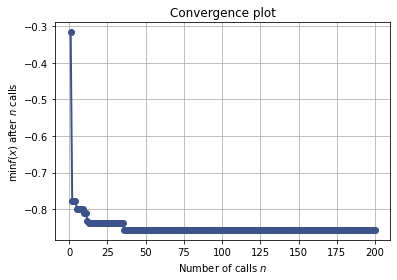

In [199]:
plot_convergence(search_result)

In [200]:
search_result.x

[7.781316357789917e-05, 2, 512, 0.4817420036018593, 0.04654715701572915, 5495]

In [201]:
search_result.fun

-0.8568641562014818

In [202]:
sorted(zip(search_result.func_vals,search_result.x_iters))[0:99]

[(-0.8568641562014818,
  [7.781316357789917e-05,
   2,
   512,
   0.4817420036018593,
   0.04654715701572915,
   5495]),
 (-0.8561355248093605,
  [0.01, 5, 512, 0.4036765438093811, 0.5518022808376438, 10000]),
 (-0.8488126154989004,
  [8.107714211649159e-05,
   4,
   512,
   0.17321794209367694,
   0.5066423466849256,
   3615]),
 (-0.8477107249200344,
  [0.006095338854781229,
   5,
   512,
   0.3700218047615615,
   0.562075015870824,
   10000]),
 (-0.8423103280365467,
  [0.00029434607547947756, 5, 512, 0.41697210309658855, 0.9, 5516]),
 (-0.8388687781989574,
  [0.00020681584613392546,
   2,
   32,
   0.16753984210613576,
   0.7447544235834764,
   3571]),
 (-0.8382565975189209,
  [0.01, 4, 512, 0.48350629925163746, 0.8742125933218696, 2147]),
 (-0.8381214328110218,
  [0.00018651991111169695,
   3,
   241,
   0.40484134546568007,
   0.20781646280419933,
   9902]),
 (-0.8371484111994505,
  [7.195207094641337e-05,
   2,
   512,
   0.16690524995373598,
   0.6258202183372124,
   1098]),
 (-0

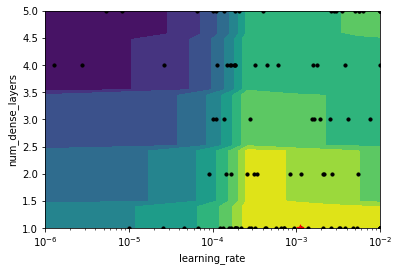

In [110]:
fig =  plot_objective_2D(result=search_result,dimension_identifier1='learning_rate',dimension_identifier2='num_dense_layers')                        

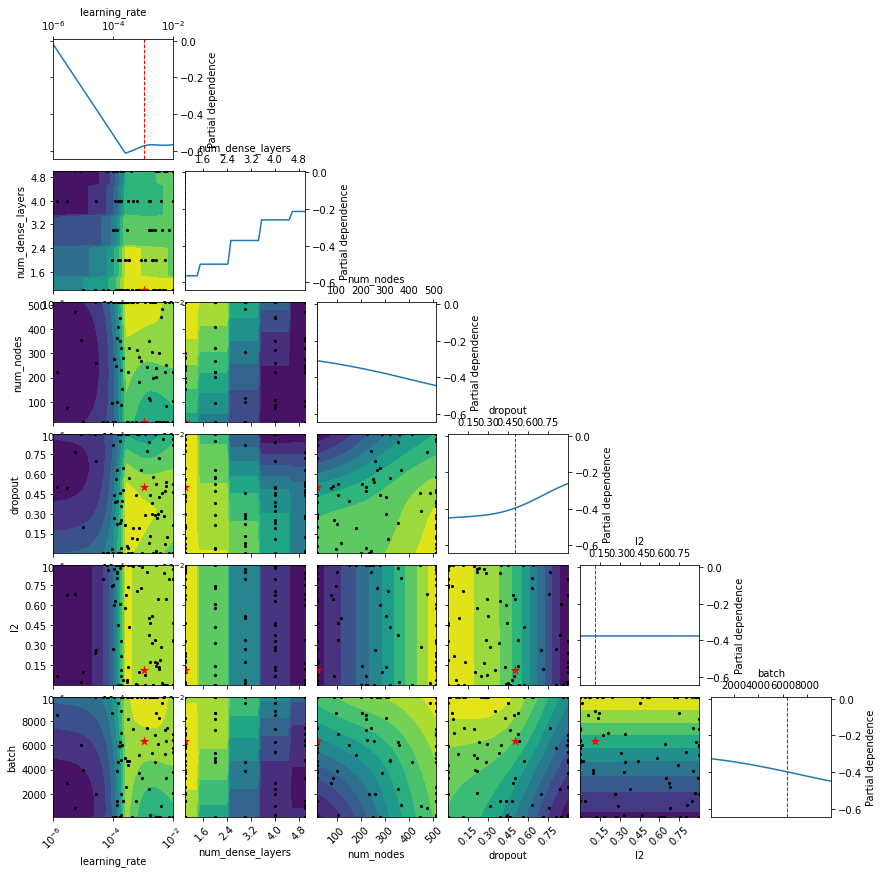

In [112]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_nodes','dropout','l2','batch']
fig = plot_objective(result=search_result, dimensions=dim_names)

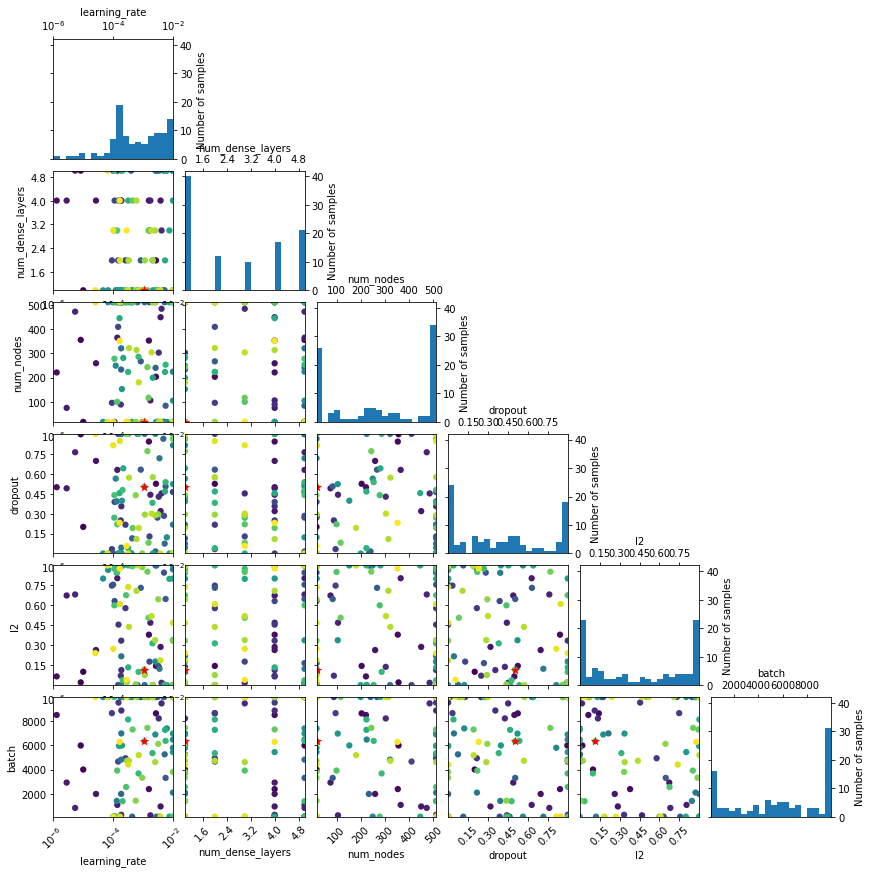

In [113]:
fig = plot_evaluations(result=search_result, dimensions=dim_names)

In [33]:
batch_size=5495

In [34]:
#This is a little messy, A better approach will be to build a function
#Also, another way is to just load the best model instead of manually creating another model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16,input_shape = (30,),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.Dropout(0.48),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    tf.keras.layers.Dropout(0.48),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

2021-10-11 01:58:25.318065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-11 01:58:25.318187: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-11 01:58:25.318218: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (heavyblanket): /proc/driver/nvidia/version does not exist
2021-10-11 01:58:25.319050: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8704      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [36]:
bce = tf.keras.losses.BinaryCrossentropy()
learning_rate=7.781316357789917e-05
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer,loss=bce,metrics=custom_f1)

In [37]:
#F1 score is fine, but clearly there is overfitting
#I fix this in my next code using Optuina tuner tha is more flexible

history = model.fit(x_train,y_train,batch_size=batch_size,validation_split=0.1,epochs=1000)

2021-10-11 01:58:39.522676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
3/3 [==============================] - 2s 200ms/step - loss: 22.4365 - custom_f1: 0.0424 - val_loss: 22.1430 - val_custom_f1: 0.0250
Epoch 2/1000
3/3 [==============================] - 0s 104ms/step - loss: 22.2376 - custom_f1: 0.0432 - val_loss: 21.9624 - val_custom_f1: 0.0314
Epoch 3/1000
3/3 [==============================] - 0s 102ms/step - loss: 22.0361 - custom_f1: 0.0537 - val_loss: 21.7815 - val_custom_f1: 0.0574
Epoch 4/1000
3/3 [==============================] - 0s 106ms/step - loss: 21.8360 - custom_f1: 0.0581 - val_loss: 21.6000 - val_custom_f1: 0.0568
Epoch 5/1000
3/3 [==============================] - 0s 99ms/step - loss: 21.6512 - custom_f1: 0.0620 - val_loss: 21.4182 - val_custom_f1: 0.0600
Epoch 6/1000
3/3 [==============================] - 0s 100ms/step - loss: 21.4516 - custom_f1: 0.0726 - val_loss: 21.2370 - val_custom_f1: 0.0606
Epoch 7/1000
3/3 [==============================] - 0s 97ms/step - loss: 21.2635 - custom_f1: 0.0707 - val_loss: 21.0554 - va

3/3 [==============================] - 0s 100ms/step - loss: 13.5383 - custom_f1: 0.1459 - val_loss: 13.3848 - val_custom_f1: 0.6667
Epoch 58/1000
3/3 [==============================] - 0s 100ms/step - loss: 13.4131 - custom_f1: 0.1640 - val_loss: 13.2609 - val_custom_f1: 0.6835
Epoch 59/1000
3/3 [==============================] - 0s 103ms/step - loss: 13.2901 - custom_f1: 0.1536 - val_loss: 13.1385 - val_custom_f1: 0.6923
Epoch 60/1000
3/3 [==============================] - 0s 106ms/step - loss: 13.1682 - custom_f1: 0.1659 - val_loss: 13.0172 - val_custom_f1: 0.6923
Epoch 61/1000
3/3 [==============================] - 0s 98ms/step - loss: 13.0418 - custom_f1: 0.1705 - val_loss: 12.8967 - val_custom_f1: 0.6923
Epoch 62/1000
3/3 [==============================] - 0s 101ms/step - loss: 12.9238 - custom_f1: 0.1708 - val_loss: 12.7774 - val_custom_f1: 0.7013
Epoch 63/1000
3/3 [==============================] - 0s 99ms/step - loss: 12.8084 - custom_f1: 0.1692 - val_loss: 12.6592 - val_custo

3/3 [==============================] - 0s 97ms/step - loss: 4.6043 - custom_f1: 0.6442 - val_loss: 4.5147 - val_custom_f1: 0.8000
Epoch 170/1000
3/3 [==============================] - 0s 100ms/step - loss: 4.5544 - custom_f1: 0.6525 - val_loss: 4.4681 - val_custom_f1: 0.8182
Epoch 171/1000
3/3 [==============================] - 0s 97ms/step - loss: 4.5106 - custom_f1: 0.6088 - val_loss: 4.4219 - val_custom_f1: 0.8000
Epoch 172/1000
3/3 [==============================] - 0s 99ms/step - loss: 4.4689 - custom_f1: 0.6168 - val_loss: 4.3765 - val_custom_f1: 0.8000
Epoch 173/1000
3/3 [==============================] - 0s 97ms/step - loss: 4.4241 - custom_f1: 0.6246 - val_loss: 4.3317 - val_custom_f1: 0.8000
Epoch 174/1000
3/3 [==============================] - 0s 98ms/step - loss: 4.3765 - custom_f1: 0.6636 - val_loss: 4.2867 - val_custom_f1: 0.8000
Epoch 175/1000
3/3 [==============================] - 0s 99ms/step - loss: 4.3302 - custom_f1: 0.6239 - val_loss: 4.2423 - val_custom_f1: 0.7812

3/3 [==============================] - 0s 99ms/step - loss: 1.3778 - custom_f1: 0.7995 - val_loss: 1.3503 - val_custom_f1: 0.7333
Epoch 282/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.3708 - custom_f1: 0.7676 - val_loss: 1.3353 - val_custom_f1: 0.7333
Epoch 283/1000
3/3 [==============================] - 0s 105ms/step - loss: 1.3544 - custom_f1: 0.7602 - val_loss: 1.3202 - val_custom_f1: 0.7586
Epoch 284/1000
3/3 [==============================] - 0s 95ms/step - loss: 1.3292 - custom_f1: 0.8119 - val_loss: 1.3063 - val_custom_f1: 0.7586
Epoch 285/1000
3/3 [==============================] - 0s 100ms/step - loss: 1.3255 - custom_f1: 0.7720 - val_loss: 1.2925 - val_custom_f1: 0.7458
Epoch 286/1000
3/3 [==============================] - 0s 97ms/step - loss: 1.3083 - custom_f1: 0.7901 - val_loss: 1.2790 - val_custom_f1: 0.7333
Epoch 287/1000
3/3 [==============================] - 0s 98ms/step - loss: 1.2929 - custom_f1: 0.8032 - val_loss: 1.2643 - val_custom_f1: 0.74

3/3 [==============================] - 0s 105ms/step - loss: 0.3907 - custom_f1: 0.8307 - val_loss: 0.4098 - val_custom_f1: 0.8065
Epoch 394/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.3899 - custom_f1: 0.8319 - val_loss: 0.4052 - val_custom_f1: 0.8197
Epoch 395/1000
3/3 [==============================] - 0s 94ms/step - loss: 0.3791 - custom_f1: 0.8658 - val_loss: 0.4017 - val_custom_f1: 0.8197
Epoch 396/1000
3/3 [==============================] - 0s 94ms/step - loss: 0.3789 - custom_f1: 0.8369 - val_loss: 0.3988 - val_custom_f1: 0.8065
Epoch 397/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.3765 - custom_f1: 0.8230 - val_loss: 0.3962 - val_custom_f1: 0.7937
Epoch 398/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.3696 - custom_f1: 0.8540 - val_loss: 0.3932 - val_custom_f1: 0.7742
Epoch 399/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.3687 - custom_f1: 0.8353 - val_loss: 0.3894 - val_custom_f1: 0.77

3/3 [==============================] - 0s 98ms/step - loss: 0.1247 - custom_f1: 0.8680 - val_loss: 0.1325 - val_custom_f1: 0.8571
Epoch 506/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.1247 - custom_f1: 0.8766 - val_loss: 0.1317 - val_custom_f1: 0.8571
Epoch 507/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.1244 - custom_f1: 0.8775 - val_loss: 0.1311 - val_custom_f1: 0.8571
Epoch 508/1000
3/3 [==============================] - 0s 94ms/step - loss: 0.1211 - custom_f1: 0.8875 - val_loss: 0.1305 - val_custom_f1: 0.8308
Epoch 509/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.1207 - custom_f1: 0.8861 - val_loss: 0.1299 - val_custom_f1: 0.8182
Epoch 510/1000
3/3 [==============================] - 0s 93ms/step - loss: 0.1223 - custom_f1: 0.8735 - val_loss: 0.1288 - val_custom_f1: 0.8308
Epoch 511/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.1191 - custom_f1: 0.8778 - val_loss: 0.1278 - val_custom_f1: 0.8710

3/3 [==============================] - 0s 98ms/step - loss: 0.0592 - custom_f1: 0.8955 - val_loss: 0.0640 - val_custom_f1: 0.8308
Epoch 618/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.0594 - custom_f1: 0.8918 - val_loss: 0.0630 - val_custom_f1: 0.8437
Epoch 619/1000
3/3 [==============================] - 0s 97ms/step - loss: 0.0583 - custom_f1: 0.8958 - val_loss: 0.0621 - val_custom_f1: 0.8308
Epoch 620/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0584 - custom_f1: 0.8894 - val_loss: 0.0617 - val_custom_f1: 0.8308
Epoch 621/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.0583 - custom_f1: 0.8946 - val_loss: 0.0619 - val_custom_f1: 0.8308
Epoch 622/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.0576 - custom_f1: 0.8879 - val_loss: 0.0621 - val_custom_f1: 0.8308
Epoch 623/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0581 - custom_f1: 0.8823 - val_loss: 0.0621 - val_custom_f1: 0.8308

3/3 [==============================] - 0s 97ms/step - loss: 0.0405 - custom_f1: 0.8937 - val_loss: 0.0475 - val_custom_f1: 0.8485
Epoch 730/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.0400 - custom_f1: 0.9041 - val_loss: 0.0474 - val_custom_f1: 0.8485
Epoch 731/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.0408 - custom_f1: 0.8991 - val_loss: 0.0471 - val_custom_f1: 0.8182
Epoch 732/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.0394 - custom_f1: 0.9158 - val_loss: 0.0472 - val_custom_f1: 0.8308
Epoch 733/1000
3/3 [==============================] - 0s 93ms/step - loss: 0.0396 - custom_f1: 0.9111 - val_loss: 0.0468 - val_custom_f1: 0.8308
Epoch 734/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0402 - custom_f1: 0.8997 - val_loss: 0.0465 - val_custom_f1: 0.8308
Epoch 735/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.0397 - custom_f1: 0.9007 - val_loss: 0.0465 - val_custom_f1: 0.8308

3/3 [==============================] - 0s 98ms/step - loss: 0.0325 - custom_f1: 0.9060 - val_loss: 0.0424 - val_custom_f1: 0.8485
Epoch 842/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0321 - custom_f1: 0.9157 - val_loss: 0.0427 - val_custom_f1: 0.8485
Epoch 843/1000
3/3 [==============================] - 0s 107ms/step - loss: 0.0321 - custom_f1: 0.9206 - val_loss: 0.0427 - val_custom_f1: 0.8358
Epoch 844/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0323 - custom_f1: 0.9255 - val_loss: 0.0418 - val_custom_f1: 0.8485
Epoch 845/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.0330 - custom_f1: 0.9019 - val_loss: 0.0418 - val_custom_f1: 0.8485
Epoch 846/1000
3/3 [==============================] - 0s 100ms/step - loss: 0.0321 - custom_f1: 0.9156 - val_loss: 0.0424 - val_custom_f1: 0.8485
Epoch 847/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.0338 - custom_f1: 0.9056 - val_loss: 0.0425 - val_custom_f1: 0.8

3/3 [==============================] - 0s 96ms/step - loss: 0.0279 - custom_f1: 0.9243 - val_loss: 0.0384 - val_custom_f1: 0.8308
Epoch 954/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0285 - custom_f1: 0.9313 - val_loss: 0.0392 - val_custom_f1: 0.8485
Epoch 955/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.0279 - custom_f1: 0.9223 - val_loss: 0.0399 - val_custom_f1: 0.8485
Epoch 956/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.0274 - custom_f1: 0.9301 - val_loss: 0.0395 - val_custom_f1: 0.8485
Epoch 957/1000
3/3 [==============================] - 0s 98ms/step - loss: 0.0271 - custom_f1: 0.9330 - val_loss: 0.0392 - val_custom_f1: 0.8308
Epoch 958/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0282 - custom_f1: 0.9144 - val_loss: 0.0393 - val_custom_f1: 0.8308
Epoch 959/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.0275 - custom_f1: 0.9225 - val_loss: 0.0395 - val_custom_f1: 0.848

In [60]:
#Evaluate loss and F1 on test data

x_test,y_test = split_scale_data(ccdb.iloc[:,:-1],ccdb.iloc[:,-1], phase='test')
model.test_on_batch(x_test, y_test)

[0.028672147542238235, 0.902503252029419]

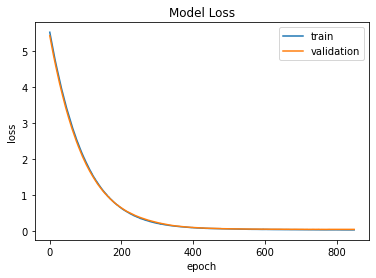

In [64]:
#Visualize loss on train and validation datasets

plt.plot(history.history['loss'][150:1000])
plt.plot(history.history['val_loss'][150:1000])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()